In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 11 09:52:03 2017

@author: ncaplar

"""



# 1d case

In [ ]:
"""Simplest thing, just to see that I can open fits file and lmfit fit a gaussian to 1d data"""

In [ ]:
data =fits.open('/media/caplarn/PFSData/PFS/Data/pfsArc-2016-11-11-0-r1.fits')

In [ ]:
scidata=data[0].data

In [ ]:
scidata_cut=scidata[2960:2970,1341:1351]

In [ ]:
from matplotlib.colors import LogNorm
plt.imshow(scidata_cut, cmap='gray')
plt.colorbar()

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cut, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cut, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)


In [ ]:
from lmfit import minimize, Parameters


In [ ]:
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))



In [ ]:
x=range(len(scidata_cut[5]))
y=scidata_cut[5]

In [ ]:
plt.plot(x,y)

In [ ]:
from lmfit import  Model
from numpy import sqrt, pi, exp, linspace, loadtxt
import numpy as np

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=5000, cen=5, wid=3)

print(result.fit_report())
fine_x=np.linspace(x[0], x[-1], num=50)
fine_best_fit=gaussian(fine_x,result.best_values['amp'],result.best_values['cen'],\
                       result.best_values['wid'])
plt.plot(x, y,         'bo')
plt.plot(x, result.init_fit, 'k--')
#plt.plot(x, result.best_fit, 'r-')
plt.plot(fine_x, fine_best_fit, 'r-')
plt.show()

#   <span style="color:red">2d Case now - deprecated</span>

In [ ]:


"""
Run this beforhand
(caplarn@Osian:~$ setup obs_lsstSim -t sims)
caplarn@Osian:~$ setup GalSim
caplarn@Osian:~$ jupyter notebook 
"""

In [ ]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np
import lsst.afw



In [ ]:

z4Init=1
z4Range=(0,5)
zRange=(4,8)
r0Init=0.1
r0Range=(0,1)
centroidRange=(0,10)
fluxRelativeRange=(0,1)
zmax=8

params = lmfit.Parameters()
params.add('r0', r0Init, min=r0Range[0], max=r0Range[1])
params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
image = scidata_cut
flux = float(np.sum(image))
params.add('flux', flux,
           min = fluxRelativeRange[0]*flux,
           max = fluxRelativeRange[1]*flux)
params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
for i in range(5, zmax+1):
    params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])

def _chi(params):
    """Compute 'chi' image: (data - model)/sigma
    @param params  lmfit.Parameters object.
    @returns       Unraveled chi vector.
    """
    modelImg = self.constructModelImage(params)
    image = self.maskedImage.getImage().getArray()
    sigma = self.maskedImage.getVariance().getArray()
    chi = (image - modelImg)/sigma
    return chi[self.good].ravel()

def _getOptPsf(params):
    aberrations = [0, 0, 0, 0]
    for i in range(4, zmax + 1):
        aberrations.append(params['z{}'.format(i)])
    return galsim.OpticalPSF(lam = self.wavelength,
                             diam = self.aper.diam,
                             aper = self.aper,
                             aberrations = aberrations)


def constructModelImage(params=None, pixelScale=None, jacobian=None,
                        shape=None):
    """Construct model image from parameters
    @param params      lmfit.Parameters object or python dictionary with
                       param values to use, or None to use self.params
    @param pixelScale  pixel scale in arcseconds to use for model image,
                       or None to use self.pixelScale.
    @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                       to the forward model.  Note that this is relative to
                       the pixelScale above.  Use self.jacobian if this is
                       None.
    @param shape       (nx, ny) shape for model image, or None to use
                       the shape of self.maskedImage
    @returns       numpy array image
    """
    if params is None:
        params = self.params
    if shape is None:
        shape = self.maskedImage.getImage().getArray().shape
    if pixelScale is None:
        pixelScale = self.pixelScale
    if jacobian is None:
        jacobian = self.jacobian
    try:
        v = params.valuesdict()
    except AttributeError:
        v = params

    optPsf = self._getOptPsf(v)
    if 'r0' in v:
        atmPsf = galsim.Kolmogorov(lam=self.wavelength, r0=v['r0'])
        psf = galsim.Convolve(optPsf, atmPsf)
    else:
        psf = optPsf
    psf = psf.shift(v['dx'], v['dy'])*v['flux']

    wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
    modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
    return modelImg.array

In [ ]:
"""
1. Construct any kind of constructModelImage - done
2. Image with some abbeartions, made to correct input image (normalization not done)
"""

params = lmfit.Parameters()
image=scidata_cut
flux=float(np.sum(image))
params.add('flux', flux,
           min = fluxRelativeRange[0]*flux,
           max = fluxRelativeRange[1]*flux)
z4Init=0
z4Range=(0,1)
params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
zmax=11
zRange=(-1,1)
for i in range(5, zmax+1):
    params.add('z{}'.format(i), 0.1, min=zRange[0], max=zRange[1])
    
def _getOptPsf(aber_4_to_11):
    #I do not fully understand why this does not work
    #aberrations = [0, 0, 0, 0]
    #for i in range(4, zmax + 1):
    #    aberrations.append(params['z{}'.format(i)])
    
    #This line for aberrations below surely works
    aberrations_init=[0.0,0.0,0.0,0.0]
    aberrations = aberrations_init+aber_4_to_11
    
    #There is a part here related to optical properties of telescope....
    # Define the optical part of the PSF:
    # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
    # diameter), which needs to be in the same units used to specify the image scale.  We are using
    # arcsec for that, so we have to self-consistently use arcsec here, using the following
    # calculation:
    tel_diam = 1.          # meters
    lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
    lam_over_diam = lam * 1.e-9 / tel_diam # radians
    lam_over_diam *= 206265  # arcsec
    print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
    # The rest of the values should be given in units of the wavelength of the incident light.
    return galsim.OpticalPSF(lam_over_diam, aberrations = aberrations)

In [ ]:
#params
#aberrations = [0, 0, 0, 0]
#for i in range(4, zmax + 1):
#    aberrations.append(params['z{}'.format(i)])
#aberrations    

In [ ]:
#This creates opticalpsf
optPsf=_getOptPsf([0.6,0,0,0,0,0,0,0])
#We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
psf = optPsf

In [ ]:
pixelScale=geom.Angle(0.000001)
pixelScale=geom.radToArcsec(pixelScale)
print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
from lsst.afw import geom
jacobian = np.eye(2, dtype=np.float64)
wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
shape=(10,10)
modelImg = psf.drawImage(
    nx = shape[0],
    ny = shape[1],
    wcs = wcs)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(modelImg.array, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(modelImg.array, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)


#  <span style="color:red">Realistic modeling now - deprecated</span>

In [ ]:
"""
3. Construct a single function which constructs model Image given some parameters constructModelImage - done
"""
from lsst.afw import geom

def _getOptPsf(params):
    #Added .value to the params[] -> params[].value
    
    #This line for aberrations below surely works
    aberrations_init=[0.0,0.0,0.0,0.0]
    aberrations = aberrations_init
    #aberrations = aberrations_init+aber_4_to_11
    for i in range(4, zmax + 1):
        aberrations.append(params['z{}'.format(i)].value)
    
    #There is a part here related to optical properties of telescope....
    # Define the optical part of the PSF:
    # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
    # diameter), which needs to be in the same units used to specify the image scale.  We are using
    # arcsec for that, so we have to self-consistently use arcsec here, using the following
    # calculation:
    tel_diam = 1.          # meters
    lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
    lam_over_diam = lam * 1.e-9 / tel_diam # radians
    lam_over_diam *= 206265  # arcsec
    #Uncomment below to show lam_over_diam
    #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
    # The rest of the values should be given in units of the wavelength of the incident light.
    return galsim.OpticalPSF(lam_over_diam, aberrations = aberrations)

def constructModelImage_Neven(params):
    flux=float(np.sum(image))
    params.add('flux', flux,
           min = fluxRelativeRange[0]*flux,
           max = fluxRelativeRange[1]*flux)
    try:
        v = params.valuesdict()
    except AttributeError:
        v = params
    
    #This creates opticalpsf
    optPsf=_getOptPsf(params)
    #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
    psf = optPsf
    psf = psf.shift(v['dx'], v['dy'])
    #pixel scale at the moment choosen at random, made to be same to lam_over_diam
    pixelScale=geom.Angle(0.000001)
    pixelScale=geom.radToArcsec(pixelScale)
    #Uncomment below to show pixes scale
    #print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
    jacobian = np.eye(2, dtype=np.float64)
    wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
    shape=np.shape(image)
    modelImg = psf.drawImage(
    nx = shape[0],
    ny = shape[1],
    wcs = wcs)
    multiplicative_factor=flux/np.sum(modelImg.array)
    return multiplicative_factor*modelImg.array

In [ ]:
"""
4. Define chi squre for our problem
"""
def _chi_Neven(params):
    """Compute 'chi' image: (data - model)/sigma
    @param params  lmfit.Parameters object.
    @returns       Unraveled chi vector.
    
    Original code below, hacking now to use pure image files
    modelImg = constructModelImage(params)
    image = maskedImage.getImage().getArray()
    sigma = maskedImage.getVariance().getArray()
    chi = (image - modelImg)/sigma
    
    """
    modelImg = constructModelImage_Neven(params)
    sigma = np.sqrt(image)
    chi = (image - modelImg)/sigma
    chi_without_nan=[]
    chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
    return chi_without_nan

In [ ]:
"""
5. Run lmfit
"""

def fit_Neven():
    """Do the fit
    @returns  result as an lmfit.MinimizerResult.
    """
    result = lmfit.minimize(_chi_Neven, params)
    return result


In [ ]:
params = lmfit.Parameters()
image=scidata_cut
flux=float(np.sum(image))
fluxRelativeRange=(0,1)
params.add('flux', flux,
           min = fluxRelativeRange[0]*flux,
           max = fluxRelativeRange[1]*flux)
z4Init=0
z4Range=(-1,1)
params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
zmax=11
zRange=(-1,1)
centroidRange=(-5,5)
params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
for i in range(5, zmax+1):
    params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])

In [ ]:
lmmfit_res_Neven=fit_Neven()

In [ ]:
"""
5. Show model and residuals
"""
resimg=constructModelImage_Neven(lmmfit_res_Neven.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(resimg, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(resimg, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)


In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cut-resimg, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(abs(scidata_cut-resimg), cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
"""
6. Implement movable center - done, not obvious it helps

"""

In [ ]:
print(lmmfit_res_Neven.message)
print("Reduced chi square is: "+str(lmmfit_res_Neven.redchi))
lmmfit_res_Neven.params.pretty_print()


In [ ]:
lmmfit_res_Neven.flatchain

## Select donuts from the actual data

In [ ]:
data=fits.open('/media/caplarn/PFSData/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data

In [ ]:
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)

In [ ]:
len(np.diff(pos_x_of_donuts).ravel()>10)

In [ ]:
pos_x_of_donuts[0][np.diff(pos_x_of_donuts).ravel()>10]

In [ ]:
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
idx=np.insert(idx,0,1)

In [ ]:
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1]+1)]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)

In [ ]:
i=1
pos_x_of_donuts[0][idx[i]:idx[i+1]]

In [ ]:
onefiber_x_position=int(pos_x_of_donuts_subarray[5])

In [ ]:
onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]

In [ ]:
pos_y_of_donuts=np.where(onefiber.max(axis=1)>50)
idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
idy=np.insert(idy,0,1)
#This gives position of rows 
pos_y_of_donuts_subarray=[]
pos_y_of_donuts_subarray_len=[]
for i in range(len(idy)-1):
    pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)

In [ ]:
pos_y_of_donuts_subarray

In [ ]:
pos_y_of_donuts_subarray_len

In [ ]:
i=4
pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]

In [ ]:
>>> plt.hist(pos_y_of_donuts_subarray_len, bins='auto')  # arguments are passed to np.histogram
>>> plt.title("Histogram with 'auto' bins")
>>> plt.show()

In [ ]:
#Cutting above 30 pixels in this example (keep the one at 29 pixels just to see what happens)

In [ ]:
pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[pos_y_of_donuts_subarray_len<30]

In [ ]:
scidata_cuts=[[]]
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20):(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
    scidata_cuts=np.append(scidata_cuts,single_scidata_cut)

In [ ]:
scidata_cuts12=np.split(scidata_cuts,12)
for i in range(len(scidata_cuts12)-1):
    scidata_cuts12[i]=scidata_cuts12[i].reshape(40,40)

In [ ]:
for ima in range(0,len(scidata_cuts12)-1):
    plt.figure()
    plt.imshow(scidata_cuts12[ima], cmap='gray')

## Create a single function that takes an image and gives a result

In [ ]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np
from lsst.afw import geom
from matplotlib.colors import LogNorm

class ZernikeFitter_PSF(object):
    
    """Description comes here
    """
    def __init__(self, image, pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        # I am cheating here - adding so lowest value is 0.1
        #image=image-np.min(image)+0.1
        self.image = image
        #pixel scale at the moment choosen at random, made to be same to lam_over_diam
        pixelScale=geom.Angle(0.000001)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        zmax=11
        self.zmax = zmax
        self.kwargs = kwargs
    
    def initParams(self, z4Init, z4Range, zRange,
                   centroidRange, fluxRelativeRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        params = lmfit.Parameters()
        params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
        params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
        image = self.image
        flux = float(np.sum(image))
        self.flux=flux
        params.add('flux', flux,
                   min = fluxRelativeRange[0]*flux,
                   max = fluxRelativeRange[1]*flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        self.params = params
    
    def _getOptPsf(self, params):
        #Added .value to the params[] (i.e., changed params[]-> params[].value)
        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        #There is a part here related to optical properties of telescope....
        # Define the optical part of the PSF:
        # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
        # diameter), which needs to be in the same units used to specify the image scale.  We are using
        # arcsec for that, so we have to self-consistently use arcsec here, using the following
        # calculation:
        tel_diam = 1.          # meters
        lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
        lam_over_diam = lam * 1.e-9 / tel_diam # radians
        lam_over_diam *= 206265  # arcsec
        #Uncomment below to show lam_over_diam
        #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
        # The rest of the values should be given in units of the wavelength of the incident light.
        return galsim.OpticalPSF(lam_over_diam, aberrations = aberrations)
    
    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #pixel scale at the moment choosen at random, made to be same to lam_over_diam
        #pixelScale=geom.Angle(0.000001)
        #pixelScale=geom.radToArcsec(pixelScale)
        #Uncomment below to show pixes scale
        #print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return 1*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print(np.mean(chi_without_nan)**2)
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params, method='brute',**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

# <span style="color:red">Running new class on a single object -theoretically done, seems to be very sensitive on initial conditions  - deprecated</span>

In [ ]:
single_image_analysis=ZernikeFitter_PSF(scidata_cut,epsfcn=0.1)

In [ ]:
single_image_analysis.initParams(z4Init=0.5,z4Range=(0,1),zRange=(-1,1),\
                                 centroidRange=(-5,5),fluxRelativeRange=(0,1))

In [ ]:
result_fit_single_image=single_image_analysis.fit_Neven()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

In [ ]:
single_image_analysis.report()

In [ ]:
result_fit_single_image.init_vals

#  <span style="color:red">Running new class on a single donut  - deprecated</span>

In [ ]:
#semi-reasonable results with brute force method...

single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5])
single_image_analysis.initParams(z4Init=0.2,z4Range=(0,2),zRange=(-1,1),\
                                 centroidRange=(-5,5),fluxRelativeRange=(0,1))
result_fit_single_image=single_image_analysis.fit_Neven()
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params


In [ ]:
single_image_analysis.report()

#    <span style="color:red">Which pixels are contributing in the final image?  - deprecated</span>

In [ ]:
kinda_sigma_map=np.sqrt(scidata_cuts12[5])
map_where_chi2=(residual_img/kinda_sigma_map)**2

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(np.nan_to_num(map_where_chi2), cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.nan_to_num(map_where_chi2), cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
# The problem is in the innermost pixes - optical tshings

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)

In [ ]:
result_fit_single_image.params

## Ok the problem is that I have not modeled the  pupil

In [ ]:
# This will be quite complex
# Lets first make any psf with roughly the reasonable aperature

In [ ]:
from __future__ import absolute_import, division, print_function

__all__ = ['PupilFactory_Neven', 'Pupil']

import numpy as np


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale


class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False

    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False

In [ ]:
from __future__ import absolute_import, division, print_function

from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
import numpy as np


class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0.43, 0.43]),
                         np.array([0.43, 0.43]),
                         np.array([-0.43, -0.43]),
                         np.array([-0.43, -0.43])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle = 51.75*degrees
        alpha = strutAngle - 45.0*degrees
        unrotAngles = [90*degrees + alpha,
                       -alpha,
                       180*degrees - alpha,
                       270*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    telescopeDiameter = 8.2  # meters

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(np.arctan2(0, 1))
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        subaruRadius = self.telescopeDiameter/2

        hscFrac = 0.231  # linear fraction
        # radius of HSC camera shadow in meters
        hscRadius = hscFrac * subaruRadius

        subaruStrutThick = 0.22  # meters

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
HscPupil=PFSPupilFactory(5,10)

In [ ]:
iluminated.shape[0]

In [ ]:
iluminated=np.ones((4,4),dtype=np.int16)
diam=1
pupil=Pupil(iluminated,1,0.1)

aper_test = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = pupil.size)

In [ ]:
def _getOptPsf(params):
    #Added .value to the params[] -> params[].value
    
    #This line for aberrations below surely works
    aberrations_init=[0.0,0.0,0.0,0.0]
    aberrations = aberrations_init
    #aberrations = aberrations_init+aber_4_to_11
    for i in range(4, zmax + 1):
        aberrations.append(params['z{}'.format(i)].value)
    
    #There is a part here related to optical properties of telescope....
    # Define the optical part of the PSF:
    # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
    # diameter), which needs to be in the same units used to specify the image scale.  We are using
    # arcsec for that, so we have to self-consistently use arcsec here, using the following
    # calculation:
    tel_diam = 1.          # meters
    lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
    lam_over_diam = lam * 1.e-9 / tel_diam # radians
    lam_over_diam *= 206265  # arcsec
    #Uncomment below to show lam_over_diam
    #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
    # The rest of the values should be given in units of the wavelength of the incident light.
    return galsim.OpticalPSF(lam=lam,diam=tel_diam, aberrations = aberrations,aper=aper_test)

In [ ]:
import galsim
from galsim import phase_psf

zmax=11
_getOptPsf(result_fit_single_image.params)

In [ ]:
dir(HscPupil)

#  <span style="color:red">Ok, now the class with some aperature  - deprecated</span>

In [ ]:
"""
Created on Tue Sep 19 12:24:03 2017

@author: ncaplar

"""


In [ ]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np
import lsst.afw
import astropy

from astropy.io import fits
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

## Select donuts from the actual data

In [ ]:
data=fits.open('/media/caplarn/PFSData/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data
#data=fits.open('/home/caplarn/Downloads/pfsArc-2016-11-11-0-r1.fits')
#scidata=data[0].data

In [ ]:
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
idx=np.insert(idx,0,1)
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1]+1)]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)
onefiber_x_position=int(pos_x_of_donuts_subarray[5])    
onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
pos_y_of_donuts=np.where(onefiber.max(axis=1)>50)
idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
idy=np.insert(idy,0,1)
#This gives position of rows 
pos_y_of_donuts_subarray=[]
pos_y_of_donuts_subarray_len=[]
for i in range(len(idy)-1):
    pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)

In [ ]:
>>> plt.hist(pos_y_of_donuts_subarray_len, bins='auto')  # arguments are passed to np.histogram
>>> plt.title("Histogram with 'auto' bins")
>>> plt.show()

In [ ]:
#Cutting above 30 pixels in this example (keep the one at 29 pixels just to see what happens)

In [ ]:
pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[pos_y_of_donuts_subarray_len<30]

In [ ]:
scidata_cuts=[[]]
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20):(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
    scidata_cuts=np.append(scidata_cuts,single_scidata_cut)

In [ ]:
scidata_cuts12=np.split(scidata_cuts,12)
for i in range(len(scidata_cuts12)-1):
    scidata_cuts12[i]=scidata_cuts12[i].reshape(40,40)

In [ ]:
for ima in range(0,len(scidata_cuts12)-1):
    plt.figure()
    plt.imshow(scidata_cuts12[ima], cmap='gray')

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale


class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """
        print(self.u)
        print(self.v)
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    def _cutSquare(self,pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        """
        x21 = int(np.floor(p0[0]-r/2))
        x22 = int(np.ceil(p0[0]+r/2))
        y21 = int(np.floor(p0[1]-r/2))
        y22 = int(np.ceil(p0[1]+r/2))
        pupil[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False

    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False

In [ ]:
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0.43, 0.43]),
                         np.array([0.43, 0.43]),
                         np.array([-0.43, -0.43]),
                         np.array([-0.43, -0.43])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle = 51.75*degrees
        alpha = strutAngle - 45.0*degrees
        unrotAngles = [90*degrees + alpha,
                       -alpha,
                       180*degrees - alpha,
                       270*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    telescopeDiameter = 8.2  # meters

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(np.arctan2(0, 1))
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        subaruRadius = self.telescopeDiameter/2

        hscFrac = 0.231  # linear fraction
        # radius of HSC camera shadow in meters
        hscRadius = hscFrac * subaruRadius

        subaruStrutThick = 0.22  # meters

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        self._cutSquare(pupil, (camX, camY), hscRadius)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
class ZernikeFitter_PSF(object):
    
    """Description comes here
    """
    def __init__(self, image, pupil, diam, pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        print('init_start')
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        #pixelScale=geom.Angle(0.000001818)
        #pixelScale=geom.radToArcsec(pixelScale)
        pixelScale=geom.Angle(0.000001118)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        zmax=11
        self.zmax = zmax
        wavelength=6000
        self.wavelength=wavelength
        
        self.aper = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = pupil.size)
        self.kwargs = kwargs
        print('init_finished')
    
    def initParams(self, z4Init, z4Range, zRange,
                   centroidRange, fluxRelativeRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        print('init_params_start')
        params = lmfit.Parameters()
        params.add('dx', 0.0, min=centroidRange[0], max=centroidRange[1])
        params.add('dy', 0.0, min=centroidRange[0], max=centroidRange[1])
        image = self.image
        flux = float(np.sum(image))
        #self.flux=flux
        params.add('flux', flux,
                   min = fluxRelativeRange[0]*flux,
                   max = fluxRelativeRange[1]*flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        self.params = params
        print('init_params_finish')
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init
        #aberrations = aberrations_init+aber_4_to_11
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        #There is a part here related to optical properties of telescope....
        # Define the optical part of the PSF:
        # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
        # diameter), which needs to be in the same units used to specify the image scale.  We are using
        # arcsec for that, so we have to self-consistently use arcsec here, using the following
        # calculation:
        #tel_diam = 1.          # meters
        #lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
        #lam_over_diam = lam * 1.e-9 / tel_diam # radians
        #lam_over_diam *= 206265  # arcsec
        #Uncomment below to show lam_over_diam
        #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
        # The rest of the values should be given in units of the wavelength of the incident light.
        return galsim.OpticalPSF(lam=self.wavelength,diam=self.aper.diam, aberrations = aberrations,aper=self.aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #pixel scale at the moment choosen at random, made to be same to lam_over_diam
        #pixelScale=geom.Angle(0.000001)
        #pixelScale=geom.radToArcsec(pixelScale)
        #Uncomment below to show pixes scale
        #print("You have set pixel scale to be "+str(pixelScale)+" arcsec")
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return 1*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean(chi_without_nan)**2))
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

In [ ]:
%pdb
from lsst.afw.geom import Point2D
HscPupil=PFSPupilFactory(8,100)
point=Point2D(0,0)
HscPupil.getPupil(point)
pupil=HscPupil.getPupil(point)
plt.imshow(HscPupil.getPupil(point).illuminated, cmap='gray')


In [ ]:
#iluminated=HscPupil.getPupil(point)
#iluminated[:4]=0
#iluminated
diam=8.2
pupil=HscPupil.getPupil(point)

aper_test = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = pupil.size)

In [ ]:
#ZernikeFitter_PSF takes one image, only used to deduce shape, the pupil and the diameter
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=8)
single_image_analysis.initParams(z4Init=0.0,z4Range=(0,2),zRange=(-1,1),\
                                 centroidRange=(-5,5),fluxRelativeRange=(0,0.8))

In [ ]:
#Run below only if you really want to fit

In [ ]:
result_fit_single_image=single_image_analysis.fit_Neven()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

#  <span style="color:red">Which pixels are contributing in the final image?  - deprecated</span>

In [ ]:
kinda_sigma_map=np.sqrt(scidata_cuts12[5])
map_where_chi2=(residual_img/kinda_sigma_map)**2

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(np.nan_to_num(map_where_chi2), cmap='gray')
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(np.nan_to_num(map_where_chi2), cmap='gray',norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

# Modeling PSF pupil and creating one realistic image

In [37]:
"""
(Re-)Created on Mon Sep 23 18:59 2017

@author: ncaplar@princeton.edu

Goals
1. Creating single pupil
    -using HSC scales
    -using PFS scales 
    
This is done, perhaps not correct roations and movement in focal plane

2. Create a single image which looks kinda like the real data
3. 

"""

'\n(Re-)Created on Mon Sep 23 18:59 2017\n\n@author: ncaplar@princeton.edu\n\nGoals\n1. Creating single pupil\n    -using HSC scales\n    -using PFS scales \n    \nThis is done, perhaps not correct roations and movement in focal plane\n\n2. Create a single image which looks kinda like the real data\n3. \n\n'

In [1]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np
import lsst.afw
import astropy

from astropy.io import fits
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

##  <span style="color:red">Creating single pupil - done, for HSC size - deprecated</span>

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """
        print(self.u)
        print(self.v)
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        """
        x21 = int(np.floor(p0[0]-r/2))
        x22 = int(np.ceil(p0[0]+r/2))
        y21 = int(np.floor(p0[1]-r/2))
        y22 = int(np.ceil(p0[1]+r/2))
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False

    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix,input_angle)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    telescopeDiameter = 8.3  # meters

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        print(parAng)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        subaruRadius = self.telescopeDiameter/2

        hscFrac = 0.231  # linear fraction
        # radius of HSC camera shadow in meters
        hscRadius = hscFrac * subaruRadius

        subaruStrutThick = 0.22  # meters

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
HscPupil=PFSPupilFactory(8.3,100,np.pi/2)
point=Point2D(0,0)
HscPupil.getPupil(point)
pupil=HscPupil.getPupil(point)
plt.imshow(HscPupil.getPupil(point).illuminated, cmap='gray')

## Creating single pupil, PFS size

In [2]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix,input_angle)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    #I do not use this at the moment; telescope Diameter is set to be same as the pupil size
    #telescopeDiameter = 0.3  # meters


    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = 0.49  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac=0.05
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

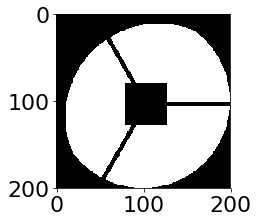

In [3]:
TestPupil=PFSPupilFactory(0.3,200,np.pi/2)
point=Point2D(5000,5000)
pupil=TestPupil.getPupil(point)
fig = plt.figure(figsize=(4, 3.2))
plt.imshow(pupil.illuminated, cmap='gray')
fig.savefig('/home/caplarn/Documents/PFS/Images/Pupil00.png')

## Ok - create array of pupils and "experimentally" deduce which one we need - WIP

In [ ]:
"""
(Re-)Created on Mon Sep 23 19:56 2017

@author: ncaplar@princeton.edu


Dependencies:
9.2


Goals

"""

### Import data 

In [8]:
data=fits.open('/media/caplarn/PFSData/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data

In [9]:
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
idx=np.insert(idx,0,1)
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1]+1)]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)
onefiber_x_position=int(pos_x_of_donuts_subarray[5])    
onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
pos_y_of_donuts=np.where(onefiber.max(axis=1)>50)
idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
idy=np.insert(idy,0,1)
#This gives position of rows 
pos_y_of_donuts_subarray=[]
pos_y_of_donuts_subarray_len=[]
for i in range(len(idy)-1):
    pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)

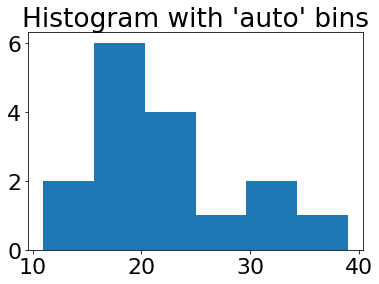

In [10]:
plt.hist(pos_y_of_donuts_subarray_len, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [11]:
#Cutting above 30 pixels in this example (keep the one at 29 pixels just to see what happens)

In [12]:
pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[pos_y_of_donuts_subarray_len<30]

In [13]:
scidata_cuts=[[]]
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20):(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
    scidata_cuts=np.append(scidata_cuts,single_scidata_cut)

In [14]:
scidata_cuts12=np.split(scidata_cuts,12)
for i in range(len(scidata_cuts12)-1):
    scidata_cuts12[i]=scidata_cuts12[i].reshape(40,40)

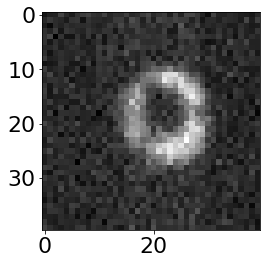

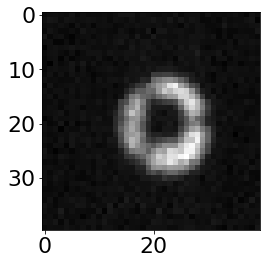

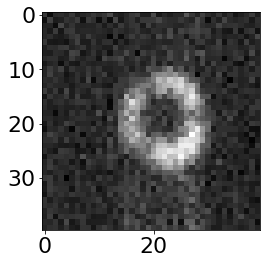

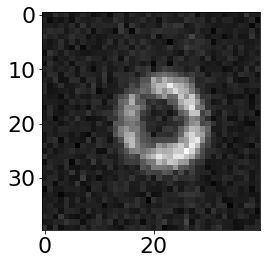

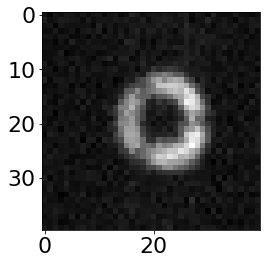

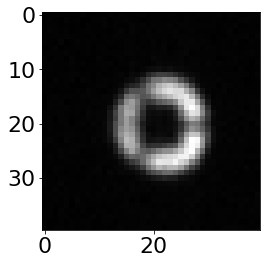

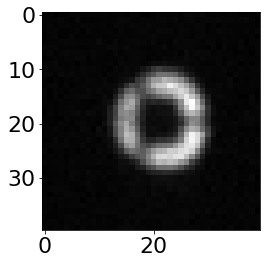

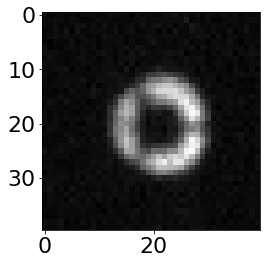

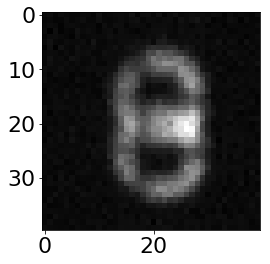

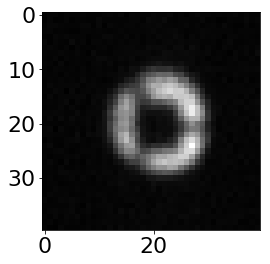

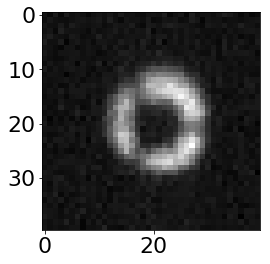

In [15]:
for ima in range(0,len(scidata_cuts12)-1):
    plt.figure()
    plt.imshow(scidata_cuts12[ima], cmap='gray')

### Fitter - doesnt change pupil things, deprecated

In [ ]:
class ZernikeFitter_PSF(object):
    
    """Description comes here
    """
    def __init__(self, image, pupil, diam, pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        zmax=11
        self.zmax = zmax
        wavelength=800 #nm
        self.wavelength=wavelength
        
        self.aper = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)
        self.kwargs = kwargs
    
    def initParams(self, z4Init, z4Range, zRange,
                   centroidRange, fluxRelativeRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        params = lmfit.Parameters()
        params.add('dx', 0.94, min=centroidRange[0], max=centroidRange[1])
        params.add('dy', 0.6, min=centroidRange[0], max=centroidRange[1])
        image = self.image
        flux = float(np.sum(image))
        self.flux=flux
        params.add('flux', flux,
                   min = fluxRelativeRange[0]*flux,
                   max = fluxRelativeRange[1]*flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init
        #aberrations = aberrations_init+aber_4_to_11
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        #There is a part here related to optical properties of telescope....
        # Define the optical part of the PSF:
        # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
        # diameter), which needs to be in the same units used to specify the image scale.  We are using
        # arcsec for that, so we have to self-consistently use arcsec here, using the following
        # calculation:
        #tel_diam = 1.          # meters
        #lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
        #lam_over_diam = lam * 1.e-9 / tel_diam # radians
        #lam_over_diam *= 206265  # arcsec
        #Uncomment below to show lam_over_diam
        #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
        # The rest of the values should be given in units of the wavelength of the incident light.
        return galsim.OpticalPSF(lam=self.wavelength,diam=self.aper.diam, aberrations = aberrations,aper=self.aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params,method='brute',**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

### Create single mock image

In [ ]:
#1. Figure how to create a single reasonable mock image

In [ ]:
test_par=lmfit.Parameters()
#opens most generic parameters
file_par=open('/home/caplarn/Documents/PFS/PFS_Work_In_Progress/JSONparameters/0.json',"r")
test_par.load(file_par)
#This set flux in the simulated image to be the same as in the target image
test_par['flux'].set(np.sum(scidata_cuts12[5]))
test_par['z4'].set(0.0)
test_par['z11'].set(0.0)
#keyword diam doesnt do anything at this stage! - the size of telescope is given by pupil
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=0.3)

In [ ]:
#test_par=result_fit_single_image.params
#I am noticing that this a lot less then in flux parameter
test_img=single_image_analysis.best_image_Neven(test_par)
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar( )
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

print(np.sum(test_img))

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)
print(np.sum(scidata_cuts12[5]))
plt.savefig('/home/caplarn/Documents/PFS/Images/Donut_Example.png')

### Run a grid of parameters

In [ ]:
#This code can be used to try different paramters - many attempts
matplotlib.rcParams.update({'font.size': 36})
#for PFSPF1 in range(1,6):
#    for Zernike in range(1,6):
#        if PFSPF1<=Zernike:
#            print('PFSPF1<Zernike')
#        else:
for size in np.linspace(0.2,0.5,31):
    for Defocus in np.linspace(0,0.9,91):
        HscPupil=PFSPupilFactory(0.8,200,+1.57)
        point=Point2D(0,0)
        pupil=HscPupil.getPupil(point)
        test_par=lmfit.Parameters()
        #opens most generic parameters
        file_par=open('/home/caplarn/Documents/PFS/PFS_Work_In_Progress/JSONparameters/0.json',"r")
        test_par.load(file_par)
        #This set flux in the simulated image to be the same as in the target image
        test_par['flux'].set(np.sum(scidata_cuts12[5]))
        test_par['z4'].set(Defocus)
        single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=0.3)
        test_img=single_image_analysis.best_image_Neven(test_par)
        plt.figure(figsize=(20,20))
        plt.subplot(221)
        plt.imshow(test_img, cmap='gray',vmin=1, vmax=1000)
        plt.colorbar( )
        plt.title('linear')
        plt.grid(False)
        plt.subplot(222)
        plt.imshow(test_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
        plt.colorbar()
        plt.title('log')
        plt.grid(False)
        plt.savefig('/home/caplarn/Documents/PFS/Images/TestingParamterSpace/'+'Test'+'Size'+str(size)+\
                    'Z4'+str(Defocus)+'.png')

### Fit to find?

In [ ]:
HscPupil=PFSPupilFactory(0.5,200,+1.5707)
point=Point2D(0,0)
pupil=HscPupil.getPupil(point)

In [ ]:
"""As creating pupil is quite high up, and I want to vary that as well, I will run fitter on a grid of pupils"""
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=0.3)
single_image_analysis.initParams(z4Init=0.36,z4Range=(0,5),zRange=(-1,1),\
                                 centroidRange=(-5,5),fluxRelativeRange=(0,0.8))
result_fit_single_image=single_image_analysis.fit_Neven()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

In [ ]:
single_image_analysis.report()

In [ ]:
result_fit_single_image.init_vals

In [ ]:
best_img
sigma = np.sqrt(scidata_cuts12[5])
chi = (scidata_cuts12[5]- best_img)/sigma
chi_without_nan=[]
chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
np.mean((chi_without_nan)**2)

In [ ]:
# Is pupil size same as diameter of camera?...
# Fit pupil size as a parameter? (also movement of spider?)
# emcee?
#Understand comment about measuring sizes in https://jira.lsstcorp.org/browse/DM-8589 by Joshua

### Creating new fitter with pupil as one of the parameters

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, z4Range, zRange,
                   centroidInit,centroidRange, fluxRelativeRange,
                   sizeInit,sizeRange,focalPlanePositionInit,focalPlanePositionRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        params.add('flux', self.flux,
                   min = fluxRelativeRange[0]*self.flux,
                   max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        params.add('dx', centroidInit[0], min=centroidRange[0], max=centroidRange[1])
        params.add('dy', centroidInit[1], min=centroidRange[0], max=centroidRange[1])
        params.add('size', sizeInit, min=sizeRange[0], max=sizeRange[1])
        params.add('dxFocal', focalPlanePositionInit[0], 
                   min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        params.add('dyFocal', focalPlanePositionInit[1], 
           min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['size'.format(i)],200,np.pi/2)
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params,method='brute',**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

### Generating a single mock image

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5])
single_image_analysis.initParams(zmax=11,z4Init=0.4,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0,0),centroidRange=(-5,5),fluxRelativeRange=(0,1.2),
                                 sizeInit=0.3,sizeRange=(0,1,0.9),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))

In [ ]:
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5])
#Lets hope it works
                                        

### Fitting with new code

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5])
single_image_analysis.initParams(zmax=11,z4Init=0.4,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0,0),centroidRange=(-5,5),fluxRelativeRange=(0,1.2),
                                 sizeInit=0.3,sizeRange=(0,1,0.9),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_Neven()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

### Fitting with emcee

In [179]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, z4Range, zRange,
                   centroidInit,centroidRange,
                   sizeInit,sizeRange,focalPlanePositionInit,focalPlanePositionRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        params.add('dx', centroidInit[0], min=centroidRange[0], max=centroidRange[1])
        params.add('dy', centroidInit[1], min=centroidRange[0], max=centroidRange[1])
        params.add('size', sizeInit, min=sizeRange[0], max=sizeRange[1])
        params.add('dxFocal', focalPlanePositionInit[0], 
                   min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        params.add('dyFocal', focalPlanePositionInit[1], 
           min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['size'.format(i)],100,np.pi/2)
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=52,burn=250, steps=2000, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

In [180]:
galsim.GSParams.maximum_fft_size=12000
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [170]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],epsfcn=0.1)
single_image_analysis.initParams(zmax=11,z4Init=0.0,z4Range=(0,3),zRange=(-1,1),
                                 centroidInit=(0,0),centroidRange=(-5,5),
                                 sizeInit=0.3,sizeRange=(0.2,0.7),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_LM()

Doing fit using Levenberg-Marquardt
chi**2/d.o.f. is:54230.678279
chi**2/d.o.f. is:54230.678279
chi**2/d.o.f. is:54230.678279
chi**2/d.o.f. is:7646.81003585
chi**2/d.o.f. is:2845.40407599
chi**2/d.o.f. is:3190.49013446
chi**2/d.o.f. is:2995.27851884
chi**2/d.o.f. is:2539.10704299
chi**2/d.o.f. is:2011.27447295
chi**2/d.o.f. is:2146.162279
chi**2/d.o.f. is:1554.48964192
chi**2/d.o.f. is:29067.0076633
chi**2/d.o.f. is:12825.0309388
chi**2/d.o.f. is:61300.2094729
chi**2/d.o.f. is:53673.1359339
chi**2/d.o.f. is:53008.6094164
chi**2/d.o.f. is:3226.93351291
chi**2/d.o.f. is:3700.59840217
chi**2/d.o.f. is:3335.04651084
chi**2/d.o.f. is:3273.69100207
chi**2/d.o.f. is:3224.73337238
chi**2/d.o.f. is:3081.94030767
chi**2/d.o.f. is:2944.42803482
chi**2/d.o.f. is:3139.79771138
chi**2/d.o.f. is:2074.77155736
chi**2/d.o.f. is:3250.26045692
chi**2/d.o.f. is:3227.96315073
chi**2/d.o.f. is:3634.70743767
chi**2/d.o.f. is:3146.18685269
chi**2/d.o.f. is:3239.44171514
chi**2/d.o.f. is:2134.56094085
chi**2/d

In [182]:
parz4Init=np.random.uniform(size=52)
parz5Init=np.random.randint(low=-10, high=10, size=52)/100
parz6Init=np.random.randint(low=-10, high=10, size=52)/100
parz7Init=np.random.randint(low=-10, high=10, size=52)/100
parz8Init=np.random.randint(low=-10, high=10, size=52)/100
parz9Init=np.random.randint(low=-10, high=10, size=52)/100
parz10Init=np.random.randint(low=-10, high=10, size=52)/100
parz11Init=np.random.randint(low=-10, high=10, size=52)/100
pardxInit=np.random.randint(low=-100, high=100, size=52)/100
pardyInit=np.random.randint(low=-100, high=100, size=52)/100
parsizeInit=np.random.randint(low=20, high=70, size=52)/100
pardxFocalInit=np.random.randint(low=-1000, high=1000, size=52)
pardyFocalInit=np.random.randint(low=-1000, high=1000, size=52)
par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,
                              parz10Init,parz11Init,pardxInit,pardyInit,parsizeInit,
                             pardxInit,pardyInit))
parInit=par_together.reshape(52,13)
parInit.shape

(52, 13)

In [183]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],pos=parInit)
single_image_analysis.initParams(zmax=11,z4Init=0.38,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0.64,-0.01),centroidRange=(-5,5),
                                 sizeInit=0.25,sizeRange=(0.2,0.7),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_emcee()

Doing fit using emcee
chi**2/d.o.f. is:189.165443194
chi**2/d.o.f. is:2448.28067134
chi**2/d.o.f. is:497.968163637
chi**2/d.o.f. is:5475.96269483
chi**2/d.o.f. is:1361.89297475
chi**2/d.o.f. is:8932.3887426
chi**2/d.o.f. is:1182.99965078
chi**2/d.o.f. is:40835.048027
chi**2/d.o.f. is:5502.70686277
chi**2/d.o.f. is:2506.31940854
chi**2/d.o.f. is:1937.14018313
chi**2/d.o.f. is:39300.0656113
chi**2/d.o.f. is:39026.914644
chi**2/d.o.f. is:544.061325107
chi**2/d.o.f. is:1052.94865278
chi**2/d.o.f. is:19408.2317921
chi**2/d.o.f. is:7205.94204699
chi**2/d.o.f. is:4373.14660794
chi**2/d.o.f. is:1788.8362963
chi**2/d.o.f. is:1242.60316931
chi**2/d.o.f. is:734.100100578
chi**2/d.o.f. is:3520.49267519
chi**2/d.o.f. is:745.104952218
chi**2/d.o.f. is:1118.15055497
chi**2/d.o.f. is:3899.61059496
chi**2/d.o.f. is:975.623936782
chi**2/d.o.f. is:1305.25423153
chi**2/d.o.f. is:2004.60926759
chi**2/d.o.f. is:4132.44143782
chi**2/d.o.f. is:13770.2497415
chi**2/d.o.f. is:23416.7016562
chi**2/d.o.f. is:242.

chi**2/d.o.f. is:14077.6591704
chi**2/d.o.f. is:2306.0711316
chi**2/d.o.f. is:1020.86767863
chi**2/d.o.f. is:26211.4543811
chi**2/d.o.f. is:1071.01993189
chi**2/d.o.f. is:2478.33008666
chi**2/d.o.f. is:1322.41613136
chi**2/d.o.f. is:1251.65418358
chi**2/d.o.f. is:221.540558056
chi**2/d.o.f. is:111.601070943
chi**2/d.o.f. is:1469.87309362
chi**2/d.o.f. is:1260.7847305
chi**2/d.o.f. is:1055.4406309
chi**2/d.o.f. is:1140.16229216
chi**2/d.o.f. is:373.393055316
chi**2/d.o.f. is:614.355969565
chi**2/d.o.f. is:2112.45047098
chi**2/d.o.f. is:1189.50941394
chi**2/d.o.f. is:2234.27314886
chi**2/d.o.f. is:718.876925281
chi**2/d.o.f. is:3389.58097254
chi**2/d.o.f. is:1539.03537537
chi**2/d.o.f. is:13606.953973
chi**2/d.o.f. is:378.129881854
chi**2/d.o.f. is:711.435606332
chi**2/d.o.f. is:920.198886659
chi**2/d.o.f. is:597.353958217
chi**2/d.o.f. is:6869.27046354
chi**2/d.o.f. is:2195.51604908
chi**2/d.o.f. is:2501.17908294
chi**2/d.o.f. is:16118.6863834
chi**2/d.o.f. is:2438.19919262
chi**2/d.o.f

chi**2/d.o.f. is:511.028304141
chi**2/d.o.f. is:5618.94120456
chi**2/d.o.f. is:942.174515151
chi**2/d.o.f. is:1100.38219861
chi**2/d.o.f. is:1308.06322212
chi**2/d.o.f. is:2662.7354375
chi**2/d.o.f. is:1533.95416311
chi**2/d.o.f. is:1861.55023966
chi**2/d.o.f. is:464.432648904
chi**2/d.o.f. is:151.666494535
chi**2/d.o.f. is:280.605686291
chi**2/d.o.f. is:110.572349058
chi**2/d.o.f. is:598.279129302
chi**2/d.o.f. is:2700.84041013
chi**2/d.o.f. is:295.74543971
chi**2/d.o.f. is:830.004658302
chi**2/d.o.f. is:295.812137172
chi**2/d.o.f. is:892.964862337
chi**2/d.o.f. is:1427.05437726
chi**2/d.o.f. is:91.10682908
chi**2/d.o.f. is:616.478736442
chi**2/d.o.f. is:387.534223427
chi**2/d.o.f. is:132.396103692
chi**2/d.o.f. is:267.982267617
chi**2/d.o.f. is:1032.6605279
chi**2/d.o.f. is:3761.48926971
chi**2/d.o.f. is:314.898745391
chi**2/d.o.f. is:1546.36454398
chi**2/d.o.f. is:99.0432222689
chi**2/d.o.f. is:1386.78407396
chi**2/d.o.f. is:854.648977665
chi**2/d.o.f. is:1530.03842411
chi**2/d.o.f.

chi**2/d.o.f. is:174.852181232
chi**2/d.o.f. is:314.639656528
chi**2/d.o.f. is:456.599775603
chi**2/d.o.f. is:2197.59991024
chi**2/d.o.f. is:205.657903245
chi**2/d.o.f. is:931.384422609
chi**2/d.o.f. is:682.914923117
chi**2/d.o.f. is:242.828487338
chi**2/d.o.f. is:280.484268583
chi**2/d.o.f. is:2876.69481386
chi**2/d.o.f. is:574.085786811
chi**2/d.o.f. is:219.912022722
chi**2/d.o.f. is:10880.7237953
chi**2/d.o.f. is:4361.28114977
chi**2/d.o.f. is:441.144518616
chi**2/d.o.f. is:892.226495155
chi**2/d.o.f. is:3431.0752896
chi**2/d.o.f. is:2059.68048526
chi**2/d.o.f. is:2644.6969487
chi**2/d.o.f. is:1142.00994742
chi**2/d.o.f. is:1940.09867494
chi**2/d.o.f. is:699.472991436
chi**2/d.o.f. is:102.127100026
chi**2/d.o.f. is:99.4872497617
chi**2/d.o.f. is:112.909074976
chi**2/d.o.f. is:176.517635081
chi**2/d.o.f. is:353.785850869
chi**2/d.o.f. is:258.957762218
chi**2/d.o.f. is:515.288086883
chi**2/d.o.f. is:291.344844908
chi**2/d.o.f. is:171.389982177
chi**2/d.o.f. is:355.653823306
chi**2/d.o

chi**2/d.o.f. is:105.84792072
chi**2/d.o.f. is:322.17967705
chi**2/d.o.f. is:195.464215952
chi**2/d.o.f. is:228.17801175
chi**2/d.o.f. is:769.252961945
chi**2/d.o.f. is:170.641861165
chi**2/d.o.f. is:709.132777307
chi**2/d.o.f. is:321.383167062
chi**2/d.o.f. is:187.640666653
chi**2/d.o.f. is:104.020797415
chi**2/d.o.f. is:124.765470294
chi**2/d.o.f. is:193.155647336
chi**2/d.o.f. is:141.751701724
chi**2/d.o.f. is:158.282341324
chi**2/d.o.f. is:301.036807942
chi**2/d.o.f. is:332.734736358
chi**2/d.o.f. is:184.312826903
chi**2/d.o.f. is:767.334515343
chi**2/d.o.f. is:88.1444235152
chi**2/d.o.f. is:237.381807969
chi**2/d.o.f. is:432.724391294
chi**2/d.o.f. is:1211.90112724
chi**2/d.o.f. is:453.378758344
chi**2/d.o.f. is:536.237481771
chi**2/d.o.f. is:129.236598347
chi**2/d.o.f. is:1705.21842597
chi**2/d.o.f. is:1543.76803499
chi**2/d.o.f. is:1187.60200683
chi**2/d.o.f. is:247.885427634
chi**2/d.o.f. is:2206.84150093
chi**2/d.o.f. is:142.258363561
chi**2/d.o.f. is:329.334366579
chi**2/d.o.

chi**2/d.o.f. is:122.576430972
chi**2/d.o.f. is:398.389040801
chi**2/d.o.f. is:434.553709998
chi**2/d.o.f. is:97.4548432254
chi**2/d.o.f. is:2272.49426083
chi**2/d.o.f. is:195.233323566
chi**2/d.o.f. is:192.368389616
chi**2/d.o.f. is:426.783459963
chi**2/d.o.f. is:2553.76234054
chi**2/d.o.f. is:267.672474074
chi**2/d.o.f. is:206.170719499
chi**2/d.o.f. is:2355.36046063
chi**2/d.o.f. is:128.992159549
chi**2/d.o.f. is:104.157712867
chi**2/d.o.f. is:176.597214269
chi**2/d.o.f. is:95.3858069931
chi**2/d.o.f. is:159.730264576
chi**2/d.o.f. is:1554.56686675
chi**2/d.o.f. is:500.054792807
chi**2/d.o.f. is:212.528418033
chi**2/d.o.f. is:364.072526786
chi**2/d.o.f. is:2415.02013835
chi**2/d.o.f. is:2113.20576346
chi**2/d.o.f. is:218.456705934
chi**2/d.o.f. is:5419.73181448
chi**2/d.o.f. is:96.8205217004
chi**2/d.o.f. is:79.4261170035
chi**2/d.o.f. is:202.279881201
chi**2/d.o.f. is:99.0866953686
chi**2/d.o.f. is:124.319834265
chi**2/d.o.f. is:135.446445442
chi**2/d.o.f. is:142.974430976
chi**2/d

chi**2/d.o.f. is:155.923141347
chi**2/d.o.f. is:142.990847226
chi**2/d.o.f. is:117.686971877
chi**2/d.o.f. is:6036.53357777
chi**2/d.o.f. is:161.680891178
chi**2/d.o.f. is:87.5637816916
chi**2/d.o.f. is:4540.4803492
chi**2/d.o.f. is:268.897766815
chi**2/d.o.f. is:125.130283727
chi**2/d.o.f. is:86.4535756403
chi**2/d.o.f. is:97.8944491662
chi**2/d.o.f. is:151.054334387
chi**2/d.o.f. is:106.762916408
chi**2/d.o.f. is:196.494881069
chi**2/d.o.f. is:275.602489994
chi**2/d.o.f. is:94.0202410271
chi**2/d.o.f. is:138.23785349
chi**2/d.o.f. is:63.0176941783
chi**2/d.o.f. is:128.823914517
chi**2/d.o.f. is:177.503517351
chi**2/d.o.f. is:77.6543847452
chi**2/d.o.f. is:142.488953803
chi**2/d.o.f. is:130.563325962
chi**2/d.o.f. is:76.5122626955
chi**2/d.o.f. is:369.978848747
chi**2/d.o.f. is:91.7609642992
chi**2/d.o.f. is:207.977713055
chi**2/d.o.f. is:104.037638403
chi**2/d.o.f. is:635.893490774
chi**2/d.o.f. is:148.883242252
chi**2/d.o.f. is:109.916063609
chi**2/d.o.f. is:892.534873805
chi**2/d.o

chi**2/d.o.f. is:118.449995981
chi**2/d.o.f. is:72.2219821372
chi**2/d.o.f. is:674.145051678
chi**2/d.o.f. is:80.6172402503
chi**2/d.o.f. is:104.029465165
chi**2/d.o.f. is:88.5506472077
chi**2/d.o.f. is:176.629397854
chi**2/d.o.f. is:106.001369439
chi**2/d.o.f. is:193.387841217
chi**2/d.o.f. is:90.8610310786
chi**2/d.o.f. is:89.7753375873
chi**2/d.o.f. is:108.003622653
chi**2/d.o.f. is:73.5870715535
chi**2/d.o.f. is:98.9457121617
chi**2/d.o.f. is:71.010166323
chi**2/d.o.f. is:104.43381653
chi**2/d.o.f. is:211.588889007
chi**2/d.o.f. is:1802.12371714
chi**2/d.o.f. is:4195.99229148
chi**2/d.o.f. is:131.08852276
chi**2/d.o.f. is:237.135524408
chi**2/d.o.f. is:80.1985037736
chi**2/d.o.f. is:73.9157780057
chi**2/d.o.f. is:99.3014329374
chi**2/d.o.f. is:71.8589852094
chi**2/d.o.f. is:93.3030601249
chi**2/d.o.f. is:113.157363748
chi**2/d.o.f. is:80.3544701005
chi**2/d.o.f. is:127.099874761
chi**2/d.o.f. is:84.4642673545
chi**2/d.o.f. is:97.2649179747
chi**2/d.o.f. is:81.1027368269
chi**2/d.o.

chi**2/d.o.f. is:57.7270567258
chi**2/d.o.f. is:54.8333457891
chi**2/d.o.f. is:70.4713757759
chi**2/d.o.f. is:169.106171831
chi**2/d.o.f. is:96.1354012323
chi**2/d.o.f. is:88.5167248274
chi**2/d.o.f. is:75.5545189414
chi**2/d.o.f. is:71.8543547758
chi**2/d.o.f. is:794.323115879
chi**2/d.o.f. is:172.166338436
chi**2/d.o.f. is:216.837232623
chi**2/d.o.f. is:112.516566894
chi**2/d.o.f. is:91.2707842136
chi**2/d.o.f. is:2036.23486356
chi**2/d.o.f. is:84.2419818824
chi**2/d.o.f. is:81.9802481008
chi**2/d.o.f. is:1633.00875838
chi**2/d.o.f. is:360.479386667
chi**2/d.o.f. is:2588.35194827
chi**2/d.o.f. is:6488.22416633
chi**2/d.o.f. is:112.757823974
chi**2/d.o.f. is:2292.53100052
chi**2/d.o.f. is:114.871253756
chi**2/d.o.f. is:638.019701701
chi**2/d.o.f. is:57.2829341499
chi**2/d.o.f. is:163.634118592
chi**2/d.o.f. is:65.5015393257
chi**2/d.o.f. is:75.8794383878
chi**2/d.o.f. is:413.425140178
chi**2/d.o.f. is:82.7713818854
chi**2/d.o.f. is:64.5629995382
chi**2/d.o.f. is:297.660324519
chi**2/d

chi**2/d.o.f. is:59.1649215066
chi**2/d.o.f. is:68.3183324569
chi**2/d.o.f. is:94.7198808954
chi**2/d.o.f. is:97.4544644683
chi**2/d.o.f. is:68.0188526449
chi**2/d.o.f. is:86.0458607166
chi**2/d.o.f. is:89.5537189103
chi**2/d.o.f. is:76.7982290997
chi**2/d.o.f. is:80.2142034582
chi**2/d.o.f. is:922.560857554
chi**2/d.o.f. is:77.3882415524
chi**2/d.o.f. is:67.7485447041
chi**2/d.o.f. is:66.2378789383
chi**2/d.o.f. is:61.1710612236
chi**2/d.o.f. is:79.1656303433
chi**2/d.o.f. is:5647.56164614
chi**2/d.o.f. is:1542.70137087
chi**2/d.o.f. is:62.6582278368
chi**2/d.o.f. is:63.7725891981
chi**2/d.o.f. is:105.738161296
chi**2/d.o.f. is:1543.57014919
chi**2/d.o.f. is:100.891070893
chi**2/d.o.f. is:76.9616991761
chi**2/d.o.f. is:66.7671177996
chi**2/d.o.f. is:66.5565979708
chi**2/d.o.f. is:74.7610779653
chi**2/d.o.f. is:70.8402563411
chi**2/d.o.f. is:60.9726973754
chi**2/d.o.f. is:131.246211266
chi**2/d.o.f. is:74.2590743947
chi**2/d.o.f. is:63.7689539176
chi**2/d.o.f. is:52.1353829312
chi**2/d

chi**2/d.o.f. is:50.4510023493
chi**2/d.o.f. is:56.6469107122
chi**2/d.o.f. is:66.6657859514
chi**2/d.o.f. is:546.682957807
chi**2/d.o.f. is:63.8497598507
chi**2/d.o.f. is:50.059519642
chi**2/d.o.f. is:65.0994830086
chi**2/d.o.f. is:55.3985293721
chi**2/d.o.f. is:91.8432545811
chi**2/d.o.f. is:81.8381088026
chi**2/d.o.f. is:166.510831194
chi**2/d.o.f. is:1960.69561234
chi**2/d.o.f. is:70.6276617735
chi**2/d.o.f. is:71.7745134033
chi**2/d.o.f. is:85.9430887189
chi**2/d.o.f. is:78.0392185429
chi**2/d.o.f. is:66.6162691318
chi**2/d.o.f. is:58.9018334712
chi**2/d.o.f. is:62.7107993448
chi**2/d.o.f. is:57.8785735042
chi**2/d.o.f. is:79.8205655071
chi**2/d.o.f. is:475.361091689
chi**2/d.o.f. is:67.618147295
chi**2/d.o.f. is:57.8416382171
chi**2/d.o.f. is:62.1254241129
chi**2/d.o.f. is:1042.63019253
chi**2/d.o.f. is:1095.78608072
chi**2/d.o.f. is:83.5988318258
chi**2/d.o.f. is:99.6969367128
chi**2/d.o.f. is:64.4503390752
chi**2/d.o.f. is:83.2126660016
chi**2/d.o.f. is:2337.15710116
chi**2/d.o

chi**2/d.o.f. is:1240.18989421
chi**2/d.o.f. is:58.3834229076
chi**2/d.o.f. is:68.2215245471
chi**2/d.o.f. is:52.222872189
chi**2/d.o.f. is:57.3631707726
chi**2/d.o.f. is:87.7351798949
chi**2/d.o.f. is:4925.66614216
chi**2/d.o.f. is:58.246580053
chi**2/d.o.f. is:54.7563058362
chi**2/d.o.f. is:101.256379325
chi**2/d.o.f. is:1211.04188941
chi**2/d.o.f. is:2704.69754668
chi**2/d.o.f. is:92.1943331099
chi**2/d.o.f. is:53.4768842891
chi**2/d.o.f. is:53.2464222522
chi**2/d.o.f. is:49.0421053972
chi**2/d.o.f. is:49.0020572118
chi**2/d.o.f. is:49.2402505836
chi**2/d.o.f. is:47.2380145053
chi**2/d.o.f. is:69.5138224546
chi**2/d.o.f. is:53.9680589954
chi**2/d.o.f. is:78.7336923262
chi**2/d.o.f. is:59.4614111922
chi**2/d.o.f. is:49.3180622782
chi**2/d.o.f. is:72.6104320031
chi**2/d.o.f. is:50.6154360031
chi**2/d.o.f. is:55.5643954742
chi**2/d.o.f. is:82.2986541641
chi**2/d.o.f. is:2560.49416818
chi**2/d.o.f. is:51.8059746564
chi**2/d.o.f. is:53.5283357339
chi**2/d.o.f. is:67.8726862564
chi**2/d.o

chi**2/d.o.f. is:60.219201764
chi**2/d.o.f. is:61.6272904497
chi**2/d.o.f. is:52.432814746
chi**2/d.o.f. is:67.8189892893
chi**2/d.o.f. is:59.5765710984
chi**2/d.o.f. is:207.763402799
chi**2/d.o.f. is:66.7061052493
chi**2/d.o.f. is:60.79053094
chi**2/d.o.f. is:5579.40866539
chi**2/d.o.f. is:49.7748545866
chi**2/d.o.f. is:52.4258687229
chi**2/d.o.f. is:54.2266385938
chi**2/d.o.f. is:58.8629576059
chi**2/d.o.f. is:57.0393308694
chi**2/d.o.f. is:54.7028259353
chi**2/d.o.f. is:93.8805109317
chi**2/d.o.f. is:2364.63981098
chi**2/d.o.f. is:111.788124912
chi**2/d.o.f. is:54.141538339
chi**2/d.o.f. is:49.2016442315
chi**2/d.o.f. is:62.8372744306
chi**2/d.o.f. is:57.5286682167
chi**2/d.o.f. is:52.0541068042
chi**2/d.o.f. is:54.3904946159
chi**2/d.o.f. is:51.339032384
chi**2/d.o.f. is:58.8087466976
chi**2/d.o.f. is:58.5321408946
chi**2/d.o.f. is:60.9702727905
chi**2/d.o.f. is:61.0066970336
chi**2/d.o.f. is:1901.00009535
chi**2/d.o.f. is:65.864735714
chi**2/d.o.f. is:47.5056125875
chi**2/d.o.f. i

chi**2/d.o.f. is:56.1924034185
chi**2/d.o.f. is:47.4250366484
chi**2/d.o.f. is:60.3655843859
chi**2/d.o.f. is:908.12687041
chi**2/d.o.f. is:3319.40224738
chi**2/d.o.f. is:76.2530424994
chi**2/d.o.f. is:48.215230184
chi**2/d.o.f. is:48.7562009534
chi**2/d.o.f. is:43.7660166029
chi**2/d.o.f. is:48.8557748912
chi**2/d.o.f. is:44.614645916
chi**2/d.o.f. is:56.2732157353
chi**2/d.o.f. is:54.0439627462
chi**2/d.o.f. is:50.2195265807
chi**2/d.o.f. is:412.066710079
chi**2/d.o.f. is:126.937366857
chi**2/d.o.f. is:49.0767837249
chi**2/d.o.f. is:48.3354705958
chi**2/d.o.f. is:48.6338439054
chi**2/d.o.f. is:67.5514018085
chi**2/d.o.f. is:48.4189995841
chi**2/d.o.f. is:52.9860487086
chi**2/d.o.f. is:62.0028801252
chi**2/d.o.f. is:2087.11774769
chi**2/d.o.f. is:56.5263489724
chi**2/d.o.f. is:53.5995666984
chi**2/d.o.f. is:49.0971905668
chi**2/d.o.f. is:48.6529032036
chi**2/d.o.f. is:50.8623259703
chi**2/d.o.f. is:2719.2145803
chi**2/d.o.f. is:55.0076172928
chi**2/d.o.f. is:58.6688916266
chi**2/d.o.f

chi**2/d.o.f. is:47.0021226442
chi**2/d.o.f. is:179.28074473
chi**2/d.o.f. is:59.481062084
chi**2/d.o.f. is:50.5126722086
chi**2/d.o.f. is:46.8755325257
chi**2/d.o.f. is:48.1449023014
chi**2/d.o.f. is:46.3909002401
chi**2/d.o.f. is:52.2387590836
chi**2/d.o.f. is:47.3376608403
chi**2/d.o.f. is:13041.742995
chi**2/d.o.f. is:51.8706187365
chi**2/d.o.f. is:62.0758970786
chi**2/d.o.f. is:52.5712180265
chi**2/d.o.f. is:47.0637797915
chi**2/d.o.f. is:71.5772619473
chi**2/d.o.f. is:3831.77033253
chi**2/d.o.f. is:53.8682514461
chi**2/d.o.f. is:53.4390625062
chi**2/d.o.f. is:54.2187685516
chi**2/d.o.f. is:43.581871503
chi**2/d.o.f. is:45.6542942549
chi**2/d.o.f. is:49.3086888367
chi**2/d.o.f. is:43.5151028655
chi**2/d.o.f. is:51.7267310877
chi**2/d.o.f. is:48.2036198618
chi**2/d.o.f. is:48.7617886533
chi**2/d.o.f. is:49.7710776433
chi**2/d.o.f. is:47.0373079681
chi**2/d.o.f. is:47.5421519729
chi**2/d.o.f. is:51.7991619455
chi**2/d.o.f. is:48.632337373
chi**2/d.o.f. is:53.0277239997
chi**2/d.o.f.

chi**2/d.o.f. is:3344.16301896
chi**2/d.o.f. is:48.1813762196
chi**2/d.o.f. is:46.2764145029
chi**2/d.o.f. is:133.222888867
chi**2/d.o.f. is:3634.34197344
chi**2/d.o.f. is:49.8877402304
chi**2/d.o.f. is:50.3637303894
chi**2/d.o.f. is:54.1270653181
chi**2/d.o.f. is:50.2140904707
chi**2/d.o.f. is:50.1373217314
chi**2/d.o.f. is:46.195259954
chi**2/d.o.f. is:49.4586734254
chi**2/d.o.f. is:52.1813299035
chi**2/d.o.f. is:48.3897132389
chi**2/d.o.f. is:50.9185391619
chi**2/d.o.f. is:47.8655296249
chi**2/d.o.f. is:47.1121443893
chi**2/d.o.f. is:51.0457436873
chi**2/d.o.f. is:63.3423937193
chi**2/d.o.f. is:70.4431313811
chi**2/d.o.f. is:50.4397374138
chi**2/d.o.f. is:46.612820431
chi**2/d.o.f. is:2479.30586213
chi**2/d.o.f. is:46.5396394219
chi**2/d.o.f. is:48.2161532228
chi**2/d.o.f. is:52.7064440768
chi**2/d.o.f. is:5078.7850158
chi**2/d.o.f. is:49.2855099223
chi**2/d.o.f. is:46.2369976405
chi**2/d.o.f. is:5139.67876606
chi**2/d.o.f. is:5216.44379769
chi**2/d.o.f. is:46.0674616452
chi**2/d.o.

chi**2/d.o.f. is:6501.73393089
chi**2/d.o.f. is:43.9340846592
chi**2/d.o.f. is:46.710470213
chi**2/d.o.f. is:59.0595357863
chi**2/d.o.f. is:206.175238404
chi**2/d.o.f. is:56.6398145008
chi**2/d.o.f. is:47.5117614996
chi**2/d.o.f. is:47.0343922034
chi**2/d.o.f. is:47.6788835101
chi**2/d.o.f. is:43.8200047327
chi**2/d.o.f. is:43.1408485645
chi**2/d.o.f. is:47.933120267
chi**2/d.o.f. is:44.6130854091
chi**2/d.o.f. is:50.2582227894
chi**2/d.o.f. is:51.4526240022
chi**2/d.o.f. is:49.3733645384
chi**2/d.o.f. is:49.8660493934
chi**2/d.o.f. is:47.2650539365
chi**2/d.o.f. is:50.1122036863
chi**2/d.o.f. is:46.4759602769
chi**2/d.o.f. is:48.3120461074
chi**2/d.o.f. is:46.503619035
chi**2/d.o.f. is:3798.78382026
chi**2/d.o.f. is:44.5797199896
chi**2/d.o.f. is:46.9463858006
chi**2/d.o.f. is:994.757629744
chi**2/d.o.f. is:50.8114930151
chi**2/d.o.f. is:52.3419844103
chi**2/d.o.f. is:46.5998265515
chi**2/d.o.f. is:47.6443962589
chi**2/d.o.f. is:46.0215071965
chi**2/d.o.f. is:208.812794715
chi**2/d.o.

chi**2/d.o.f. is:42.53935324
chi**2/d.o.f. is:48.5257654263
chi**2/d.o.f. is:47.9221458628
chi**2/d.o.f. is:2542.99927047
chi**2/d.o.f. is:49.1254750928
chi**2/d.o.f. is:46.5917411646
chi**2/d.o.f. is:46.526495111
chi**2/d.o.f. is:45.0244783804
chi**2/d.o.f. is:43.3216372922
chi**2/d.o.f. is:46.0379707414
chi**2/d.o.f. is:51.5443937556
chi**2/d.o.f. is:43.5908400138
chi**2/d.o.f. is:41.9717722077
chi**2/d.o.f. is:49.1134079188
chi**2/d.o.f. is:46.4738851133
chi**2/d.o.f. is:1581.59420938
chi**2/d.o.f. is:45.0485626503
chi**2/d.o.f. is:49.6168354947
chi**2/d.o.f. is:46.8278504659
chi**2/d.o.f. is:52.7009960315
chi**2/d.o.f. is:46.7748770152
chi**2/d.o.f. is:771.163133249
chi**2/d.o.f. is:52.1016795081
chi**2/d.o.f. is:46.8075249079
chi**2/d.o.f. is:44.44645443
chi**2/d.o.f. is:44.3726910396
chi**2/d.o.f. is:47.8590346916
chi**2/d.o.f. is:6044.42833672
chi**2/d.o.f. is:1549.57198107
chi**2/d.o.f. is:42.405524761
chi**2/d.o.f. is:46.3422762177
chi**2/d.o.f. is:47.9200515817
chi**2/d.o.f. 

chi**2/d.o.f. is:48.9324466164
chi**2/d.o.f. is:46.4656899659
chi**2/d.o.f. is:45.6481183681
chi**2/d.o.f. is:44.2892139501
chi**2/d.o.f. is:43.4749858252
chi**2/d.o.f. is:42.068127507
chi**2/d.o.f. is:44.8183574676
chi**2/d.o.f. is:45.8573204487
chi**2/d.o.f. is:44.3969374187
chi**2/d.o.f. is:43.7661734675
chi**2/d.o.f. is:45.117879468
chi**2/d.o.f. is:60.7073069544
chi**2/d.o.f. is:46.2123865358
chi**2/d.o.f. is:45.2762167808
chi**2/d.o.f. is:953.422240412
chi**2/d.o.f. is:43.0829515634
chi**2/d.o.f. is:45.5764573963
chi**2/d.o.f. is:44.6245247569
chi**2/d.o.f. is:352.848227869
chi**2/d.o.f. is:4003.47638487
chi**2/d.o.f. is:3433.25465784
chi**2/d.o.f. is:48.787623975
chi**2/d.o.f. is:45.6626089356
chi**2/d.o.f. is:43.11629244
chi**2/d.o.f. is:47.7454391657
chi**2/d.o.f. is:51.8874200139
chi**2/d.o.f. is:43.038251296
chi**2/d.o.f. is:46.1425562386
chi**2/d.o.f. is:45.5923963276
chi**2/d.o.f. is:46.0785083061
chi**2/d.o.f. is:42.9863821672
chi**2/d.o.f. is:48.1354470141
chi**2/d.o.f. 

chi**2/d.o.f. is:49.4892762691
chi**2/d.o.f. is:43.1861772521
chi**2/d.o.f. is:68.6298156875
chi**2/d.o.f. is:108.944142428
chi**2/d.o.f. is:43.8591724022
chi**2/d.o.f. is:51.5608933202
chi**2/d.o.f. is:42.7265574871
chi**2/d.o.f. is:43.7882337116
chi**2/d.o.f. is:45.0812613445
chi**2/d.o.f. is:44.2833994354
chi**2/d.o.f. is:41.876675486
chi**2/d.o.f. is:1186.10817811
chi**2/d.o.f. is:51.4992004941
chi**2/d.o.f. is:47.9065042582
chi**2/d.o.f. is:43.484783237
chi**2/d.o.f. is:8648.33604925
chi**2/d.o.f. is:42.7136838232
chi**2/d.o.f. is:42.2330104793
chi**2/d.o.f. is:4574.25790156
chi**2/d.o.f. is:8147.21433566
chi**2/d.o.f. is:41.8794134376
chi**2/d.o.f. is:53.5389340559
chi**2/d.o.f. is:46.1037356182
chi**2/d.o.f. is:48.8522158364
chi**2/d.o.f. is:46.0473363535
chi**2/d.o.f. is:44.3070355428
chi**2/d.o.f. is:45.8444835764
chi**2/d.o.f. is:42.597798111
chi**2/d.o.f. is:42.4076256352
chi**2/d.o.f. is:43.3788592844
chi**2/d.o.f. is:41.9275591583
chi**2/d.o.f. is:45.6202265662
chi**2/d.o.

chi**2/d.o.f. is:42.9194536728
chi**2/d.o.f. is:44.0357350803
chi**2/d.o.f. is:43.9056263378
chi**2/d.o.f. is:44.1187858605
chi**2/d.o.f. is:42.7596674918
chi**2/d.o.f. is:46.2984081205
chi**2/d.o.f. is:45.3103925863
chi**2/d.o.f. is:47.0353403726
chi**2/d.o.f. is:42.951655205
chi**2/d.o.f. is:41.2557451144
chi**2/d.o.f. is:42.384138438
chi**2/d.o.f. is:45.9836817972
chi**2/d.o.f. is:46.3757447794
chi**2/d.o.f. is:41.8414415469
chi**2/d.o.f. is:41.7472180828
chi**2/d.o.f. is:45.4364475109
chi**2/d.o.f. is:43.9616156041
chi**2/d.o.f. is:45.4219597369
chi**2/d.o.f. is:42.134090236
chi**2/d.o.f. is:201.982796593
chi**2/d.o.f. is:42.9365538893
chi**2/d.o.f. is:43.5401804194
chi**2/d.o.f. is:42.4070779646
chi**2/d.o.f. is:799.106570677
chi**2/d.o.f. is:49.8137444213
chi**2/d.o.f. is:44.7164836435
chi**2/d.o.f. is:41.7576187155
chi**2/d.o.f. is:42.264634663
chi**2/d.o.f. is:41.7270599912
chi**2/d.o.f. is:5301.148598
chi**2/d.o.f. is:4116.67447875
chi**2/d.o.f. is:41.3658529386
chi**2/d.o.f. 

chi**2/d.o.f. is:45.0559815109
chi**2/d.o.f. is:49.8825137431
chi**2/d.o.f. is:42.0674697946
chi**2/d.o.f. is:45.2481840438
chi**2/d.o.f. is:41.9573543888
chi**2/d.o.f. is:42.46712497
chi**2/d.o.f. is:41.5625647245
chi**2/d.o.f. is:42.7198588112
chi**2/d.o.f. is:41.267198828
chi**2/d.o.f. is:40.8735650613
chi**2/d.o.f. is:42.7200756292
chi**2/d.o.f. is:44.7041433206
chi**2/d.o.f. is:41.0720956619
chi**2/d.o.f. is:43.5043803666
chi**2/d.o.f. is:407.394115994
chi**2/d.o.f. is:42.3442635082
chi**2/d.o.f. is:42.4773678855
chi**2/d.o.f. is:43.1272002555
chi**2/d.o.f. is:43.1127512061
chi**2/d.o.f. is:41.204812526
chi**2/d.o.f. is:45.2975232992
chi**2/d.o.f. is:42.9091158741
chi**2/d.o.f. is:44.4478419009
chi**2/d.o.f. is:45.5593978313
chi**2/d.o.f. is:41.8702675701
chi**2/d.o.f. is:41.7222636872
chi**2/d.o.f. is:41.2839965096
chi**2/d.o.f. is:41.683428639
chi**2/d.o.f. is:3665.39012514
chi**2/d.o.f. is:47.7890498649
chi**2/d.o.f. is:40.8138420856
chi**2/d.o.f. is:42.8168873283
chi**2/d.o.f.

chi**2/d.o.f. is:42.0259940904
chi**2/d.o.f. is:43.085437484
chi**2/d.o.f. is:41.6899274297
chi**2/d.o.f. is:41.3380265978
chi**2/d.o.f. is:41.7450332422
chi**2/d.o.f. is:40.985273965
chi**2/d.o.f. is:41.6737477231
chi**2/d.o.f. is:1045.9532555
chi**2/d.o.f. is:41.5809894883
chi**2/d.o.f. is:43.5755585979
chi**2/d.o.f. is:41.2757260708
chi**2/d.o.f. is:41.4912614815
chi**2/d.o.f. is:41.3254204744
chi**2/d.o.f. is:5684.93077603
chi**2/d.o.f. is:4272.18404772
chi**2/d.o.f. is:41.6249427891
chi**2/d.o.f. is:59.0304777154
chi**2/d.o.f. is:42.9838434476
chi**2/d.o.f. is:42.2347966272
chi**2/d.o.f. is:41.727719211
chi**2/d.o.f. is:41.9642660552
chi**2/d.o.f. is:42.1367909211
chi**2/d.o.f. is:43.1683430527
chi**2/d.o.f. is:41.4342324505
chi**2/d.o.f. is:41.2951911978
chi**2/d.o.f. is:41.5641502353
chi**2/d.o.f. is:41.4849388297
chi**2/d.o.f. is:40.5649648078
chi**2/d.o.f. is:41.7734766814
chi**2/d.o.f. is:41.4916679997
chi**2/d.o.f. is:41.1326385417
chi**2/d.o.f. is:42.9772344262
chi**2/d.o.f

chi**2/d.o.f. is:42.0224684022
chi**2/d.o.f. is:41.3108217678
chi**2/d.o.f. is:41.0055006004
chi**2/d.o.f. is:42.6788098228
chi**2/d.o.f. is:64.860023549
chi**2/d.o.f. is:41.649247405
chi**2/d.o.f. is:69.5345064759
chi**2/d.o.f. is:41.9922064871
chi**2/d.o.f. is:41.7263284862
chi**2/d.o.f. is:40.5043408318
chi**2/d.o.f. is:41.2092851044
chi**2/d.o.f. is:43.0402647477
chi**2/d.o.f. is:41.6428714138
chi**2/d.o.f. is:1440.63822678
chi**2/d.o.f. is:40.8114560531
chi**2/d.o.f. is:41.8418171842
chi**2/d.o.f. is:41.1681762719
chi**2/d.o.f. is:41.0385624877
chi**2/d.o.f. is:524.172308779
chi**2/d.o.f. is:44.2555238046
chi**2/d.o.f. is:40.0734024866
chi**2/d.o.f. is:41.1465875962
chi**2/d.o.f. is:41.2346918623
chi**2/d.o.f. is:43.7899810459
chi**2/d.o.f. is:42.0401128762
chi**2/d.o.f. is:41.3680383267
chi**2/d.o.f. is:44.9873420531
chi**2/d.o.f. is:39.6692992787
chi**2/d.o.f. is:41.1026276695
chi**2/d.o.f. is:2344.35593253
chi**2/d.o.f. is:41.2147957939
chi**2/d.o.f. is:41.176834754
chi**2/d.o.

chi**2/d.o.f. is:40.7557953009
chi**2/d.o.f. is:41.5373935676
chi**2/d.o.f. is:41.2471285655
chi**2/d.o.f. is:42.6741359809
chi**2/d.o.f. is:41.3783043679
chi**2/d.o.f. is:42.1539300888
chi**2/d.o.f. is:39.4804116312
chi**2/d.o.f. is:40.8482803289
chi**2/d.o.f. is:40.3254031532
chi**2/d.o.f. is:41.4520898272
chi**2/d.o.f. is:42.3005953497
chi**2/d.o.f. is:41.6635342377
chi**2/d.o.f. is:40.7162684237
chi**2/d.o.f. is:40.6832782875
chi**2/d.o.f. is:41.8742562963
chi**2/d.o.f. is:41.314343148
chi**2/d.o.f. is:40.8307198076
chi**2/d.o.f. is:41.0279449269
chi**2/d.o.f. is:40.873657655
chi**2/d.o.f. is:41.5796233846
chi**2/d.o.f. is:40.7897476747
chi**2/d.o.f. is:41.3393528933
chi**2/d.o.f. is:41.3361138424
chi**2/d.o.f. is:41.2056276368
chi**2/d.o.f. is:40.6585966258
chi**2/d.o.f. is:40.6792928338
chi**2/d.o.f. is:40.5349583578
chi**2/d.o.f. is:41.0462944809
chi**2/d.o.f. is:40.0547774569
chi**2/d.o.f. is:41.2116699354
chi**2/d.o.f. is:44.9251006548
chi**2/d.o.f. is:41.0191874345
chi**2/d.o

chi**2/d.o.f. is:40.0102777622
chi**2/d.o.f. is:2616.53997634
chi**2/d.o.f. is:49.6460568153
chi**2/d.o.f. is:40.8582528466
chi**2/d.o.f. is:41.1798862305
chi**2/d.o.f. is:41.5623381151
chi**2/d.o.f. is:40.84674977
chi**2/d.o.f. is:40.2779157327
chi**2/d.o.f. is:39.9038118335
chi**2/d.o.f. is:53.8484528363
chi**2/d.o.f. is:41.260203404
chi**2/d.o.f. is:40.6759383344
chi**2/d.o.f. is:40.5462757314
chi**2/d.o.f. is:41.967760652
chi**2/d.o.f. is:40.7404152169
chi**2/d.o.f. is:40.3707210532
chi**2/d.o.f. is:45.7805034049
chi**2/d.o.f. is:40.9970525737
chi**2/d.o.f. is:39.4675128797
chi**2/d.o.f. is:40.8025393667
chi**2/d.o.f. is:42.3374652071
chi**2/d.o.f. is:41.5296096865
chi**2/d.o.f. is:3541.95600849
chi**2/d.o.f. is:41.9614905116
chi**2/d.o.f. is:41.9163025305
chi**2/d.o.f. is:39.3994211502
chi**2/d.o.f. is:40.0126385126
chi**2/d.o.f. is:1360.18149442
chi**2/d.o.f. is:40.4326686341
chi**2/d.o.f. is:39.6446333341
chi**2/d.o.f. is:41.2199570104
chi**2/d.o.f. is:40.8315867019
chi**2/d.o.f

chi**2/d.o.f. is:40.0516641476
chi**2/d.o.f. is:39.4215092058
chi**2/d.o.f. is:42.0220354569
chi**2/d.o.f. is:2525.09152129
chi**2/d.o.f. is:39.9670182869
chi**2/d.o.f. is:39.478211042
chi**2/d.o.f. is:40.5328181624
chi**2/d.o.f. is:41.1293645498
chi**2/d.o.f. is:41.0224811267
chi**2/d.o.f. is:5801.1865556
chi**2/d.o.f. is:40.494122276
chi**2/d.o.f. is:40.0517377091
chi**2/d.o.f. is:40.9543418103
chi**2/d.o.f. is:40.5847419882
chi**2/d.o.f. is:40.9380839172
chi**2/d.o.f. is:40.5681288603
chi**2/d.o.f. is:41.2027621925
chi**2/d.o.f. is:41.4962601174
chi**2/d.o.f. is:41.4702761576
chi**2/d.o.f. is:40.6551099485
chi**2/d.o.f. is:40.6638108592
chi**2/d.o.f. is:40.3374881117
chi**2/d.o.f. is:480.600533789
chi**2/d.o.f. is:39.920217521
chi**2/d.o.f. is:40.6122285844
chi**2/d.o.f. is:45.3813686437
chi**2/d.o.f. is:39.735880358
chi**2/d.o.f. is:40.8480705048
chi**2/d.o.f. is:40.7561792017
chi**2/d.o.f. is:40.4221734956
chi**2/d.o.f. is:41.0190295018
chi**2/d.o.f. is:39.8787654894
chi**2/d.o.f.

chi**2/d.o.f. is:40.017481977
chi**2/d.o.f. is:46.1156967214
chi**2/d.o.f. is:39.9573876174
chi**2/d.o.f. is:5187.62331669
chi**2/d.o.f. is:3714.98912905
chi**2/d.o.f. is:40.4415994062
chi**2/d.o.f. is:40.5422144476
chi**2/d.o.f. is:40.4509231517
chi**2/d.o.f. is:41.7261573636
chi**2/d.o.f. is:40.8694851022
chi**2/d.o.f. is:40.3624527361
chi**2/d.o.f. is:39.4186151769
chi**2/d.o.f. is:39.3932221628
chi**2/d.o.f. is:39.9600834183
chi**2/d.o.f. is:42.0233408979
chi**2/d.o.f. is:40.4773393521
chi**2/d.o.f. is:3526.69605357
chi**2/d.o.f. is:7820.70695195
chi**2/d.o.f. is:40.0955236376
chi**2/d.o.f. is:39.0807058076
chi**2/d.o.f. is:39.4086204176
chi**2/d.o.f. is:40.9019437717
chi**2/d.o.f. is:40.7306412106
chi**2/d.o.f. is:40.9133361932
chi**2/d.o.f. is:41.1735106674
chi**2/d.o.f. is:40.6785164348
chi**2/d.o.f. is:39.9594010991
chi**2/d.o.f. is:40.9809684607
chi**2/d.o.f. is:41.781503394
chi**2/d.o.f. is:40.0898284162
chi**2/d.o.f. is:39.9866792203
chi**2/d.o.f. is:40.478592112
chi**2/d.o.

chi**2/d.o.f. is:40.3330902489
chi**2/d.o.f. is:43.5121819124
chi**2/d.o.f. is:39.6865193861
chi**2/d.o.f. is:40.6685940537
chi**2/d.o.f. is:39.4063369075
chi**2/d.o.f. is:51.383035443
chi**2/d.o.f. is:39.1809146554
chi**2/d.o.f. is:39.6057842741
chi**2/d.o.f. is:39.7815886097
chi**2/d.o.f. is:40.7442566794
chi**2/d.o.f. is:39.7557811132
chi**2/d.o.f. is:39.7254636057
chi**2/d.o.f. is:39.9429368067
chi**2/d.o.f. is:40.5978710733
chi**2/d.o.f. is:41.4785949557
chi**2/d.o.f. is:39.5462478283
chi**2/d.o.f. is:40.3968611473
chi**2/d.o.f. is:39.2334457482
chi**2/d.o.f. is:40.377298299
chi**2/d.o.f. is:2551.45238065
chi**2/d.o.f. is:39.7278882113
chi**2/d.o.f. is:39.4495657891
chi**2/d.o.f. is:39.7627675023
chi**2/d.o.f. is:61.763983997
chi**2/d.o.f. is:40.2042197502
chi**2/d.o.f. is:39.8362017232
chi**2/d.o.f. is:40.3297069104
chi**2/d.o.f. is:39.7500321114
chi**2/d.o.f. is:39.7683291541
chi**2/d.o.f. is:39.3837232464
chi**2/d.o.f. is:40.239753721
chi**2/d.o.f. is:39.3055767012
chi**2/d.o.f

chi**2/d.o.f. is:39.6329996795
chi**2/d.o.f. is:39.693118494
chi**2/d.o.f. is:39.7938827011
chi**2/d.o.f. is:39.5096888891
chi**2/d.o.f. is:39.7915684433
chi**2/d.o.f. is:39.6790876899
chi**2/d.o.f. is:39.2891619533
chi**2/d.o.f. is:39.5264532412
chi**2/d.o.f. is:42.7053506767
chi**2/d.o.f. is:39.7379730052
chi**2/d.o.f. is:4666.65282205
chi**2/d.o.f. is:1669.8807046
chi**2/d.o.f. is:40.6189984392
chi**2/d.o.f. is:39.2321297123
chi**2/d.o.f. is:39.3889301511
chi**2/d.o.f. is:40.0203607238
chi**2/d.o.f. is:39.4226919218
chi**2/d.o.f. is:39.6349349059
chi**2/d.o.f. is:39.4368905264
chi**2/d.o.f. is:39.4339088858
chi**2/d.o.f. is:40.6990675919
chi**2/d.o.f. is:39.6874912277
chi**2/d.o.f. is:40.2930428931
chi**2/d.o.f. is:39.9296804631
chi**2/d.o.f. is:39.9659187059
chi**2/d.o.f. is:39.6543340722
chi**2/d.o.f. is:39.644307702
chi**2/d.o.f. is:39.2203549252
chi**2/d.o.f. is:40.1616625723
chi**2/d.o.f. is:49.9749749464
chi**2/d.o.f. is:2270.52401059
chi**2/d.o.f. is:40.2466834607
chi**2/d.o.

chi**2/d.o.f. is:39.1532383838
chi**2/d.o.f. is:40.5811628058
chi**2/d.o.f. is:54.3639521909
chi**2/d.o.f. is:39.3947070291
chi**2/d.o.f. is:39.4252929527
chi**2/d.o.f. is:39.5122979304
chi**2/d.o.f. is:39.4935369181
chi**2/d.o.f. is:40.1428185689
chi**2/d.o.f. is:39.5375828621
chi**2/d.o.f. is:39.1494346809
chi**2/d.o.f. is:39.9260377438
chi**2/d.o.f. is:39.7620167468
chi**2/d.o.f. is:39.756891786
chi**2/d.o.f. is:39.5681276255
chi**2/d.o.f. is:38.8683425599
chi**2/d.o.f. is:39.9712599773
chi**2/d.o.f. is:39.4370722504
chi**2/d.o.f. is:39.3692695052
chi**2/d.o.f. is:39.2787271132
chi**2/d.o.f. is:819.98498471
chi**2/d.o.f. is:39.6260478838
chi**2/d.o.f. is:39.2760537683
chi**2/d.o.f. is:39.6123244732
chi**2/d.o.f. is:40.5696009878
chi**2/d.o.f. is:40.0220514902
chi**2/d.o.f. is:39.2509591084
chi**2/d.o.f. is:39.3642598935
chi**2/d.o.f. is:1260.94886572
chi**2/d.o.f. is:39.6089751991
chi**2/d.o.f. is:39.3479400288
chi**2/d.o.f. is:39.2328538161
chi**2/d.o.f. is:11707.5289275
chi**2/d.o

chi**2/d.o.f. is:39.1908797428
chi**2/d.o.f. is:39.0922210171
chi**2/d.o.f. is:38.9888495434
chi**2/d.o.f. is:39.4330120004
chi**2/d.o.f. is:3531.89225667
chi**2/d.o.f. is:2254.93411785
chi**2/d.o.f. is:39.264085687
chi**2/d.o.f. is:38.9988030458
chi**2/d.o.f. is:39.365657158
chi**2/d.o.f. is:39.869911655
chi**2/d.o.f. is:38.9596645024
chi**2/d.o.f. is:39.3145379959
chi**2/d.o.f. is:39.113291063
chi**2/d.o.f. is:39.0983118011
chi**2/d.o.f. is:39.987892034
chi**2/d.o.f. is:39.0557184576
chi**2/d.o.f. is:39.3409515083
chi**2/d.o.f. is:39.6410513554
chi**2/d.o.f. is:39.3437238423
chi**2/d.o.f. is:39.1650418065
chi**2/d.o.f. is:39.0685552443
chi**2/d.o.f. is:39.8595691464
chi**2/d.o.f. is:4565.89769488
chi**2/d.o.f. is:62.4714041181
chi**2/d.o.f. is:39.4236380313
chi**2/d.o.f. is:39.5237097195
chi**2/d.o.f. is:39.7655316805
chi**2/d.o.f. is:39.2911728392
chi**2/d.o.f. is:39.3424455922
chi**2/d.o.f. is:402.77088913
chi**2/d.o.f. is:39.5744822916
chi**2/d.o.f. is:39.6227387451
chi**2/d.o.f. 

chi**2/d.o.f. is:39.7484521396
chi**2/d.o.f. is:38.7978589798
chi**2/d.o.f. is:39.2285030552
chi**2/d.o.f. is:39.4900991825
chi**2/d.o.f. is:39.4170461756
chi**2/d.o.f. is:38.9722048796
chi**2/d.o.f. is:39.37914619
chi**2/d.o.f. is:39.1461769233
chi**2/d.o.f. is:39.3525118453
chi**2/d.o.f. is:38.9894665313
chi**2/d.o.f. is:39.6618473999
chi**2/d.o.f. is:39.086772483
chi**2/d.o.f. is:39.2852786636
chi**2/d.o.f. is:39.1047630311
chi**2/d.o.f. is:39.3257253322
chi**2/d.o.f. is:39.9649647665
chi**2/d.o.f. is:39.1162065318
chi**2/d.o.f. is:39.0018180134
chi**2/d.o.f. is:11947.0479641
chi**2/d.o.f. is:39.1097072211
chi**2/d.o.f. is:39.2284954759
chi**2/d.o.f. is:3510.77736972
chi**2/d.o.f. is:4473.82697376
chi**2/d.o.f. is:39.1650269047
chi**2/d.o.f. is:39.0007895021
chi**2/d.o.f. is:39.8817686828
chi**2/d.o.f. is:39.6411276342
chi**2/d.o.f. is:38.849401474
chi**2/d.o.f. is:39.2910176014
chi**2/d.o.f. is:39.0557131923
chi**2/d.o.f. is:39.2508610263
chi**2/d.o.f. is:39.2363103254
chi**2/d.o.f

chi**2/d.o.f. is:39.4070358731
chi**2/d.o.f. is:39.1258554105
chi**2/d.o.f. is:39.0647335393
chi**2/d.o.f. is:39.1805261312
chi**2/d.o.f. is:39.0119037739
chi**2/d.o.f. is:39.2473607807
chi**2/d.o.f. is:39.6666520437
chi**2/d.o.f. is:39.1477739421
chi**2/d.o.f. is:40.2890608712
chi**2/d.o.f. is:38.9535521621
chi**2/d.o.f. is:305.34937989
chi**2/d.o.f. is:39.3342411008
chi**2/d.o.f. is:43.1388406964
chi**2/d.o.f. is:39.0708970265
chi**2/d.o.f. is:39.0626638727
chi**2/d.o.f. is:39.1070883492
chi**2/d.o.f. is:39.6338960681
chi**2/d.o.f. is:38.985587723
chi**2/d.o.f. is:1895.65013377
chi**2/d.o.f. is:39.1677061935
chi**2/d.o.f. is:39.1183784957
chi**2/d.o.f. is:39.0921363594
chi**2/d.o.f. is:38.8360694868
chi**2/d.o.f. is:39.0070341531
chi**2/d.o.f. is:39.4304337127
chi**2/d.o.f. is:39.0283759871
chi**2/d.o.f. is:38.8791424887
chi**2/d.o.f. is:39.4276261532
chi**2/d.o.f. is:435.583005154
chi**2/d.o.f. is:39.4070931767
chi**2/d.o.f. is:38.9316700006
chi**2/d.o.f. is:40.6768356942
chi**2/d.o

chi**2/d.o.f. is:38.9631648249
chi**2/d.o.f. is:38.9214022972
chi**2/d.o.f. is:39.3951916363
chi**2/d.o.f. is:39.1323598599
chi**2/d.o.f. is:39.0742332638
chi**2/d.o.f. is:38.9023008063
chi**2/d.o.f. is:39.3936158933
chi**2/d.o.f. is:38.9920335741
chi**2/d.o.f. is:39.2200346335
chi**2/d.o.f. is:39.0020277826
chi**2/d.o.f. is:39.4564119835
chi**2/d.o.f. is:39.1048461223
chi**2/d.o.f. is:39.0438187658
chi**2/d.o.f. is:38.902302534
chi**2/d.o.f. is:6500.54153331
chi**2/d.o.f. is:38.8977532808
chi**2/d.o.f. is:38.785912589
chi**2/d.o.f. is:39.0622369783
chi**2/d.o.f. is:39.0794622288
chi**2/d.o.f. is:39.1443564215
chi**2/d.o.f. is:38.7908789255
chi**2/d.o.f. is:38.8051017821
chi**2/d.o.f. is:39.0394552345
chi**2/d.o.f. is:39.1118662266
chi**2/d.o.f. is:39.9043992503
chi**2/d.o.f. is:39.0022223585
chi**2/d.o.f. is:39.8892077424
chi**2/d.o.f. is:38.902600644
chi**2/d.o.f. is:38.9985013459
chi**2/d.o.f. is:39.0523364729
chi**2/d.o.f. is:39.2226914608
chi**2/d.o.f. is:39.0874432762
chi**2/d.o.

chi**2/d.o.f. is:38.9370945192
chi**2/d.o.f. is:39.1382253071
chi**2/d.o.f. is:39.0424493796
chi**2/d.o.f. is:38.9526393462
chi**2/d.o.f. is:38.9355519982
chi**2/d.o.f. is:38.8035498778
chi**2/d.o.f. is:39.2422372445
chi**2/d.o.f. is:38.8682944394
chi**2/d.o.f. is:680.294675365
chi**2/d.o.f. is:38.9515344611
chi**2/d.o.f. is:38.9307919408
chi**2/d.o.f. is:38.9937244452
chi**2/d.o.f. is:38.7798544536
chi**2/d.o.f. is:39.2297885753
chi**2/d.o.f. is:38.813528375
chi**2/d.o.f. is:38.9824898374
chi**2/d.o.f. is:39.2078427447
chi**2/d.o.f. is:39.1332414533
chi**2/d.o.f. is:2258.93379779
chi**2/d.o.f. is:38.788161903
chi**2/d.o.f. is:38.7751825065
chi**2/d.o.f. is:38.9561596198
chi**2/d.o.f. is:39.0873855845
chi**2/d.o.f. is:182.88469504
chi**2/d.o.f. is:38.8511555595
chi**2/d.o.f. is:38.9266088191
chi**2/d.o.f. is:38.7747556902
chi**2/d.o.f. is:38.8410896556
chi**2/d.o.f. is:39.0966233782
chi**2/d.o.f. is:38.9081321692
chi**2/d.o.f. is:38.8800021786
chi**2/d.o.f. is:38.909585021
chi**2/d.o.f

chi**2/d.o.f. is:38.8061674972
chi**2/d.o.f. is:39.2567827842
chi**2/d.o.f. is:39.0502771105
chi**2/d.o.f. is:38.8740206363
chi**2/d.o.f. is:38.8011852277
chi**2/d.o.f. is:38.7857695817
chi**2/d.o.f. is:39.1714860675
chi**2/d.o.f. is:38.8205756954
chi**2/d.o.f. is:38.5655159746
chi**2/d.o.f. is:38.9501980269
chi**2/d.o.f. is:38.9182716636
chi**2/d.o.f. is:38.9728157095
chi**2/d.o.f. is:38.7345053845
chi**2/d.o.f. is:38.9713681714
chi**2/d.o.f. is:38.8137518403
chi**2/d.o.f. is:38.8853974522
chi**2/d.o.f. is:38.8421824504
chi**2/d.o.f. is:38.707429667
chi**2/d.o.f. is:39.6326681339
chi**2/d.o.f. is:38.8076980576
chi**2/d.o.f. is:39.0133206652
chi**2/d.o.f. is:38.8225899299
chi**2/d.o.f. is:38.8434878031
chi**2/d.o.f. is:38.8445405233
chi**2/d.o.f. is:40.5847300537
chi**2/d.o.f. is:38.9753029185
chi**2/d.o.f. is:38.8514668318
chi**2/d.o.f. is:38.931761252
chi**2/d.o.f. is:38.9196973782
chi**2/d.o.f. is:5551.15794494
chi**2/d.o.f. is:38.7175667543
chi**2/d.o.f. is:39.0543286482
chi**2/d.o

chi**2/d.o.f. is:38.6169952541
chi**2/d.o.f. is:38.6703187785
chi**2/d.o.f. is:38.778777199
chi**2/d.o.f. is:38.7873691235
chi**2/d.o.f. is:55.0977927031
chi**2/d.o.f. is:38.8925340053
chi**2/d.o.f. is:38.7214920484
chi**2/d.o.f. is:6389.72386251
chi**2/d.o.f. is:38.7871055609
chi**2/d.o.f. is:38.7623272189
chi**2/d.o.f. is:38.7913028368
chi**2/d.o.f. is:38.6744380276
chi**2/d.o.f. is:38.7993755773
chi**2/d.o.f. is:1580.46364751
chi**2/d.o.f. is:38.8462918435
chi**2/d.o.f. is:38.875133393
chi**2/d.o.f. is:38.7604439711
chi**2/d.o.f. is:5367.35542302
chi**2/d.o.f. is:38.8546981154
chi**2/d.o.f. is:38.8251032749
chi**2/d.o.f. is:5538.89528479
chi**2/d.o.f. is:3160.49259586
chi**2/d.o.f. is:38.7491986126
chi**2/d.o.f. is:38.4942601158
chi**2/d.o.f. is:38.8187852315
chi**2/d.o.f. is:38.5978589306
chi**2/d.o.f. is:38.8109982718
chi**2/d.o.f. is:38.7431833855
chi**2/d.o.f. is:38.9016579727
chi**2/d.o.f. is:38.8071705456
chi**2/d.o.f. is:39.0380960134
chi**2/d.o.f. is:38.7328454949
chi**2/d.o

chi**2/d.o.f. is:38.7774487529
chi**2/d.o.f. is:38.7533020603
chi**2/d.o.f. is:39.142787062
chi**2/d.o.f. is:38.6830164611
chi**2/d.o.f. is:38.8863748806
chi**2/d.o.f. is:38.8239686185
chi**2/d.o.f. is:38.728991488
chi**2/d.o.f. is:38.89548624
chi**2/d.o.f. is:38.6737134948
chi**2/d.o.f. is:39.0915571807
chi**2/d.o.f. is:38.8086536143
chi**2/d.o.f. is:38.777356155
chi**2/d.o.f. is:38.8350903888
chi**2/d.o.f. is:38.7751167935
chi**2/d.o.f. is:38.8649549849
chi**2/d.o.f. is:38.4695775489
chi**2/d.o.f. is:38.9404442025
chi**2/d.o.f. is:38.6149829277
chi**2/d.o.f. is:38.7621248155
chi**2/d.o.f. is:38.7742531343
chi**2/d.o.f. is:38.6757646908
chi**2/d.o.f. is:38.9242624484
chi**2/d.o.f. is:38.8019666234
chi**2/d.o.f. is:38.7299419112
chi**2/d.o.f. is:38.6220769444
chi**2/d.o.f. is:38.8918369451
chi**2/d.o.f. is:38.8826455321
chi**2/d.o.f. is:39.1216395773
chi**2/d.o.f. is:275.748692226
chi**2/d.o.f. is:39.3396257872
chi**2/d.o.f. is:38.7428220005
chi**2/d.o.f. is:38.57743085
chi**2/d.o.f. i

chi**2/d.o.f. is:38.7832070466
chi**2/d.o.f. is:38.7067136423
chi**2/d.o.f. is:38.5883706817
chi**2/d.o.f. is:38.7028384116
chi**2/d.o.f. is:2459.81462369
chi**2/d.o.f. is:38.7337732411
chi**2/d.o.f. is:38.7096649628
chi**2/d.o.f. is:38.6357564715
chi**2/d.o.f. is:38.6712947286
chi**2/d.o.f. is:38.5703717131
chi**2/d.o.f. is:38.5886657094
chi**2/d.o.f. is:38.5861521986
chi**2/d.o.f. is:38.7256991938
chi**2/d.o.f. is:38.6141914212
chi**2/d.o.f. is:38.5224386623
chi**2/d.o.f. is:38.6882649962
chi**2/d.o.f. is:38.6579064471
chi**2/d.o.f. is:38.9148654306
chi**2/d.o.f. is:38.6849441632
chi**2/d.o.f. is:38.8125775429
chi**2/d.o.f. is:38.4533396628
chi**2/d.o.f. is:38.6694088682
chi**2/d.o.f. is:38.663965307
chi**2/d.o.f. is:38.5760305558
chi**2/d.o.f. is:38.7350636053
chi**2/d.o.f. is:38.5866358741
chi**2/d.o.f. is:38.6988300945
chi**2/d.o.f. is:38.6087144781
chi**2/d.o.f. is:38.7714646527
chi**2/d.o.f. is:38.6614965864
chi**2/d.o.f. is:38.6920737829
chi**2/d.o.f. is:38.764756617
chi**2/d.o

chi**2/d.o.f. is:38.6174677357
chi**2/d.o.f. is:38.5117488
chi**2/d.o.f. is:38.5734300977
chi**2/d.o.f. is:38.5404814393
chi**2/d.o.f. is:38.7102714795
chi**2/d.o.f. is:5389.93431852
chi**2/d.o.f. is:38.2991994251
chi**2/d.o.f. is:38.703687066
chi**2/d.o.f. is:38.6513805161
chi**2/d.o.f. is:38.4731414816
chi**2/d.o.f. is:38.6720312249
chi**2/d.o.f. is:38.5704322948
chi**2/d.o.f. is:38.6620701306
chi**2/d.o.f. is:38.5970858208
chi**2/d.o.f. is:38.5225838283
chi**2/d.o.f. is:38.5779781573
chi**2/d.o.f. is:38.6046326048
chi**2/d.o.f. is:4014.68030688
chi**2/d.o.f. is:38.6425852522
chi**2/d.o.f. is:38.9454271724
chi**2/d.o.f. is:38.5399118708
chi**2/d.o.f. is:38.6775459831
chi**2/d.o.f. is:38.5970148216
chi**2/d.o.f. is:38.5854128252
chi**2/d.o.f. is:38.5218145503
chi**2/d.o.f. is:38.5579963692
chi**2/d.o.f. is:38.5692413716
chi**2/d.o.f. is:38.5058278857
chi**2/d.o.f. is:38.6736068389
chi**2/d.o.f. is:38.6320088086
chi**2/d.o.f. is:38.6365436346
chi**2/d.o.f. is:38.5504794066
chi**2/d.o.f

chi**2/d.o.f. is:38.6678752031
chi**2/d.o.f. is:38.5758919942
chi**2/d.o.f. is:38.4029927329
chi**2/d.o.f. is:11619.7665704
chi**2/d.o.f. is:38.4399196705
chi**2/d.o.f. is:38.4597452867
chi**2/d.o.f. is:1551.15919989
chi**2/d.o.f. is:38.4436011685
chi**2/d.o.f. is:38.451708699
chi**2/d.o.f. is:38.6548726486
chi**2/d.o.f. is:38.4293246616
chi**2/d.o.f. is:38.5768941756
chi**2/d.o.f. is:38.3612418327
chi**2/d.o.f. is:38.577196454
chi**2/d.o.f. is:38.4245419408
chi**2/d.o.f. is:38.818182466
chi**2/d.o.f. is:38.553743605
chi**2/d.o.f. is:38.3426869524
chi**2/d.o.f. is:38.4671838775
chi**2/d.o.f. is:38.6107439535
chi**2/d.o.f. is:38.588687372
chi**2/d.o.f. is:38.5269186373
chi**2/d.o.f. is:38.4940178808
chi**2/d.o.f. is:573.241175667
chi**2/d.o.f. is:5426.47741948
chi**2/d.o.f. is:38.775210658
chi**2/d.o.f. is:38.6464313267
chi**2/d.o.f. is:38.8763013589
chi**2/d.o.f. is:38.3859058102
chi**2/d.o.f. is:38.5367836448
chi**2/d.o.f. is:38.5252498887
chi**2/d.o.f. is:38.4778990449
chi**2/d.o.f. 

chi**2/d.o.f. is:38.4556265111
chi**2/d.o.f. is:38.2633217942
chi**2/d.o.f. is:38.198541241
chi**2/d.o.f. is:38.5109285096
chi**2/d.o.f. is:38.5499845432
chi**2/d.o.f. is:52.6648249803
chi**2/d.o.f. is:38.5103794645
chi**2/d.o.f. is:38.5381555493
chi**2/d.o.f. is:38.4691801103
chi**2/d.o.f. is:38.3616183281
chi**2/d.o.f. is:38.3406765252
chi**2/d.o.f. is:38.4303981913
chi**2/d.o.f. is:38.398851645
chi**2/d.o.f. is:38.4889711165
chi**2/d.o.f. is:38.6731080651
chi**2/d.o.f. is:38.4669150999
chi**2/d.o.f. is:38.8126108849
chi**2/d.o.f. is:731.926926281
chi**2/d.o.f. is:38.5654400522
chi**2/d.o.f. is:38.4996392442
chi**2/d.o.f. is:38.447309157
chi**2/d.o.f. is:38.4496391283
chi**2/d.o.f. is:38.3572149257
chi**2/d.o.f. is:4677.85736382
chi**2/d.o.f. is:38.4291326788
chi**2/d.o.f. is:38.4281034578
chi**2/d.o.f. is:38.5192170793
chi**2/d.o.f. is:38.2976538187
chi**2/d.o.f. is:38.3387667068
chi**2/d.o.f. is:38.3824316023
chi**2/d.o.f. is:38.5178118476
chi**2/d.o.f. is:38.3273246019
chi**2/d.o.

chi**2/d.o.f. is:38.3830230722
chi**2/d.o.f. is:38.923277702
chi**2/d.o.f. is:38.1767953985
chi**2/d.o.f. is:38.1809351446
chi**2/d.o.f. is:38.2983813132
chi**2/d.o.f. is:38.2952745925
chi**2/d.o.f. is:38.2526226363
chi**2/d.o.f. is:38.1417851968
chi**2/d.o.f. is:38.5157375326
chi**2/d.o.f. is:38.263280131
chi**2/d.o.f. is:38.1130016366
chi**2/d.o.f. is:38.3762655185
chi**2/d.o.f. is:38.4843333357
chi**2/d.o.f. is:62.7850471785
chi**2/d.o.f. is:38.7300697292
chi**2/d.o.f. is:38.1329464943
chi**2/d.o.f. is:38.5192480637
chi**2/d.o.f. is:38.3753968721
chi**2/d.o.f. is:38.500363936
chi**2/d.o.f. is:38.2562398503
chi**2/d.o.f. is:38.5580782418
chi**2/d.o.f. is:38.8357265391
chi**2/d.o.f. is:38.2865479289
chi**2/d.o.f. is:38.161239495
chi**2/d.o.f. is:38.2887622122
chi**2/d.o.f. is:38.6792600416
chi**2/d.o.f. is:38.2967893024
chi**2/d.o.f. is:38.3554147054
chi**2/d.o.f. is:38.3701354393
chi**2/d.o.f. is:38.6244152592
chi**2/d.o.f. is:38.3092371603
chi**2/d.o.f. is:38.8431919954
chi**2/d.o.f

chi**2/d.o.f. is:38.3957387673
chi**2/d.o.f. is:1292.8301191
chi**2/d.o.f. is:38.3628194958
chi**2/d.o.f. is:38.4107984127
chi**2/d.o.f. is:38.0883560489
chi**2/d.o.f. is:38.2305411146
chi**2/d.o.f. is:38.2109178218
chi**2/d.o.f. is:5264.96286967
chi**2/d.o.f. is:2554.82769628
chi**2/d.o.f. is:38.2926223478
chi**2/d.o.f. is:38.4369078812
chi**2/d.o.f. is:38.3183037858
chi**2/d.o.f. is:38.0964647569
chi**2/d.o.f. is:38.1762512577
chi**2/d.o.f. is:38.166627312
chi**2/d.o.f. is:38.3577390183
chi**2/d.o.f. is:38.1498893953
chi**2/d.o.f. is:38.0857972157
chi**2/d.o.f. is:38.4810695748
chi**2/d.o.f. is:38.3844653552
chi**2/d.o.f. is:38.0684484259
chi**2/d.o.f. is:38.2050845197
chi**2/d.o.f. is:38.3259884168
chi**2/d.o.f. is:38.2882931422
chi**2/d.o.f. is:38.6876702935
chi**2/d.o.f. is:1391.81055053
chi**2/d.o.f. is:38.3699883082
chi**2/d.o.f. is:38.2884195986
chi**2/d.o.f. is:38.3590835747
chi**2/d.o.f. is:38.2188592415
chi**2/d.o.f. is:38.1916318876
chi**2/d.o.f. is:38.2469044346
chi**2/d.o

chi**2/d.o.f. is:38.1909365164
chi**2/d.o.f. is:38.2454729149
chi**2/d.o.f. is:38.1379566979
chi**2/d.o.f. is:38.0218653037
chi**2/d.o.f. is:38.1541725843
chi**2/d.o.f. is:38.3000002394
chi**2/d.o.f. is:38.2376476276
chi**2/d.o.f. is:38.1016942516
chi**2/d.o.f. is:38.3315726767
chi**2/d.o.f. is:38.3953713261
chi**2/d.o.f. is:68.3124595429
chi**2/d.o.f. is:158.103542841
chi**2/d.o.f. is:38.3667188546
chi**2/d.o.f. is:38.0501557454
chi**2/d.o.f. is:38.1403058395
chi**2/d.o.f. is:38.2457291922
chi**2/d.o.f. is:38.2104671229
chi**2/d.o.f. is:38.4481726576
chi**2/d.o.f. is:38.2435362235
chi**2/d.o.f. is:1085.21855161
chi**2/d.o.f. is:38.2340741872
chi**2/d.o.f. is:38.4949439366
chi**2/d.o.f. is:38.0106971735
chi**2/d.o.f. is:38.233226512
chi**2/d.o.f. is:38.1975281318
chi**2/d.o.f. is:5326.74744175
chi**2/d.o.f. is:38.0931245851
chi**2/d.o.f. is:38.1452934282
chi**2/d.o.f. is:38.2055390872
chi**2/d.o.f. is:38.0488518797
chi**2/d.o.f. is:38.2773289799
chi**2/d.o.f. is:38.0630850459
chi**2/d.

chi**2/d.o.f. is:38.1551520318
chi**2/d.o.f. is:38.0895801734
chi**2/d.o.f. is:38.1604097703
chi**2/d.o.f. is:38.1291825835
chi**2/d.o.f. is:38.1180627746
chi**2/d.o.f. is:38.3144428936
chi**2/d.o.f. is:38.1432998105
chi**2/d.o.f. is:38.038996186
chi**2/d.o.f. is:38.1384366292
chi**2/d.o.f. is:38.1633060786
chi**2/d.o.f. is:71.8398646504
chi**2/d.o.f. is:38.033521256
chi**2/d.o.f. is:38.7298193089
chi**2/d.o.f. is:38.1039392118
chi**2/d.o.f. is:38.0867625826
chi**2/d.o.f. is:38.0288767861
chi**2/d.o.f. is:38.0540996261
chi**2/d.o.f. is:38.1980186612
chi**2/d.o.f. is:454.087548521
chi**2/d.o.f. is:38.0543066303
chi**2/d.o.f. is:38.378914756
chi**2/d.o.f. is:37.912927358
chi**2/d.o.f. is:38.1368344183
chi**2/d.o.f. is:38.2974587051
chi**2/d.o.f. is:38.3443482796
chi**2/d.o.f. is:38.0505141067
chi**2/d.o.f. is:38.2935206484
chi**2/d.o.f. is:38.2055829011
chi**2/d.o.f. is:38.2213184833
chi**2/d.o.f. is:38.1521364266
chi**2/d.o.f. is:38.1817576561
chi**2/d.o.f. is:1752.24053856
chi**2/d.o.f

chi**2/d.o.f. is:37.9222973506
chi**2/d.o.f. is:38.056218933
chi**2/d.o.f. is:38.160643907
chi**2/d.o.f. is:37.905680855
chi**2/d.o.f. is:38.1488799528
chi**2/d.o.f. is:38.286934277
chi**2/d.o.f. is:37.9992649958
chi**2/d.o.f. is:38.0070339003
chi**2/d.o.f. is:38.1078410031
chi**2/d.o.f. is:2415.22807617
chi**2/d.o.f. is:37.9631570996
chi**2/d.o.f. is:38.1034902166
chi**2/d.o.f. is:38.0196871564
chi**2/d.o.f. is:38.0920445996
chi**2/d.o.f. is:38.0115989779
chi**2/d.o.f. is:38.3029244768
chi**2/d.o.f. is:38.064391309
chi**2/d.o.f. is:798.545092322
chi**2/d.o.f. is:37.9640030401
chi**2/d.o.f. is:37.9380642322
chi**2/d.o.f. is:38.0563890509
chi**2/d.o.f. is:38.1236223118
chi**2/d.o.f. is:38.1222553928
chi**2/d.o.f. is:38.1884210541
chi**2/d.o.f. is:37.8830877752
chi**2/d.o.f. is:38.0602677306
chi**2/d.o.f. is:38.4519494282
chi**2/d.o.f. is:37.9197826613
chi**2/d.o.f. is:38.0997431716
chi**2/d.o.f. is:396.877336162
chi**2/d.o.f. is:38.0944975391
chi**2/d.o.f. is:38.2572982834
chi**2/d.o.f.

chi**2/d.o.f. is:866.29543218
chi**2/d.o.f. is:38.5776438745
chi**2/d.o.f. is:37.9403325162
chi**2/d.o.f. is:38.0144846149
chi**2/d.o.f. is:3486.61232396
chi**2/d.o.f. is:38.0153317395
chi**2/d.o.f. is:38.0202619259
chi**2/d.o.f. is:37.9520671377
chi**2/d.o.f. is:37.8372340648
chi**2/d.o.f. is:38.3397155677
chi**2/d.o.f. is:37.9086924609
chi**2/d.o.f. is:38.0325931287
chi**2/d.o.f. is:38.037974211
chi**2/d.o.f. is:37.8781183131
chi**2/d.o.f. is:38.1271736509
chi**2/d.o.f. is:38.0864713625
chi**2/d.o.f. is:37.9316511217
chi**2/d.o.f. is:37.8679313825
chi**2/d.o.f. is:38.0969869217
chi**2/d.o.f. is:41.5668618356
chi**2/d.o.f. is:37.9852428386
chi**2/d.o.f. is:38.0537304661
chi**2/d.o.f. is:37.9889191914
chi**2/d.o.f. is:37.7159175612
chi**2/d.o.f. is:58.0157189454
chi**2/d.o.f. is:38.0240436162
chi**2/d.o.f. is:38.1020665635
chi**2/d.o.f. is:38.0177453689
chi**2/d.o.f. is:38.1109793872
chi**2/d.o.f. is:38.1205310966
chi**2/d.o.f. is:37.8222843841
chi**2/d.o.f. is:38.48539236
chi**2/d.o.f

chi**2/d.o.f. is:38.0681653301
chi**2/d.o.f. is:37.7673044692
chi**2/d.o.f. is:38.1539778683
chi**2/d.o.f. is:37.8390966353
chi**2/d.o.f. is:37.9405148397
chi**2/d.o.f. is:37.7561208799
chi**2/d.o.f. is:37.9891110158
chi**2/d.o.f. is:38.0391542301
chi**2/d.o.f. is:37.9412018003
chi**2/d.o.f. is:37.8284926908
chi**2/d.o.f. is:38.775032704
chi**2/d.o.f. is:38.2539945323
chi**2/d.o.f. is:37.7926444566
chi**2/d.o.f. is:37.9249925157
chi**2/d.o.f. is:38.2177751654
chi**2/d.o.f. is:37.9257316894
chi**2/d.o.f. is:38.3112421826
chi**2/d.o.f. is:37.8446789334
chi**2/d.o.f. is:37.9353368725
chi**2/d.o.f. is:37.890817402
chi**2/d.o.f. is:38.1499914818
chi**2/d.o.f. is:37.8550453595
chi**2/d.o.f. is:37.9095367812
chi**2/d.o.f. is:37.91012999
chi**2/d.o.f. is:37.7317785813
chi**2/d.o.f. is:37.831024478
chi**2/d.o.f. is:38.0585641348
chi**2/d.o.f. is:37.870276491
chi**2/d.o.f. is:38.0436804699
chi**2/d.o.f. is:38.0171310413
chi**2/d.o.f. is:37.9370819337
chi**2/d.o.f. is:38.0840966142
chi**2/d.o.f. 

chi**2/d.o.f. is:37.938133223
chi**2/d.o.f. is:37.8195551964
chi**2/d.o.f. is:37.8947091562
chi**2/d.o.f. is:12329.4587826
chi**2/d.o.f. is:37.7768820071
chi**2/d.o.f. is:37.980854886
chi**2/d.o.f. is:3721.31632754
chi**2/d.o.f. is:7002.50243283
chi**2/d.o.f. is:37.955638121
chi**2/d.o.f. is:37.8349213128
chi**2/d.o.f. is:37.9415613955
chi**2/d.o.f. is:37.8360522809
chi**2/d.o.f. is:37.7639624007
chi**2/d.o.f. is:37.8262417883
chi**2/d.o.f. is:37.8098349894
chi**2/d.o.f. is:37.966468125
chi**2/d.o.f. is:38.1656892084
chi**2/d.o.f. is:37.80380512
chi**2/d.o.f. is:37.7075638717
chi**2/d.o.f. is:38.8384902599
chi**2/d.o.f. is:37.9685447239
chi**2/d.o.f. is:37.8845232117
chi**2/d.o.f. is:37.7826969102
chi**2/d.o.f. is:37.7909704815
chi**2/d.o.f. is:37.9563882219
chi**2/d.o.f. is:37.862894833
chi**2/d.o.f. is:37.6989486329
chi**2/d.o.f. is:37.9272489849
chi**2/d.o.f. is:37.7784718906
chi**2/d.o.f. is:37.9216723119
chi**2/d.o.f. is:37.903345576
chi**2/d.o.f. is:37.9132927945
chi**2/d.o.f. is

chi**2/d.o.f. is:37.8136758757
chi**2/d.o.f. is:37.7798704354
chi**2/d.o.f. is:37.7687303981
chi**2/d.o.f. is:38.2030445304
chi**2/d.o.f. is:37.7944606562
chi**2/d.o.f. is:37.9400728708
chi**2/d.o.f. is:37.749163789
chi**2/d.o.f. is:37.7955802543
chi**2/d.o.f. is:37.7660247392
chi**2/d.o.f. is:37.7838235932
chi**2/d.o.f. is:38.1546939339
chi**2/d.o.f. is:37.7295946097
chi**2/d.o.f. is:37.8377410397
chi**2/d.o.f. is:37.6086260471
chi**2/d.o.f. is:37.9490496933
chi**2/d.o.f. is:37.8924642177
chi**2/d.o.f. is:37.9814087974
chi**2/d.o.f. is:37.9002270833
chi**2/d.o.f. is:37.8535638063
chi**2/d.o.f. is:37.8918707977
chi**2/d.o.f. is:37.8714608944
chi**2/d.o.f. is:37.7126271198
chi**2/d.o.f. is:37.723663951
chi**2/d.o.f. is:38.0034527322
chi**2/d.o.f. is:37.8185490858
chi**2/d.o.f. is:37.7924240978
chi**2/d.o.f. is:37.7009016681
chi**2/d.o.f. is:37.860246582
chi**2/d.o.f. is:37.9192882973
chi**2/d.o.f. is:37.7194174592
chi**2/d.o.f. is:37.7757156374
chi**2/d.o.f. is:37.6565624081
chi**2/d.o.

chi**2/d.o.f. is:55.9447810034
chi**2/d.o.f. is:37.7427581894
chi**2/d.o.f. is:837.277914465
chi**2/d.o.f. is:37.7068139834
chi**2/d.o.f. is:37.6744445428
chi**2/d.o.f. is:37.7371679496
chi**2/d.o.f. is:37.8264526134
chi**2/d.o.f. is:37.7367691393
chi**2/d.o.f. is:37.7169084278
chi**2/d.o.f. is:37.8466440015
chi**2/d.o.f. is:37.8144037332
chi**2/d.o.f. is:37.7687607264
chi**2/d.o.f. is:37.9327036287
chi**2/d.o.f. is:37.4179608425
chi**2/d.o.f. is:37.7115502097
chi**2/d.o.f. is:37.7661283909
chi**2/d.o.f. is:37.754794649
chi**2/d.o.f. is:1069.33723056
chi**2/d.o.f. is:37.8187985076
chi**2/d.o.f. is:37.7709704968
chi**2/d.o.f. is:9293.49241078
chi**2/d.o.f. is:37.5360581282
chi**2/d.o.f. is:37.7598402979
chi**2/d.o.f. is:37.9638337771
chi**2/d.o.f. is:37.7240610607
chi**2/d.o.f. is:37.935359613
chi**2/d.o.f. is:37.6636065133
chi**2/d.o.f. is:37.8084317254
chi**2/d.o.f. is:37.5366563195
chi**2/d.o.f. is:37.7910595115
chi**2/d.o.f. is:37.658314317
chi**2/d.o.f. is:37.6505885332
chi**2/d.o.

chi**2/d.o.f. is:37.6645728316
chi**2/d.o.f. is:37.6496785284
chi**2/d.o.f. is:37.7051247455
chi**2/d.o.f. is:675.531826574
chi**2/d.o.f. is:37.7164066026
chi**2/d.o.f. is:4409.21810167
chi**2/d.o.f. is:37.7215157936
chi**2/d.o.f. is:37.7587289751
chi**2/d.o.f. is:37.7187622415
chi**2/d.o.f. is:37.6973536651
chi**2/d.o.f. is:37.7841776442
chi**2/d.o.f. is:37.5640961122
chi**2/d.o.f. is:37.9160902333
chi**2/d.o.f. is:37.6628244538
chi**2/d.o.f. is:37.7303857459
chi**2/d.o.f. is:37.7428023098
chi**2/d.o.f. is:37.7090237608
chi**2/d.o.f. is:2506.04550389
chi**2/d.o.f. is:37.7308179102
chi**2/d.o.f. is:37.7518973621
chi**2/d.o.f. is:1419.95784255
chi**2/d.o.f. is:37.916064703
chi**2/d.o.f. is:37.4290862913
chi**2/d.o.f. is:37.6903216094
chi**2/d.o.f. is:37.6891798338
chi**2/d.o.f. is:38.0982776588
chi**2/d.o.f. is:37.7733786858
chi**2/d.o.f. is:37.6636804697
chi**2/d.o.f. is:37.8438989075
chi**2/d.o.f. is:14291.5562614
chi**2/d.o.f. is:37.6739096072
chi**2/d.o.f. is:37.7523333389
chi**2/d.

chi**2/d.o.f. is:37.5833741303
chi**2/d.o.f. is:37.6736341013
chi**2/d.o.f. is:37.7026021988
chi**2/d.o.f. is:37.609343761
chi**2/d.o.f. is:37.3614421929
chi**2/d.o.f. is:37.5529929374
chi**2/d.o.f. is:37.8415399149
chi**2/d.o.f. is:37.5856273029
chi**2/d.o.f. is:37.8904612484
chi**2/d.o.f. is:557.835703483
chi**2/d.o.f. is:37.6580550978
chi**2/d.o.f. is:37.724261725
chi**2/d.o.f. is:37.7307419363
chi**2/d.o.f. is:38.124340353
chi**2/d.o.f. is:37.5618804913
chi**2/d.o.f. is:37.6642781822
chi**2/d.o.f. is:338.785930926
chi**2/d.o.f. is:37.7248534297
chi**2/d.o.f. is:37.6662054187
chi**2/d.o.f. is:37.7062988674
chi**2/d.o.f. is:37.6744346443
chi**2/d.o.f. is:37.7225212557
chi**2/d.o.f. is:37.6867406588
chi**2/d.o.f. is:37.7578917324
chi**2/d.o.f. is:37.4084573354
chi**2/d.o.f. is:37.6820349589
chi**2/d.o.f. is:37.7420334162
chi**2/d.o.f. is:37.6755391178
chi**2/d.o.f. is:37.7399983699
chi**2/d.o.f. is:37.6537093479
chi**2/d.o.f. is:37.6580330938
chi**2/d.o.f. is:5340.70403511
chi**2/d.o.

chi**2/d.o.f. is:37.5933839353
chi**2/d.o.f. is:37.8637577136
chi**2/d.o.f. is:37.6545710589
chi**2/d.o.f. is:37.7267691486
chi**2/d.o.f. is:37.414421261
chi**2/d.o.f. is:37.5933681585
chi**2/d.o.f. is:37.6754593935
chi**2/d.o.f. is:37.6134403472
chi**2/d.o.f. is:37.6517527732
chi**2/d.o.f. is:37.5991305815
chi**2/d.o.f. is:37.7843059098
chi**2/d.o.f. is:37.9271335832
chi**2/d.o.f. is:37.563352571
chi**2/d.o.f. is:37.4005529485
chi**2/d.o.f. is:37.5599914497
chi**2/d.o.f. is:37.6222775271
chi**2/d.o.f. is:37.5448805044
chi**2/d.o.f. is:37.9215417072
chi**2/d.o.f. is:37.6327825468
chi**2/d.o.f. is:37.6262635145
chi**2/d.o.f. is:37.6366005613
chi**2/d.o.f. is:560.906184906
chi**2/d.o.f. is:37.8969988421
chi**2/d.o.f. is:38.1943333189
chi**2/d.o.f. is:37.4859793293
chi**2/d.o.f. is:37.5943694608
chi**2/d.o.f. is:37.6060783534
chi**2/d.o.f. is:37.5900600474
chi**2/d.o.f. is:37.6067957722
chi**2/d.o.f. is:37.7888288407
chi**2/d.o.f. is:37.6562808209
chi**2/d.o.f. is:37.9409005676
chi**2/d.o

chi**2/d.o.f. is:37.889583124
chi**2/d.o.f. is:819.374036117
chi**2/d.o.f. is:37.9274475012
chi**2/d.o.f. is:37.6116740104
chi**2/d.o.f. is:37.6136779451
chi**2/d.o.f. is:37.65727284
chi**2/d.o.f. is:37.499008171
chi**2/d.o.f. is:1638.62246152
chi**2/d.o.f. is:37.6638959958
chi**2/d.o.f. is:37.4220145855
chi**2/d.o.f. is:37.4403213569
chi**2/d.o.f. is:37.6029419163
chi**2/d.o.f. is:37.5497161456
chi**2/d.o.f. is:37.5814141397
chi**2/d.o.f. is:37.6959500346
chi**2/d.o.f. is:37.6129414238
chi**2/d.o.f. is:37.4062871849
chi**2/d.o.f. is:37.6092182
chi**2/d.o.f. is:37.5589015746
chi**2/d.o.f. is:37.5421308166
chi**2/d.o.f. is:37.3854870825
chi**2/d.o.f. is:37.8346237216
chi**2/d.o.f. is:37.5115766796
chi**2/d.o.f. is:37.5462511025
chi**2/d.o.f. is:37.3760622621
chi**2/d.o.f. is:37.5046843894
chi**2/d.o.f. is:37.6990522436
chi**2/d.o.f. is:37.4135012774
chi**2/d.o.f. is:37.7429599065
chi**2/d.o.f. is:37.606244554
chi**2/d.o.f. is:37.9005333674
chi**2/d.o.f. is:37.5481122457
chi**2/d.o.f. is

chi**2/d.o.f. is:37.2257055019
chi**2/d.o.f. is:37.5738485426
chi**2/d.o.f. is:422.901013745
chi**2/d.o.f. is:37.3915043202
chi**2/d.o.f. is:37.4053843977
chi**2/d.o.f. is:37.5539119177
chi**2/d.o.f. is:37.5934727884
chi**2/d.o.f. is:787.804551435
chi**2/d.o.f. is:37.5437065611
chi**2/d.o.f. is:37.4672688162
chi**2/d.o.f. is:37.5200025916
chi**2/d.o.f. is:37.3941043219
chi**2/d.o.f. is:37.4847548514
chi**2/d.o.f. is:4189.18604344
chi**2/d.o.f. is:7925.86319303
chi**2/d.o.f. is:37.7888119576
chi**2/d.o.f. is:37.4251193445
chi**2/d.o.f. is:37.4716288013
chi**2/d.o.f. is:37.690652116
chi**2/d.o.f. is:37.3789410493
chi**2/d.o.f. is:37.6185355264
chi**2/d.o.f. is:37.5385394969
chi**2/d.o.f. is:37.3501240377
chi**2/d.o.f. is:37.5797145231
chi**2/d.o.f. is:37.1784994693
chi**2/d.o.f. is:37.5769002266
chi**2/d.o.f. is:37.6657928398
chi**2/d.o.f. is:37.3607591341
chi**2/d.o.f. is:37.5066820822
chi**2/d.o.f. is:37.636212755
chi**2/d.o.f. is:37.4530099032
chi**2/d.o.f. is:37.4599939513
chi**2/d.o

chi**2/d.o.f. is:37.3332195171
chi**2/d.o.f. is:37.4351538476
chi**2/d.o.f. is:37.4593258205
chi**2/d.o.f. is:37.4517863556
chi**2/d.o.f. is:37.3851538344
chi**2/d.o.f. is:37.6291319479
chi**2/d.o.f. is:37.4854104421
chi**2/d.o.f. is:37.5504241946
chi**2/d.o.f. is:37.8177260328
chi**2/d.o.f. is:37.2897207059
chi**2/d.o.f. is:2844.56909092
chi**2/d.o.f. is:37.5190447956
chi**2/d.o.f. is:37.6300395827
chi**2/d.o.f. is:37.2566228335
chi**2/d.o.f. is:37.5105645647
chi**2/d.o.f. is:37.4810862864
chi**2/d.o.f. is:725.64563157
chi**2/d.o.f. is:37.4238425085
chi**2/d.o.f. is:37.4157419688
chi**2/d.o.f. is:37.5626411543
chi**2/d.o.f. is:37.1531409914
chi**2/d.o.f. is:37.6479706695
chi**2/d.o.f. is:37.2728741079
chi**2/d.o.f. is:37.4289980795
chi**2/d.o.f. is:37.444626455
chi**2/d.o.f. is:37.4433851874
chi**2/d.o.f. is:37.3503381096
chi**2/d.o.f. is:37.6296278641
chi**2/d.o.f. is:37.3167400613
chi**2/d.o.f. is:37.3396646937
chi**2/d.o.f. is:37.5718170587
chi**2/d.o.f. is:37.1882380862
chi**2/d.o

chi**2/d.o.f. is:37.2964785926
chi**2/d.o.f. is:37.2053797009
chi**2/d.o.f. is:3193.15948996
chi**2/d.o.f. is:5472.65170458
chi**2/d.o.f. is:37.3498243854
chi**2/d.o.f. is:37.4746592653
chi**2/d.o.f. is:37.3358421455
chi**2/d.o.f. is:37.8733591032
chi**2/d.o.f. is:37.2559776294
chi**2/d.o.f. is:37.4067008606
chi**2/d.o.f. is:37.2188915934
chi**2/d.o.f. is:37.4381970729
chi**2/d.o.f. is:37.3801550378
chi**2/d.o.f. is:37.418256081
chi**2/d.o.f. is:37.2941980165
chi**2/d.o.f. is:37.4021543035
chi**2/d.o.f. is:844.056945044
chi**2/d.o.f. is:37.1617304213
chi**2/d.o.f. is:37.3375012685
chi**2/d.o.f. is:37.4229921189
chi**2/d.o.f. is:37.2104592437
chi**2/d.o.f. is:38.1736557527
chi**2/d.o.f. is:37.4077965369
chi**2/d.o.f. is:854.997130471
chi**2/d.o.f. is:37.3797159555
chi**2/d.o.f. is:37.3837169393
chi**2/d.o.f. is:37.1697380056
chi**2/d.o.f. is:37.34741711
chi**2/d.o.f. is:4775.88357613
chi**2/d.o.f. is:37.4750905354
chi**2/d.o.f. is:37.0983048848
chi**2/d.o.f. is:37.3934749178
chi**2/d.o.

chi**2/d.o.f. is:37.4723394417
chi**2/d.o.f. is:37.3030359615
chi**2/d.o.f. is:37.3084915992
chi**2/d.o.f. is:37.935623118
chi**2/d.o.f. is:37.3971628297
chi**2/d.o.f. is:37.3874520431
chi**2/d.o.f. is:37.3447576396
chi**2/d.o.f. is:37.1750085973
chi**2/d.o.f. is:37.2282316283
chi**2/d.o.f. is:37.2658606478
chi**2/d.o.f. is:37.1652982376
chi**2/d.o.f. is:37.3538211515
chi**2/d.o.f. is:37.1486592011
chi**2/d.o.f. is:37.2884231641
chi**2/d.o.f. is:37.3308101972
chi**2/d.o.f. is:37.4877778975
chi**2/d.o.f. is:37.2488752978
chi**2/d.o.f. is:37.2855653318
chi**2/d.o.f. is:37.448693096
chi**2/d.o.f. is:37.3988903289
chi**2/d.o.f. is:37.3023440009
chi**2/d.o.f. is:37.590965884
chi**2/d.o.f. is:41.841258845
chi**2/d.o.f. is:37.2040059505
chi**2/d.o.f. is:1801.01510549
chi**2/d.o.f. is:37.1883276476
chi**2/d.o.f. is:37.5773811763
chi**2/d.o.f. is:37.2620341185
chi**2/d.o.f. is:37.2743829322
chi**2/d.o.f. is:37.3524770892
chi**2/d.o.f. is:37.1513295545
chi**2/d.o.f. is:5715.63108723
chi**2/d.o.f

chi**2/d.o.f. is:37.2326029208
chi**2/d.o.f. is:37.2905567598
chi**2/d.o.f. is:37.1621990892
chi**2/d.o.f. is:869.346031819
chi**2/d.o.f. is:37.1331063061
chi**2/d.o.f. is:37.5187165389
chi**2/d.o.f. is:37.5923100589
chi**2/d.o.f. is:37.3285237749
chi**2/d.o.f. is:37.1658854652
chi**2/d.o.f. is:37.2840580481
chi**2/d.o.f. is:36.9776784405
chi**2/d.o.f. is:37.1800936544
chi**2/d.o.f. is:37.2869355263
chi**2/d.o.f. is:37.2046716558
chi**2/d.o.f. is:37.2012516084
chi**2/d.o.f. is:1350.40990698
chi**2/d.o.f. is:37.1527091429
chi**2/d.o.f. is:37.333287704
chi**2/d.o.f. is:37.060783786
chi**2/d.o.f. is:37.2024062355
chi**2/d.o.f. is:37.5701657823
chi**2/d.o.f. is:5390.93813624
chi**2/d.o.f. is:4549.31979771
chi**2/d.o.f. is:37.2032744649
chi**2/d.o.f. is:37.2104417588
chi**2/d.o.f. is:37.4481190195
chi**2/d.o.f. is:37.2275325078
chi**2/d.o.f. is:37.3486322905
chi**2/d.o.f. is:37.3472666189
chi**2/d.o.f. is:37.2906231608
chi**2/d.o.f. is:37.158242604
chi**2/d.o.f. is:36.7863409858
chi**2/d.o.

chi**2/d.o.f. is:37.2318767206
chi**2/d.o.f. is:37.111962855
chi**2/d.o.f. is:37.107034224
chi**2/d.o.f. is:37.2568907831
chi**2/d.o.f. is:37.3238677571
chi**2/d.o.f. is:36.6946447418
chi**2/d.o.f. is:36.9868847097
chi**2/d.o.f. is:37.5033727935
chi**2/d.o.f. is:37.239808535
chi**2/d.o.f. is:37.0200439258
chi**2/d.o.f. is:37.3070179942
chi**2/d.o.f. is:36.9916229278
chi**2/d.o.f. is:37.2068216322
chi**2/d.o.f. is:36.9687352224
chi**2/d.o.f. is:37.3675178629
chi**2/d.o.f. is:37.2701403223
chi**2/d.o.f. is:37.2136138531
chi**2/d.o.f. is:37.1961137299
chi**2/d.o.f. is:37.2604127333
chi**2/d.o.f. is:148.497831795
chi**2/d.o.f. is:37.12489773
chi**2/d.o.f. is:37.0194932733
chi**2/d.o.f. is:37.0728321824
chi**2/d.o.f. is:37.1014582926
chi**2/d.o.f. is:37.1793586807
chi**2/d.o.f. is:37.1407174063
chi**2/d.o.f. is:37.0729370432
chi**2/d.o.f. is:37.1723427349
chi**2/d.o.f. is:37.3079305861
chi**2/d.o.f. is:37.1797425612
chi**2/d.o.f. is:3647.30801907
chi**2/d.o.f. is:37.0382913184
chi**2/d.o.f.

chi**2/d.o.f. is:183.301278192
chi**2/d.o.f. is:37.0611539693
chi**2/d.o.f. is:37.0701767426
chi**2/d.o.f. is:37.9034922975
chi**2/d.o.f. is:1035.14270929
chi**2/d.o.f. is:36.9176726844
chi**2/d.o.f. is:37.0575073525
chi**2/d.o.f. is:36.854560514
chi**2/d.o.f. is:36.8551154637
chi**2/d.o.f. is:36.9132352017
chi**2/d.o.f. is:5386.81192579
chi**2/d.o.f. is:37.1450990531
chi**2/d.o.f. is:36.8176230146
chi**2/d.o.f. is:37.1766695908
chi**2/d.o.f. is:37.530269226
chi**2/d.o.f. is:37.0018495832
chi**2/d.o.f. is:37.0930506566
chi**2/d.o.f. is:37.0497254687
chi**2/d.o.f. is:37.0099488363
chi**2/d.o.f. is:36.6435252465
chi**2/d.o.f. is:36.8014509018
chi**2/d.o.f. is:37.1197228384
chi**2/d.o.f. is:36.9737679442
chi**2/d.o.f. is:36.8002595423
chi**2/d.o.f. is:37.2882999702
chi**2/d.o.f. is:36.9363397263
chi**2/d.o.f. is:36.8366644444
chi**2/d.o.f. is:36.8811675893
chi**2/d.o.f. is:37.0527548198
chi**2/d.o.f. is:37.1690239655
chi**2/d.o.f. is:37.5699621403
chi**2/d.o.f. is:37.1973479308
chi**2/d.o

chi**2/d.o.f. is:36.8081385528
chi**2/d.o.f. is:37.1667298582
chi**2/d.o.f. is:36.7747487524
chi**2/d.o.f. is:36.9242085436
chi**2/d.o.f. is:37.0356242314
chi**2/d.o.f. is:36.869877551
chi**2/d.o.f. is:36.9827309594
chi**2/d.o.f. is:36.9283406583
chi**2/d.o.f. is:36.8837662472
chi**2/d.o.f. is:37.0783149235
chi**2/d.o.f. is:1762.6900007
chi**2/d.o.f. is:37.046680312
chi**2/d.o.f. is:37.1627434939
chi**2/d.o.f. is:37.6379390945
chi**2/d.o.f. is:36.9671095911
chi**2/d.o.f. is:37.0699357666
chi**2/d.o.f. is:37.4867715303
chi**2/d.o.f. is:36.824250396
chi**2/d.o.f. is:36.8336066596
chi**2/d.o.f. is:36.8402785211
chi**2/d.o.f. is:8926.83837985
chi**2/d.o.f. is:36.7669759473
chi**2/d.o.f. is:36.9424653488
chi**2/d.o.f. is:36.8630806027
chi**2/d.o.f. is:36.7588432192
chi**2/d.o.f. is:36.9087752292
chi**2/d.o.f. is:36.790620143
chi**2/d.o.f. is:36.8434281823
chi**2/d.o.f. is:36.9277258696
chi**2/d.o.f. is:37.3419881957
chi**2/d.o.f. is:36.8108669938
chi**2/d.o.f. is:36.7410930871
chi**2/d.o.f.

chi**2/d.o.f. is:36.8041550838
chi**2/d.o.f. is:36.8717176337
chi**2/d.o.f. is:36.7915801558
chi**2/d.o.f. is:36.8181804292
chi**2/d.o.f. is:36.8124686501
chi**2/d.o.f. is:36.8962832649
chi**2/d.o.f. is:360.568401166
chi**2/d.o.f. is:37.395414625
chi**2/d.o.f. is:36.6775758775
chi**2/d.o.f. is:36.7950680985
chi**2/d.o.f. is:221.35679649
chi**2/d.o.f. is:36.7845325693
chi**2/d.o.f. is:36.8130217686
chi**2/d.o.f. is:36.7237830639
chi**2/d.o.f. is:36.6996016415
chi**2/d.o.f. is:40.4947540741
chi**2/d.o.f. is:36.9433264242
chi**2/d.o.f. is:36.7923104221
chi**2/d.o.f. is:36.8215765205
chi**2/d.o.f. is:36.9165514312
chi**2/d.o.f. is:36.9380554441
chi**2/d.o.f. is:36.7282741944
chi**2/d.o.f. is:36.9237897283
chi**2/d.o.f. is:36.9027547617
chi**2/d.o.f. is:36.9157507604
chi**2/d.o.f. is:37.058707572
chi**2/d.o.f. is:37.0718943726
chi**2/d.o.f. is:37.0550053303
chi**2/d.o.f. is:932.808191865
chi**2/d.o.f. is:36.7368009494
chi**2/d.o.f. is:36.8317409325
chi**2/d.o.f. is:36.7542732789
chi**2/d.o.

chi**2/d.o.f. is:4697.71505349
chi**2/d.o.f. is:36.9921067138
chi**2/d.o.f. is:36.6188272924
chi**2/d.o.f. is:36.7822876778
chi**2/d.o.f. is:36.7092879806
chi**2/d.o.f. is:36.9043595627
chi**2/d.o.f. is:36.7334724416
chi**2/d.o.f. is:36.762722515
chi**2/d.o.f. is:36.6083022968
chi**2/d.o.f. is:36.597367573
chi**2/d.o.f. is:36.639153338
chi**2/d.o.f. is:36.7480944505
chi**2/d.o.f. is:36.945127184
chi**2/d.o.f. is:36.761731365
chi**2/d.o.f. is:36.7618389661
chi**2/d.o.f. is:36.8594972992
chi**2/d.o.f. is:37.1855903891
chi**2/d.o.f. is:36.9252032706
chi**2/d.o.f. is:36.7114231183
chi**2/d.o.f. is:36.7558699843
chi**2/d.o.f. is:36.7946625466
chi**2/d.o.f. is:36.7666129948
chi**2/d.o.f. is:36.5567287467
chi**2/d.o.f. is:36.7292061976
chi**2/d.o.f. is:37.0120183693
chi**2/d.o.f. is:54.7661538507
chi**2/d.o.f. is:928.477670414
chi**2/d.o.f. is:36.8481178791
chi**2/d.o.f. is:37.0205616302
chi**2/d.o.f. is:36.5910710186
chi**2/d.o.f. is:36.8209703719
chi**2/d.o.f. is:36.6367869634
chi**2/d.o.f.

chi**2/d.o.f. is:36.5879449961
chi**2/d.o.f. is:36.793824842
chi**2/d.o.f. is:36.8646960708
chi**2/d.o.f. is:36.6968899178
chi**2/d.o.f. is:36.9138890162
chi**2/d.o.f. is:36.6613953899
chi**2/d.o.f. is:123.122124748
chi**2/d.o.f. is:36.9122372824
chi**2/d.o.f. is:36.5528315848
chi**2/d.o.f. is:36.5612652926
chi**2/d.o.f. is:36.5783891714
chi**2/d.o.f. is:36.6485180261
chi**2/d.o.f. is:332.799497613
chi**2/d.o.f. is:37.340511349
chi**2/d.o.f. is:36.6229437952
chi**2/d.o.f. is:48.5374185155
chi**2/d.o.f. is:36.8016988616
chi**2/d.o.f. is:36.7266847457
chi**2/d.o.f. is:36.7278376894
chi**2/d.o.f. is:36.9585884413
chi**2/d.o.f. is:36.6381291093
chi**2/d.o.f. is:36.7356660406
chi**2/d.o.f. is:36.6562795926
chi**2/d.o.f. is:6267.97810236
chi**2/d.o.f. is:36.5822090167
chi**2/d.o.f. is:36.6520678383
chi**2/d.o.f. is:3693.43612214
chi**2/d.o.f. is:36.6082882776
chi**2/d.o.f. is:36.6852468
chi**2/d.o.f. is:36.6545387005
chi**2/d.o.f. is:36.809888162
chi**2/d.o.f. is:36.5999634795
chi**2/d.o.f. 

chi**2/d.o.f. is:36.4724382543
chi**2/d.o.f. is:36.5805604155
chi**2/d.o.f. is:36.6814937843
chi**2/d.o.f. is:36.7191298108
chi**2/d.o.f. is:36.5805514495
chi**2/d.o.f. is:36.5672213963
chi**2/d.o.f. is:2221.13164212
chi**2/d.o.f. is:36.7005360974
chi**2/d.o.f. is:36.6332654531
chi**2/d.o.f. is:36.6610173168
chi**2/d.o.f. is:1998.02368326
chi**2/d.o.f. is:36.5556668431
chi**2/d.o.f. is:36.5217795929
chi**2/d.o.f. is:36.5679938566
chi**2/d.o.f. is:36.605319994
chi**2/d.o.f. is:36.7478944895
chi**2/d.o.f. is:36.5497664027
chi**2/d.o.f. is:37.1184615227
chi**2/d.o.f. is:36.5975863592
chi**2/d.o.f. is:37.0145166316
chi**2/d.o.f. is:36.5102898826
chi**2/d.o.f. is:36.754891911
chi**2/d.o.f. is:36.556842595
chi**2/d.o.f. is:36.6181591124
chi**2/d.o.f. is:36.5861972454
chi**2/d.o.f. is:36.7054955388
chi**2/d.o.f. is:36.9796969579
chi**2/d.o.f. is:36.5222465837
chi**2/d.o.f. is:36.7646078376
chi**2/d.o.f. is:36.6403664545
chi**2/d.o.f. is:36.6963209835
chi**2/d.o.f. is:36.604155527
chi**2/d.o.f

chi**2/d.o.f. is:36.5676076828
chi**2/d.o.f. is:36.704560443
chi**2/d.o.f. is:868.489722333
chi**2/d.o.f. is:36.5781577274
chi**2/d.o.f. is:36.5857841347
chi**2/d.o.f. is:36.6858451807
chi**2/d.o.f. is:36.5906581503
chi**2/d.o.f. is:36.5087295695
chi**2/d.o.f. is:5005.58510329
chi**2/d.o.f. is:36.5410448967
chi**2/d.o.f. is:36.48639975
chi**2/d.o.f. is:36.8088259315
chi**2/d.o.f. is:36.6792525125
chi**2/d.o.f. is:36.6255656648
chi**2/d.o.f. is:36.5140283396
chi**2/d.o.f. is:36.6777677704
chi**2/d.o.f. is:36.4338883711
chi**2/d.o.f. is:36.5463531843
chi**2/d.o.f. is:36.549882946
chi**2/d.o.f. is:36.4878002692
chi**2/d.o.f. is:36.5233431344
chi**2/d.o.f. is:36.527385867
chi**2/d.o.f. is:36.5610374231
chi**2/d.o.f. is:36.6819330654
chi**2/d.o.f. is:36.6753534599
chi**2/d.o.f. is:36.7213519398
chi**2/d.o.f. is:36.6652190604
chi**2/d.o.f. is:36.5704836442
chi**2/d.o.f. is:36.6047713989
chi**2/d.o.f. is:36.5295928394
chi**2/d.o.f. is:36.4755480284
chi**2/d.o.f. is:36.5287232452
chi**2/d.o.f.

chi**2/d.o.f. is:36.6947272746
chi**2/d.o.f. is:36.473415255
chi**2/d.o.f. is:36.5120074592
chi**2/d.o.f. is:36.5607236155
chi**2/d.o.f. is:36.4966964313
chi**2/d.o.f. is:36.4726383408
chi**2/d.o.f. is:151.842529012
chi**2/d.o.f. is:36.518368351
chi**2/d.o.f. is:36.5168340368
chi**2/d.o.f. is:1235.4748649
chi**2/d.o.f. is:36.5702316844
chi**2/d.o.f. is:36.4773984867
chi**2/d.o.f. is:36.617986278
chi**2/d.o.f. is:36.5288758846
chi**2/d.o.f. is:36.5242533429
chi**2/d.o.f. is:36.5539348227
chi**2/d.o.f. is:36.6957340379
chi**2/d.o.f. is:36.7517275355
chi**2/d.o.f. is:36.5001731408
chi**2/d.o.f. is:36.5583412763
chi**2/d.o.f. is:36.44798893
chi**2/d.o.f. is:36.4699752378
chi**2/d.o.f. is:36.4515361711
chi**2/d.o.f. is:36.6581709289
chi**2/d.o.f. is:36.5865014859
chi**2/d.o.f. is:36.5619154328
chi**2/d.o.f. is:36.4802991092
chi**2/d.o.f. is:36.7151928068
chi**2/d.o.f. is:36.7037926061
chi**2/d.o.f. is:36.4609621396
chi**2/d.o.f. is:36.4877564981
chi**2/d.o.f. is:36.4782527495
chi**2/d.o.f. 

chi**2/d.o.f. is:36.465559781
chi**2/d.o.f. is:36.4684128315
chi**2/d.o.f. is:36.4661916245
chi**2/d.o.f. is:36.4386532127
chi**2/d.o.f. is:36.7095329722
chi**2/d.o.f. is:36.4810606994
chi**2/d.o.f. is:36.6915777951
chi**2/d.o.f. is:36.4562448175
chi**2/d.o.f. is:37.0247634584
chi**2/d.o.f. is:36.5596476739
chi**2/d.o.f. is:36.516205382
chi**2/d.o.f. is:36.427677596
chi**2/d.o.f. is:36.4509515646
chi**2/d.o.f. is:36.4452088053
chi**2/d.o.f. is:36.5382641766
chi**2/d.o.f. is:36.4670209213
chi**2/d.o.f. is:36.5477164918
chi**2/d.o.f. is:36.520689532
chi**2/d.o.f. is:36.4432781932
chi**2/d.o.f. is:48.4744890795
chi**2/d.o.f. is:36.5383193314
chi**2/d.o.f. is:36.2800023697
chi**2/d.o.f. is:36.4485194354
chi**2/d.o.f. is:36.5081755235
chi**2/d.o.f. is:36.5150230768
chi**2/d.o.f. is:36.5070950478
chi**2/d.o.f. is:36.5117063392
chi**2/d.o.f. is:36.5687804013
chi**2/d.o.f. is:2189.39473345
chi**2/d.o.f. is:36.6223211706
chi**2/d.o.f. is:36.5112300135
chi**2/d.o.f. is:36.4774281954
chi**2/d.o.f

chi**2/d.o.f. is:36.5111265482
chi**2/d.o.f. is:36.4313504052
chi**2/d.o.f. is:36.4522222811
chi**2/d.o.f. is:36.4566417135
chi**2/d.o.f. is:36.3105723476
chi**2/d.o.f. is:1548.93946573
chi**2/d.o.f. is:36.4337456371
chi**2/d.o.f. is:36.2701695739
chi**2/d.o.f. is:36.4650432702
chi**2/d.o.f. is:36.4541579903
chi**2/d.o.f. is:36.6637979031
chi**2/d.o.f. is:36.4647336024
chi**2/d.o.f. is:36.6993026569
chi**2/d.o.f. is:36.4140250656
chi**2/d.o.f. is:36.418827325
chi**2/d.o.f. is:36.4345367696
chi**2/d.o.f. is:36.4197900725
chi**2/d.o.f. is:36.4090859874
chi**2/d.o.f. is:36.4676120483
chi**2/d.o.f. is:36.4823474486
chi**2/d.o.f. is:37.3456277357
chi**2/d.o.f. is:36.4454350623
chi**2/d.o.f. is:36.4673571565
chi**2/d.o.f. is:36.5558726083
chi**2/d.o.f. is:36.4926695959
chi**2/d.o.f. is:36.4117359742
chi**2/d.o.f. is:36.4413938588
chi**2/d.o.f. is:36.4249689094
chi**2/d.o.f. is:36.4620388593
chi**2/d.o.f. is:36.453900482
chi**2/d.o.f. is:36.450641293
chi**2/d.o.f. is:321.346417814
chi**2/d.o.

chi**2/d.o.f. is:36.49677753
chi**2/d.o.f. is:36.5138278885
chi**2/d.o.f. is:36.4194407294
chi**2/d.o.f. is:177.835662771
chi**2/d.o.f. is:3902.30959723
chi**2/d.o.f. is:36.4609188912
chi**2/d.o.f. is:36.2645791728
chi**2/d.o.f. is:36.2884953231
chi**2/d.o.f. is:36.3416991373
chi**2/d.o.f. is:36.4996466867
chi**2/d.o.f. is:36.4651369215
chi**2/d.o.f. is:36.4345002163
chi**2/d.o.f. is:36.502855093
chi**2/d.o.f. is:36.442021257
chi**2/d.o.f. is:36.5310413263
chi**2/d.o.f. is:36.3478965684
chi**2/d.o.f. is:1446.2771852
chi**2/d.o.f. is:36.4182914815
chi**2/d.o.f. is:36.4132987976
chi**2/d.o.f. is:36.417788165
chi**2/d.o.f. is:36.4924981562
chi**2/d.o.f. is:36.3152521168
chi**2/d.o.f. is:36.4322042885
chi**2/d.o.f. is:36.2638847384
chi**2/d.o.f. is:36.397812834
chi**2/d.o.f. is:36.5018657983
chi**2/d.o.f. is:36.5194009288
chi**2/d.o.f. is:36.4520215272
chi**2/d.o.f. is:36.4975019973
chi**2/d.o.f. is:36.404750011
chi**2/d.o.f. is:36.4746149737
chi**2/d.o.f. is:36.4222410865
chi**2/d.o.f. is

chi**2/d.o.f. is:36.608175233
chi**2/d.o.f. is:36.6153737371
chi**2/d.o.f. is:36.4147995285
chi**2/d.o.f. is:36.4144658187
chi**2/d.o.f. is:36.3715021619
chi**2/d.o.f. is:36.4084488666
chi**2/d.o.f. is:36.2875077164
chi**2/d.o.f. is:36.6004470665
chi**2/d.o.f. is:36.4216218958
chi**2/d.o.f. is:36.3744827979
chi**2/d.o.f. is:36.4754611958
chi**2/d.o.f. is:36.3391008026
chi**2/d.o.f. is:36.3583977822
chi**2/d.o.f. is:36.3638150427
chi**2/d.o.f. is:36.2544890478
chi**2/d.o.f. is:36.2984560349
chi**2/d.o.f. is:36.3953470077
chi**2/d.o.f. is:36.4496882425
chi**2/d.o.f. is:36.3744695008
chi**2/d.o.f. is:36.3194493542
chi**2/d.o.f. is:36.335397225
chi**2/d.o.f. is:36.3251095289
chi**2/d.o.f. is:36.3472696298
chi**2/d.o.f. is:36.4112808255
chi**2/d.o.f. is:36.4073403735
chi**2/d.o.f. is:1136.36434284
chi**2/d.o.f. is:36.4740172503
chi**2/d.o.f. is:36.5141386018
chi**2/d.o.f. is:36.4786770939
chi**2/d.o.f. is:36.3800405128
chi**2/d.o.f. is:36.4745930745
chi**2/d.o.f. is:36.6369749842
chi**2/d.o

chi**2/d.o.f. is:36.3410990717
chi**2/d.o.f. is:36.2601013044
chi**2/d.o.f. is:36.2942352016
chi**2/d.o.f. is:3644.00540984
chi**2/d.o.f. is:36.5112186623
chi**2/d.o.f. is:36.2989198538
chi**2/d.o.f. is:36.4529403153
chi**2/d.o.f. is:36.2878892801
chi**2/d.o.f. is:36.4396592427
chi**2/d.o.f. is:36.3024725113
chi**2/d.o.f. is:36.5718508417
chi**2/d.o.f. is:36.3361391172
chi**2/d.o.f. is:36.3103133763
chi**2/d.o.f. is:36.6051096476
chi**2/d.o.f. is:36.5075682784
chi**2/d.o.f. is:36.3611197861
chi**2/d.o.f. is:36.3883580516
chi**2/d.o.f. is:36.3532892994
chi**2/d.o.f. is:36.2651055823
chi**2/d.o.f. is:36.411123911
chi**2/d.o.f. is:36.3351160894
chi**2/d.o.f. is:36.4183687641
chi**2/d.o.f. is:36.3072533779
chi**2/d.o.f. is:36.3219725026
chi**2/d.o.f. is:36.1017915758
chi**2/d.o.f. is:36.2261251105
chi**2/d.o.f. is:36.2726458904
chi**2/d.o.f. is:36.3069743568
chi**2/d.o.f. is:36.3703070515
chi**2/d.o.f. is:36.2634811652
chi**2/d.o.f. is:36.313097393
chi**2/d.o.f. is:36.2502586294
chi**2/d.o

chi**2/d.o.f. is:36.2420297557
chi**2/d.o.f. is:36.4073840863
chi**2/d.o.f. is:36.5461638434
chi**2/d.o.f. is:36.1776930973
chi**2/d.o.f. is:36.2719524585
chi**2/d.o.f. is:36.4640844129
chi**2/d.o.f. is:36.2599531281
chi**2/d.o.f. is:36.3030583594
chi**2/d.o.f. is:36.2857177153
chi**2/d.o.f. is:36.368845392
chi**2/d.o.f. is:36.2690154416
chi**2/d.o.f. is:36.3329137311
chi**2/d.o.f. is:36.2459792391
chi**2/d.o.f. is:2279.46382745
chi**2/d.o.f. is:36.3608276037
chi**2/d.o.f. is:36.1082127744
chi**2/d.o.f. is:36.2173480844
chi**2/d.o.f. is:13862.8632057
chi**2/d.o.f. is:36.1730515076
chi**2/d.o.f. is:36.1774215916
chi**2/d.o.f. is:4011.8710183
chi**2/d.o.f. is:7368.99184364
chi**2/d.o.f. is:36.3367824458
chi**2/d.o.f. is:36.2428214418
chi**2/d.o.f. is:36.248959609
chi**2/d.o.f. is:36.1313712742
chi**2/d.o.f. is:36.3924669094
chi**2/d.o.f. is:36.3614011544
chi**2/d.o.f. is:36.7513911242
chi**2/d.o.f. is:36.3059509941
chi**2/d.o.f. is:36.2847860944
chi**2/d.o.f. is:36.31233918
chi**2/d.o.f.

chi**2/d.o.f. is:36.0717685032
chi**2/d.o.f. is:36.3223668623
chi**2/d.o.f. is:36.2518600752
chi**2/d.o.f. is:36.3965659358
chi**2/d.o.f. is:36.369487522
chi**2/d.o.f. is:36.2083141899
chi**2/d.o.f. is:36.180897471
chi**2/d.o.f. is:36.2301765931
chi**2/d.o.f. is:36.2940175605
chi**2/d.o.f. is:36.4987607824
chi**2/d.o.f. is:36.2971119091
chi**2/d.o.f. is:36.2242889762
chi**2/d.o.f. is:36.2216938391
chi**2/d.o.f. is:36.2451425671
chi**2/d.o.f. is:36.2081849346
chi**2/d.o.f. is:36.213331597
chi**2/d.o.f. is:36.3245415751
chi**2/d.o.f. is:36.0318761047
chi**2/d.o.f. is:36.2089835906
chi**2/d.o.f. is:36.2888805268
chi**2/d.o.f. is:36.320020441
chi**2/d.o.f. is:36.3682434883
chi**2/d.o.f. is:36.2165869883
chi**2/d.o.f. is:36.2545361092
chi**2/d.o.f. is:36.4074843435
chi**2/d.o.f. is:36.1982771765
chi**2/d.o.f. is:36.2189796315
chi**2/d.o.f. is:36.2519064057
chi**2/d.o.f. is:36.3553292049
chi**2/d.o.f. is:36.2393236924
chi**2/d.o.f. is:36.4160946788
chi**2/d.o.f. is:36.1339103517
chi**2/d.o.f

chi**2/d.o.f. is:2975.63709855
chi**2/d.o.f. is:36.2488576696
chi**2/d.o.f. is:36.462419364
chi**2/d.o.f. is:36.1479929929
chi**2/d.o.f. is:36.1589424114
chi**2/d.o.f. is:36.258848862
chi**2/d.o.f. is:35.9818609635
chi**2/d.o.f. is:2305.55764728
chi**2/d.o.f. is:36.1608937295
chi**2/d.o.f. is:36.1956084592
chi**2/d.o.f. is:36.0496053168
chi**2/d.o.f. is:36.1808927181
chi**2/d.o.f. is:36.1409672498
chi**2/d.o.f. is:7173.39731651
chi**2/d.o.f. is:36.177120641
chi**2/d.o.f. is:36.1804440469
chi**2/d.o.f. is:36.2542784872
chi**2/d.o.f. is:36.0803095735
chi**2/d.o.f. is:36.3269869133
chi**2/d.o.f. is:36.2047238361
chi**2/d.o.f. is:36.2195506859
chi**2/d.o.f. is:36.3476202681
chi**2/d.o.f. is:36.2938131927
chi**2/d.o.f. is:36.199766621
chi**2/d.o.f. is:36.28519098
chi**2/d.o.f. is:36.4699240357
chi**2/d.o.f. is:36.2315280597
chi**2/d.o.f. is:36.3091422171
chi**2/d.o.f. is:36.2660799351
chi**2/d.o.f. is:36.2106920778
chi**2/d.o.f. is:36.2101627758
chi**2/d.o.f. is:36.1630120337
chi**2/d.o.f. 

chi**2/d.o.f. is:54.8891168499
chi**2/d.o.f. is:36.1796079001
chi**2/d.o.f. is:36.2381413434
chi**2/d.o.f. is:36.0190217537
chi**2/d.o.f. is:36.0829796725
chi**2/d.o.f. is:36.0444643517
chi**2/d.o.f. is:35.9228660547
chi**2/d.o.f. is:36.1761159065
chi**2/d.o.f. is:36.0887730934
chi**2/d.o.f. is:36.1431369558
chi**2/d.o.f. is:36.127571617
chi**2/d.o.f. is:35.9574475707
chi**2/d.o.f. is:36.8820886731
chi**2/d.o.f. is:36.3353780226
chi**2/d.o.f. is:36.0883289264
chi**2/d.o.f. is:36.1093067023
chi**2/d.o.f. is:36.174292799
chi**2/d.o.f. is:36.1921759299
chi**2/d.o.f. is:35.8221811623
chi**2/d.o.f. is:2274.96009998
chi**2/d.o.f. is:36.1451046814
chi**2/d.o.f. is:35.9701579698
chi**2/d.o.f. is:36.1194048759
chi**2/d.o.f. is:36.0749369737
chi**2/d.o.f. is:36.1990608173
chi**2/d.o.f. is:36.1760604379
chi**2/d.o.f. is:35.9184131922
chi**2/d.o.f. is:35.9353249983
chi**2/d.o.f. is:36.2217140394
chi**2/d.o.f. is:35.9929670023
chi**2/d.o.f. is:36.1992807635
chi**2/d.o.f. is:36.2615047824
chi**2/d.o

chi**2/d.o.f. is:35.9760777381
chi**2/d.o.f. is:36.2426950051
chi**2/d.o.f. is:36.1491673173
chi**2/d.o.f. is:35.972621696
chi**2/d.o.f. is:36.0371379187
chi**2/d.o.f. is:36.1677892114
chi**2/d.o.f. is:36.0637600523
chi**2/d.o.f. is:36.1820628643
chi**2/d.o.f. is:35.8996844308
chi**2/d.o.f. is:35.9895308642
chi**2/d.o.f. is:2659.43488609
chi**2/d.o.f. is:36.1624881631
chi**2/d.o.f. is:35.8260799343
chi**2/d.o.f. is:35.8847108703
chi**2/d.o.f. is:36.0017881554
chi**2/d.o.f. is:36.0037476403
chi**2/d.o.f. is:35.9214356815
chi**2/d.o.f. is:36.1535372064
chi**2/d.o.f. is:36.2304684412
chi**2/d.o.f. is:36.2602566354
chi**2/d.o.f. is:36.0310675193
chi**2/d.o.f. is:35.9727434263
chi**2/d.o.f. is:35.7639579436
chi**2/d.o.f. is:36.1468422155
chi**2/d.o.f. is:36.0647322319
chi**2/d.o.f. is:36.0772872775
chi**2/d.o.f. is:36.063226189
chi**2/d.o.f. is:36.1298139024
chi**2/d.o.f. is:36.1245872048
chi**2/d.o.f. is:35.9610614495
chi**2/d.o.f. is:36.0693117709
chi**2/d.o.f. is:36.0416377974
chi**2/d.o

chi**2/d.o.f. is:35.9115541099
chi**2/d.o.f. is:36.0988012016
chi**2/d.o.f. is:36.069632587
chi**2/d.o.f. is:35.872176896
chi**2/d.o.f. is:35.8693291164
chi**2/d.o.f. is:36.0288351883
chi**2/d.o.f. is:35.942129501
chi**2/d.o.f. is:36.04219956
chi**2/d.o.f. is:35.9231813572
chi**2/d.o.f. is:35.9377234046
chi**2/d.o.f. is:36.6732228142
chi**2/d.o.f. is:35.6812076712
chi**2/d.o.f. is:35.7188197012
chi**2/d.o.f. is:35.9694090917
chi**2/d.o.f. is:35.8760747199
chi**2/d.o.f. is:36.0988241376
chi**2/d.o.f. is:36.0827878958
chi**2/d.o.f. is:35.8973041077
chi**2/d.o.f. is:35.9402557691
chi**2/d.o.f. is:36.2676298961
chi**2/d.o.f. is:36.2560001848
chi**2/d.o.f. is:36.2579021044
chi**2/d.o.f. is:35.7960027894
chi**2/d.o.f. is:36.1279627178
chi**2/d.o.f. is:36.1199111087
chi**2/d.o.f. is:36.2142241961
chi**2/d.o.f. is:35.8152311798
chi**2/d.o.f. is:35.8386679823
chi**2/d.o.f. is:36.0002196664
chi**2/d.o.f. is:35.9501129752
chi**2/d.o.f. is:35.708671064
chi**2/d.o.f. is:36.0619877391
chi**2/d.o.f. 

chi**2/d.o.f. is:35.9668941268
chi**2/d.o.f. is:35.8351184466
chi**2/d.o.f. is:35.8186308457
chi**2/d.o.f. is:35.8305295415
chi**2/d.o.f. is:35.91557846
chi**2/d.o.f. is:35.8899857405
chi**2/d.o.f. is:35.9696573377
chi**2/d.o.f. is:35.9257934076
chi**2/d.o.f. is:35.7694210301
chi**2/d.o.f. is:35.9140301843
chi**2/d.o.f. is:35.9619659725
chi**2/d.o.f. is:35.7186837314
chi**2/d.o.f. is:1278.92320105
chi**2/d.o.f. is:35.8361932955
chi**2/d.o.f. is:36.027527658
chi**2/d.o.f. is:35.8755256435
chi**2/d.o.f. is:35.9683107032
chi**2/d.o.f. is:36.0405053823
chi**2/d.o.f. is:35.9832280478
chi**2/d.o.f. is:35.9106630733
chi**2/d.o.f. is:35.4576191474
chi**2/d.o.f. is:35.7240804185
chi**2/d.o.f. is:35.9313095712
chi**2/d.o.f. is:35.8845391145
chi**2/d.o.f. is:35.7298582527
chi**2/d.o.f. is:35.9840505362
chi**2/d.o.f. is:35.8450217025
chi**2/d.o.f. is:35.8209540335
chi**2/d.o.f. is:35.8923416022
chi**2/d.o.f. is:36.0336765091
chi**2/d.o.f. is:35.7309420319
chi**2/d.o.f. is:35.8441010674
chi**2/d.o.

chi**2/d.o.f. is:35.8186232764
chi**2/d.o.f. is:36.3253874445
chi**2/d.o.f. is:35.8057948032
chi**2/d.o.f. is:35.5702489091
chi**2/d.o.f. is:35.8467296928
chi**2/d.o.f. is:35.7229936605
chi**2/d.o.f. is:35.6726133492
chi**2/d.o.f. is:4172.88775554
chi**2/d.o.f. is:35.8337040242
chi**2/d.o.f. is:1610.20552755
chi**2/d.o.f. is:36.0466204441
chi**2/d.o.f. is:35.8612560527
chi**2/d.o.f. is:35.4362284515
chi**2/d.o.f. is:36.2207770259
chi**2/d.o.f. is:35.8532194858
chi**2/d.o.f. is:35.7876084281
chi**2/d.o.f. is:3124.20133336
chi**2/d.o.f. is:36.02857027
chi**2/d.o.f. is:35.8501993779
chi**2/d.o.f. is:35.8327797089
chi**2/d.o.f. is:35.8330290977
chi**2/d.o.f. is:35.8225433812
chi**2/d.o.f. is:35.8156807166
chi**2/d.o.f. is:42.5459186703
chi**2/d.o.f. is:35.7393722079
chi**2/d.o.f. is:35.7793078964
chi**2/d.o.f. is:36.0190177316
chi**2/d.o.f. is:35.7308557164
chi**2/d.o.f. is:2289.40329283
chi**2/d.o.f. is:35.7974727397
chi**2/d.o.f. is:35.9589874162
chi**2/d.o.f. is:35.7273357495
chi**2/d.o

chi**2/d.o.f. is:35.6917678623
chi**2/d.o.f. is:35.6568249731
chi**2/d.o.f. is:35.8756502482
chi**2/d.o.f. is:35.7803173598
chi**2/d.o.f. is:35.6129627773
chi**2/d.o.f. is:35.7029610474
chi**2/d.o.f. is:35.4894128971
chi**2/d.o.f. is:35.9025698669
chi**2/d.o.f. is:35.7341894747
chi**2/d.o.f. is:35.8475482308
chi**2/d.o.f. is:35.6588103047
chi**2/d.o.f. is:35.7654762249
chi**2/d.o.f. is:35.7469003004
chi**2/d.o.f. is:35.6547472953
chi**2/d.o.f. is:35.7452190295
chi**2/d.o.f. is:35.7802339866
chi**2/d.o.f. is:35.9309759695
chi**2/d.o.f. is:36.0377402346
chi**2/d.o.f. is:35.7504721642
chi**2/d.o.f. is:35.6334480488
chi**2/d.o.f. is:35.6442083669
chi**2/d.o.f. is:2222.37998897
chi**2/d.o.f. is:35.6839697502
chi**2/d.o.f. is:35.8532118794
chi**2/d.o.f. is:35.8484058152
chi**2/d.o.f. is:35.7605055298
chi**2/d.o.f. is:35.6290349724
chi**2/d.o.f. is:35.993780091
chi**2/d.o.f. is:35.7770776477
chi**2/d.o.f. is:35.5530481914
chi**2/d.o.f. is:35.8693482276
chi**2/d.o.f. is:35.5543522021
chi**2/d.

chi**2/d.o.f. is:35.8204582121
chi**2/d.o.f. is:35.610205959
chi**2/d.o.f. is:35.4087435998
chi**2/d.o.f. is:35.9096837179
chi**2/d.o.f. is:35.540248767
chi**2/d.o.f. is:35.6737406241
chi**2/d.o.f. is:35.7163480406
chi**2/d.o.f. is:35.886139922
chi**2/d.o.f. is:36.0285339725
chi**2/d.o.f. is:36.403238228
chi**2/d.o.f. is:35.6802353909
chi**2/d.o.f. is:35.4545398851
chi**2/d.o.f. is:35.8118214607
chi**2/d.o.f. is:35.810089638
chi**2/d.o.f. is:35.8725029625
chi**2/d.o.f. is:35.7213950479
chi**2/d.o.f. is:36.0946105037
chi**2/d.o.f. is:35.7203037557
chi**2/d.o.f. is:35.5813298547
chi**2/d.o.f. is:35.6815312721
chi**2/d.o.f. is:35.6231319675
chi**2/d.o.f. is:35.6650261071
chi**2/d.o.f. is:36.1146420884
chi**2/d.o.f. is:5162.41134416
chi**2/d.o.f. is:1569.59374424
chi**2/d.o.f. is:35.8136997918
chi**2/d.o.f. is:35.7698572589
chi**2/d.o.f. is:35.4348090969
chi**2/d.o.f. is:35.6822491057
chi**2/d.o.f. is:35.8741839861
chi**2/d.o.f. is:35.5275389796
chi**2/d.o.f. is:35.6596628796
chi**2/d.o.f.

chi**2/d.o.f. is:35.5193883276
chi**2/d.o.f. is:35.3816413451
chi**2/d.o.f. is:35.4883130558
chi**2/d.o.f. is:35.6008068225
chi**2/d.o.f. is:35.8224144882
chi**2/d.o.f. is:35.5338539977
chi**2/d.o.f. is:35.4714638441
chi**2/d.o.f. is:35.7000255588
chi**2/d.o.f. is:35.5626510837
chi**2/d.o.f. is:35.4874713084
chi**2/d.o.f. is:35.4300186737
chi**2/d.o.f. is:35.5181310122
chi**2/d.o.f. is:35.4537244096
chi**2/d.o.f. is:35.5445057557
chi**2/d.o.f. is:35.4890422796
chi**2/d.o.f. is:35.3310702737
chi**2/d.o.f. is:35.6912946056
chi**2/d.o.f. is:35.6868205139
chi**2/d.o.f. is:35.6264089203
chi**2/d.o.f. is:35.5372958111
chi**2/d.o.f. is:35.6630752385
chi**2/d.o.f. is:35.5558823274
chi**2/d.o.f. is:35.632495666
chi**2/d.o.f. is:35.4325609519
chi**2/d.o.f. is:35.7287640284
chi**2/d.o.f. is:35.5635243541
chi**2/d.o.f. is:35.7540907891
chi**2/d.o.f. is:35.5583756286
chi**2/d.o.f. is:35.6973245285
chi**2/d.o.f. is:36.1180979207
chi**2/d.o.f. is:35.6735990919
chi**2/d.o.f. is:1851.38241397
chi**2/d.

chi**2/d.o.f. is:35.5137272684
chi**2/d.o.f. is:35.5655444913
chi**2/d.o.f. is:35.5367197847
chi**2/d.o.f. is:35.5584993904
chi**2/d.o.f. is:35.4357263176
chi**2/d.o.f. is:35.4670757611
chi**2/d.o.f. is:35.6472059862
chi**2/d.o.f. is:35.6299316369
chi**2/d.o.f. is:35.3350358401
chi**2/d.o.f. is:35.4238302887
chi**2/d.o.f. is:35.3567979707
chi**2/d.o.f. is:35.3136587349
chi**2/d.o.f. is:35.5266841273
chi**2/d.o.f. is:35.3892980732
chi**2/d.o.f. is:35.3465841019
chi**2/d.o.f. is:35.593344924
chi**2/d.o.f. is:35.5094859403
chi**2/d.o.f. is:35.5367715048
chi**2/d.o.f. is:35.3953067763
chi**2/d.o.f. is:36.2246317998
chi**2/d.o.f. is:35.4445139051
chi**2/d.o.f. is:35.6803743107
chi**2/d.o.f. is:35.6960841961
chi**2/d.o.f. is:35.4612417169
chi**2/d.o.f. is:35.5860795501
chi**2/d.o.f. is:35.4090687214
chi**2/d.o.f. is:35.5391585241
chi**2/d.o.f. is:35.4026977013
chi**2/d.o.f. is:35.3198805122
chi**2/d.o.f. is:35.4914702965
chi**2/d.o.f. is:35.580248347
chi**2/d.o.f. is:35.3708611814
chi**2/d.o

chi**2/d.o.f. is:35.738729719
chi**2/d.o.f. is:35.3619666047
chi**2/d.o.f. is:35.367521966
chi**2/d.o.f. is:35.622190369
chi**2/d.o.f. is:35.8044560769
chi**2/d.o.f. is:35.4424382162
chi**2/d.o.f. is:35.4762915516
chi**2/d.o.f. is:35.4088971623
chi**2/d.o.f. is:35.3626791522
chi**2/d.o.f. is:35.4642773479
chi**2/d.o.f. is:35.4157352074
chi**2/d.o.f. is:35.4816040685
chi**2/d.o.f. is:10711.1355401
chi**2/d.o.f. is:35.4403549189
chi**2/d.o.f. is:35.4758459294
chi**2/d.o.f. is:7754.56820375
chi**2/d.o.f. is:35.5096584542
chi**2/d.o.f. is:35.5756373951
chi**2/d.o.f. is:35.3895027799
chi**2/d.o.f. is:35.3875334962
chi**2/d.o.f. is:35.3590556876
chi**2/d.o.f. is:35.6416640683
chi**2/d.o.f. is:35.3345676213
chi**2/d.o.f. is:35.2025519242
chi**2/d.o.f. is:35.3663175222
chi**2/d.o.f. is:35.3917803949
chi**2/d.o.f. is:35.3246040461
chi**2/d.o.f. is:35.3668369037
chi**2/d.o.f. is:35.4014909475
chi**2/d.o.f. is:35.458706659
chi**2/d.o.f. is:35.4586801213
chi**2/d.o.f. is:35.4540953225
chi**2/d.o.f

chi**2/d.o.f. is:35.2898659673
chi**2/d.o.f. is:35.4055007857
chi**2/d.o.f. is:35.4897207108
chi**2/d.o.f. is:35.3506146688
chi**2/d.o.f. is:35.3881487651
chi**2/d.o.f. is:35.6849643538
chi**2/d.o.f. is:35.3162746878
chi**2/d.o.f. is:36.0291488023
chi**2/d.o.f. is:35.3922708515
chi**2/d.o.f. is:2092.73634913
chi**2/d.o.f. is:35.3586888789
chi**2/d.o.f. is:35.4823124379
chi**2/d.o.f. is:35.3756586602
chi**2/d.o.f. is:35.2074042777
chi**2/d.o.f. is:35.6457605361
chi**2/d.o.f. is:35.2375936788
chi**2/d.o.f. is:35.2769640187
chi**2/d.o.f. is:35.6908040186
chi**2/d.o.f. is:35.4193200704
chi**2/d.o.f. is:35.7853714282
chi**2/d.o.f. is:35.520048574
chi**2/d.o.f. is:1518.88993819
chi**2/d.o.f. is:35.5005350624
chi**2/d.o.f. is:35.3781207107
chi**2/d.o.f. is:35.372351532
chi**2/d.o.f. is:35.254818097
chi**2/d.o.f. is:2235.25322047
chi**2/d.o.f. is:35.3576948732
chi**2/d.o.f. is:35.3438645175
chi**2/d.o.f. is:35.3847260775
chi**2/d.o.f. is:13449.5557952
chi**2/d.o.f. is:35.5323659591
chi**2/d.o.

chi**2/d.o.f. is:35.2914256371
chi**2/d.o.f. is:1558.86643048
chi**2/d.o.f. is:35.3651027404
chi**2/d.o.f. is:35.3415521921
chi**2/d.o.f. is:35.4589378305
chi**2/d.o.f. is:35.4102456488
chi**2/d.o.f. is:35.3210415003
chi**2/d.o.f. is:35.3653585999
chi**2/d.o.f. is:35.4629223948
chi**2/d.o.f. is:35.3221293843
chi**2/d.o.f. is:35.2946821548
chi**2/d.o.f. is:35.358326197
chi**2/d.o.f. is:35.3487603645
chi**2/d.o.f. is:35.5106458645
chi**2/d.o.f. is:35.1888312505
chi**2/d.o.f. is:35.3375982848
chi**2/d.o.f. is:35.2427087368
chi**2/d.o.f. is:35.2463977922
chi**2/d.o.f. is:35.2182939395
chi**2/d.o.f. is:35.3535019428
chi**2/d.o.f. is:35.3237279213
chi**2/d.o.f. is:35.3329540362
chi**2/d.o.f. is:35.3276235711
chi**2/d.o.f. is:35.6763156751
chi**2/d.o.f. is:35.2623488708
chi**2/d.o.f. is:35.3543027156
chi**2/d.o.f. is:35.4589270238
chi**2/d.o.f. is:35.6824784698
chi**2/d.o.f. is:43.8411983977
chi**2/d.o.f. is:35.3731116871
chi**2/d.o.f. is:35.44238462
chi**2/d.o.f. is:35.2537322222
chi**2/d.o.

chi**2/d.o.f. is:414.62158906
chi**2/d.o.f. is:35.3242811059
chi**2/d.o.f. is:35.448422524
chi**2/d.o.f. is:35.2949415062
chi**2/d.o.f. is:35.3070727066
chi**2/d.o.f. is:35.3148228396
chi**2/d.o.f. is:35.2982545176
chi**2/d.o.f. is:95.7015856669
chi**2/d.o.f. is:35.2586233589
chi**2/d.o.f. is:35.9311624351
chi**2/d.o.f. is:35.1966353032
chi**2/d.o.f. is:35.2937866598
chi**2/d.o.f. is:35.2740753618
chi**2/d.o.f. is:35.4091333804
chi**2/d.o.f. is:35.3171538374
chi**2/d.o.f. is:35.3407362111
chi**2/d.o.f. is:4816.04854792
chi**2/d.o.f. is:35.2934498871
chi**2/d.o.f. is:35.2781173494
chi**2/d.o.f. is:35.3275616203
chi**2/d.o.f. is:35.3280277573
chi**2/d.o.f. is:35.1583095328
chi**2/d.o.f. is:35.2242961508
chi**2/d.o.f. is:35.2251221151
chi**2/d.o.f. is:35.4400313367
chi**2/d.o.f. is:35.174755987
chi**2/d.o.f. is:35.1734872728
chi**2/d.o.f. is:35.2115595738
chi**2/d.o.f. is:35.3433844341
chi**2/d.o.f. is:35.3090015853
chi**2/d.o.f. is:35.2614884205
chi**2/d.o.f. is:35.3288642578
chi**2/d.o.

chi**2/d.o.f. is:35.1691472625
chi**2/d.o.f. is:35.1741842673
chi**2/d.o.f. is:35.2363708747
chi**2/d.o.f. is:35.2269714604
chi**2/d.o.f. is:35.4636141666
chi**2/d.o.f. is:35.4281982689
chi**2/d.o.f. is:35.4878856452
chi**2/d.o.f. is:35.3240641871
chi**2/d.o.f. is:35.3034248475
chi**2/d.o.f. is:81.485599322
chi**2/d.o.f. is:35.1810083158
chi**2/d.o.f. is:35.2787216068
chi**2/d.o.f. is:4820.03961999
chi**2/d.o.f. is:35.2626416848
chi**2/d.o.f. is:35.2769450448
chi**2/d.o.f. is:35.1547024423
chi**2/d.o.f. is:35.1298500523
chi**2/d.o.f. is:35.7221829496
chi**2/d.o.f. is:35.2134039782
chi**2/d.o.f. is:35.1870733566
chi**2/d.o.f. is:35.2005209113
chi**2/d.o.f. is:35.3177741004
chi**2/d.o.f. is:35.2221950965
chi**2/d.o.f. is:35.2382230761
chi**2/d.o.f. is:35.2169751953
chi**2/d.o.f. is:35.7307963894
chi**2/d.o.f. is:35.3212049195
chi**2/d.o.f. is:35.2764637757
chi**2/d.o.f. is:35.6831092009
chi**2/d.o.f. is:35.2357362604
chi**2/d.o.f. is:35.5387089842
chi**2/d.o.f. is:35.1500644206
chi**2/d.

chi**2/d.o.f. is:35.3987193877
chi**2/d.o.f. is:35.2295218327
chi**2/d.o.f. is:35.2045422948
chi**2/d.o.f. is:35.222429644
chi**2/d.o.f. is:35.2887457844
chi**2/d.o.f. is:35.2728465137
chi**2/d.o.f. is:35.2128413742
chi**2/d.o.f. is:35.2824226996
chi**2/d.o.f. is:35.2590619216
chi**2/d.o.f. is:35.2006077076
chi**2/d.o.f. is:35.0974672865
chi**2/d.o.f. is:35.2149719244
chi**2/d.o.f. is:35.0819525706
chi**2/d.o.f. is:35.0989069919
chi**2/d.o.f. is:35.1836317008
chi**2/d.o.f. is:35.2514906625
chi**2/d.o.f. is:35.1380268803
chi**2/d.o.f. is:35.1357728289
chi**2/d.o.f. is:35.2202901346
chi**2/d.o.f. is:35.1698245748
chi**2/d.o.f. is:35.1015017533
chi**2/d.o.f. is:35.2702737355
chi**2/d.o.f. is:35.1681347557
chi**2/d.o.f. is:35.4291639354
chi**2/d.o.f. is:35.0804151545
chi**2/d.o.f. is:35.2768349152
chi**2/d.o.f. is:35.1367616279
chi**2/d.o.f. is:35.3070157921
chi**2/d.o.f. is:35.1427006362
chi**2/d.o.f. is:35.2136892009
chi**2/d.o.f. is:35.2644528551
chi**2/d.o.f. is:35.2833202547
chi**2/d.

chi**2/d.o.f. is:35.1685050996
chi**2/d.o.f. is:35.1389667835
chi**2/d.o.f. is:35.0726017086
chi**2/d.o.f. is:35.398674915
chi**2/d.o.f. is:35.063476837
chi**2/d.o.f. is:35.166581296
chi**2/d.o.f. is:35.1745610236
chi**2/d.o.f. is:35.0497795429
chi**2/d.o.f. is:2612.86723996
chi**2/d.o.f. is:35.2645334458
chi**2/d.o.f. is:35.1710676228
chi**2/d.o.f. is:35.102285025
chi**2/d.o.f. is:35.1036453433
chi**2/d.o.f. is:34.9533493535
chi**2/d.o.f. is:35.1052001908
chi**2/d.o.f. is:35.0869711174
chi**2/d.o.f. is:35.235692935
chi**2/d.o.f. is:35.2955163187
chi**2/d.o.f. is:35.1069260034
chi**2/d.o.f. is:35.622109732
chi**2/d.o.f. is:35.1173332889
chi**2/d.o.f. is:35.1948817741
chi**2/d.o.f. is:35.1071175225
chi**2/d.o.f. is:1643.35402364
chi**2/d.o.f. is:35.1454564424
chi**2/d.o.f. is:35.1573623369
chi**2/d.o.f. is:35.2302863898
chi**2/d.o.f. is:10121.3047552
chi**2/d.o.f. is:35.1729833806
chi**2/d.o.f. is:35.2306125989
chi**2/d.o.f. is:35.4171526624
chi**2/d.o.f. is:35.0347875776
chi**2/d.o.f. 

chi**2/d.o.f. is:35.1741909242
chi**2/d.o.f. is:35.0689005517
chi**2/d.o.f. is:35.1368853122
chi**2/d.o.f. is:35.1036508569
chi**2/d.o.f. is:1386.68889976
chi**2/d.o.f. is:35.1464173518
chi**2/d.o.f. is:35.1505650557
chi**2/d.o.f. is:35.1779048309
chi**2/d.o.f. is:8785.24213942
chi**2/d.o.f. is:35.1030013905
chi**2/d.o.f. is:35.1468314874
chi**2/d.o.f. is:1256.35438463
chi**2/d.o.f. is:2968.52617889
chi**2/d.o.f. is:35.2885410487
chi**2/d.o.f. is:35.0080837001
chi**2/d.o.f. is:35.3201199561
chi**2/d.o.f. is:35.0733000575
chi**2/d.o.f. is:35.1409135681
chi**2/d.o.f. is:35.4685322947
chi**2/d.o.f. is:35.0870157087
chi**2/d.o.f. is:35.145546188
chi**2/d.o.f. is:35.0689456861
chi**2/d.o.f. is:35.0344662493
chi**2/d.o.f. is:35.1087029511
chi**2/d.o.f. is:35.1197017914
chi**2/d.o.f. is:35.1037696618
chi**2/d.o.f. is:35.0679067339
chi**2/d.o.f. is:35.125123396
chi**2/d.o.f. is:4907.64515637
chi**2/d.o.f. is:2110.76492125
chi**2/d.o.f. is:34.841452362
chi**2/d.o.f. is:35.2618909545
chi**2/d.o.

chi**2/d.o.f. is:34.9940110222
chi**2/d.o.f. is:34.8983668785
chi**2/d.o.f. is:35.0696026458
chi**2/d.o.f. is:35.0322161212
chi**2/d.o.f. is:35.1031645521
chi**2/d.o.f. is:35.0626206499
chi**2/d.o.f. is:35.1179877872
chi**2/d.o.f. is:35.033405577
chi**2/d.o.f. is:35.2013270241
chi**2/d.o.f. is:34.8977210985
chi**2/d.o.f. is:35.0890863973
chi**2/d.o.f. is:35.0888630605
chi**2/d.o.f. is:35.0232960407
chi**2/d.o.f. is:35.4022568243
chi**2/d.o.f. is:35.2274033649
chi**2/d.o.f. is:35.3096039377
chi**2/d.o.f. is:35.2254559618
chi**2/d.o.f. is:34.87451444
chi**2/d.o.f. is:286.143958483
chi**2/d.o.f. is:35.1051871833
chi**2/d.o.f. is:35.0339524697
chi**2/d.o.f. is:374.645968844
chi**2/d.o.f. is:35.1080530269
chi**2/d.o.f. is:35.0407718332
chi**2/d.o.f. is:95.339879761
chi**2/d.o.f. is:34.9810174201
chi**2/d.o.f. is:35.0344071809
chi**2/d.o.f. is:35.1620187009
chi**2/d.o.f. is:35.7326588717
chi**2/d.o.f. is:35.0907473889
chi**2/d.o.f. is:35.0996444551
chi**2/d.o.f. is:35.0314036327
chi**2/d.o.f

chi**2/d.o.f. is:34.9813457573
chi**2/d.o.f. is:34.9723327421
chi**2/d.o.f. is:34.9331468288
chi**2/d.o.f. is:34.9998297263
chi**2/d.o.f. is:34.9587768035
chi**2/d.o.f. is:2311.95582982
chi**2/d.o.f. is:34.906880765
chi**2/d.o.f. is:34.8858148688
chi**2/d.o.f. is:34.9197409228
chi**2/d.o.f. is:35.1185102163
chi**2/d.o.f. is:35.0433672015
chi**2/d.o.f. is:35.2744559422
chi**2/d.o.f. is:35.067958085
chi**2/d.o.f. is:35.0735153211
chi**2/d.o.f. is:35.1187388824
chi**2/d.o.f. is:34.921760381
chi**2/d.o.f. is:1227.78211417
chi**2/d.o.f. is:35.0504394244
chi**2/d.o.f. is:34.9118880892
chi**2/d.o.f. is:35.6251808699
chi**2/d.o.f. is:7538.30573849
chi**2/d.o.f. is:34.9561847902
chi**2/d.o.f. is:35.1457729392
chi**2/d.o.f. is:43.0130386745
chi**2/d.o.f. is:2508.56578915
chi**2/d.o.f. is:34.9467919381
chi**2/d.o.f. is:34.948991784
chi**2/d.o.f. is:34.987744009
chi**2/d.o.f. is:34.9678073695
chi**2/d.o.f. is:34.9802722033
chi**2/d.o.f. is:34.8551752056
chi**2/d.o.f. is:35.1123944528
chi**2/d.o.f.

chi**2/d.o.f. is:35.0438335569
chi**2/d.o.f. is:43.2622396996
chi**2/d.o.f. is:3730.94229187
chi**2/d.o.f. is:34.9184077967
chi**2/d.o.f. is:34.8827797373
chi**2/d.o.f. is:34.951007074
chi**2/d.o.f. is:34.8486765233
chi**2/d.o.f. is:34.9677883474
chi**2/d.o.f. is:34.987690503
chi**2/d.o.f. is:35.0202276398
chi**2/d.o.f. is:34.9230644935
chi**2/d.o.f. is:35.1072366855
chi**2/d.o.f. is:34.9114985264
chi**2/d.o.f. is:35.0606383401
chi**2/d.o.f. is:35.0114368646
chi**2/d.o.f. is:35.0323941967
chi**2/d.o.f. is:35.0725230767
chi**2/d.o.f. is:34.9590672763
chi**2/d.o.f. is:34.8837249186
chi**2/d.o.f. is:34.9250329056
chi**2/d.o.f. is:34.8246360543
chi**2/d.o.f. is:34.9615010344
chi**2/d.o.f. is:34.7940049792
chi**2/d.o.f. is:37.3010146264
chi**2/d.o.f. is:35.0010515622
chi**2/d.o.f. is:34.9123412
chi**2/d.o.f. is:34.911142594
chi**2/d.o.f. is:35.035319549
chi**2/d.o.f. is:34.9198004594
chi**2/d.o.f. is:35.0250387061
chi**2/d.o.f. is:34.9616870732
chi**2/d.o.f. is:34.8958806328
chi**2/d.o.f. i

chi**2/d.o.f. is:34.8179880256
chi**2/d.o.f. is:34.8294575931
chi**2/d.o.f. is:43.0397001392
chi**2/d.o.f. is:34.8629304724
chi**2/d.o.f. is:34.7535590854
chi**2/d.o.f. is:35.0495374015
chi**2/d.o.f. is:34.9828898387
chi**2/d.o.f. is:34.9957110704
chi**2/d.o.f. is:34.9056594111
chi**2/d.o.f. is:34.8573250448
chi**2/d.o.f. is:35.0408687845
chi**2/d.o.f. is:34.9040026573
chi**2/d.o.f. is:34.8084575155
chi**2/d.o.f. is:34.7573315326
chi**2/d.o.f. is:35.2048440401
chi**2/d.o.f. is:34.7974480628
chi**2/d.o.f. is:34.8383697829
chi**2/d.o.f. is:34.7924292448
chi**2/d.o.f. is:34.9546183287
chi**2/d.o.f. is:34.838640588
chi**2/d.o.f. is:34.8558330791
chi**2/d.o.f. is:34.9557195888
chi**2/d.o.f. is:35.0503569345
chi**2/d.o.f. is:34.86525939
chi**2/d.o.f. is:34.9446258314
chi**2/d.o.f. is:34.8984785712
chi**2/d.o.f. is:34.8358726197
chi**2/d.o.f. is:34.9179592495
chi**2/d.o.f. is:34.8843597398
chi**2/d.o.f. is:35.1256956742
chi**2/d.o.f. is:34.7930377191
chi**2/d.o.f. is:34.8750005782
chi**2/d.o.

chi**2/d.o.f. is:34.8517621121
chi**2/d.o.f. is:34.7661393531
chi**2/d.o.f. is:34.8494419951
chi**2/d.o.f. is:34.7526723468
chi**2/d.o.f. is:34.8405477008
chi**2/d.o.f. is:34.7631367913
chi**2/d.o.f. is:34.856700671
chi**2/d.o.f. is:34.5288915185
chi**2/d.o.f. is:34.9370891993
chi**2/d.o.f. is:35.1848841401
chi**2/d.o.f. is:34.7473419063
chi**2/d.o.f. is:34.8151915413
chi**2/d.o.f. is:34.8163330997
chi**2/d.o.f. is:34.8508884521
chi**2/d.o.f. is:34.8080648231
chi**2/d.o.f. is:34.723248294
chi**2/d.o.f. is:34.7777117376
chi**2/d.o.f. is:34.7873772815
chi**2/d.o.f. is:34.7445746125
chi**2/d.o.f. is:34.9839171215
chi**2/d.o.f. is:34.8566146893
chi**2/d.o.f. is:34.9459322029
chi**2/d.o.f. is:34.8556953872
chi**2/d.o.f. is:34.6143399333
chi**2/d.o.f. is:34.4831475976
chi**2/d.o.f. is:203.141083054
chi**2/d.o.f. is:34.7404410254
chi**2/d.o.f. is:35.9191755246
chi**2/d.o.f. is:34.7117759048
chi**2/d.o.f. is:696.165875737
chi**2/d.o.f. is:34.8064541398
chi**2/d.o.f. is:34.9019805261
chi**2/d.o

chi**2/d.o.f. is:34.407658334
chi**2/d.o.f. is:34.7961936397
chi**2/d.o.f. is:34.5186342763
chi**2/d.o.f. is:35.08553339
chi**2/d.o.f. is:34.7158824695
chi**2/d.o.f. is:34.802996104
chi**2/d.o.f. is:34.7643795756
chi**2/d.o.f. is:34.7759886035
chi**2/d.o.f. is:1865.95591936
chi**2/d.o.f. is:264.790311953
chi**2/d.o.f. is:34.7728319343
chi**2/d.o.f. is:34.745236935
chi**2/d.o.f. is:34.8044640878
chi**2/d.o.f. is:34.642436101
chi**2/d.o.f. is:34.649063615
chi**2/d.o.f. is:34.7669063937
chi**2/d.o.f. is:35.0190212713
chi**2/d.o.f. is:34.7319524299
chi**2/d.o.f. is:34.7328268895
chi**2/d.o.f. is:34.8764481331
chi**2/d.o.f. is:34.9074724948
chi**2/d.o.f. is:34.8396279805
chi**2/d.o.f. is:34.7185004671
chi**2/d.o.f. is:34.803239956
chi**2/d.o.f. is:34.7724617642
chi**2/d.o.f. is:35.026993455
chi**2/d.o.f. is:34.7044927333
chi**2/d.o.f. is:701.21012949
chi**2/d.o.f. is:34.7759155098
chi**2/d.o.f. is:34.7652327339
chi**2/d.o.f. is:35.0728128362
chi**2/d.o.f. is:11909.1796929
chi**2/d.o.f. is:3

chi**2/d.o.f. is:34.8671381524
chi**2/d.o.f. is:34.9317650886
chi**2/d.o.f. is:34.8059605598
chi**2/d.o.f. is:34.6523382825
chi**2/d.o.f. is:34.7510554124
chi**2/d.o.f. is:34.5877453509
chi**2/d.o.f. is:1297.69672899
chi**2/d.o.f. is:34.8300413676
chi**2/d.o.f. is:34.6622481423
chi**2/d.o.f. is:34.7547836643
chi**2/d.o.f. is:34.3427286832
chi**2/d.o.f. is:34.3981627166
chi**2/d.o.f. is:34.6721911605
chi**2/d.o.f. is:34.5793697096
chi**2/d.o.f. is:34.9651464954
chi**2/d.o.f. is:34.7498828746
chi**2/d.o.f. is:34.7382745192
chi**2/d.o.f. is:34.9310068212
chi**2/d.o.f. is:34.7742975738
chi**2/d.o.f. is:34.6696545584
chi**2/d.o.f. is:34.0407212616
chi**2/d.o.f. is:34.6275347779
chi**2/d.o.f. is:34.5311667006
chi**2/d.o.f. is:35.0765784635
chi**2/d.o.f. is:34.592960212
chi**2/d.o.f. is:34.7103001057
chi**2/d.o.f. is:34.7408121958
chi**2/d.o.f. is:34.5348994432
chi**2/d.o.f. is:34.3589437253
chi**2/d.o.f. is:34.7516589071
chi**2/d.o.f. is:34.3912731545
chi**2/d.o.f. is:35.1584440941
chi**2/d.

chi**2/d.o.f. is:34.6355785103
chi**2/d.o.f. is:34.2313773252
chi**2/d.o.f. is:34.2560257839
chi**2/d.o.f. is:34.9049374241
chi**2/d.o.f. is:34.3236682848
chi**2/d.o.f. is:34.1545622226
chi**2/d.o.f. is:34.6619330297
chi**2/d.o.f. is:34.77249724
chi**2/d.o.f. is:34.281318807
chi**2/d.o.f. is:34.6324505538
chi**2/d.o.f. is:34.7012793307
chi**2/d.o.f. is:34.5598512616
chi**2/d.o.f. is:34.2448610817
chi**2/d.o.f. is:34.5370990951
chi**2/d.o.f. is:35.3089722771
chi**2/d.o.f. is:34.6062463091
chi**2/d.o.f. is:34.3801887211
chi**2/d.o.f. is:34.7468384691
chi**2/d.o.f. is:34.3712954524
chi**2/d.o.f. is:34.5175474417
chi**2/d.o.f. is:34.7666844875
chi**2/d.o.f. is:34.6624367205
chi**2/d.o.f. is:34.4732064556
chi**2/d.o.f. is:34.8467327359
chi**2/d.o.f. is:34.6369542187
chi**2/d.o.f. is:34.6000033101
chi**2/d.o.f. is:34.5508227263
chi**2/d.o.f. is:35.1389681161
chi**2/d.o.f. is:34.3399139464
chi**2/d.o.f. is:1159.44478623
chi**2/d.o.f. is:34.5277524341
chi**2/d.o.f. is:34.6331363961
chi**2/d.o.

chi**2/d.o.f. is:6401.77384871
chi**2/d.o.f. is:34.0674969055
chi**2/d.o.f. is:35.3199705307
chi**2/d.o.f. is:34.6448992878
chi**2/d.o.f. is:34.5206210633
chi**2/d.o.f. is:35.1183420282
chi**2/d.o.f. is:34.547881528
chi**2/d.o.f. is:34.4119282601
chi**2/d.o.f. is:33.8238370717
chi**2/d.o.f. is:34.4250039479
chi**2/d.o.f. is:34.3682954927
chi**2/d.o.f. is:34.5531224539
chi**2/d.o.f. is:34.4183213581
chi**2/d.o.f. is:34.6158161799
chi**2/d.o.f. is:34.6791850069
chi**2/d.o.f. is:34.241648089
chi**2/d.o.f. is:34.0960645884
chi**2/d.o.f. is:35.2778216286
chi**2/d.o.f. is:34.3379089389
chi**2/d.o.f. is:33.9514544552
chi**2/d.o.f. is:34.5342709188
chi**2/d.o.f. is:34.5761075702
chi**2/d.o.f. is:34.5721240434
chi**2/d.o.f. is:34.2247635695
chi**2/d.o.f. is:35.0960771468
chi**2/d.o.f. is:34.7790056347
chi**2/d.o.f. is:2712.7651881
chi**2/d.o.f. is:34.3654153587
chi**2/d.o.f. is:34.8923370755
chi**2/d.o.f. is:34.5589659437
chi**2/d.o.f. is:34.3078738127
chi**2/d.o.f. is:34.4894182056
chi**2/d.o.

chi**2/d.o.f. is:34.2568067755
chi**2/d.o.f. is:34.4238647402
chi**2/d.o.f. is:34.2442641758
chi**2/d.o.f. is:34.2774442518
chi**2/d.o.f. is:34.3819866551
chi**2/d.o.f. is:7135.69239781
chi**2/d.o.f. is:33.8938884578
chi**2/d.o.f. is:34.3963098555
chi**2/d.o.f. is:34.7577357198
chi**2/d.o.f. is:34.5685232851
chi**2/d.o.f. is:34.5628529641
chi**2/d.o.f. is:34.3634711704
chi**2/d.o.f. is:34.2278006772
chi**2/d.o.f. is:33.8235763307
chi**2/d.o.f. is:34.4539080913
chi**2/d.o.f. is:34.4656062616
chi**2/d.o.f. is:34.4944136425
chi**2/d.o.f. is:34.5125773082
chi**2/d.o.f. is:34.3206723557
chi**2/d.o.f. is:34.4916067808
chi**2/d.o.f. is:34.5702257545
chi**2/d.o.f. is:34.716538019
chi**2/d.o.f. is:34.1864058889
chi**2/d.o.f. is:33.8645598508
chi**2/d.o.f. is:34.6256101052
chi**2/d.o.f. is:34.4214981308
chi**2/d.o.f. is:34.7443862316
chi**2/d.o.f. is:43.5638904644
chi**2/d.o.f. is:666.39787033
chi**2/d.o.f. is:34.5047076173
chi**2/d.o.f. is:598.346994219
chi**2/d.o.f. is:34.5236313836
chi**2/d.o

chi**2/d.o.f. is:34.7625339667
chi**2/d.o.f. is:34.1201880128
chi**2/d.o.f. is:34.4641997258
chi**2/d.o.f. is:34.6790684004
chi**2/d.o.f. is:34.138289061
chi**2/d.o.f. is:34.3290087166
chi**2/d.o.f. is:34.1847737842
chi**2/d.o.f. is:34.3743318224
chi**2/d.o.f. is:34.1240972203
chi**2/d.o.f. is:33.9566996215
chi**2/d.o.f. is:34.3592838749
chi**2/d.o.f. is:3731.21668466
chi**2/d.o.f. is:34.223101975
chi**2/d.o.f. is:34.1884359167
chi**2/d.o.f. is:34.24119995
chi**2/d.o.f. is:33.7831460451
chi**2/d.o.f. is:34.5264808866
chi**2/d.o.f. is:34.3362303885
chi**2/d.o.f. is:34.135243575
chi**2/d.o.f. is:34.1587250504
chi**2/d.o.f. is:34.1819262422
chi**2/d.o.f. is:33.9266846528
chi**2/d.o.f. is:34.0180270384
chi**2/d.o.f. is:34.0856134273
chi**2/d.o.f. is:34.4553595227
chi**2/d.o.f. is:34.2792839815
chi**2/d.o.f. is:34.3037163936
chi**2/d.o.f. is:34.3103427698
chi**2/d.o.f. is:34.1893901547
chi**2/d.o.f. is:34.1790128287
chi**2/d.o.f. is:34.0442476834
chi**2/d.o.f. is:34.4738073581
chi**2/d.o.f.

chi**2/d.o.f. is:34.150232096
chi**2/d.o.f. is:33.9854862988
chi**2/d.o.f. is:34.0096767775
chi**2/d.o.f. is:34.2700970887
chi**2/d.o.f. is:33.8164632138
chi**2/d.o.f. is:33.7874551726
chi**2/d.o.f. is:35.5086152205
chi**2/d.o.f. is:34.0406356012
chi**2/d.o.f. is:34.0615269871
chi**2/d.o.f. is:34.0398506305
chi**2/d.o.f. is:34.6288867964
chi**2/d.o.f. is:34.0501954519
chi**2/d.o.f. is:34.1111439322
chi**2/d.o.f. is:33.6752670076
chi**2/d.o.f. is:33.8892018982
chi**2/d.o.f. is:33.9784363847
chi**2/d.o.f. is:33.8402777193
chi**2/d.o.f. is:3942.41264698
chi**2/d.o.f. is:34.2305588151
chi**2/d.o.f. is:33.9005661032
chi**2/d.o.f. is:34.6766543781
chi**2/d.o.f. is:34.0869900383
chi**2/d.o.f. is:542.394028054
chi**2/d.o.f. is:34.2152829505
chi**2/d.o.f. is:34.1377907218
chi**2/d.o.f. is:34.2191273083
chi**2/d.o.f. is:34.0304272397
chi**2/d.o.f. is:34.44156597
chi**2/d.o.f. is:33.7808085137
chi**2/d.o.f. is:34.301287709
chi**2/d.o.f. is:34.1282305563
chi**2/d.o.f. is:2810.35362707
chi**2/d.o.f

chi**2/d.o.f. is:34.0116451159
chi**2/d.o.f. is:34.0444387789
chi**2/d.o.f. is:5663.12821344
chi**2/d.o.f. is:33.8578133275
chi**2/d.o.f. is:33.9921493237
chi**2/d.o.f. is:34.0791691359
chi**2/d.o.f. is:3117.18851305
chi**2/d.o.f. is:33.9472869913
chi**2/d.o.f. is:34.0739900741
chi**2/d.o.f. is:34.1643335318
chi**2/d.o.f. is:33.9918249939
chi**2/d.o.f. is:33.9538906943
chi**2/d.o.f. is:34.0830672545
chi**2/d.o.f. is:33.7783568578
chi**2/d.o.f. is:34.3562664001
chi**2/d.o.f. is:34.2234822182
chi**2/d.o.f. is:33.8730034474
chi**2/d.o.f. is:34.0291416157
chi**2/d.o.f. is:34.5407098632
chi**2/d.o.f. is:34.0927083439
chi**2/d.o.f. is:33.9313311121
chi**2/d.o.f. is:33.7713607224
chi**2/d.o.f. is:33.973460618
chi**2/d.o.f. is:33.7020815753
chi**2/d.o.f. is:34.0804823208
chi**2/d.o.f. is:34.1602332609
chi**2/d.o.f. is:33.9468227134
chi**2/d.o.f. is:34.1013113854
chi**2/d.o.f. is:33.9166026175
chi**2/d.o.f. is:34.5714768897
chi**2/d.o.f. is:34.0231175448
chi**2/d.o.f. is:34.1360723225
chi**2/d.

chi**2/d.o.f. is:727.563048725
chi**2/d.o.f. is:33.7714728937
chi**2/d.o.f. is:33.9506133458
chi**2/d.o.f. is:33.9089194501
chi**2/d.o.f. is:34.7669768771
chi**2/d.o.f. is:1170.64275732
chi**2/d.o.f. is:33.7644788387
chi**2/d.o.f. is:34.2725345533
chi**2/d.o.f. is:848.834790832
chi**2/d.o.f. is:33.8298788803
chi**2/d.o.f. is:34.477666439
chi**2/d.o.f. is:33.933299803
chi**2/d.o.f. is:33.9823210421
chi**2/d.o.f. is:33.5706244707
chi**2/d.o.f. is:34.1942943002
chi**2/d.o.f. is:33.7208518379
chi**2/d.o.f. is:34.074719806
chi**2/d.o.f. is:4424.64614121
chi**2/d.o.f. is:33.6780430125
chi**2/d.o.f. is:33.8478511758
chi**2/d.o.f. is:33.9717537575
chi**2/d.o.f. is:33.9698094307
chi**2/d.o.f. is:33.9621935273
chi**2/d.o.f. is:33.9067387168
chi**2/d.o.f. is:33.8696399303
chi**2/d.o.f. is:34.1059196436
chi**2/d.o.f. is:33.7659330343
chi**2/d.o.f. is:33.7665033577
chi**2/d.o.f. is:33.9717051869
chi**2/d.o.f. is:33.8197217644
chi**2/d.o.f. is:33.5458392223
chi**2/d.o.f. is:34.1362474605
chi**2/d.o.

chi**2/d.o.f. is:33.8855055767
chi**2/d.o.f. is:34.2640147141
chi**2/d.o.f. is:34.1717256905
chi**2/d.o.f. is:33.7507718277
chi**2/d.o.f. is:34.3054326142
chi**2/d.o.f. is:34.0101231863
chi**2/d.o.f. is:33.6837497018
chi**2/d.o.f. is:33.8773442245
chi**2/d.o.f. is:33.7912019669
chi**2/d.o.f. is:33.8735359136
chi**2/d.o.f. is:33.576630261
chi**2/d.o.f. is:33.7538430045
chi**2/d.o.f. is:34.2784192018
chi**2/d.o.f. is:33.7574464501
chi**2/d.o.f. is:33.9897509554
chi**2/d.o.f. is:33.6186011021
chi**2/d.o.f. is:33.9710050918
chi**2/d.o.f. is:34.2684970452
chi**2/d.o.f. is:33.9395672874
chi**2/d.o.f. is:33.855044443
chi**2/d.o.f. is:33.7397990271
chi**2/d.o.f. is:33.7639406343
chi**2/d.o.f. is:33.7009225511
chi**2/d.o.f. is:33.6217247572
chi**2/d.o.f. is:33.7483969256
chi**2/d.o.f. is:33.7619794892
chi**2/d.o.f. is:33.7138232326
chi**2/d.o.f. is:33.8211417849
chi**2/d.o.f. is:33.7633195433
chi**2/d.o.f. is:33.9790054432
chi**2/d.o.f. is:34.3269955466
chi**2/d.o.f. is:33.7876495977
chi**2/d.o

chi**2/d.o.f. is:33.8284112574
chi**2/d.o.f. is:113.599731492
chi**2/d.o.f. is:33.6297533879
chi**2/d.o.f. is:33.7493453275
chi**2/d.o.f. is:33.921294196
chi**2/d.o.f. is:33.9398702201
chi**2/d.o.f. is:33.6344946227
chi**2/d.o.f. is:33.7144204183
chi**2/d.o.f. is:34.1486572411
chi**2/d.o.f. is:33.5894148389
chi**2/d.o.f. is:33.7515808307
chi**2/d.o.f. is:33.4959450979
chi**2/d.o.f. is:33.7993608932
chi**2/d.o.f. is:1202.8797491
chi**2/d.o.f. is:34.069700455
chi**2/d.o.f. is:33.628902927
chi**2/d.o.f. is:33.7069511866
chi**2/d.o.f. is:33.5963659217
chi**2/d.o.f. is:33.5720647498
chi**2/d.o.f. is:33.7146057451
chi**2/d.o.f. is:33.7069870207
chi**2/d.o.f. is:33.7877538277
chi**2/d.o.f. is:33.6364824218
chi**2/d.o.f. is:33.8101583272
chi**2/d.o.f. is:33.528508993
chi**2/d.o.f. is:33.6455378101
chi**2/d.o.f. is:33.7620631607
chi**2/d.o.f. is:33.5457072115
chi**2/d.o.f. is:33.7864685872
chi**2/d.o.f. is:33.779967095
chi**2/d.o.f. is:33.416185696
chi**2/d.o.f. is:33.6438699935
chi**2/d.o.f. i

chi**2/d.o.f. is:5122.68957516
chi**2/d.o.f. is:33.6927754074
chi**2/d.o.f. is:33.6096216722
chi**2/d.o.f. is:33.5773680634
chi**2/d.o.f. is:33.7796955334
chi**2/d.o.f. is:33.8697866885
chi**2/d.o.f. is:4767.90660611
chi**2/d.o.f. is:33.5726074392
chi**2/d.o.f. is:33.6890084039
chi**2/d.o.f. is:33.585644482
chi**2/d.o.f. is:33.4296002919
chi**2/d.o.f. is:33.4620199463
chi**2/d.o.f. is:2147.70600428
chi**2/d.o.f. is:34.0119270507
chi**2/d.o.f. is:33.7375437472
chi**2/d.o.f. is:33.5350267617
chi**2/d.o.f. is:33.491689571
chi**2/d.o.f. is:33.4854807582
chi**2/d.o.f. is:33.6143501352
chi**2/d.o.f. is:33.5409499802
chi**2/d.o.f. is:33.6653799599
chi**2/d.o.f. is:33.6120284906
chi**2/d.o.f. is:33.862671943
chi**2/d.o.f. is:33.4395972453
chi**2/d.o.f. is:33.451978234
chi**2/d.o.f. is:33.5473673373
chi**2/d.o.f. is:33.5347553675
chi**2/d.o.f. is:33.7182487822
chi**2/d.o.f. is:33.5841116427
chi**2/d.o.f. is:33.4238373812
chi**2/d.o.f. is:33.7039231723
chi**2/d.o.f. is:33.780129504
chi**2/d.o.f.

chi**2/d.o.f. is:33.7402003293
chi**2/d.o.f. is:33.5848677022
chi**2/d.o.f. is:33.4685161018
chi**2/d.o.f. is:33.4715674695
chi**2/d.o.f. is:33.4346253468
chi**2/d.o.f. is:33.6514051296
chi**2/d.o.f. is:33.4850514329
chi**2/d.o.f. is:33.7793766343
chi**2/d.o.f. is:33.5304690792
chi**2/d.o.f. is:33.4164791291
chi**2/d.o.f. is:33.5307893364
chi**2/d.o.f. is:33.4301167129
chi**2/d.o.f. is:33.4287940767
chi**2/d.o.f. is:33.4032715292
chi**2/d.o.f. is:33.5451263352
chi**2/d.o.f. is:33.4295482256
chi**2/d.o.f. is:33.3771842435
chi**2/d.o.f. is:33.4827448765
chi**2/d.o.f. is:33.5497401012
chi**2/d.o.f. is:33.5428105798
chi**2/d.o.f. is:33.5952924608
chi**2/d.o.f. is:33.5084548639
chi**2/d.o.f. is:33.5610463699
chi**2/d.o.f. is:33.6894042213
chi**2/d.o.f. is:33.4510908322
chi**2/d.o.f. is:33.5065033164
chi**2/d.o.f. is:33.5329968802
chi**2/d.o.f. is:33.8446242428
chi**2/d.o.f. is:33.5853958137
chi**2/d.o.f. is:33.3728375211
chi**2/d.o.f. is:33.5482370306
chi**2/d.o.f. is:33.595622514
chi**2/d.

chi**2/d.o.f. is:33.4496813082
chi**2/d.o.f. is:33.4510454037
chi**2/d.o.f. is:33.4540158152
chi**2/d.o.f. is:33.4368586431
chi**2/d.o.f. is:33.4555428854
chi**2/d.o.f. is:33.4186165518
chi**2/d.o.f. is:33.395822293
chi**2/d.o.f. is:1960.87425177
chi**2/d.o.f. is:3636.68890608
chi**2/d.o.f. is:33.4678857742
chi**2/d.o.f. is:33.5011774076
chi**2/d.o.f. is:33.4192410963
chi**2/d.o.f. is:33.4050789307
chi**2/d.o.f. is:33.5201355703
chi**2/d.o.f. is:33.4733747432
chi**2/d.o.f. is:33.7613357618
chi**2/d.o.f. is:33.4971704936
chi**2/d.o.f. is:33.4235000194
chi**2/d.o.f. is:33.5108277344
chi**2/d.o.f. is:33.4049216793
chi**2/d.o.f. is:33.395054901
chi**2/d.o.f. is:33.403326594
chi**2/d.o.f. is:33.5219681431
chi**2/d.o.f. is:33.35430498
chi**2/d.o.f. is:33.3537626265
chi**2/d.o.f. is:33.6021106331
chi**2/d.o.f. is:33.4437120079
chi**2/d.o.f. is:33.5100853748
chi**2/d.o.f. is:33.5446764634
chi**2/d.o.f. is:33.5650463202
chi**2/d.o.f. is:33.4981710274
chi**2/d.o.f. is:33.4791178042
chi**2/d.o.f.

chi**2/d.o.f. is:33.4325831606
chi**2/d.o.f. is:33.5584679565
chi**2/d.o.f. is:33.3926270853
chi**2/d.o.f. is:33.3693565973
chi**2/d.o.f. is:33.4948780428
chi**2/d.o.f. is:33.3935833772
chi**2/d.o.f. is:33.4348763889
chi**2/d.o.f. is:33.3057022374
chi**2/d.o.f. is:33.3047889698
chi**2/d.o.f. is:33.4809208279
chi**2/d.o.f. is:937.279172803
chi**2/d.o.f. is:33.427809652
chi**2/d.o.f. is:33.3946840493
chi**2/d.o.f. is:33.472294523
chi**2/d.o.f. is:33.7567856567
chi**2/d.o.f. is:33.5646033797
chi**2/d.o.f. is:33.3584371431
chi**2/d.o.f. is:33.4073121733
chi**2/d.o.f. is:33.4620410013
chi**2/d.o.f. is:33.3706316797
chi**2/d.o.f. is:33.3919739408
chi**2/d.o.f. is:809.358387884
chi**2/d.o.f. is:33.3962643355
chi**2/d.o.f. is:33.4699616294
chi**2/d.o.f. is:13244.0475759
chi**2/d.o.f. is:33.3290526149
chi**2/d.o.f. is:33.5019548486
chi**2/d.o.f. is:33.447888429
chi**2/d.o.f. is:33.4995096953
chi**2/d.o.f. is:33.7535908895
chi**2/d.o.f. is:33.4671803982
chi**2/d.o.f. is:33.4113130202
chi**2/d.o.

chi**2/d.o.f. is:33.4325876844
chi**2/d.o.f. is:33.3761653972
chi**2/d.o.f. is:33.4460199661
chi**2/d.o.f. is:33.3874123169
chi**2/d.o.f. is:33.4301012281
chi**2/d.o.f. is:33.3963687322
chi**2/d.o.f. is:33.3048493271
chi**2/d.o.f. is:33.4876191426
chi**2/d.o.f. is:33.4583346207
chi**2/d.o.f. is:33.3368109767
chi**2/d.o.f. is:33.4597584795
chi**2/d.o.f. is:33.4336009721
chi**2/d.o.f. is:33.4725854763
chi**2/d.o.f. is:33.3085819513
chi**2/d.o.f. is:33.4125764123
chi**2/d.o.f. is:33.447427903
chi**2/d.o.f. is:33.4807049403
chi**2/d.o.f. is:33.3656677962
chi**2/d.o.f. is:1265.6058996
chi**2/d.o.f. is:33.3787756019
chi**2/d.o.f. is:33.5266598152
chi**2/d.o.f. is:33.4411743131
chi**2/d.o.f. is:33.4662752702
chi**2/d.o.f. is:33.3963602707
chi**2/d.o.f. is:33.3518527283
chi**2/d.o.f. is:33.4012881199
chi**2/d.o.f. is:33.3912033571
chi**2/d.o.f. is:33.3882032397
chi**2/d.o.f. is:33.3750310486
chi**2/d.o.f. is:33.3962383944
chi**2/d.o.f. is:33.4439777047
chi**2/d.o.f. is:33.4314828144
chi**2/d.o

chi**2/d.o.f. is:33.3469029215
chi**2/d.o.f. is:33.3886259144
chi**2/d.o.f. is:33.4204162749
chi**2/d.o.f. is:33.3279959468
chi**2/d.o.f. is:33.4306858639
chi**2/d.o.f. is:33.5477577764
chi**2/d.o.f. is:33.5176380264
chi**2/d.o.f. is:33.3342763596
chi**2/d.o.f. is:911.183310403
chi**2/d.o.f. is:48.0953108738
chi**2/d.o.f. is:33.4948531866
chi**2/d.o.f. is:33.2857560523
chi**2/d.o.f. is:33.3700991422
chi**2/d.o.f. is:33.400328603
chi**2/d.o.f. is:33.3812087425
chi**2/d.o.f. is:33.3841959259
chi**2/d.o.f. is:33.3414575973
chi**2/d.o.f. is:33.3814291492
chi**2/d.o.f. is:33.4141876698
chi**2/d.o.f. is:33.3380983119
chi**2/d.o.f. is:33.4462094756
chi**2/d.o.f. is:33.3583120626
chi**2/d.o.f. is:33.3257060917
chi**2/d.o.f. is:33.3570449402
chi**2/d.o.f. is:33.3728289031
chi**2/d.o.f. is:33.3819194441
chi**2/d.o.f. is:33.3764653806
chi**2/d.o.f. is:33.4021915865
chi**2/d.o.f. is:33.3487456802
chi**2/d.o.f. is:33.4260388725
chi**2/d.o.f. is:33.3767586474
chi**2/d.o.f. is:33.3371123712
chi**2/d.

chi**2/d.o.f. is:33.3935426332
chi**2/d.o.f. is:33.3607328843
chi**2/d.o.f. is:33.3097987088
chi**2/d.o.f. is:33.2669167567
chi**2/d.o.f. is:33.3190375678
chi**2/d.o.f. is:33.3656312742
chi**2/d.o.f. is:33.444035169
chi**2/d.o.f. is:33.4390595202
chi**2/d.o.f. is:2798.04088662
chi**2/d.o.f. is:33.3737097024
chi**2/d.o.f. is:33.3931326851
chi**2/d.o.f. is:33.3447973535
chi**2/d.o.f. is:33.3337285086
chi**2/d.o.f. is:33.3710316401
chi**2/d.o.f. is:33.2683687986
chi**2/d.o.f. is:33.3466348092
chi**2/d.o.f. is:33.3438224942
chi**2/d.o.f. is:33.3432862342
chi**2/d.o.f. is:33.3041587987
chi**2/d.o.f. is:734.34531599
chi**2/d.o.f. is:33.3808768143
chi**2/d.o.f. is:33.4531680875
chi**2/d.o.f. is:33.2920438887
chi**2/d.o.f. is:33.3068692677
chi**2/d.o.f. is:33.3858686229
chi**2/d.o.f. is:33.3611098101
chi**2/d.o.f. is:33.3201160974
chi**2/d.o.f. is:33.3465397952
chi**2/d.o.f. is:33.3240715068
chi**2/d.o.f. is:33.339113627
chi**2/d.o.f. is:33.3021476843
chi**2/d.o.f. is:33.3997997944
chi**2/d.o.

chi**2/d.o.f. is:33.3147698267
chi**2/d.o.f. is:33.2742833361
chi**2/d.o.f. is:33.3601673914
chi**2/d.o.f. is:33.2970256967
chi**2/d.o.f. is:33.3232839942
chi**2/d.o.f. is:33.3410422701
chi**2/d.o.f. is:33.2998968456
chi**2/d.o.f. is:33.3330456275
chi**2/d.o.f. is:33.3522889038
chi**2/d.o.f. is:33.5739273052
chi**2/d.o.f. is:33.3423684098
chi**2/d.o.f. is:33.2848286723
chi**2/d.o.f. is:33.281324337
chi**2/d.o.f. is:33.3099437602
chi**2/d.o.f. is:33.365872573
chi**2/d.o.f. is:33.2930659857
chi**2/d.o.f. is:33.3309044102
chi**2/d.o.f. is:33.2759095661
chi**2/d.o.f. is:33.2697195912
chi**2/d.o.f. is:33.3976619008
chi**2/d.o.f. is:33.4995802201
chi**2/d.o.f. is:33.3209225057
chi**2/d.o.f. is:33.3385962743
chi**2/d.o.f. is:1008.76835132
chi**2/d.o.f. is:33.3480990973
chi**2/d.o.f. is:1371.72515649
chi**2/d.o.f. is:33.2988045196
chi**2/d.o.f. is:33.3404485622
chi**2/d.o.f. is:33.3095871529
chi**2/d.o.f. is:33.4172241773
chi**2/d.o.f. is:33.3121204103
chi**2/d.o.f. is:33.2889677282
chi**2/d.o

chi**2/d.o.f. is:33.3519243718
chi**2/d.o.f. is:33.3033093768
chi**2/d.o.f. is:2372.22537554
chi**2/d.o.f. is:33.2475419545
chi**2/d.o.f. is:33.2710059675
chi**2/d.o.f. is:33.3350159453
chi**2/d.o.f. is:33.2537200148
chi**2/d.o.f. is:33.3012264768
chi**2/d.o.f. is:33.2902941247
chi**2/d.o.f. is:33.3425600858
chi**2/d.o.f. is:33.3265666757
chi**2/d.o.f. is:33.2786904244
chi**2/d.o.f. is:33.4258601951
chi**2/d.o.f. is:33.2218132237
chi**2/d.o.f. is:33.3070070307
chi**2/d.o.f. is:33.282394421
chi**2/d.o.f. is:197.084192705
chi**2/d.o.f. is:33.2668892249
chi**2/d.o.f. is:33.2918529301
chi**2/d.o.f. is:33.3048051066
chi**2/d.o.f. is:33.2252711131
chi**2/d.o.f. is:33.2793468892
chi**2/d.o.f. is:33.2291742272
chi**2/d.o.f. is:33.2187135539
chi**2/d.o.f. is:33.2512591889
chi**2/d.o.f. is:37.4705739957
chi**2/d.o.f. is:33.3904247784
chi**2/d.o.f. is:6773.71225295
chi**2/d.o.f. is:33.355139569
chi**2/d.o.f. is:33.3244376499
chi**2/d.o.f. is:33.2711963542
chi**2/d.o.f. is:33.3525666771
chi**2/d.o

chi**2/d.o.f. is:33.2187964664
chi**2/d.o.f. is:33.1452860313
chi**2/d.o.f. is:1328.16791918
chi**2/d.o.f. is:33.270837865
chi**2/d.o.f. is:33.283825411
chi**2/d.o.f. is:33.2615305732
chi**2/d.o.f. is:33.152872589
chi**2/d.o.f. is:33.4970475463
chi**2/d.o.f. is:33.3053116198
chi**2/d.o.f. is:33.2632683883
chi**2/d.o.f. is:33.2843354045
chi**2/d.o.f. is:33.2823635378
chi**2/d.o.f. is:33.2313486662
chi**2/d.o.f. is:33.2900317809
chi**2/d.o.f. is:33.2568960576
chi**2/d.o.f. is:33.3017460701
chi**2/d.o.f. is:33.3235772213
chi**2/d.o.f. is:33.2499664354
chi**2/d.o.f. is:33.2001353723
chi**2/d.o.f. is:33.2019120281
chi**2/d.o.f. is:33.2733366977
chi**2/d.o.f. is:33.2890883261
chi**2/d.o.f. is:33.231793433
chi**2/d.o.f. is:33.2316940383
chi**2/d.o.f. is:33.259388699
chi**2/d.o.f. is:33.1471329641
chi**2/d.o.f. is:33.1994614772
chi**2/d.o.f. is:33.2649864146
chi**2/d.o.f. is:33.213331845
chi**2/d.o.f. is:33.2396364852
chi**2/d.o.f. is:33.2355595553
chi**2/d.o.f. is:33.2348148192
chi**2/d.o.f. 

chi**2/d.o.f. is:33.2472254745
chi**2/d.o.f. is:33.1882504839
chi**2/d.o.f. is:33.2329737178
chi**2/d.o.f. is:33.2402287721
chi**2/d.o.f. is:33.1801466469
chi**2/d.o.f. is:33.0715837438
chi**2/d.o.f. is:33.2426828227
chi**2/d.o.f. is:33.2748621286
chi**2/d.o.f. is:33.2231985499
chi**2/d.o.f. is:33.3477775066
chi**2/d.o.f. is:33.3303331417
chi**2/d.o.f. is:1607.54399728
chi**2/d.o.f. is:33.2179726922
chi**2/d.o.f. is:33.1928972832
chi**2/d.o.f. is:33.2675418578
chi**2/d.o.f. is:33.2523833325
chi**2/d.o.f. is:33.1422357701
chi**2/d.o.f. is:33.2281986049
chi**2/d.o.f. is:33.3055049423
chi**2/d.o.f. is:33.2624476554
chi**2/d.o.f. is:33.4794838295
chi**2/d.o.f. is:33.2436408148
chi**2/d.o.f. is:33.2299893318
chi**2/d.o.f. is:33.2351446365
chi**2/d.o.f. is:33.2485368366
chi**2/d.o.f. is:33.2509078335
chi**2/d.o.f. is:33.326790011
chi**2/d.o.f. is:33.2311896247
chi**2/d.o.f. is:33.2269984856
chi**2/d.o.f. is:33.4385987175
chi**2/d.o.f. is:55.9714642963
chi**2/d.o.f. is:33.0745662749
chi**2/d.

chi**2/d.o.f. is:33.2677180369
chi**2/d.o.f. is:33.299644944
chi**2/d.o.f. is:33.1810221852
chi**2/d.o.f. is:33.6031536506
chi**2/d.o.f. is:33.2380389861
chi**2/d.o.f. is:33.1802285726
chi**2/d.o.f. is:33.1781714469
chi**2/d.o.f. is:33.2962853413
chi**2/d.o.f. is:33.2292086511
chi**2/d.o.f. is:33.1637738755
chi**2/d.o.f. is:33.0365196752
chi**2/d.o.f. is:33.1800868863
chi**2/d.o.f. is:33.5952381039
chi**2/d.o.f. is:33.2164153387
chi**2/d.o.f. is:33.2849821529
chi**2/d.o.f. is:33.2873213333
chi**2/d.o.f. is:2065.78008428
chi**2/d.o.f. is:33.2032404072
chi**2/d.o.f. is:33.1834575136
chi**2/d.o.f. is:33.2835855513
chi**2/d.o.f. is:33.2441969129
chi**2/d.o.f. is:33.1037156824
chi**2/d.o.f. is:33.3366120716
chi**2/d.o.f. is:33.2141978028
chi**2/d.o.f. is:33.6721674582
chi**2/d.o.f. is:33.1423335947
chi**2/d.o.f. is:33.2153447237
chi**2/d.o.f. is:33.1755364571
chi**2/d.o.f. is:33.2149332048
chi**2/d.o.f. is:33.1063808542
chi**2/d.o.f. is:33.1843376135
chi**2/d.o.f. is:33.2464068879
chi**2/d.

chi**2/d.o.f. is:33.1396861499
chi**2/d.o.f. is:33.2067884627
chi**2/d.o.f. is:33.2095869785
chi**2/d.o.f. is:33.0878429064
chi**2/d.o.f. is:33.027807593
chi**2/d.o.f. is:33.1536856913
chi**2/d.o.f. is:33.1419436763
chi**2/d.o.f. is:33.1903034517
chi**2/d.o.f. is:33.1353438483
chi**2/d.o.f. is:33.1403606656
chi**2/d.o.f. is:2531.70043493
chi**2/d.o.f. is:33.2149967008
chi**2/d.o.f. is:33.1433310943
chi**2/d.o.f. is:33.1027177803
chi**2/d.o.f. is:33.2632201462
chi**2/d.o.f. is:33.2449294505
chi**2/d.o.f. is:33.081942132
chi**2/d.o.f. is:33.2065604211
chi**2/d.o.f. is:33.0754143388
chi**2/d.o.f. is:33.1699410236
chi**2/d.o.f. is:33.1779024549
chi**2/d.o.f. is:33.3067654739
chi**2/d.o.f. is:33.0420186779
chi**2/d.o.f. is:2154.49654331
chi**2/d.o.f. is:33.124189373
chi**2/d.o.f. is:33.1416097168
chi**2/d.o.f. is:33.2116304923
chi**2/d.o.f. is:33.1314380586
chi**2/d.o.f. is:33.1984996867
chi**2/d.o.f. is:33.1621991938
chi**2/d.o.f. is:33.1444418767
chi**2/d.o.f. is:33.1766537369
chi**2/d.o.

chi**2/d.o.f. is:33.1993165318
chi**2/d.o.f. is:33.1535525291
chi**2/d.o.f. is:33.1728543831
chi**2/d.o.f. is:33.2550414939
chi**2/d.o.f. is:33.1251823661
chi**2/d.o.f. is:33.1618588193
chi**2/d.o.f. is:33.1399041308
chi**2/d.o.f. is:33.0925121454
chi**2/d.o.f. is:33.0736725449
chi**2/d.o.f. is:33.1804421337
chi**2/d.o.f. is:33.1738995003
chi**2/d.o.f. is:35.9985211392
chi**2/d.o.f. is:33.1077208079
chi**2/d.o.f. is:33.1823028756
chi**2/d.o.f. is:33.0767927951
chi**2/d.o.f. is:33.109983954
chi**2/d.o.f. is:33.1397082188
chi**2/d.o.f. is:33.0617166946
chi**2/d.o.f. is:32.9954230276
chi**2/d.o.f. is:33.1234765566
chi**2/d.o.f. is:789.953928958
chi**2/d.o.f. is:33.0967431124
chi**2/d.o.f. is:33.1557318407
chi**2/d.o.f. is:33.1047069142
chi**2/d.o.f. is:33.1253104163
chi**2/d.o.f. is:33.1067194688
chi**2/d.o.f. is:33.025557144
chi**2/d.o.f. is:33.0512278027
chi**2/d.o.f. is:33.1587547276
chi**2/d.o.f. is:33.4919869883
chi**2/d.o.f. is:33.0926947771
chi**2/d.o.f. is:33.2171445862
chi**2/d.o

chi**2/d.o.f. is:33.0502239445
chi**2/d.o.f. is:33.1276571762
chi**2/d.o.f. is:33.0428015888
chi**2/d.o.f. is:33.069348013
chi**2/d.o.f. is:33.0538093734
chi**2/d.o.f. is:33.1305420244
chi**2/d.o.f. is:33.0084613196
chi**2/d.o.f. is:32.9858057398
chi**2/d.o.f. is:33.1167808535
chi**2/d.o.f. is:33.2863821728
chi**2/d.o.f. is:33.0941094776
chi**2/d.o.f. is:33.1051274322
chi**2/d.o.f. is:33.1581557533
chi**2/d.o.f. is:33.0531657654
chi**2/d.o.f. is:32.9412392647
chi**2/d.o.f. is:33.0839986043
chi**2/d.o.f. is:33.093643575
chi**2/d.o.f. is:33.1992779657
chi**2/d.o.f. is:33.3932047386
chi**2/d.o.f. is:33.0375710579
chi**2/d.o.f. is:33.1200293918
chi**2/d.o.f. is:33.0211534834
chi**2/d.o.f. is:33.1730692415
chi**2/d.o.f. is:33.1822096209
chi**2/d.o.f. is:33.0655682768
chi**2/d.o.f. is:33.0051494374
chi**2/d.o.f. is:33.1051552685
chi**2/d.o.f. is:33.041628886
chi**2/d.o.f. is:33.1756733018
chi**2/d.o.f. is:33.0557227717
chi**2/d.o.f. is:33.1082862381
chi**2/d.o.f. is:33.0898774768
chi**2/d.o.

chi**2/d.o.f. is:33.13537199
chi**2/d.o.f. is:33.1220487488
chi**2/d.o.f. is:33.1017195739
chi**2/d.o.f. is:33.0194355318
chi**2/d.o.f. is:33.4300206711
chi**2/d.o.f. is:33.1031999958
chi**2/d.o.f. is:33.1588048838
chi**2/d.o.f. is:33.0330614111
chi**2/d.o.f. is:33.057745575
chi**2/d.o.f. is:33.0226902124
chi**2/d.o.f. is:32.9250463351
chi**2/d.o.f. is:33.0523766271
chi**2/d.o.f. is:33.0499144084
chi**2/d.o.f. is:32.9637920617
chi**2/d.o.f. is:33.1003095297
chi**2/d.o.f. is:33.1236076536
chi**2/d.o.f. is:33.0283722093
chi**2/d.o.f. is:32.8824440028
chi**2/d.o.f. is:32.9454442659
chi**2/d.o.f. is:33.0930246837
chi**2/d.o.f. is:33.1013695416
chi**2/d.o.f. is:32.9709331687
chi**2/d.o.f. is:33.0152162935
chi**2/d.o.f. is:33.0862143199
chi**2/d.o.f. is:33.0615452074
chi**2/d.o.f. is:33.0279494276
chi**2/d.o.f. is:33.0966984374
chi**2/d.o.f. is:33.0780945057
chi**2/d.o.f. is:33.0642592229
chi**2/d.o.f. is:32.999027308
chi**2/d.o.f. is:32.8828998271
chi**2/d.o.f. is:32.9667183346
chi**2/d.o.f

chi**2/d.o.f. is:33.0003858113
chi**2/d.o.f. is:32.9900503099
chi**2/d.o.f. is:32.8857042676
chi**2/d.o.f. is:33.0668913105
chi**2/d.o.f. is:33.083877124
chi**2/d.o.f. is:33.2392253886
chi**2/d.o.f. is:368.336493399
chi**2/d.o.f. is:32.9115892658
chi**2/d.o.f. is:32.9444295268
chi**2/d.o.f. is:33.046905142
chi**2/d.o.f. is:32.9041356822
chi**2/d.o.f. is:33.0143476958
chi**2/d.o.f. is:33.0496838903
chi**2/d.o.f. is:33.1030730402
chi**2/d.o.f. is:32.9619489007
chi**2/d.o.f. is:32.9698090346
chi**2/d.o.f. is:32.9646254021
chi**2/d.o.f. is:32.9490652453
chi**2/d.o.f. is:33.089719924
chi**2/d.o.f. is:33.1999469607
chi**2/d.o.f. is:33.6613093481
chi**2/d.o.f. is:32.9210385507
chi**2/d.o.f. is:33.1476055171
chi**2/d.o.f. is:32.86368758
chi**2/d.o.f. is:33.0641578189
chi**2/d.o.f. is:33.0074390823
chi**2/d.o.f. is:32.9777419413
chi**2/d.o.f. is:32.9677851738
chi**2/d.o.f. is:33.0389791447
chi**2/d.o.f. is:32.9256759976
chi**2/d.o.f. is:33.0251450767
chi**2/d.o.f. is:33.018999937
chi**2/d.o.f. 

chi**2/d.o.f. is:33.2532388188
chi**2/d.o.f. is:231.985041985
chi**2/d.o.f. is:32.8910147139
chi**2/d.o.f. is:33.0560699994
chi**2/d.o.f. is:914.280064959
chi**2/d.o.f. is:32.9361420485
chi**2/d.o.f. is:32.9606903797
chi**2/d.o.f. is:32.9377156583
chi**2/d.o.f. is:32.8697030028
chi**2/d.o.f. is:32.9478073766
chi**2/d.o.f. is:33.1448370358
chi**2/d.o.f. is:32.9972077451
chi**2/d.o.f. is:32.8611864998
chi**2/d.o.f. is:33.0443792687
chi**2/d.o.f. is:32.8890398767
chi**2/d.o.f. is:32.8937829895
chi**2/d.o.f. is:33.0334285281
chi**2/d.o.f. is:33.0066857574
chi**2/d.o.f. is:32.8443939163
chi**2/d.o.f. is:709.45533731
chi**2/d.o.f. is:32.9956231175
chi**2/d.o.f. is:33.0140911336
chi**2/d.o.f. is:32.9303098065
chi**2/d.o.f. is:32.9640662947
chi**2/d.o.f. is:32.8673060635
chi**2/d.o.f. is:3696.0576706
chi**2/d.o.f. is:32.8334187794
chi**2/d.o.f. is:32.9799082199
chi**2/d.o.f. is:32.9762024092
chi**2/d.o.f. is:32.9672869184
chi**2/d.o.f. is:32.8800643156
chi**2/d.o.f. is:32.9518021702
chi**2/d.o

chi**2/d.o.f. is:32.9303279118
chi**2/d.o.f. is:33.0661915276
chi**2/d.o.f. is:32.852627461
chi**2/d.o.f. is:32.8805936739
chi**2/d.o.f. is:32.898611868
chi**2/d.o.f. is:32.8909936694
chi**2/d.o.f. is:32.9074053888
chi**2/d.o.f. is:32.9894160512
chi**2/d.o.f. is:32.9772135852
chi**2/d.o.f. is:32.9597611345
chi**2/d.o.f. is:32.8360519211
chi**2/d.o.f. is:5323.87735315
chi**2/d.o.f. is:33.0399116439
chi**2/d.o.f. is:33.107548364
chi**2/d.o.f. is:32.8549640657
chi**2/d.o.f. is:32.8743704643
chi**2/d.o.f. is:32.917132579
chi**2/d.o.f. is:32.8253588026
chi**2/d.o.f. is:32.9089191442
chi**2/d.o.f. is:32.8726715373
chi**2/d.o.f. is:858.086952817
chi**2/d.o.f. is:32.9103080989
chi**2/d.o.f. is:32.8689947511
chi**2/d.o.f. is:33.1476143217
chi**2/d.o.f. is:5302.26117742
chi**2/d.o.f. is:32.8203065171
chi**2/d.o.f. is:32.9702193103
chi**2/d.o.f. is:32.8912840899
chi**2/d.o.f. is:32.9824424403
chi**2/d.o.f. is:32.9221545361
chi**2/d.o.f. is:32.8369401182
chi**2/d.o.f. is:32.8723419373
chi**2/d.o.f

chi**2/d.o.f. is:32.8796638515
chi**2/d.o.f. is:32.8278158987
chi**2/d.o.f. is:32.8050059342
chi**2/d.o.f. is:32.7921479886
chi**2/d.o.f. is:32.8314914811
chi**2/d.o.f. is:32.8348353244
chi**2/d.o.f. is:663.962324142
chi**2/d.o.f. is:33.2069851788
chi**2/d.o.f. is:32.955808522
chi**2/d.o.f. is:32.9011937827
chi**2/d.o.f. is:32.902096264
chi**2/d.o.f. is:32.8823469059
chi**2/d.o.f. is:32.8299507506
chi**2/d.o.f. is:7443.63424755
chi**2/d.o.f. is:32.7653470028
chi**2/d.o.f. is:32.9662612124
chi**2/d.o.f. is:32.7805165818
chi**2/d.o.f. is:33.0751087847
chi**2/d.o.f. is:32.7150158003
chi**2/d.o.f. is:32.9394166224
chi**2/d.o.f. is:32.8206243893
chi**2/d.o.f. is:32.8347545309
chi**2/d.o.f. is:32.892054388
chi**2/d.o.f. is:32.8433940063
chi**2/d.o.f. is:32.8371647019
chi**2/d.o.f. is:32.9098666916
chi**2/d.o.f. is:32.844593561
chi**2/d.o.f. is:32.8550217288
chi**2/d.o.f. is:32.8352683349
chi**2/d.o.f. is:32.9505607578
chi**2/d.o.f. is:4085.35823925
chi**2/d.o.f. is:33.0220214446
chi**2/d.o.f

chi**2/d.o.f. is:32.7811923738
chi**2/d.o.f. is:33.1369661796
chi**2/d.o.f. is:967.66764984
chi**2/d.o.f. is:32.7231128814
chi**2/d.o.f. is:32.7520396633
chi**2/d.o.f. is:32.9618689586
chi**2/d.o.f. is:32.857753836
chi**2/d.o.f. is:32.8031094866
chi**2/d.o.f. is:32.856082621
chi**2/d.o.f. is:32.944923163
chi**2/d.o.f. is:32.8375499415
chi**2/d.o.f. is:32.7685823102
chi**2/d.o.f. is:32.788763987
chi**2/d.o.f. is:32.7596763761
chi**2/d.o.f. is:1637.01042106
chi**2/d.o.f. is:32.8581037467
chi**2/d.o.f. is:32.8470949386
chi**2/d.o.f. is:32.850768825
chi**2/d.o.f. is:2613.24103071
chi**2/d.o.f. is:32.8107300352
chi**2/d.o.f. is:32.8305504798
chi**2/d.o.f. is:32.8527348782
chi**2/d.o.f. is:32.7521763642
chi**2/d.o.f. is:32.8422440972
chi**2/d.o.f. is:32.7656189367
chi**2/d.o.f. is:32.9225354919
chi**2/d.o.f. is:32.7148635635
chi**2/d.o.f. is:32.8510859754
chi**2/d.o.f. is:32.7775764602
chi**2/d.o.f. is:32.7561264105
chi**2/d.o.f. is:32.8061738078
chi**2/d.o.f. is:32.8259263984
chi**2/d.o.f. 

chi**2/d.o.f. is:32.9830472359
chi**2/d.o.f. is:32.7276777908
chi**2/d.o.f. is:32.7353280285
chi**2/d.o.f. is:32.827580509
chi**2/d.o.f. is:32.8707870995
chi**2/d.o.f. is:32.7761440501
chi**2/d.o.f. is:32.7852168244
chi**2/d.o.f. is:32.7851805381
chi**2/d.o.f. is:32.827474327
chi**2/d.o.f. is:32.8232778412
chi**2/d.o.f. is:32.7682473238
chi**2/d.o.f. is:32.7046304377
chi**2/d.o.f. is:32.8071668843
chi**2/d.o.f. is:32.755632884
chi**2/d.o.f. is:32.6654360005
chi**2/d.o.f. is:32.7592583747
chi**2/d.o.f. is:32.8647194907
chi**2/d.o.f. is:32.7781256309
chi**2/d.o.f. is:32.8082376874
chi**2/d.o.f. is:32.8846035752
chi**2/d.o.f. is:32.7524149026
chi**2/d.o.f. is:32.7459448278
chi**2/d.o.f. is:724.565937965
chi**2/d.o.f. is:32.8048238714
chi**2/d.o.f. is:32.7273335846
chi**2/d.o.f. is:32.8447350654
chi**2/d.o.f. is:32.7933461935
chi**2/d.o.f. is:32.7034624815
chi**2/d.o.f. is:32.7509324306
chi**2/d.o.f. is:32.7779484826
chi**2/d.o.f. is:32.8189012603
chi**2/d.o.f. is:32.7553592127
chi**2/d.o.

chi**2/d.o.f. is:32.7897433662
chi**2/d.o.f. is:32.7650386015
chi**2/d.o.f. is:32.729171137
chi**2/d.o.f. is:32.6668566451
chi**2/d.o.f. is:32.7746396548
chi**2/d.o.f. is:32.865008593
chi**2/d.o.f. is:4082.15742668
chi**2/d.o.f. is:32.9360440371
chi**2/d.o.f. is:32.7826693778
chi**2/d.o.f. is:32.9420931211
chi**2/d.o.f. is:32.7815320726
chi**2/d.o.f. is:32.7488246492
chi**2/d.o.f. is:32.6710299061
chi**2/d.o.f. is:32.7673850941
chi**2/d.o.f. is:32.7768701981
chi**2/d.o.f. is:32.7046201097
chi**2/d.o.f. is:32.7180621125
chi**2/d.o.f. is:32.7703630878
chi**2/d.o.f. is:32.718737389
chi**2/d.o.f. is:32.7618921127
chi**2/d.o.f. is:32.7677411461
chi**2/d.o.f. is:32.724700284
chi**2/d.o.f. is:32.7069158674
chi**2/d.o.f. is:3582.39955674
chi**2/d.o.f. is:32.7167689665
chi**2/d.o.f. is:32.6388845575
chi**2/d.o.f. is:33.0039168704
chi**2/d.o.f. is:32.7287622325
chi**2/d.o.f. is:32.7383738117
chi**2/d.o.f. is:32.7184834585
chi**2/d.o.f. is:32.7282519083
chi**2/d.o.f. is:1365.32294085
chi**2/d.o.f

chi**2/d.o.f. is:9974.03414122
chi**2/d.o.f. is:32.6968493427
chi**2/d.o.f. is:32.6956380216
chi**2/d.o.f. is:32.7083621505
chi**2/d.o.f. is:3248.88710711
chi**2/d.o.f. is:32.7834527523
chi**2/d.o.f. is:32.7585972716
chi**2/d.o.f. is:32.6544232686
chi**2/d.o.f. is:32.706864443
chi**2/d.o.f. is:32.6977190381
chi**2/d.o.f. is:32.7356710055
chi**2/d.o.f. is:32.6921930671
chi**2/d.o.f. is:32.7626561074
chi**2/d.o.f. is:32.7271387079
chi**2/d.o.f. is:32.6245253976
chi**2/d.o.f. is:32.7206914915
chi**2/d.o.f. is:32.7209944541
chi**2/d.o.f. is:32.7459525563
chi**2/d.o.f. is:32.6460012619
chi**2/d.o.f. is:781.973341313
chi**2/d.o.f. is:32.6565529047
chi**2/d.o.f. is:32.7126017075
chi**2/d.o.f. is:32.8709201396
chi**2/d.o.f. is:32.9366419736
chi**2/d.o.f. is:32.7132752484
chi**2/d.o.f. is:32.6838037878
chi**2/d.o.f. is:32.7257031449
chi**2/d.o.f. is:32.7414570357
chi**2/d.o.f. is:32.7549254616
chi**2/d.o.f. is:32.6979151806
chi**2/d.o.f. is:89.6477103526
chi**2/d.o.f. is:2596.7218345
chi**2/d.o

chi**2/d.o.f. is:32.6493400479
chi**2/d.o.f. is:32.6604569043
chi**2/d.o.f. is:32.7190341799
chi**2/d.o.f. is:32.7467285033
chi**2/d.o.f. is:32.6493491394
chi**2/d.o.f. is:32.6401729864
chi**2/d.o.f. is:32.673350806
chi**2/d.o.f. is:32.6578868837
chi**2/d.o.f. is:32.6746759858
chi**2/d.o.f. is:32.6470945237
chi**2/d.o.f. is:32.6888392116
chi**2/d.o.f. is:32.7090821717
chi**2/d.o.f. is:32.6719383065
chi**2/d.o.f. is:32.7358034737
chi**2/d.o.f. is:32.9402672225
chi**2/d.o.f. is:32.7709505928
chi**2/d.o.f. is:32.7384694439
chi**2/d.o.f. is:32.6560481063
chi**2/d.o.f. is:32.6967832232
chi**2/d.o.f. is:1354.96998626
chi**2/d.o.f. is:32.7685301585
chi**2/d.o.f. is:32.7478653399
chi**2/d.o.f. is:32.663464548
chi**2/d.o.f. is:32.684131303
chi**2/d.o.f. is:32.618142677
chi**2/d.o.f. is:32.6838117681
chi**2/d.o.f. is:32.6987660293
chi**2/d.o.f. is:32.6857750276
chi**2/d.o.f. is:32.6820345381
chi**2/d.o.f. is:32.6491963556
chi**2/d.o.f. is:32.6814234224
chi**2/d.o.f. is:8354.72486709
chi**2/d.o.f

chi**2/d.o.f. is:1598.3457274
chi**2/d.o.f. is:32.6769212624
chi**2/d.o.f. is:32.6654207025
chi**2/d.o.f. is:32.6898164848
chi**2/d.o.f. is:32.6327216723
chi**2/d.o.f. is:32.6411627359
chi**2/d.o.f. is:32.6963970773
chi**2/d.o.f. is:2878.90875198
chi**2/d.o.f. is:32.6766819661
chi**2/d.o.f. is:32.6634451635
chi**2/d.o.f. is:32.6262485994
chi**2/d.o.f. is:32.6007100963
chi**2/d.o.f. is:32.6546669461
chi**2/d.o.f. is:32.6621410661
chi**2/d.o.f. is:32.6658186303
chi**2/d.o.f. is:32.6494370584
chi**2/d.o.f. is:32.6199002057
chi**2/d.o.f. is:32.6257698057
chi**2/d.o.f. is:32.6874459566
chi**2/d.o.f. is:32.7561618847
chi**2/d.o.f. is:32.645335782
chi**2/d.o.f. is:32.7150387838
chi**2/d.o.f. is:32.6301188208
chi**2/d.o.f. is:32.6923532197
chi**2/d.o.f. is:32.7033400605
chi**2/d.o.f. is:32.7002644238
chi**2/d.o.f. is:32.7085006441
chi**2/d.o.f. is:32.5697244302
chi**2/d.o.f. is:32.6815776008
chi**2/d.o.f. is:32.6049502036
chi**2/d.o.f. is:32.7470363058
chi**2/d.o.f. is:32.7137062376
chi**2/d.o

chi**2/d.o.f. is:32.6384959928
chi**2/d.o.f. is:32.6664432134
chi**2/d.o.f. is:32.7618716593
chi**2/d.o.f. is:32.62741456
chi**2/d.o.f. is:32.668474156
chi**2/d.o.f. is:32.6709972136
chi**2/d.o.f. is:32.6383285216
chi**2/d.o.f. is:32.6082098372
chi**2/d.o.f. is:545.204197144
chi**2/d.o.f. is:32.6132349559
chi**2/d.o.f. is:32.6149086867
chi**2/d.o.f. is:32.6506534108
chi**2/d.o.f. is:32.7690360102
chi**2/d.o.f. is:32.6135591415
chi**2/d.o.f. is:32.6537904056
chi**2/d.o.f. is:32.6933567726
chi**2/d.o.f. is:2239.5929884
chi**2/d.o.f. is:32.7082874686
chi**2/d.o.f. is:32.7128822817
chi**2/d.o.f. is:32.6108235901
chi**2/d.o.f. is:3401.45948517
chi**2/d.o.f. is:32.6451286577
chi**2/d.o.f. is:32.6058105686
chi**2/d.o.f. is:32.6449757832
chi**2/d.o.f. is:32.6634448594
chi**2/d.o.f. is:32.6295979356
chi**2/d.o.f. is:32.5397134542
chi**2/d.o.f. is:32.7147522448
chi**2/d.o.f. is:32.6211814641
chi**2/d.o.f. is:32.6675838138
chi**2/d.o.f. is:32.6237643685
chi**2/d.o.f. is:32.6491995147
chi**2/d.o.f

chi**2/d.o.f. is:32.6143803061
chi**2/d.o.f. is:32.6250201896
chi**2/d.o.f. is:32.6752633657
chi**2/d.o.f. is:32.5967622172
chi**2/d.o.f. is:32.7158618755
chi**2/d.o.f. is:32.5982494558
chi**2/d.o.f. is:32.6360222888
chi**2/d.o.f. is:32.60324649
chi**2/d.o.f. is:32.7478641925
chi**2/d.o.f. is:32.6245237574
chi**2/d.o.f. is:32.6509882063
chi**2/d.o.f. is:32.5849528721
chi**2/d.o.f. is:32.568246827
chi**2/d.o.f. is:32.6151630869
chi**2/d.o.f. is:32.653502121
chi**2/d.o.f. is:32.5996156012
chi**2/d.o.f. is:32.5175484907
chi**2/d.o.f. is:32.6128798258
chi**2/d.o.f. is:32.6397385237
chi**2/d.o.f. is:32.7593967528
chi**2/d.o.f. is:32.6083310208
chi**2/d.o.f. is:32.5515765417
chi**2/d.o.f. is:32.6261225041
chi**2/d.o.f. is:1514.09955232
chi**2/d.o.f. is:32.802668692
chi**2/d.o.f. is:32.6716749219
chi**2/d.o.f. is:32.651825502
chi**2/d.o.f. is:32.5028671736
chi**2/d.o.f. is:32.6008926167
chi**2/d.o.f. is:1542.58629613
chi**2/d.o.f. is:32.6899023854
chi**2/d.o.f. is:32.6224296726
chi**2/d.o.f. 

chi**2/d.o.f. is:32.5550902752
chi**2/d.o.f. is:32.5719691785
chi**2/d.o.f. is:32.5707550567
chi**2/d.o.f. is:32.5889519743
chi**2/d.o.f. is:32.5759217733
chi**2/d.o.f. is:32.730808018
chi**2/d.o.f. is:32.7466425249
chi**2/d.o.f. is:32.5972585415
chi**2/d.o.f. is:32.635995068
chi**2/d.o.f. is:32.5502514521
chi**2/d.o.f. is:32.5687487956
chi**2/d.o.f. is:32.5682161388
chi**2/d.o.f. is:982.435275675
chi**2/d.o.f. is:32.5927546844
chi**2/d.o.f. is:32.5002301322
chi**2/d.o.f. is:32.6320391427
chi**2/d.o.f. is:32.5538243843
chi**2/d.o.f. is:32.6286571909
chi**2/d.o.f. is:32.5568443734
chi**2/d.o.f. is:32.5811452003
chi**2/d.o.f. is:32.5715506004
chi**2/d.o.f. is:32.6036648288
chi**2/d.o.f. is:32.5639590275
chi**2/d.o.f. is:32.6064311488
chi**2/d.o.f. is:32.5492785065
chi**2/d.o.f. is:32.6369736859
chi**2/d.o.f. is:32.6034939023
chi**2/d.o.f. is:410.915023979
chi**2/d.o.f. is:32.658267586
chi**2/d.o.f. is:32.6646575834
chi**2/d.o.f. is:32.6065839725
chi**2/d.o.f. is:32.5699737469
chi**2/d.o.

chi**2/d.o.f. is:32.7056819836
chi**2/d.o.f. is:32.6550896882
chi**2/d.o.f. is:32.6107952753
chi**2/d.o.f. is:32.4847130013
chi**2/d.o.f. is:32.7382838314
chi**2/d.o.f. is:5186.2716965
chi**2/d.o.f. is:32.7754329757
chi**2/d.o.f. is:32.5997979954
chi**2/d.o.f. is:32.4655480903
chi**2/d.o.f. is:32.5591333599
chi**2/d.o.f. is:32.591547568
chi**2/d.o.f. is:32.6756390346
chi**2/d.o.f. is:32.5685403536
chi**2/d.o.f. is:32.5701647279
chi**2/d.o.f. is:32.560899919
chi**2/d.o.f. is:32.5724194809
chi**2/d.o.f. is:32.5549290385
chi**2/d.o.f. is:32.6044128486
chi**2/d.o.f. is:32.6065930698
chi**2/d.o.f. is:32.5572877404
chi**2/d.o.f. is:32.6156506454
chi**2/d.o.f. is:32.5032438962
chi**2/d.o.f. is:32.5565162593
chi**2/d.o.f. is:32.6613961443
chi**2/d.o.f. is:32.5157863253
chi**2/d.o.f. is:32.6330329661
chi**2/d.o.f. is:5608.00701902
chi**2/d.o.f. is:32.7394182056
chi**2/d.o.f. is:32.6425538523
chi**2/d.o.f. is:1916.85242621
chi**2/d.o.f. is:32.5938152752
chi**2/d.o.f. is:32.6475941118
chi**2/d.o.

chi**2/d.o.f. is:32.825974955
chi**2/d.o.f. is:32.5257689464
chi**2/d.o.f. is:32.5779405464
chi**2/d.o.f. is:32.5179259453
chi**2/d.o.f. is:1499.43662277
chi**2/d.o.f. is:5512.70601751
chi**2/d.o.f. is:32.5568111225
chi**2/d.o.f. is:32.5803443207
chi**2/d.o.f. is:32.5806727438
chi**2/d.o.f. is:32.5403634648
chi**2/d.o.f. is:32.5031167041
chi**2/d.o.f. is:32.523993434
chi**2/d.o.f. is:1651.69329276
chi**2/d.o.f. is:32.6270743782
chi**2/d.o.f. is:32.6555807864
chi**2/d.o.f. is:32.711403884
chi**2/d.o.f. is:2223.88701997
chi**2/d.o.f. is:32.4827449557
chi**2/d.o.f. is:32.7181075975
chi**2/d.o.f. is:32.5843266608
chi**2/d.o.f. is:32.5637842479
chi**2/d.o.f. is:32.5137721421
chi**2/d.o.f. is:32.8831699783
chi**2/d.o.f. is:32.5402485827
chi**2/d.o.f. is:32.5330177499
chi**2/d.o.f. is:32.5297956685
chi**2/d.o.f. is:32.5096427219
chi**2/d.o.f. is:32.6029309957
chi**2/d.o.f. is:32.5305604597
chi**2/d.o.f. is:32.4911161012
chi**2/d.o.f. is:32.5376956684
chi**2/d.o.f. is:32.5699001555
chi**2/d.o.

chi**2/d.o.f. is:32.5484701989
chi**2/d.o.f. is:32.5173037429
chi**2/d.o.f. is:32.5346057394
chi**2/d.o.f. is:32.5382276126
chi**2/d.o.f. is:32.4900485743
chi**2/d.o.f. is:32.5014569306
chi**2/d.o.f. is:32.58562676
chi**2/d.o.f. is:32.4970581519
chi**2/d.o.f. is:32.4807256621
chi**2/d.o.f. is:32.6858703464
chi**2/d.o.f. is:32.7050200968
chi**2/d.o.f. is:32.4942116677
chi**2/d.o.f. is:32.5474089012
chi**2/d.o.f. is:32.4623462738
chi**2/d.o.f. is:32.6189431013
chi**2/d.o.f. is:32.4795053413
chi**2/d.o.f. is:32.5743406302
chi**2/d.o.f. is:32.5084178764
chi**2/d.o.f. is:32.4344764925
chi**2/d.o.f. is:32.5366260801
chi**2/d.o.f. is:32.5197925591
chi**2/d.o.f. is:32.536529887
chi**2/d.o.f. is:32.4801142796
chi**2/d.o.f. is:32.4782536128
chi**2/d.o.f. is:32.5188851654
chi**2/d.o.f. is:32.5221086216
chi**2/d.o.f. is:32.5184579593
chi**2/d.o.f. is:32.5568676322
chi**2/d.o.f. is:32.5214456594
chi**2/d.o.f. is:32.4932215298
chi**2/d.o.f. is:32.5210600243
chi**2/d.o.f. is:1245.84789121
chi**2/d.o.

chi**2/d.o.f. is:32.4777496661
chi**2/d.o.f. is:32.5193039499
chi**2/d.o.f. is:32.5583606486
chi**2/d.o.f. is:32.4247589064
chi**2/d.o.f. is:32.4541277852
chi**2/d.o.f. is:32.4990952229
chi**2/d.o.f. is:1541.94932425
chi**2/d.o.f. is:32.477286493
chi**2/d.o.f. is:32.5588070223
chi**2/d.o.f. is:32.439900135
chi**2/d.o.f. is:32.4474206684
chi**2/d.o.f. is:32.5275838998
chi**2/d.o.f. is:32.444862242
chi**2/d.o.f. is:32.5611280881
chi**2/d.o.f. is:32.4528982588
chi**2/d.o.f. is:32.4902996563
chi**2/d.o.f. is:32.4834927425
chi**2/d.o.f. is:32.5143305178
chi**2/d.o.f. is:32.4796245448
chi**2/d.o.f. is:32.7629927584
chi**2/d.o.f. is:5766.50365841
chi**2/d.o.f. is:32.4033882774
chi**2/d.o.f. is:32.531780392
chi**2/d.o.f. is:32.5490000618
chi**2/d.o.f. is:32.5639026266
chi**2/d.o.f. is:32.4957753372
chi**2/d.o.f. is:32.5131524294
chi**2/d.o.f. is:32.4955152336
chi**2/d.o.f. is:32.4433186305
chi**2/d.o.f. is:32.5513932779
chi**2/d.o.f. is:32.510998948
chi**2/d.o.f. is:32.6701320476
chi**2/d.o.f.

chi**2/d.o.f. is:32.5334722835
chi**2/d.o.f. is:32.4487560956
chi**2/d.o.f. is:32.6474763778
chi**2/d.o.f. is:32.4903900156
chi**2/d.o.f. is:32.5860035345
chi**2/d.o.f. is:32.4735437869
chi**2/d.o.f. is:32.4272564869
chi**2/d.o.f. is:32.4676740991
chi**2/d.o.f. is:32.5267979039
chi**2/d.o.f. is:32.4610920806
chi**2/d.o.f. is:32.4502988161
chi**2/d.o.f. is:32.4737792336
chi**2/d.o.f. is:32.4400688052
chi**2/d.o.f. is:32.4633596109
chi**2/d.o.f. is:32.5222806681
chi**2/d.o.f. is:32.6220761531
chi**2/d.o.f. is:32.4640803068
chi**2/d.o.f. is:32.4674373087
chi**2/d.o.f. is:1532.88622154
chi**2/d.o.f. is:32.4856304706
chi**2/d.o.f. is:32.6514512499
chi**2/d.o.f. is:32.4586526927
chi**2/d.o.f. is:2299.94999838
chi**2/d.o.f. is:32.5073918118
chi**2/d.o.f. is:32.4499417753
chi**2/d.o.f. is:32.4232556852
chi**2/d.o.f. is:32.4603906642
chi**2/d.o.f. is:32.4631176835
chi**2/d.o.f. is:32.4654200296
chi**2/d.o.f. is:32.4381535893
chi**2/d.o.f. is:32.4762092493
chi**2/d.o.f. is:32.4032918968
chi**2/d

chi**2/d.o.f. is:32.4279784247
chi**2/d.o.f. is:32.3960562441
chi**2/d.o.f. is:32.3949853693
chi**2/d.o.f. is:32.4501338232
chi**2/d.o.f. is:32.4866644051
chi**2/d.o.f. is:32.44680248
chi**2/d.o.f. is:32.5453907916
chi**2/d.o.f. is:32.456777169
chi**2/d.o.f. is:32.4498632828
chi**2/d.o.f. is:32.5660885133
chi**2/d.o.f. is:32.4671924106
chi**2/d.o.f. is:32.484187326
chi**2/d.o.f. is:32.4928273525
chi**2/d.o.f. is:32.4154603246
chi**2/d.o.f. is:32.4222992231
chi**2/d.o.f. is:32.45149011
chi**2/d.o.f. is:32.4613936436
chi**2/d.o.f. is:32.4045162596
chi**2/d.o.f. is:32.6476924891
chi**2/d.o.f. is:32.5328478089
chi**2/d.o.f. is:32.4842923278
chi**2/d.o.f. is:32.5630704245
chi**2/d.o.f. is:32.4546616028
chi**2/d.o.f. is:32.4247258734
chi**2/d.o.f. is:40.3266697637
chi**2/d.o.f. is:32.4883802163
chi**2/d.o.f. is:32.5408187194
chi**2/d.o.f. is:32.406135695
chi**2/d.o.f. is:32.458647375
chi**2/d.o.f. is:32.4661128924
chi**2/d.o.f. is:32.4200112353
chi**2/d.o.f. is:344.162684326
chi**2/d.o.f. is

chi**2/d.o.f. is:941.412795474
chi**2/d.o.f. is:32.3894607106
chi**2/d.o.f. is:32.4127659393
chi**2/d.o.f. is:32.4083558563
chi**2/d.o.f. is:32.4392150149
chi**2/d.o.f. is:4842.77853678
chi**2/d.o.f. is:32.4464945273
chi**2/d.o.f. is:44.2678790729
chi**2/d.o.f. is:32.4083385137
chi**2/d.o.f. is:32.5976792605
chi**2/d.o.f. is:32.4459279001
chi**2/d.o.f. is:32.4494224657
chi**2/d.o.f. is:32.4609761927
chi**2/d.o.f. is:1800.64007549
chi**2/d.o.f. is:32.4457049109
chi**2/d.o.f. is:32.5131506923
chi**2/d.o.f. is:32.4892193468
chi**2/d.o.f. is:2191.33988522
chi**2/d.o.f. is:32.3759867619
chi**2/d.o.f. is:32.4097679412
chi**2/d.o.f. is:32.3896992596
chi**2/d.o.f. is:32.5029539062
chi**2/d.o.f. is:32.4332013784
chi**2/d.o.f. is:32.3710058427
chi**2/d.o.f. is:32.466704602
chi**2/d.o.f. is:32.3959078356
chi**2/d.o.f. is:32.3459800732
chi**2/d.o.f. is:32.3974172971
chi**2/d.o.f. is:32.5320247962
chi**2/d.o.f. is:32.4335783713
chi**2/d.o.f. is:32.4598084772
chi**2/d.o.f. is:32.4443909506
chi**2/d.

chi**2/d.o.f. is:32.4391763545
chi**2/d.o.f. is:32.3543402155
chi**2/d.o.f. is:32.4003387995
chi**2/d.o.f. is:32.4752315232
chi**2/d.o.f. is:32.4161324478
chi**2/d.o.f. is:32.3502160833
chi**2/d.o.f. is:32.5650048076
chi**2/d.o.f. is:32.4876068552
chi**2/d.o.f. is:2442.69839225
chi**2/d.o.f. is:32.4077479797
chi**2/d.o.f. is:32.4177113609
chi**2/d.o.f. is:32.39428099
chi**2/d.o.f. is:32.3381611152
chi**2/d.o.f. is:32.4849005305
chi**2/d.o.f. is:32.433283149
chi**2/d.o.f. is:32.4079821695
chi**2/d.o.f. is:32.3739529047
chi**2/d.o.f. is:32.4419314924
chi**2/d.o.f. is:32.3923574218
chi**2/d.o.f. is:32.4058434367
chi**2/d.o.f. is:32.7420870943
chi**2/d.o.f. is:6243.7242937
chi**2/d.o.f. is:32.4205631928
chi**2/d.o.f. is:32.5227967155
chi**2/d.o.f. is:32.434205616
chi**2/d.o.f. is:32.4080985976
chi**2/d.o.f. is:32.3872497205
chi**2/d.o.f. is:32.4594120405
chi**2/d.o.f. is:32.3781810066
chi**2/d.o.f. is:32.4354253675
chi**2/d.o.f. is:665.505460165
chi**2/d.o.f. is:32.6677704392
chi**2/d.o.f.

chi**2/d.o.f. is:32.3780852097
chi**2/d.o.f. is:32.3462889134
chi**2/d.o.f. is:32.3946068253
chi**2/d.o.f. is:2036.59205049
chi**2/d.o.f. is:32.3780523638
chi**2/d.o.f. is:32.36658733
chi**2/d.o.f. is:32.3868135908
chi**2/d.o.f. is:32.3818690086
chi**2/d.o.f. is:32.4396040945
chi**2/d.o.f. is:32.4592401225
chi**2/d.o.f. is:32.4983030323
chi**2/d.o.f. is:32.3381294604
chi**2/d.o.f. is:32.4394606278
chi**2/d.o.f. is:32.2536768537
chi**2/d.o.f. is:32.3971386898
chi**2/d.o.f. is:32.4847208571
chi**2/d.o.f. is:32.3723042165
chi**2/d.o.f. is:32.3922363278
chi**2/d.o.f. is:32.3896477342
chi**2/d.o.f. is:32.3505981661
chi**2/d.o.f. is:32.3711403463
chi**2/d.o.f. is:32.3574228405
chi**2/d.o.f. is:32.6577878734
chi**2/d.o.f. is:32.4543982692
chi**2/d.o.f. is:32.2923321027
chi**2/d.o.f. is:32.3517566143
chi**2/d.o.f. is:32.3814479434
chi**2/d.o.f. is:1665.99593128
chi**2/d.o.f. is:32.3604800603
chi**2/d.o.f. is:32.3058648715
chi**2/d.o.f. is:32.4087448566
chi**2/d.o.f. is:32.3898409708
chi**2/d.o

chi**2/d.o.f. is:32.3733091811
chi**2/d.o.f. is:32.3500360519
chi**2/d.o.f. is:32.3856190207
chi**2/d.o.f. is:32.3450234292
chi**2/d.o.f. is:32.2706039374
chi**2/d.o.f. is:32.4244487803
chi**2/d.o.f. is:32.3690353328
chi**2/d.o.f. is:32.5578625559
chi**2/d.o.f. is:32.3335318286
chi**2/d.o.f. is:32.3335642649
chi**2/d.o.f. is:32.4348193753
chi**2/d.o.f. is:32.3694055301
chi**2/d.o.f. is:32.41080789
chi**2/d.o.f. is:32.4245422545
chi**2/d.o.f. is:32.3505836202
chi**2/d.o.f. is:32.3683636513
chi**2/d.o.f. is:1153.32948555
chi**2/d.o.f. is:32.4012787278
chi**2/d.o.f. is:32.3301933421
chi**2/d.o.f. is:32.3717224699
chi**2/d.o.f. is:11678.4281027
chi**2/d.o.f. is:32.3200143923
chi**2/d.o.f. is:32.3688261853
chi**2/d.o.f. is:32.4208808443
chi**2/d.o.f. is:32.3727439541
chi**2/d.o.f. is:32.3512647079
chi**2/d.o.f. is:32.2810454562
chi**2/d.o.f. is:32.3483957458
chi**2/d.o.f. is:32.3412106302
chi**2/d.o.f. is:32.250063982
chi**2/d.o.f. is:32.3665102719
chi**2/d.o.f. is:32.3706791808
chi**2/d.o.

chi**2/d.o.f. is:32.3211185569
chi**2/d.o.f. is:32.2479566632
chi**2/d.o.f. is:32.3625950808
chi**2/d.o.f. is:32.3426445986
chi**2/d.o.f. is:32.472619636
chi**2/d.o.f. is:32.3048146501
chi**2/d.o.f. is:32.3682771729
chi**2/d.o.f. is:32.3169640233
chi**2/d.o.f. is:32.3261474376
chi**2/d.o.f. is:32.3493195947
chi**2/d.o.f. is:32.3223592564
chi**2/d.o.f. is:42.7627118063
chi**2/d.o.f. is:32.3182537868
chi**2/d.o.f. is:32.3403845429
chi**2/d.o.f. is:32.3119584311
chi**2/d.o.f. is:32.3056592292
chi**2/d.o.f. is:32.3491210592
chi**2/d.o.f. is:32.3067329153
chi**2/d.o.f. is:32.3838544758
chi**2/d.o.f. is:32.5126058342
chi**2/d.o.f. is:32.3468552938
chi**2/d.o.f. is:32.3229975385
chi**2/d.o.f. is:32.3064510234
chi**2/d.o.f. is:32.328997454
chi**2/d.o.f. is:32.31243436
chi**2/d.o.f. is:32.2925253291
chi**2/d.o.f. is:32.3240175363
chi**2/d.o.f. is:32.6932146585
chi**2/d.o.f. is:32.4930676388
chi**2/d.o.f. is:32.3453905928
chi**2/d.o.f. is:32.3524836738
chi**2/d.o.f. is:32.353738831
chi**2/d.o.f.

chi**2/d.o.f. is:5193.72699007
chi**2/d.o.f. is:32.3445799502
chi**2/d.o.f. is:32.3012319654
chi**2/d.o.f. is:32.3472212904
chi**2/d.o.f. is:32.2791420875
chi**2/d.o.f. is:32.2745075038
chi**2/d.o.f. is:32.2793433293
chi**2/d.o.f. is:32.3144554647
chi**2/d.o.f. is:1171.98941284
chi**2/d.o.f. is:32.3067281117
chi**2/d.o.f. is:32.3108120964
chi**2/d.o.f. is:32.3452270899
chi**2/d.o.f. is:3715.1979544
chi**2/d.o.f. is:32.2895733107
chi**2/d.o.f. is:32.345385327
chi**2/d.o.f. is:32.273019475
chi**2/d.o.f. is:7241.69262513
chi**2/d.o.f. is:32.3168977802
chi**2/d.o.f. is:32.3607952448
chi**2/d.o.f. is:32.2672604736
chi**2/d.o.f. is:32.3022766631
chi**2/d.o.f. is:32.2936448737
chi**2/d.o.f. is:32.3025458153
chi**2/d.o.f. is:32.3738222338
chi**2/d.o.f. is:32.3335829352
chi**2/d.o.f. is:32.2888209246
chi**2/d.o.f. is:32.2993883937
chi**2/d.o.f. is:32.3022645112
chi**2/d.o.f. is:32.3825305713
chi**2/d.o.f. is:32.3278201182
chi**2/d.o.f. is:32.2977011775
chi**2/d.o.f. is:76.9062229532
chi**2/d.o.

chi**2/d.o.f. is:32.3747907781
chi**2/d.o.f. is:32.2793150389
chi**2/d.o.f. is:32.2695237657
chi**2/d.o.f. is:32.2877075366
chi**2/d.o.f. is:32.3147595544
chi**2/d.o.f. is:32.3182379518
chi**2/d.o.f. is:32.2729022976
chi**2/d.o.f. is:32.267766422
chi**2/d.o.f. is:32.3155327376
chi**2/d.o.f. is:32.3255746632
chi**2/d.o.f. is:32.2996864256
chi**2/d.o.f. is:32.2725542501
chi**2/d.o.f. is:32.3713839159
chi**2/d.o.f. is:32.2928898486
chi**2/d.o.f. is:32.2965939344
chi**2/d.o.f. is:32.2737929568
chi**2/d.o.f. is:32.2358634488
chi**2/d.o.f. is:32.3048859132
chi**2/d.o.f. is:32.3179987058
chi**2/d.o.f. is:32.2951958419
chi**2/d.o.f. is:32.2967293915
chi**2/d.o.f. is:32.2759634563
chi**2/d.o.f. is:32.3078152651
chi**2/d.o.f. is:32.2591327031
chi**2/d.o.f. is:32.2536115502
chi**2/d.o.f. is:32.3671944695
chi**2/d.o.f. is:32.3327212497
chi**2/d.o.f. is:1475.68087188
chi**2/d.o.f. is:32.3272316068
chi**2/d.o.f. is:32.2859410444
chi**2/d.o.f. is:32.3061052003
chi**2/d.o.f. is:32.270092312
chi**2/d.o

chi**2/d.o.f. is:32.2695952814
chi**2/d.o.f. is:32.3301493638
chi**2/d.o.f. is:32.3007587685
chi**2/d.o.f. is:32.3419196207
chi**2/d.o.f. is:32.2668359168
chi**2/d.o.f. is:32.3079627991
chi**2/d.o.f. is:32.3198850165
chi**2/d.o.f. is:32.3361728889
chi**2/d.o.f. is:32.3177089257
chi**2/d.o.f. is:32.2719572586
chi**2/d.o.f. is:32.3074386918
chi**2/d.o.f. is:32.2835257644
chi**2/d.o.f. is:32.2425341648
chi**2/d.o.f. is:32.2963048005
chi**2/d.o.f. is:32.2915924469
chi**2/d.o.f. is:32.2952208527
chi**2/d.o.f. is:32.2652028253
chi**2/d.o.f. is:32.2240963712
chi**2/d.o.f. is:32.2582552128
chi**2/d.o.f. is:32.3189580725
chi**2/d.o.f. is:32.2571845413
chi**2/d.o.f. is:32.2869593825
chi**2/d.o.f. is:32.2415966047
chi**2/d.o.f. is:32.2854531502
chi**2/d.o.f. is:32.2574503833
chi**2/d.o.f. is:32.272808414
chi**2/d.o.f. is:32.3786555473
chi**2/d.o.f. is:32.3353751558
chi**2/d.o.f. is:32.2495234216
chi**2/d.o.f. is:32.2685732965
chi**2/d.o.f. is:32.2672101667
chi**2/d.o.f. is:32.3179420323
chi**2/d.

chi**2/d.o.f. is:32.2591672617
chi**2/d.o.f. is:1484.41380952
chi**2/d.o.f. is:32.2629467403
chi**2/d.o.f. is:32.2833331181
chi**2/d.o.f. is:32.2475388486
chi**2/d.o.f. is:32.2460331932
chi**2/d.o.f. is:32.2717522959
chi**2/d.o.f. is:32.2693773051
chi**2/d.o.f. is:32.2715313604
chi**2/d.o.f. is:32.2513277537
chi**2/d.o.f. is:32.2644836212
chi**2/d.o.f. is:32.3032814993
chi**2/d.o.f. is:32.2793499547
chi**2/d.o.f. is:32.266200292
chi**2/d.o.f. is:32.2799829164
chi**2/d.o.f. is:32.2837631066
chi**2/d.o.f. is:32.2863071186
chi**2/d.o.f. is:32.3106048574
chi**2/d.o.f. is:32.3543495648
chi**2/d.o.f. is:32.2271413685
chi**2/d.o.f. is:32.2957143362
chi**2/d.o.f. is:32.2227273301
chi**2/d.o.f. is:32.2533130212
chi**2/d.o.f. is:32.2520381265
chi**2/d.o.f. is:1346.13402192
chi**2/d.o.f. is:32.2437483185
chi**2/d.o.f. is:32.249688228
chi**2/d.o.f. is:32.233573786
chi**2/d.o.f. is:5112.93080507
chi**2/d.o.f. is:32.2521467987
chi**2/d.o.f. is:32.285426198
chi**2/d.o.f. is:32.2342295928
chi**2/d.o.f

chi**2/d.o.f. is:32.2437732083
chi**2/d.o.f. is:12808.49675
chi**2/d.o.f. is:32.2676416894
chi**2/d.o.f. is:32.2723128032
chi**2/d.o.f. is:32.2204180798
chi**2/d.o.f. is:5319.86966767
chi**2/d.o.f. is:32.2912600155
chi**2/d.o.f. is:32.2739311633
chi**2/d.o.f. is:32.2533691874
chi**2/d.o.f. is:32.2624060841
chi**2/d.o.f. is:32.2949271984
chi**2/d.o.f. is:32.2482323592
chi**2/d.o.f. is:32.2509665992
chi**2/d.o.f. is:32.2868443328
chi**2/d.o.f. is:32.2539859156
chi**2/d.o.f. is:32.2543090401
chi**2/d.o.f. is:32.216760969
chi**2/d.o.f. is:32.240848561
chi**2/d.o.f. is:32.255848761
chi**2/d.o.f. is:32.4405258008
chi**2/d.o.f. is:32.298079667
chi**2/d.o.f. is:32.2280884314
chi**2/d.o.f. is:32.2445264012
chi**2/d.o.f. is:32.2620641948
chi**2/d.o.f. is:32.3086871858
chi**2/d.o.f. is:32.2288099172
chi**2/d.o.f. is:32.2257204679
chi**2/d.o.f. is:32.2375748622
chi**2/d.o.f. is:32.2755536077
chi**2/d.o.f. is:32.2650573293
chi**2/d.o.f. is:32.2457018015
chi**2/d.o.f. is:32.2348113877
chi**2/d.o.f. 

chi**2/d.o.f. is:32.2408632377
chi**2/d.o.f. is:32.3032662259
chi**2/d.o.f. is:5322.36178312
chi**2/d.o.f. is:32.2302341566
chi**2/d.o.f. is:32.2285525508
chi**2/d.o.f. is:32.3149029064
chi**2/d.o.f. is:32.240532299
chi**2/d.o.f. is:32.2369199987
chi**2/d.o.f. is:32.2560904598
chi**2/d.o.f. is:32.2919936453
chi**2/d.o.f. is:32.2451316535
chi**2/d.o.f. is:935.650847516
chi**2/d.o.f. is:32.2378189682
chi**2/d.o.f. is:32.2507842374
chi**2/d.o.f. is:32.2883015234
chi**2/d.o.f. is:32.2434034208
chi**2/d.o.f. is:32.2217994353
chi**2/d.o.f. is:32.2393789046
chi**2/d.o.f. is:32.2306662648
chi**2/d.o.f. is:32.2286880133
chi**2/d.o.f. is:32.2351112187
chi**2/d.o.f. is:32.2483299305
chi**2/d.o.f. is:32.2508534055
chi**2/d.o.f. is:32.2290493145
chi**2/d.o.f. is:7207.82795234
chi**2/d.o.f. is:32.2507162601
chi**2/d.o.f. is:32.2370526728
chi**2/d.o.f. is:32.2179110294
chi**2/d.o.f. is:1546.58670441
chi**2/d.o.f. is:32.2528563984
chi**2/d.o.f. is:32.2516548146
chi**2/d.o.f. is:32.2186317168
chi**2/d.

chi**2/d.o.f. is:32.2433414155
chi**2/d.o.f. is:32.226646097
chi**2/d.o.f. is:32.2385447187
chi**2/d.o.f. is:32.2611818828
chi**2/d.o.f. is:32.2199602452
chi**2/d.o.f. is:32.2118097351
chi**2/d.o.f. is:13032.6620995
chi**2/d.o.f. is:32.2314916169
chi**2/d.o.f. is:32.2162437581
chi**2/d.o.f. is:32.2041584723
chi**2/d.o.f. is:4549.14749609
chi**2/d.o.f. is:32.2213557041
chi**2/d.o.f. is:32.3144560636
chi**2/d.o.f. is:32.1996672687
chi**2/d.o.f. is:32.3840943869
chi**2/d.o.f. is:32.2543327694
chi**2/d.o.f. is:32.1905440434
chi**2/d.o.f. is:32.2351413341
chi**2/d.o.f. is:32.3117065567
chi**2/d.o.f. is:32.2072289327
chi**2/d.o.f. is:32.2400614649
chi**2/d.o.f. is:32.2140348955
chi**2/d.o.f. is:32.2174924381
chi**2/d.o.f. is:32.225085447
chi**2/d.o.f. is:32.2632964054
chi**2/d.o.f. is:32.2118237308
chi**2/d.o.f. is:32.1970032981
chi**2/d.o.f. is:32.2498371369
chi**2/d.o.f. is:32.237181591
chi**2/d.o.f. is:32.2536992338
chi**2/d.o.f. is:32.2223247521
chi**2/d.o.f. is:32.2912383737
chi**2/d.o.

chi**2/d.o.f. is:32.2071873475
chi**2/d.o.f. is:32.283374343
chi**2/d.o.f. is:32.2391919285
chi**2/d.o.f. is:32.1916422742
chi**2/d.o.f. is:32.1964200508
chi**2/d.o.f. is:32.2052246518
chi**2/d.o.f. is:32.2036468882
chi**2/d.o.f. is:32.258389948
chi**2/d.o.f. is:32.2106542391
chi**2/d.o.f. is:32.2090675761
chi**2/d.o.f. is:1797.15097415
chi**2/d.o.f. is:32.1969025258
chi**2/d.o.f. is:32.1899547172
chi**2/d.o.f. is:32.1752070669
chi**2/d.o.f. is:32.2180749098
chi**2/d.o.f. is:32.2208568192
chi**2/d.o.f. is:32.2030987057
chi**2/d.o.f. is:32.2628797248
chi**2/d.o.f. is:32.2075857074
chi**2/d.o.f. is:32.2485660663
chi**2/d.o.f. is:3505.26484082
chi**2/d.o.f. is:32.2241832987
chi**2/d.o.f. is:32.2388454029
chi**2/d.o.f. is:32.239147671
chi**2/d.o.f. is:32.2226054259
chi**2/d.o.f. is:32.2150180527
chi**2/d.o.f. is:32.1923477874
chi**2/d.o.f. is:32.2166585835
chi**2/d.o.f. is:32.2044955224
chi**2/d.o.f. is:32.2312850969
chi**2/d.o.f. is:2233.396626
chi**2/d.o.f. is:32.2844975946
chi**2/d.o.f.

chi**2/d.o.f. is:32.2324762349
chi**2/d.o.f. is:32.2628674091
chi**2/d.o.f. is:32.1995024803
chi**2/d.o.f. is:32.2044133192
chi**2/d.o.f. is:32.1906071785
chi**2/d.o.f. is:32.2012763135
chi**2/d.o.f. is:32.2735198326
chi**2/d.o.f. is:32.2380882024
chi**2/d.o.f. is:32.2029417266
chi**2/d.o.f. is:32.1846649598
chi**2/d.o.f. is:32.2147181033
chi**2/d.o.f. is:32.2056756482
chi**2/d.o.f. is:32.2006221904
chi**2/d.o.f. is:32.2177393704
chi**2/d.o.f. is:32.2035641696
chi**2/d.o.f. is:32.1983302404
chi**2/d.o.f. is:11254.8644922
chi**2/d.o.f. is:32.202554337
chi**2/d.o.f. is:32.1809738872
chi**2/d.o.f. is:32.1883757703
chi**2/d.o.f. is:32.1943679558
chi**2/d.o.f. is:32.1827401743
chi**2/d.o.f. is:32.1909772733
chi**2/d.o.f. is:32.1805884959
chi**2/d.o.f. is:32.2203735793
chi**2/d.o.f. is:32.1817483406
chi**2/d.o.f. is:32.2252564382
chi**2/d.o.f. is:32.184236271
chi**2/d.o.f. is:32.2132772747
chi**2/d.o.f. is:32.2397517286
chi**2/d.o.f. is:32.2328903188
chi**2/d.o.f. is:32.2043782718
chi**2/d.o

chi**2/d.o.f. is:32.1821714194
chi**2/d.o.f. is:32.3295758224
chi**2/d.o.f. is:32.2011765051
chi**2/d.o.f. is:32.1927710522
chi**2/d.o.f. is:32.245778401
chi**2/d.o.f. is:32.1856555126
chi**2/d.o.f. is:32.222997887
chi**2/d.o.f. is:797.929950457
chi**2/d.o.f. is:32.1875933875
chi**2/d.o.f. is:32.2237685875
chi**2/d.o.f. is:32.2109908981
chi**2/d.o.f. is:1901.48087532
chi**2/d.o.f. is:32.213269857
chi**2/d.o.f. is:32.1931019524
chi**2/d.o.f. is:32.1802264797
chi**2/d.o.f. is:32.2742070207
chi**2/d.o.f. is:32.1785741507
chi**2/d.o.f. is:32.2049642291
chi**2/d.o.f. is:32.1772840917
chi**2/d.o.f. is:32.2193089798
chi**2/d.o.f. is:32.2052750361
chi**2/d.o.f. is:32.1985533065
chi**2/d.o.f. is:32.2054425456
chi**2/d.o.f. is:32.2058809976
chi**2/d.o.f. is:32.1866711124
chi**2/d.o.f. is:32.2160515852
chi**2/d.o.f. is:32.2128997519
chi**2/d.o.f. is:32.2187887195
chi**2/d.o.f. is:32.1719327174
chi**2/d.o.f. is:32.2071430565
chi**2/d.o.f. is:32.1983215198
chi**2/d.o.f. is:32.2207841282
chi**2/d.o.

chi**2/d.o.f. is:32.2274969685
chi**2/d.o.f. is:32.1874848014
chi**2/d.o.f. is:32.1704787891
chi**2/d.o.f. is:32.1924112874
chi**2/d.o.f. is:32.1860313651
chi**2/d.o.f. is:32.1884026038
chi**2/d.o.f. is:32.231933426
chi**2/d.o.f. is:32.1988927522
chi**2/d.o.f. is:32.1875672026
chi**2/d.o.f. is:10129.1236892
chi**2/d.o.f. is:32.1759629796
chi**2/d.o.f. is:32.1721957844
chi**2/d.o.f. is:32.1886506197
chi**2/d.o.f. is:32.1910336455
chi**2/d.o.f. is:32.1995884978
chi**2/d.o.f. is:32.1861030759
chi**2/d.o.f. is:32.191932405
chi**2/d.o.f. is:32.2829756308
chi**2/d.o.f. is:32.2672957239
chi**2/d.o.f. is:32.170771982
chi**2/d.o.f. is:32.1693733505
chi**2/d.o.f. is:32.2515734533
chi**2/d.o.f. is:32.1774609022
chi**2/d.o.f. is:32.1780453409
chi**2/d.o.f. is:32.1807318472
chi**2/d.o.f. is:32.1618052561
chi**2/d.o.f. is:32.2543683814
chi**2/d.o.f. is:32.2059271342
chi**2/d.o.f. is:32.1788236841
chi**2/d.o.f. is:32.1886575145
chi**2/d.o.f. is:33.6930500233
chi**2/d.o.f. is:32.1838523976
chi**2/d.o.

chi**2/d.o.f. is:32.1591490023
chi**2/d.o.f. is:1246.93006217
chi**2/d.o.f. is:32.1576320056
chi**2/d.o.f. is:32.1674122602
chi**2/d.o.f. is:32.1745753208
chi**2/d.o.f. is:32.1659484856
chi**2/d.o.f. is:32.1860973659
chi**2/d.o.f. is:32.3120891918
chi**2/d.o.f. is:32.1680342639
chi**2/d.o.f. is:32.1787414509
chi**2/d.o.f. is:32.1728531621
chi**2/d.o.f. is:32.1764476618
chi**2/d.o.f. is:32.182892703
chi**2/d.o.f. is:32.1935726702
chi**2/d.o.f. is:32.1952579509
chi**2/d.o.f. is:32.1707171497
chi**2/d.o.f. is:32.2071850401
chi**2/d.o.f. is:32.1832536062
chi**2/d.o.f. is:32.1739591163
chi**2/d.o.f. is:32.1802960987
chi**2/d.o.f. is:32.170053426
chi**2/d.o.f. is:32.193642497
chi**2/d.o.f. is:3941.82581417
chi**2/d.o.f. is:32.1802431645
chi**2/d.o.f. is:32.1588954453
chi**2/d.o.f. is:32.1532546718
chi**2/d.o.f. is:1574.20592481
chi**2/d.o.f. is:32.1661891547
chi**2/d.o.f. is:32.1746643215
chi**2/d.o.f. is:32.1601156845
chi**2/d.o.f. is:32.2009964491
chi**2/d.o.f. is:32.2218904767
chi**2/d.o.

chi**2/d.o.f. is:32.2401474012
chi**2/d.o.f. is:32.1639578099
chi**2/d.o.f. is:32.1585391688
chi**2/d.o.f. is:32.1816471958
chi**2/d.o.f. is:32.1713592825
chi**2/d.o.f. is:32.198525106
chi**2/d.o.f. is:32.1513411125
chi**2/d.o.f. is:32.1966242772
chi**2/d.o.f. is:32.1912355707
chi**2/d.o.f. is:32.1625843129
chi**2/d.o.f. is:32.1962945925
chi**2/d.o.f. is:32.1863590791
chi**2/d.o.f. is:32.1670852062
chi**2/d.o.f. is:32.1846230274
chi**2/d.o.f. is:3412.91904766
chi**2/d.o.f. is:32.1667652816
chi**2/d.o.f. is:32.1784311878
chi**2/d.o.f. is:32.1768056874
chi**2/d.o.f. is:32.1548965835
chi**2/d.o.f. is:32.1736235542
chi**2/d.o.f. is:32.1556857755
chi**2/d.o.f. is:32.1831867748
chi**2/d.o.f. is:32.177897045
chi**2/d.o.f. is:32.2124002664
chi**2/d.o.f. is:1035.01597075
chi**2/d.o.f. is:32.1774816358
chi**2/d.o.f. is:32.1849223217
chi**2/d.o.f. is:32.1825927301
chi**2/d.o.f. is:32.2150230985
chi**2/d.o.f. is:32.158880402
chi**2/d.o.f. is:32.1525859662
chi**2/d.o.f. is:32.1535629686
chi**2/d.o.

chi**2/d.o.f. is:32.1667981694
chi**2/d.o.f. is:32.153141879
chi**2/d.o.f. is:32.253928389
chi**2/d.o.f. is:32.1581508422
chi**2/d.o.f. is:32.162941981
chi**2/d.o.f. is:114.337451587
chi**2/d.o.f. is:32.1318976363
chi**2/d.o.f. is:32.1481481614
chi**2/d.o.f. is:32.158611031
chi**2/d.o.f. is:32.151662348
chi**2/d.o.f. is:32.1572202019
chi**2/d.o.f. is:32.1613350637
chi**2/d.o.f. is:32.1493033651
chi**2/d.o.f. is:32.1662922753
chi**2/d.o.f. is:32.2623384789
chi**2/d.o.f. is:8344.98526274
chi**2/d.o.f. is:32.1664896216
chi**2/d.o.f. is:32.2123110444
chi**2/d.o.f. is:1552.55203692
chi**2/d.o.f. is:32.1687552071
chi**2/d.o.f. is:32.1691963078
chi**2/d.o.f. is:32.1896892651
chi**2/d.o.f. is:32.1756675643
chi**2/d.o.f. is:32.1579712761
chi**2/d.o.f. is:32.1935804023
chi**2/d.o.f. is:32.1860789927
chi**2/d.o.f. is:32.1502434983
chi**2/d.o.f. is:32.1475008464
chi**2/d.o.f. is:32.1605623596
chi**2/d.o.f. is:32.1539716343
chi**2/d.o.f. is:32.1514550646
chi**2/d.o.f. is:32.1902468555
chi**2/d.o.f.

chi**2/d.o.f. is:32.1389152775
chi**2/d.o.f. is:32.1535393132
chi**2/d.o.f. is:32.1397089325
chi**2/d.o.f. is:32.1587276769
chi**2/d.o.f. is:32.1629062966
chi**2/d.o.f. is:32.1468190581
chi**2/d.o.f. is:32.1438359569
chi**2/d.o.f. is:32.153187979
chi**2/d.o.f. is:32.1682530316
chi**2/d.o.f. is:32.1280891464
chi**2/d.o.f. is:32.1499272886
chi**2/d.o.f. is:32.1877214159
chi**2/d.o.f. is:32.1395555033
chi**2/d.o.f. is:32.1546372621
chi**2/d.o.f. is:32.1358026683
chi**2/d.o.f. is:88.8110416558
chi**2/d.o.f. is:32.1686190103
chi**2/d.o.f. is:32.1414174362
chi**2/d.o.f. is:32.1563555804
chi**2/d.o.f. is:32.1402363826
chi**2/d.o.f. is:32.1876551036
chi**2/d.o.f. is:32.1499710891
chi**2/d.o.f. is:32.1770531245
chi**2/d.o.f. is:1413.51981989
chi**2/d.o.f. is:32.1604478375
chi**2/d.o.f. is:32.1479525912
chi**2/d.o.f. is:32.1414063305
chi**2/d.o.f. is:624.245062038
chi**2/d.o.f. is:32.1963763389
chi**2/d.o.f. is:32.1515861131
chi**2/d.o.f. is:32.1857501486
chi**2/d.o.f. is:32.1835985546
chi**2/d.

chi**2/d.o.f. is:32.1692730808
chi**2/d.o.f. is:1725.65020867
chi**2/d.o.f. is:32.1272855125
chi**2/d.o.f. is:32.1397396396
chi**2/d.o.f. is:32.1308672977
chi**2/d.o.f. is:32.1699143762
chi**2/d.o.f. is:32.1581869483
chi**2/d.o.f. is:32.1444648056
chi**2/d.o.f. is:32.1437523696
chi**2/d.o.f. is:32.1784557859
chi**2/d.o.f. is:32.1322461707
chi**2/d.o.f. is:32.1401049818
chi**2/d.o.f. is:32.1960342016
chi**2/d.o.f. is:32.3144206253
chi**2/d.o.f. is:32.1531143694
chi**2/d.o.f. is:32.1746285243
chi**2/d.o.f. is:32.1355119409
chi**2/d.o.f. is:32.1276935296
chi**2/d.o.f. is:32.1505872533
chi**2/d.o.f. is:32.1309612115
chi**2/d.o.f. is:32.1743837841
chi**2/d.o.f. is:32.1306202821
chi**2/d.o.f. is:32.1605689236
chi**2/d.o.f. is:32.1402234689
chi**2/d.o.f. is:32.132401208
chi**2/d.o.f. is:32.1208590822
chi**2/d.o.f. is:32.1227499099
chi**2/d.o.f. is:32.1460263802
chi**2/d.o.f. is:32.1439969477
chi**2/d.o.f. is:32.1092053939
chi**2/d.o.f. is:32.2330715812
chi**2/d.o.f. is:32.1148089273
chi**2/d.

chi**2/d.o.f. is:32.1252080854
chi**2/d.o.f. is:32.1341492969
chi**2/d.o.f. is:32.1348602948
chi**2/d.o.f. is:32.1356215308
chi**2/d.o.f. is:32.1105177748
chi**2/d.o.f. is:1331.66097152
chi**2/d.o.f. is:32.1452975562
chi**2/d.o.f. is:1248.05742966
chi**2/d.o.f. is:32.1023114394
chi**2/d.o.f. is:32.1084533421
chi**2/d.o.f. is:2174.99656429
chi**2/d.o.f. is:32.1718082402
chi**2/d.o.f. is:32.1212104004
chi**2/d.o.f. is:32.1233856119
chi**2/d.o.f. is:10694.4574538
chi**2/d.o.f. is:32.1640707834
chi**2/d.o.f. is:32.1298766359
chi**2/d.o.f. is:32.1309021092
chi**2/d.o.f. is:2245.6912447
chi**2/d.o.f. is:32.1418689765
chi**2/d.o.f. is:32.1297753526
chi**2/d.o.f. is:32.14254702
chi**2/d.o.f. is:32.1814897843
chi**2/d.o.f. is:32.1492439209
chi**2/d.o.f. is:32.1179233584
chi**2/d.o.f. is:32.1323729311
chi**2/d.o.f. is:32.1335127604
chi**2/d.o.f. is:32.1250367893
chi**2/d.o.f. is:32.1228757144
chi**2/d.o.f. is:32.1307947264
chi**2/d.o.f. is:32.126106075
chi**2/d.o.f. is:32.1429049019
chi**2/d.o.f

chi**2/d.o.f. is:32.1301747292
chi**2/d.o.f. is:32.127634368
chi**2/d.o.f. is:32.1862167208
chi**2/d.o.f. is:32.1417473142
chi**2/d.o.f. is:32.13286574
chi**2/d.o.f. is:32.124916462
chi**2/d.o.f. is:32.1198891587
chi**2/d.o.f. is:32.1017577298
chi**2/d.o.f. is:32.1316307451
chi**2/d.o.f. is:32.1298139643
chi**2/d.o.f. is:32.1569250377
chi**2/d.o.f. is:32.1477774271
chi**2/d.o.f. is:32.1232207279
chi**2/d.o.f. is:32.1232450305
chi**2/d.o.f. is:32.1617942288
chi**2/d.o.f. is:32.1418925944
chi**2/d.o.f. is:32.1114163692
chi**2/d.o.f. is:32.1116459124
chi**2/d.o.f. is:32.1283860722
chi**2/d.o.f. is:32.1388920987
chi**2/d.o.f. is:32.1488739316
chi**2/d.o.f. is:32.176132524
chi**2/d.o.f. is:32.1235176103
chi**2/d.o.f. is:32.1632251204
chi**2/d.o.f. is:459.416981987
chi**2/d.o.f. is:32.1157630594
chi**2/d.o.f. is:32.1041145945
chi**2/d.o.f. is:32.1181931603
chi**2/d.o.f. is:32.1860314615
chi**2/d.o.f. is:32.1201315617
chi**2/d.o.f. is:32.1340003213
chi**2/d.o.f. is:32.1351965058
chi**2/d.o.f.

chi**2/d.o.f. is:32.1093337192
chi**2/d.o.f. is:32.1237897417
chi**2/d.o.f. is:32.1191506706
chi**2/d.o.f. is:32.1241498112
chi**2/d.o.f. is:32.1375052491
chi**2/d.o.f. is:32.1330495873
chi**2/d.o.f. is:32.1363736125
chi**2/d.o.f. is:32.1181770708
chi**2/d.o.f. is:32.1113518309
chi**2/d.o.f. is:32.1227913877
chi**2/d.o.f. is:32.1081025608
chi**2/d.o.f. is:32.112534303
chi**2/d.o.f. is:32.1214305295
chi**2/d.o.f. is:32.1104540083
chi**2/d.o.f. is:32.1096472685
chi**2/d.o.f. is:32.1291345415
chi**2/d.o.f. is:32.0961643191
chi**2/d.o.f. is:32.1128078213
chi**2/d.o.f. is:32.1290875825
chi**2/d.o.f. is:32.1742381959
chi**2/d.o.f. is:32.1270831024
chi**2/d.o.f. is:32.1184026166
chi**2/d.o.f. is:32.1008931094
chi**2/d.o.f. is:32.1100844295
chi**2/d.o.f. is:32.1358330301
chi**2/d.o.f. is:32.1154607683
chi**2/d.o.f. is:32.1106049544
chi**2/d.o.f. is:32.2187218449
chi**2/d.o.f. is:1403.11068036
chi**2/d.o.f. is:32.1060188956
chi**2/d.o.f. is:32.1219589437
chi**2/d.o.f. is:32.1122178735
chi**2/d.

chi**2/d.o.f. is:32.192739373
chi**2/d.o.f. is:2316.63578141
chi**2/d.o.f. is:32.117699097
chi**2/d.o.f. is:32.2082597985
chi**2/d.o.f. is:32.158528951
chi**2/d.o.f. is:32.1122480278
chi**2/d.o.f. is:1935.14808858
chi**2/d.o.f. is:32.1271989549
chi**2/d.o.f. is:32.1071322464
chi**2/d.o.f. is:32.1517697263
chi**2/d.o.f. is:32.0999947466
chi**2/d.o.f. is:32.2665758576
chi**2/d.o.f. is:32.1080948902
chi**2/d.o.f. is:32.0873912935
chi**2/d.o.f. is:32.0953840079
chi**2/d.o.f. is:32.1324544353
chi**2/d.o.f. is:32.1280242166
chi**2/d.o.f. is:32.0988506373
chi**2/d.o.f. is:32.099358161
chi**2/d.o.f. is:32.0887007175
chi**2/d.o.f. is:32.114114907
chi**2/d.o.f. is:32.0938680217
chi**2/d.o.f. is:32.1135614993
chi**2/d.o.f. is:32.1015803039
chi**2/d.o.f. is:32.1679225031
chi**2/d.o.f. is:32.0990367944
chi**2/d.o.f. is:32.0870402197
chi**2/d.o.f. is:32.1083393391
chi**2/d.o.f. is:32.0974632639
chi**2/d.o.f. is:32.0999364781
chi**2/d.o.f. is:32.1524745985
chi**2/d.o.f. is:32.0969875542
chi**2/d.o.f.

chi**2/d.o.f. is:32.1007239245
chi**2/d.o.f. is:32.102046793
chi**2/d.o.f. is:32.0685116959
chi**2/d.o.f. is:32.1159593576
chi**2/d.o.f. is:32.089817334
chi**2/d.o.f. is:32.1051015532
chi**2/d.o.f. is:32.1480169491
chi**2/d.o.f. is:32.1004161613
chi**2/d.o.f. is:32.1977471104
chi**2/d.o.f. is:32.0903503622
chi**2/d.o.f. is:32.0950162013
chi**2/d.o.f. is:32.1122480561
chi**2/d.o.f. is:32.1052964766
chi**2/d.o.f. is:148.486283157
chi**2/d.o.f. is:32.1157105302
chi**2/d.o.f. is:32.1162431826
chi**2/d.o.f. is:32.1946361043
chi**2/d.o.f. is:32.1202676171
chi**2/d.o.f. is:32.1068557266
chi**2/d.o.f. is:32.0827711947
chi**2/d.o.f. is:32.0765316421
chi**2/d.o.f. is:32.1042686564
chi**2/d.o.f. is:32.1548292289
chi**2/d.o.f. is:32.0802509024
chi**2/d.o.f. is:32.0631666815
chi**2/d.o.f. is:32.1167218238
chi**2/d.o.f. is:32.0953386266
chi**2/d.o.f. is:32.2112941684
chi**2/d.o.f. is:2938.59006345
chi**2/d.o.f. is:32.1115598643
chi**2/d.o.f. is:32.0699831591
chi**2/d.o.f. is:32.1107362588
chi**2/d.o

chi**2/d.o.f. is:32.0665029481
chi**2/d.o.f. is:32.2195526163
chi**2/d.o.f. is:32.0996630274
chi**2/d.o.f. is:32.0819002683
chi**2/d.o.f. is:32.0955374775
chi**2/d.o.f. is:32.0907317132
chi**2/d.o.f. is:32.0888180603
chi**2/d.o.f. is:32.0991871978
chi**2/d.o.f. is:32.0944129296
chi**2/d.o.f. is:32.0918577584
chi**2/d.o.f. is:32.0608463549
chi**2/d.o.f. is:32.1306746113
chi**2/d.o.f. is:32.1332132818
chi**2/d.o.f. is:32.0940790417
chi**2/d.o.f. is:32.0723192347
chi**2/d.o.f. is:32.0534955435
chi**2/d.o.f. is:32.0920912301
chi**2/d.o.f. is:32.0911825261
chi**2/d.o.f. is:32.1084813896
chi**2/d.o.f. is:32.0867374324
chi**2/d.o.f. is:32.0970732343
chi**2/d.o.f. is:32.0901994197
chi**2/d.o.f. is:32.0865958385
chi**2/d.o.f. is:32.077004255
chi**2/d.o.f. is:32.0844263454
chi**2/d.o.f. is:32.1026391457
chi**2/d.o.f. is:32.1008762147
chi**2/d.o.f. is:32.1031905693
chi**2/d.o.f. is:1019.43217911
chi**2/d.o.f. is:32.0757044299
chi**2/d.o.f. is:32.1024157999
chi**2/d.o.f. is:32.1114431614
chi**2/d.

chi**2/d.o.f. is:32.0838207557
chi**2/d.o.f. is:32.1143123465
chi**2/d.o.f. is:32.1121217207
chi**2/d.o.f. is:31.9683189906
chi**2/d.o.f. is:32.1057730025
chi**2/d.o.f. is:32.1030975726
chi**2/d.o.f. is:32.0804601267
chi**2/d.o.f. is:32.0891022176
chi**2/d.o.f. is:32.0862530404
chi**2/d.o.f. is:32.100487084
chi**2/d.o.f. is:32.0913386131
chi**2/d.o.f. is:32.0809185557
chi**2/d.o.f. is:32.187913176
chi**2/d.o.f. is:32.0870784842
chi**2/d.o.f. is:31.9735116398
chi**2/d.o.f. is:31.951308732
chi**2/d.o.f. is:32.1937426221
chi**2/d.o.f. is:32.1063115041
chi**2/d.o.f. is:32.070341559
chi**2/d.o.f. is:32.070755988
chi**2/d.o.f. is:32.0592043225
chi**2/d.o.f. is:32.0068091974
chi**2/d.o.f. is:32.0969497034
chi**2/d.o.f. is:32.172404707
chi**2/d.o.f. is:32.1322118898
chi**2/d.o.f. is:32.1019234629
chi**2/d.o.f. is:32.0373741415
chi**2/d.o.f. is:2061.02877945
chi**2/d.o.f. is:32.1821055454
chi**2/d.o.f. is:32.0880449777
chi**2/d.o.f. is:32.1072547605
chi**2/d.o.f. is:32.0872928378
chi**2/d.o.f. 

chi**2/d.o.f. is:32.0835465416
chi**2/d.o.f. is:32.0791651289
chi**2/d.o.f. is:32.0734110212
chi**2/d.o.f. is:32.0101004554
chi**2/d.o.f. is:32.1021837984
chi**2/d.o.f. is:32.0894513764
chi**2/d.o.f. is:32.0564153276
chi**2/d.o.f. is:32.0519117528
chi**2/d.o.f. is:32.0519910262
chi**2/d.o.f. is:32.2578772325
chi**2/d.o.f. is:32.0195689671
chi**2/d.o.f. is:31.9761879709
chi**2/d.o.f. is:31.9799966167
chi**2/d.o.f. is:31.9637660887
chi**2/d.o.f. is:32.0798065877
chi**2/d.o.f. is:32.1491501393
chi**2/d.o.f. is:32.0540555333
chi**2/d.o.f. is:32.0687646675
chi**2/d.o.f. is:32.0784204725
chi**2/d.o.f. is:31.9908508868
chi**2/d.o.f. is:31.9962959872
chi**2/d.o.f. is:32.0834032071
chi**2/d.o.f. is:32.0106133724
chi**2/d.o.f. is:32.0057477986
chi**2/d.o.f. is:885.279590331
chi**2/d.o.f. is:32.086779023
chi**2/d.o.f. is:32.1038862068
chi**2/d.o.f. is:930.74230017
chi**2/d.o.f. is:32.0664218321
chi**2/d.o.f. is:32.018519082
chi**2/d.o.f. is:32.0893182538
chi**2/d.o.f. is:32.1369298072
chi**2/d.o.

chi**2/d.o.f. is:32.0604706623
chi**2/d.o.f. is:32.0318375945
chi**2/d.o.f. is:32.0532362928
chi**2/d.o.f. is:31.9622798925
chi**2/d.o.f. is:31.9967502823
chi**2/d.o.f. is:32.0993678345
chi**2/d.o.f. is:31.9850523906
chi**2/d.o.f. is:32.0125952532
chi**2/d.o.f. is:32.0395105724
chi**2/d.o.f. is:31.9813877246
chi**2/d.o.f. is:31.9993026422
chi**2/d.o.f. is:32.0130711021
chi**2/d.o.f. is:31.9851356059
chi**2/d.o.f. is:32.0181113269
chi**2/d.o.f. is:32.0496932813
chi**2/d.o.f. is:31.9808725733
chi**2/d.o.f. is:31.9595611538
chi**2/d.o.f. is:31.9516482787
chi**2/d.o.f. is:32.2271452022
chi**2/d.o.f. is:32.0194686258
chi**2/d.o.f. is:31.9785838253
chi**2/d.o.f. is:32.0396622109
chi**2/d.o.f. is:31.9924580146
chi**2/d.o.f. is:31.9911206067
chi**2/d.o.f. is:31.9669690072
chi**2/d.o.f. is:32.001644966
chi**2/d.o.f. is:32.1376382516
chi**2/d.o.f. is:32.1098653951
chi**2/d.o.f. is:31.9988827081
chi**2/d.o.f. is:32.0584534243
chi**2/d.o.f. is:32.1549575452
chi**2/d.o.f. is:32.1339578396
chi**2/d.

chi**2/d.o.f. is:31.9633406747
chi**2/d.o.f. is:32.0077688973
chi**2/d.o.f. is:31.9600876054
chi**2/d.o.f. is:31.8788925637
chi**2/d.o.f. is:1588.95007272
chi**2/d.o.f. is:31.954960325
chi**2/d.o.f. is:32.0210230558
chi**2/d.o.f. is:2178.10685899
chi**2/d.o.f. is:32.0172494832
chi**2/d.o.f. is:32.0601078096
chi**2/d.o.f. is:31.9901725363
chi**2/d.o.f. is:7265.99350771
chi**2/d.o.f. is:32.3467950401
chi**2/d.o.f. is:31.9653860618
chi**2/d.o.f. is:31.9685693575
chi**2/d.o.f. is:32.0523934253
chi**2/d.o.f. is:31.9459764623
chi**2/d.o.f. is:31.9714951611
chi**2/d.o.f. is:31.9836310807
chi**2/d.o.f. is:31.951480211
chi**2/d.o.f. is:31.9731583628
chi**2/d.o.f. is:31.9529601475
chi**2/d.o.f. is:31.945734229
chi**2/d.o.f. is:31.8863946988
chi**2/d.o.f. is:31.9692237708
chi**2/d.o.f. is:32.0053345668
chi**2/d.o.f. is:32.0223258204
chi**2/d.o.f. is:32.0388955616
chi**2/d.o.f. is:31.885129831
chi**2/d.o.f. is:31.9865041197
chi**2/d.o.f. is:49.7515420245
chi**2/d.o.f. is:31.9872969841
chi**2/d.o.f

chi**2/d.o.f. is:31.9573665299
chi**2/d.o.f. is:32.0431292286
chi**2/d.o.f. is:31.9595348333
chi**2/d.o.f. is:244.705445291
chi**2/d.o.f. is:32.0413439038
chi**2/d.o.f. is:31.9715952624
chi**2/d.o.f. is:31.9899072958
chi**2/d.o.f. is:31.9825929079
chi**2/d.o.f. is:32.0491654367
chi**2/d.o.f. is:32.0128719324
chi**2/d.o.f. is:31.8694557473
chi**2/d.o.f. is:667.4817174
chi**2/d.o.f. is:31.9279249976
chi**2/d.o.f. is:31.9576041431
chi**2/d.o.f. is:31.9921298314
chi**2/d.o.f. is:10078.1246422
chi**2/d.o.f. is:32.0152970298
chi**2/d.o.f. is:31.9561083225
chi**2/d.o.f. is:32.0387605818
chi**2/d.o.f. is:31.9642210884
chi**2/d.o.f. is:31.9456748735
chi**2/d.o.f. is:31.9506482301
chi**2/d.o.f. is:32.0569025894
chi**2/d.o.f. is:31.9047762736
chi**2/d.o.f. is:31.9690745822
chi**2/d.o.f. is:31.9572496242
chi**2/d.o.f. is:31.8846811523
chi**2/d.o.f. is:32.083001537
chi**2/d.o.f. is:32.0171691589
chi**2/d.o.f. is:31.9243434006
chi**2/d.o.f. is:31.9505892131
chi**2/d.o.f. is:31.8929895341
chi**2/d.o.

chi**2/d.o.f. is:31.9292989055
chi**2/d.o.f. is:31.8409488587
chi**2/d.o.f. is:2966.01077941
chi**2/d.o.f. is:31.8972305221
chi**2/d.o.f. is:31.9310457397
chi**2/d.o.f. is:31.8986912518
chi**2/d.o.f. is:31.9849103611
chi**2/d.o.f. is:31.9204959728
chi**2/d.o.f. is:32.1331848505
chi**2/d.o.f. is:31.9443948816
chi**2/d.o.f. is:31.9670718473
chi**2/d.o.f. is:31.9489509451
chi**2/d.o.f. is:31.9301738611
chi**2/d.o.f. is:31.9879176074
chi**2/d.o.f. is:31.9187390962
chi**2/d.o.f. is:31.9536139976
chi**2/d.o.f. is:31.9266253337
chi**2/d.o.f. is:31.9327287178
chi**2/d.o.f. is:31.9219291619
chi**2/d.o.f. is:32.0211727498
chi**2/d.o.f. is:31.8726011679
chi**2/d.o.f. is:31.9325635918
chi**2/d.o.f. is:31.9454502179
chi**2/d.o.f. is:31.9389599643
chi**2/d.o.f. is:13095.2449353
chi**2/d.o.f. is:31.967413417
chi**2/d.o.f. is:31.973953964
chi**2/d.o.f. is:4793.71748026
chi**2/d.o.f. is:31.9817829389
chi**2/d.o.f. is:31.9495785446
chi**2/d.o.f. is:31.9405561396
chi**2/d.o.f. is:31.9304387068
chi**2/d.o

chi**2/d.o.f. is:31.9354905442
chi**2/d.o.f. is:31.9095026674
chi**2/d.o.f. is:31.9218273996
chi**2/d.o.f. is:31.9330188541
chi**2/d.o.f. is:31.9891934833
chi**2/d.o.f. is:3157.18129507
chi**2/d.o.f. is:31.8808713292
chi**2/d.o.f. is:31.948874382
chi**2/d.o.f. is:31.9213535857
chi**2/d.o.f. is:31.9390971955
chi**2/d.o.f. is:31.8703401707
chi**2/d.o.f. is:31.9626798124
chi**2/d.o.f. is:31.9504730418
chi**2/d.o.f. is:31.9538375852
chi**2/d.o.f. is:32.0790778848
chi**2/d.o.f. is:31.9444982936
chi**2/d.o.f. is:31.938345105
chi**2/d.o.f. is:31.9008107391
chi**2/d.o.f. is:31.8232650577
chi**2/d.o.f. is:64.7276840853
chi**2/d.o.f. is:31.9574559026
chi**2/d.o.f. is:31.8293273949
chi**2/d.o.f. is:31.9192780663
chi**2/d.o.f. is:31.9784398784
chi**2/d.o.f. is:31.9465660578
chi**2/d.o.f. is:31.9462821209
chi**2/d.o.f. is:31.8700212264
chi**2/d.o.f. is:31.8905976759
chi**2/d.o.f. is:31.8909927802
chi**2/d.o.f. is:31.9281936796
chi**2/d.o.f. is:31.8735835656
chi**2/d.o.f. is:171.792406057
chi**2/d.o

chi**2/d.o.f. is:31.888435921
chi**2/d.o.f. is:31.923272236
chi**2/d.o.f. is:31.9204629016
chi**2/d.o.f. is:31.9210689555
chi**2/d.o.f. is:31.9141086144
chi**2/d.o.f. is:31.8233168258
chi**2/d.o.f. is:31.9183025962
chi**2/d.o.f. is:31.9097886142
chi**2/d.o.f. is:31.8417032605
chi**2/d.o.f. is:1083.88372872
chi**2/d.o.f. is:31.8956792675
chi**2/d.o.f. is:31.8987953931
chi**2/d.o.f. is:31.9526010994
chi**2/d.o.f. is:4641.83172105
chi**2/d.o.f. is:31.8847964629
chi**2/d.o.f. is:31.8818545177
chi**2/d.o.f. is:31.8877772674
chi**2/d.o.f. is:5195.75774265
chi**2/d.o.f. is:31.8724779142
chi**2/d.o.f. is:31.9127693267
chi**2/d.o.f. is:31.8729605766
chi**2/d.o.f. is:31.8684547791
chi**2/d.o.f. is:31.8794777406
chi**2/d.o.f. is:31.8598468409
chi**2/d.o.f. is:31.9451294811
chi**2/d.o.f. is:32.0057607349
chi**2/d.o.f. is:31.8925904043
chi**2/d.o.f. is:31.8492553896
chi**2/d.o.f. is:31.9120668455
chi**2/d.o.f. is:31.9752945276
chi**2/d.o.f. is:31.886731229
chi**2/d.o.f. is:31.808558607
chi**2/d.o.f

chi**2/d.o.f. is:31.8586112405
chi**2/d.o.f. is:31.920597378
chi**2/d.o.f. is:31.8690631537
chi**2/d.o.f. is:32.0396437516
chi**2/d.o.f. is:31.8806209133
chi**2/d.o.f. is:32.1078833785
chi**2/d.o.f. is:31.9149953862
chi**2/d.o.f. is:7752.72040279
chi**2/d.o.f. is:31.9169593166
chi**2/d.o.f. is:31.8761261057
chi**2/d.o.f. is:31.9108460434
chi**2/d.o.f. is:31.9095570602
chi**2/d.o.f. is:31.9322326702
chi**2/d.o.f. is:31.9339645508
chi**2/d.o.f. is:31.8424291872
chi**2/d.o.f. is:31.9170466243
chi**2/d.o.f. is:31.9056162098
chi**2/d.o.f. is:31.9782475097
chi**2/d.o.f. is:1081.47401679
chi**2/d.o.f. is:31.8670208418
chi**2/d.o.f. is:31.8968415707
chi**2/d.o.f. is:31.8956082839
chi**2/d.o.f. is:31.8601136844
chi**2/d.o.f. is:31.8487314336
chi**2/d.o.f. is:31.8902613906
chi**2/d.o.f. is:31.8647290906
chi**2/d.o.f. is:31.8712286738
chi**2/d.o.f. is:32.0011972729
chi**2/d.o.f. is:31.8331727724
chi**2/d.o.f. is:31.9533651415
chi**2/d.o.f. is:31.8877208337
chi**2/d.o.f. is:31.8651403961
chi**2/d.

chi**2/d.o.f. is:31.8508768698
chi**2/d.o.f. is:32.0411225688
chi**2/d.o.f. is:31.8163025697
chi**2/d.o.f. is:31.8522435124
chi**2/d.o.f. is:2302.03931434
chi**2/d.o.f. is:31.8515042889
chi**2/d.o.f. is:31.8409668866
chi**2/d.o.f. is:31.8476990983
chi**2/d.o.f. is:31.9280717478
chi**2/d.o.f. is:32.1025045463
chi**2/d.o.f. is:31.8812872626
chi**2/d.o.f. is:31.899682436
chi**2/d.o.f. is:31.9051627674
chi**2/d.o.f. is:31.8808940918
chi**2/d.o.f. is:31.8403538399
chi**2/d.o.f. is:31.841227971
chi**2/d.o.f. is:31.8432882283
chi**2/d.o.f. is:31.8338468212
chi**2/d.o.f. is:31.8829464475
chi**2/d.o.f. is:31.84933015
chi**2/d.o.f. is:31.8191463054
chi**2/d.o.f. is:2084.23542619
chi**2/d.o.f. is:31.8528788771
chi**2/d.o.f. is:31.8254138171
chi**2/d.o.f. is:31.857350881
chi**2/d.o.f. is:3322.05286287
chi**2/d.o.f. is:31.8568347895
chi**2/d.o.f. is:31.7971717421
chi**2/d.o.f. is:31.9152205632
chi**2/d.o.f. is:6992.95033105
chi**2/d.o.f. is:31.8991199469
chi**2/d.o.f. is:31.9271515486
chi**2/d.o.f.

chi**2/d.o.f. is:31.7993045581
chi**2/d.o.f. is:31.8795215625
chi**2/d.o.f. is:31.8441306337
chi**2/d.o.f. is:31.8052315521
chi**2/d.o.f. is:31.8349675372
chi**2/d.o.f. is:31.830802902
chi**2/d.o.f. is:31.8110040576
chi**2/d.o.f. is:31.8473385233
chi**2/d.o.f. is:31.8330478266
chi**2/d.o.f. is:31.8414120494
chi**2/d.o.f. is:31.7889287515
chi**2/d.o.f. is:31.9014330617
chi**2/d.o.f. is:2688.53485447
chi**2/d.o.f. is:31.8653016769
chi**2/d.o.f. is:31.8708663707
chi**2/d.o.f. is:31.8586965983
chi**2/d.o.f. is:31.829661343
chi**2/d.o.f. is:31.8162633691
chi**2/d.o.f. is:31.8265969112
chi**2/d.o.f. is:1515.32931277
chi**2/d.o.f. is:31.8252141595
chi**2/d.o.f. is:31.8882870891
chi**2/d.o.f. is:31.8670891498
chi**2/d.o.f. is:31.825745185
chi**2/d.o.f. is:2456.38280727
chi**2/d.o.f. is:31.8843940876
chi**2/d.o.f. is:31.8492502992
chi**2/d.o.f. is:31.8921167013
chi**2/d.o.f. is:31.8925110746
chi**2/d.o.f. is:31.8363066725
chi**2/d.o.f. is:31.816487999
chi**2/d.o.f. is:31.8152404056
chi**2/d.o.f

chi**2/d.o.f. is:31.8100085897
chi**2/d.o.f. is:31.8111006895
chi**2/d.o.f. is:31.8033127156
chi**2/d.o.f. is:31.7670914562
chi**2/d.o.f. is:31.7517516278
chi**2/d.o.f. is:31.8194932661
chi**2/d.o.f. is:31.9626850845
chi**2/d.o.f. is:31.8097658543
chi**2/d.o.f. is:31.8152671799
chi**2/d.o.f. is:31.7803855244
chi**2/d.o.f. is:31.8146316437
chi**2/d.o.f. is:31.807877979
chi**2/d.o.f. is:31.7964831858
chi**2/d.o.f. is:31.7897212815
chi**2/d.o.f. is:31.8283481489
chi**2/d.o.f. is:31.8002019364
chi**2/d.o.f. is:31.7828533899
chi**2/d.o.f. is:31.849998306
chi**2/d.o.f. is:31.777602597
chi**2/d.o.f. is:31.8073988383
chi**2/d.o.f. is:31.8778309999
chi**2/d.o.f. is:31.9470000244
chi**2/d.o.f. is:31.8132318685
chi**2/d.o.f. is:31.7983740787
chi**2/d.o.f. is:1217.64957193
chi**2/d.o.f. is:31.7957945742
chi**2/d.o.f. is:31.8010822721
chi**2/d.o.f. is:31.7707419419
chi**2/d.o.f. is:5937.28479974
chi**2/d.o.f. is:31.7620243521
chi**2/d.o.f. is:513.831098423
chi**2/d.o.f. is:31.8266783674
chi**2/d.o.

chi**2/d.o.f. is:31.7461711511
chi**2/d.o.f. is:31.852927035
chi**2/d.o.f. is:34.9216273406
chi**2/d.o.f. is:31.79160541
chi**2/d.o.f. is:31.7842262693
chi**2/d.o.f. is:31.8087230647
chi**2/d.o.f. is:31.8337157907
chi**2/d.o.f. is:31.9867129236
chi**2/d.o.f. is:31.7507769051
chi**2/d.o.f. is:31.792238626
chi**2/d.o.f. is:31.7673728925
chi**2/d.o.f. is:31.8040944793
chi**2/d.o.f. is:31.7453590167
chi**2/d.o.f. is:31.7855183688
chi**2/d.o.f. is:1575.44856611
chi**2/d.o.f. is:31.8071377922
chi**2/d.o.f. is:31.7876517522
chi**2/d.o.f. is:31.8763019404
chi**2/d.o.f. is:31.8668321963
chi**2/d.o.f. is:31.7680019834
chi**2/d.o.f. is:4450.52917876
chi**2/d.o.f. is:31.8236114009
chi**2/d.o.f. is:31.7594965757
chi**2/d.o.f. is:31.9461492709
chi**2/d.o.f. is:31.8114197005
chi**2/d.o.f. is:31.8177996011
chi**2/d.o.f. is:31.7633128246
chi**2/d.o.f. is:31.7972121193
chi**2/d.o.f. is:31.7632771071
chi**2/d.o.f. is:31.7579551438
chi**2/d.o.f. is:31.7487017173
chi**2/d.o.f. is:31.7709418473
chi**2/d.o.f

chi**2/d.o.f. is:104.061708091
chi**2/d.o.f. is:31.7710450984
chi**2/d.o.f. is:31.7995048945
chi**2/d.o.f. is:31.7756659605
chi**2/d.o.f. is:31.8833845546
chi**2/d.o.f. is:31.7778554601
chi**2/d.o.f. is:31.8661547204
chi**2/d.o.f. is:31.858295078
chi**2/d.o.f. is:31.7577107161
chi**2/d.o.f. is:31.7303599835
chi**2/d.o.f. is:31.8542992377
chi**2/d.o.f. is:31.8744211137
chi**2/d.o.f. is:31.7715796429
chi**2/d.o.f. is:31.7747004861
chi**2/d.o.f. is:31.7604654667
chi**2/d.o.f. is:31.8146313242
chi**2/d.o.f. is:31.7538726293
chi**2/d.o.f. is:31.76153955
chi**2/d.o.f. is:31.7654757033
chi**2/d.o.f. is:31.7459995423
chi**2/d.o.f. is:31.8498990365
chi**2/d.o.f. is:176.060358747
chi**2/d.o.f. is:31.7707772763
chi**2/d.o.f. is:31.7737285523
chi**2/d.o.f. is:31.783717111
chi**2/d.o.f. is:31.7470617192
chi**2/d.o.f. is:31.9061545891
chi**2/d.o.f. is:31.8914110779
chi**2/d.o.f. is:31.7707581751
chi**2/d.o.f. is:31.819457601
chi**2/d.o.f. is:31.7509932523
chi**2/d.o.f. is:31.8473414011
chi**2/d.o.f.

chi**2/d.o.f. is:31.8318748928
chi**2/d.o.f. is:31.7537253287
chi**2/d.o.f. is:31.8562423068
chi**2/d.o.f. is:31.7910624071
chi**2/d.o.f. is:31.7845524672
chi**2/d.o.f. is:31.7838845151
chi**2/d.o.f. is:31.7547590802
chi**2/d.o.f. is:31.7627956906
chi**2/d.o.f. is:31.7431487819
chi**2/d.o.f. is:31.7239241787
chi**2/d.o.f. is:31.7437800492
chi**2/d.o.f. is:31.7727576207
chi**2/d.o.f. is:31.7136218131
chi**2/d.o.f. is:31.8494405152
chi**2/d.o.f. is:31.7555963881
chi**2/d.o.f. is:31.7768818143
chi**2/d.o.f. is:31.7458203107
chi**2/d.o.f. is:31.7333243234
chi**2/d.o.f. is:31.847050388
chi**2/d.o.f. is:31.7414017301
chi**2/d.o.f. is:31.7606603168
chi**2/d.o.f. is:31.7481111861
chi**2/d.o.f. is:31.7613955794
chi**2/d.o.f. is:31.7767534325
chi**2/d.o.f. is:31.7956091595
chi**2/d.o.f. is:31.7534082507
chi**2/d.o.f. is:31.734237699
chi**2/d.o.f. is:31.8229574041
chi**2/d.o.f. is:31.7908396534
chi**2/d.o.f. is:59.4905978087
chi**2/d.o.f. is:31.7648312855
chi**2/d.o.f. is:31.8002861685
chi**2/d.o

chi**2/d.o.f. is:31.7252513233
chi**2/d.o.f. is:31.7326353546
chi**2/d.o.f. is:31.7933150376
chi**2/d.o.f. is:31.7467419833
chi**2/d.o.f. is:31.7144415198
chi**2/d.o.f. is:31.7641444906
chi**2/d.o.f. is:31.71901467
chi**2/d.o.f. is:31.780646005
chi**2/d.o.f. is:2226.10251753
chi**2/d.o.f. is:31.7306077102
chi**2/d.o.f. is:31.7359090414
chi**2/d.o.f. is:31.8029138313
chi**2/d.o.f. is:31.7408261481
chi**2/d.o.f. is:31.7701656193
chi**2/d.o.f. is:31.7508792439
chi**2/d.o.f. is:31.7510246348
chi**2/d.o.f. is:31.7494405349
chi**2/d.o.f. is:31.7399542637
chi**2/d.o.f. is:31.7708767937
chi**2/d.o.f. is:31.7282473103
chi**2/d.o.f. is:31.7278319597
chi**2/d.o.f. is:31.8230395448
chi**2/d.o.f. is:31.7319503271
chi**2/d.o.f. is:31.6972594994
chi**2/d.o.f. is:31.743004972
chi**2/d.o.f. is:31.7394341692
chi**2/d.o.f. is:31.7518871519
chi**2/d.o.f. is:31.7349816274
chi**2/d.o.f. is:31.7300290131
chi**2/d.o.f. is:31.8215494255
chi**2/d.o.f. is:31.740238547
chi**2/d.o.f. is:31.7655989866
chi**2/d.o.f.

chi**2/d.o.f. is:31.7461867978
chi**2/d.o.f. is:31.8332108528
chi**2/d.o.f. is:31.708479072
chi**2/d.o.f. is:31.7606492418
chi**2/d.o.f. is:31.6887291577
chi**2/d.o.f. is:31.751983335
chi**2/d.o.f. is:31.7629310604
chi**2/d.o.f. is:142.154851471
chi**2/d.o.f. is:31.7161983655
chi**2/d.o.f. is:31.7197197767
chi**2/d.o.f. is:31.7472082605
chi**2/d.o.f. is:31.7120292956
chi**2/d.o.f. is:31.722499552
chi**2/d.o.f. is:31.7639162102
chi**2/d.o.f. is:31.7621287962
chi**2/d.o.f. is:31.7459445604
chi**2/d.o.f. is:31.7158819405
chi**2/d.o.f. is:31.7342559257
chi**2/d.o.f. is:31.7398602655
chi**2/d.o.f. is:31.7299735916
chi**2/d.o.f. is:31.7363190081
chi**2/d.o.f. is:31.768048944
chi**2/d.o.f. is:31.7091849165
chi**2/d.o.f. is:703.777875962
chi**2/d.o.f. is:31.7125534599
chi**2/d.o.f. is:31.672547085
chi**2/d.o.f. is:31.7233440461
chi**2/d.o.f. is:847.525584465
chi**2/d.o.f. is:31.7285841746
chi**2/d.o.f. is:31.7131849563
chi**2/d.o.f. is:31.6891120337
chi**2/d.o.f. is:11869.0499105
chi**2/d.o.f.

chi**2/d.o.f. is:12971.6794059
chi**2/d.o.f. is:31.7391874665
chi**2/d.o.f. is:31.704443569
chi**2/d.o.f. is:31.786061219
chi**2/d.o.f. is:5358.57837347
chi**2/d.o.f. is:31.701191878
chi**2/d.o.f. is:31.74793576
chi**2/d.o.f. is:31.7037244911
chi**2/d.o.f. is:31.7207501243
chi**2/d.o.f. is:31.7426251326
chi**2/d.o.f. is:31.6841229508
chi**2/d.o.f. is:31.7007841537
chi**2/d.o.f. is:31.7483559115
chi**2/d.o.f. is:31.6952999741
chi**2/d.o.f. is:31.7060638461
chi**2/d.o.f. is:31.7487195899
chi**2/d.o.f. is:31.7370260634
chi**2/d.o.f. is:31.7173051301
chi**2/d.o.f. is:31.7200568715
chi**2/d.o.f. is:31.7958364077
chi**2/d.o.f. is:31.7268755628
chi**2/d.o.f. is:31.7361361655
chi**2/d.o.f. is:31.7929856561
chi**2/d.o.f. is:5215.00464652
chi**2/d.o.f. is:31.7149503353
chi**2/d.o.f. is:31.6895715647
chi**2/d.o.f. is:31.7733394667
chi**2/d.o.f. is:5018.23151396
chi**2/d.o.f. is:31.7124500925
chi**2/d.o.f. is:31.7238661537
chi**2/d.o.f. is:31.7216032633
chi**2/d.o.f. is:31.7469900128
chi**2/d.o.f.

chi**2/d.o.f. is:31.6855839223
chi**2/d.o.f. is:31.7066430931
chi**2/d.o.f. is:31.744716738
chi**2/d.o.f. is:31.7418166539
chi**2/d.o.f. is:31.7122730554
chi**2/d.o.f. is:57.2910015327
chi**2/d.o.f. is:31.7036950979
chi**2/d.o.f. is:31.6859128437
chi**2/d.o.f. is:31.7292416171
chi**2/d.o.f. is:2016.14618734
chi**2/d.o.f. is:31.7287670182
chi**2/d.o.f. is:31.6831991244
chi**2/d.o.f. is:31.6765757533
chi**2/d.o.f. is:31.7134804293
chi**2/d.o.f. is:31.7953079285
chi**2/d.o.f. is:31.6959212831
chi**2/d.o.f. is:31.7176400921
chi**2/d.o.f. is:31.7035364281
chi**2/d.o.f. is:31.7113196762
chi**2/d.o.f. is:31.7196265717
chi**2/d.o.f. is:31.6950298233
chi**2/d.o.f. is:31.7198055517
chi**2/d.o.f. is:31.7470586662
chi**2/d.o.f. is:31.7076387988
chi**2/d.o.f. is:31.6915892036
chi**2/d.o.f. is:31.7186503129
chi**2/d.o.f. is:31.7676615254
chi**2/d.o.f. is:31.7215177926
chi**2/d.o.f. is:31.7292138758
chi**2/d.o.f. is:31.86930145
chi**2/d.o.f. is:31.7794764899
chi**2/d.o.f. is:31.6999468164
chi**2/d.o.

chi**2/d.o.f. is:31.6976675576
chi**2/d.o.f. is:31.6700965278
chi**2/d.o.f. is:31.6796773367
chi**2/d.o.f. is:31.6358869592
chi**2/d.o.f. is:513.124248328
chi**2/d.o.f. is:31.7356604415
chi**2/d.o.f. is:31.7022267952
chi**2/d.o.f. is:31.7031052405
chi**2/d.o.f. is:31.6751492798
chi**2/d.o.f. is:31.675012694
chi**2/d.o.f. is:31.7652220815
chi**2/d.o.f. is:31.6990330457
chi**2/d.o.f. is:31.7301014817
chi**2/d.o.f. is:31.767572773
chi**2/d.o.f. is:31.8301082549
chi**2/d.o.f. is:31.6921891853
chi**2/d.o.f. is:31.7142770568
chi**2/d.o.f. is:31.6996809587
chi**2/d.o.f. is:31.6831764713
chi**2/d.o.f. is:31.6828631924
chi**2/d.o.f. is:31.6849377028
chi**2/d.o.f. is:2179.30232797
chi**2/d.o.f. is:31.7316988435
chi**2/d.o.f. is:31.6835277819
chi**2/d.o.f. is:31.6556652887
chi**2/d.o.f. is:31.6816339714
chi**2/d.o.f. is:31.7222470097
chi**2/d.o.f. is:31.6960351008
chi**2/d.o.f. is:31.6892287891
chi**2/d.o.f. is:31.6810303648
chi**2/d.o.f. is:31.6886296847
chi**2/d.o.f. is:31.6992115692
chi**2/d.o

chi**2/d.o.f. is:31.6531357989
chi**2/d.o.f. is:117.023643754
chi**2/d.o.f. is:31.6656608381
chi**2/d.o.f. is:31.7167511262
chi**2/d.o.f. is:31.6885410729
chi**2/d.o.f. is:31.6684619777
chi**2/d.o.f. is:31.65223273
chi**2/d.o.f. is:31.6991405935
chi**2/d.o.f. is:31.722214929
chi**2/d.o.f. is:31.6757901799
chi**2/d.o.f. is:31.7448092576
chi**2/d.o.f. is:31.6710828511
chi**2/d.o.f. is:31.6668872832
chi**2/d.o.f. is:31.6989114583
chi**2/d.o.f. is:31.6800124267
chi**2/d.o.f. is:31.6929397885
chi**2/d.o.f. is:31.8148274046
chi**2/d.o.f. is:31.6330497538
chi**2/d.o.f. is:31.6784971157
chi**2/d.o.f. is:31.6593350262
chi**2/d.o.f. is:31.6934390547
chi**2/d.o.f. is:31.6666264252
chi**2/d.o.f. is:31.6318911042
chi**2/d.o.f. is:31.7500470014
chi**2/d.o.f. is:1166.10858357
chi**2/d.o.f. is:31.6703121825
chi**2/d.o.f. is:31.6528414185
chi**2/d.o.f. is:31.6742716197
chi**2/d.o.f. is:31.7245911414
chi**2/d.o.f. is:31.6628761195
chi**2/d.o.f. is:3804.1758231
chi**2/d.o.f. is:31.6732440845
chi**2/d.o.f

chi**2/d.o.f. is:31.6603083248
chi**2/d.o.f. is:6668.34856459
chi**2/d.o.f. is:31.6559664751
chi**2/d.o.f. is:31.6700162715
chi**2/d.o.f. is:31.7295428832
chi**2/d.o.f. is:31.6477267274
chi**2/d.o.f. is:31.6607645787
chi**2/d.o.f. is:31.6633176179
chi**2/d.o.f. is:31.6979598181
chi**2/d.o.f. is:31.6759469936
chi**2/d.o.f. is:31.6340494337
chi**2/d.o.f. is:31.6931365795
chi**2/d.o.f. is:31.6869800584
chi**2/d.o.f. is:31.6483826551
chi**2/d.o.f. is:31.7075844829
chi**2/d.o.f. is:31.6830862609
chi**2/d.o.f. is:31.6500074333
chi**2/d.o.f. is:31.6591215656
chi**2/d.o.f. is:31.6599651154
chi**2/d.o.f. is:31.6595863499
chi**2/d.o.f. is:31.6055564478
chi**2/d.o.f. is:31.6741077584
chi**2/d.o.f. is:31.6016443781
chi**2/d.o.f. is:1101.18034447
chi**2/d.o.f. is:31.6353897449
chi**2/d.o.f. is:31.6607740376
chi**2/d.o.f. is:31.6933484321
chi**2/d.o.f. is:31.6871492773
chi**2/d.o.f. is:34.3634381492
chi**2/d.o.f. is:31.6677150768
chi**2/d.o.f. is:31.6562753317
chi**2/d.o.f. is:31.6494841886
chi**2/d

chi**2/d.o.f. is:31.6588657653
chi**2/d.o.f. is:31.6341157191
chi**2/d.o.f. is:31.6502330951
chi**2/d.o.f. is:10541.6437635
chi**2/d.o.f. is:31.6558266868
chi**2/d.o.f. is:31.6075543502
chi**2/d.o.f. is:31.5927287862
chi**2/d.o.f. is:31.6620976245
chi**2/d.o.f. is:31.6581702628
chi**2/d.o.f. is:31.6572675672
chi**2/d.o.f. is:31.675813338
chi**2/d.o.f. is:31.6419652358
chi**2/d.o.f. is:31.6456722235
chi**2/d.o.f. is:31.6545152622
chi**2/d.o.f. is:31.644644007
chi**2/d.o.f. is:31.7411460253
chi**2/d.o.f. is:31.6442219811
chi**2/d.o.f. is:31.655325313
chi**2/d.o.f. is:31.6735836306
chi**2/d.o.f. is:31.6431984778
chi**2/d.o.f. is:31.6721122514
chi**2/d.o.f. is:31.6139301541
chi**2/d.o.f. is:2570.82196208
chi**2/d.o.f. is:31.6330654188
chi**2/d.o.f. is:31.6463049773
chi**2/d.o.f. is:31.6557401265
chi**2/d.o.f. is:31.6614543143
chi**2/d.o.f. is:31.6167566682
chi**2/d.o.f. is:31.6686266237
chi**2/d.o.f. is:31.9651603197
chi**2/d.o.f. is:31.6306018259
chi**2/d.o.f. is:31.6574729837
chi**2/d.o.

chi**2/d.o.f. is:31.6235941791
chi**2/d.o.f. is:31.6759226801
chi**2/d.o.f. is:31.5935385771
chi**2/d.o.f. is:31.8954795987
chi**2/d.o.f. is:31.6303707276
chi**2/d.o.f. is:242.08153348
chi**2/d.o.f. is:31.6533199594
chi**2/d.o.f. is:31.6764204161
chi**2/d.o.f. is:31.7720100974
chi**2/d.o.f. is:31.6302847761
chi**2/d.o.f. is:31.5766442794
chi**2/d.o.f. is:31.7151320519
chi**2/d.o.f. is:31.6387255675
chi**2/d.o.f. is:31.5906441459
chi**2/d.o.f. is:31.6255986952
chi**2/d.o.f. is:31.6423450028
chi**2/d.o.f. is:31.6063873584
chi**2/d.o.f. is:31.530219223
chi**2/d.o.f. is:2788.43010758
chi**2/d.o.f. is:31.6546479535
chi**2/d.o.f. is:31.6141388964
chi**2/d.o.f. is:31.635002562
chi**2/d.o.f. is:31.6119639666
chi**2/d.o.f. is:31.6682911452
chi**2/d.o.f. is:31.531691433
chi**2/d.o.f. is:31.6099873466
chi**2/d.o.f. is:31.6683146743
chi**2/d.o.f. is:31.6334879729
chi**2/d.o.f. is:31.6318513719
chi**2/d.o.f. is:31.678169395
chi**2/d.o.f. is:31.6377540176
chi**2/d.o.f. is:31.606623147
chi**2/d.o.f. 

chi**2/d.o.f. is:31.5886193467
chi**2/d.o.f. is:31.6692872103
chi**2/d.o.f. is:31.6321500577
chi**2/d.o.f. is:31.6796960296
chi**2/d.o.f. is:31.6260148253
chi**2/d.o.f. is:31.6960552679
chi**2/d.o.f. is:31.6217404414
chi**2/d.o.f. is:31.7105541428
chi**2/d.o.f. is:5650.19184586
chi**2/d.o.f. is:31.7355053023
chi**2/d.o.f. is:31.6147600993
chi**2/d.o.f. is:31.6180876789
chi**2/d.o.f. is:31.5763603379
chi**2/d.o.f. is:31.662238715
chi**2/d.o.f. is:31.5767858908
chi**2/d.o.f. is:31.5865941497
chi**2/d.o.f. is:31.5945078431
chi**2/d.o.f. is:31.6031750514
chi**2/d.o.f. is:44.5074058268
chi**2/d.o.f. is:31.5937438187
chi**2/d.o.f. is:31.6083287646
chi**2/d.o.f. is:31.6099935485
chi**2/d.o.f. is:31.5790434742
chi**2/d.o.f. is:31.6501957642
chi**2/d.o.f. is:31.5248659803
chi**2/d.o.f. is:2159.33858489
chi**2/d.o.f. is:31.6513361345
chi**2/d.o.f. is:31.6445533405
chi**2/d.o.f. is:1467.78039989
chi**2/d.o.f. is:31.6365339841
chi**2/d.o.f. is:31.6155049179
chi**2/d.o.f. is:31.8094642904
chi**2/d.

chi**2/d.o.f. is:31.5568781216
chi**2/d.o.f. is:31.5891020002
chi**2/d.o.f. is:31.5819769928
chi**2/d.o.f. is:31.6337698655
chi**2/d.o.f. is:31.5114439439
chi**2/d.o.f. is:31.6007350203
chi**2/d.o.f. is:31.5920235336
chi**2/d.o.f. is:31.6180543341
chi**2/d.o.f. is:31.5327027034
chi**2/d.o.f. is:31.7299733309
chi**2/d.o.f. is:31.5844449684
chi**2/d.o.f. is:31.5305472589
chi**2/d.o.f. is:31.5466077075
chi**2/d.o.f. is:31.7128537605
chi**2/d.o.f. is:31.5681022589
chi**2/d.o.f. is:31.5870927767
chi**2/d.o.f. is:31.6012546703
chi**2/d.o.f. is:31.6114811482
chi**2/d.o.f. is:31.6076125272
chi**2/d.o.f. is:31.6970880836
chi**2/d.o.f. is:31.5800475426
chi**2/d.o.f. is:31.6443354509
chi**2/d.o.f. is:31.5828554444
chi**2/d.o.f. is:31.5918708979
chi**2/d.o.f. is:31.6077431207
chi**2/d.o.f. is:50.7288639203
chi**2/d.o.f. is:31.5767455778
chi**2/d.o.f. is:31.5628453605
chi**2/d.o.f. is:31.4753671076
chi**2/d.o.f. is:31.5766409782
chi**2/d.o.f. is:31.5521740097
chi**2/d.o.f. is:1096.02249604
chi**2/d

chi**2/d.o.f. is:31.5807956369
chi**2/d.o.f. is:31.655047789
chi**2/d.o.f. is:31.573814822
chi**2/d.o.f. is:31.5950297408
chi**2/d.o.f. is:31.5470346032
chi**2/d.o.f. is:31.5234879706
chi**2/d.o.f. is:31.5404762703
chi**2/d.o.f. is:31.6875595303
chi**2/d.o.f. is:31.4845296001
chi**2/d.o.f. is:31.5875218271
chi**2/d.o.f. is:31.4562095295
chi**2/d.o.f. is:1190.36332757
chi**2/d.o.f. is:31.7400337664
chi**2/d.o.f. is:31.5525522305
chi**2/d.o.f. is:31.4689780118
chi**2/d.o.f. is:2325.31296687
chi**2/d.o.f. is:31.6701800156
chi**2/d.o.f. is:31.5909883483
chi**2/d.o.f. is:31.4814818349
chi**2/d.o.f. is:7292.48466799
chi**2/d.o.f. is:31.553881537
chi**2/d.o.f. is:31.4830153265
chi**2/d.o.f. is:31.6044822799
chi**2/d.o.f. is:31.5072253876
chi**2/d.o.f. is:31.540936712
chi**2/d.o.f. is:31.4697182101
chi**2/d.o.f. is:31.5294043529
chi**2/d.o.f. is:31.5461614265
chi**2/d.o.f. is:31.5266403376
chi**2/d.o.f. is:31.5581351321
chi**2/d.o.f. is:31.7116385523
chi**2/d.o.f. is:31.5913386505
chi**2/d.o.f

chi**2/d.o.f. is:31.5510290729
chi**2/d.o.f. is:31.5251928087
chi**2/d.o.f. is:31.4722671638
chi**2/d.o.f. is:31.4814594613
chi**2/d.o.f. is:31.6162849435
chi**2/d.o.f. is:31.5510259334
chi**2/d.o.f. is:31.9210587197
chi**2/d.o.f. is:31.5239146505
chi**2/d.o.f. is:31.5363121486
chi**2/d.o.f. is:133.251263102
chi**2/d.o.f. is:31.558804342
chi**2/d.o.f. is:31.5440681387
chi**2/d.o.f. is:31.4640269325
chi**2/d.o.f. is:31.4022975504
chi**2/d.o.f. is:31.5240304258
chi**2/d.o.f. is:31.527645632
chi**2/d.o.f. is:31.7252221022
chi**2/d.o.f. is:31.5387686768
chi**2/d.o.f. is:31.4119115942
chi**2/d.o.f. is:31.4576853103
chi**2/d.o.f. is:31.4366933597
chi**2/d.o.f. is:1505.05985275
chi**2/d.o.f. is:31.515369805
chi**2/d.o.f. is:31.4363626434
chi**2/d.o.f. is:31.3779576217
chi**2/d.o.f. is:31.5540289778
chi**2/d.o.f. is:31.5473271778
chi**2/d.o.f. is:31.5350520703
chi**2/d.o.f. is:31.5183722753
chi**2/d.o.f. is:31.4965949029
chi**2/d.o.f. is:31.4282931547
chi**2/d.o.f. is:31.4991748556
chi**2/d.o.

chi**2/d.o.f. is:31.4689934622
chi**2/d.o.f. is:31.4462440969
chi**2/d.o.f. is:31.572077504
chi**2/d.o.f. is:31.5676443263
chi**2/d.o.f. is:31.6276072287
chi**2/d.o.f. is:31.4867571081
chi**2/d.o.f. is:31.552457385
chi**2/d.o.f. is:31.5323565038
chi**2/d.o.f. is:31.6606706314
chi**2/d.o.f. is:31.4415901396
chi**2/d.o.f. is:31.4987900525
chi**2/d.o.f. is:146.711910709
chi**2/d.o.f. is:31.4442615023
chi**2/d.o.f. is:233.578556445
chi**2/d.o.f. is:31.4727894223
chi**2/d.o.f. is:31.4589340683
chi**2/d.o.f. is:31.5077734674
chi**2/d.o.f. is:31.4995327464
chi**2/d.o.f. is:31.5099938089
chi**2/d.o.f. is:31.5866387871
chi**2/d.o.f. is:31.4714259133
chi**2/d.o.f. is:31.4525386044
chi**2/d.o.f. is:8336.89142738
chi**2/d.o.f. is:31.3688897199
chi**2/d.o.f. is:31.5501380902
chi**2/d.o.f. is:31.4030558656
chi**2/d.o.f. is:31.4497357715
chi**2/d.o.f. is:31.4748114194
chi**2/d.o.f. is:31.4985689832
chi**2/d.o.f. is:31.461196593
chi**2/d.o.f. is:31.4602234939
chi**2/d.o.f. is:31.4204056707
chi**2/d.o.

chi**2/d.o.f. is:31.3925252489
chi**2/d.o.f. is:31.4962030959
chi**2/d.o.f. is:31.4717715607
chi**2/d.o.f. is:31.5710427531
chi**2/d.o.f. is:31.4033965404
chi**2/d.o.f. is:31.4100479
chi**2/d.o.f. is:31.4953744544
chi**2/d.o.f. is:31.5226220626
chi**2/d.o.f. is:31.4638931598
chi**2/d.o.f. is:31.5138685343
chi**2/d.o.f. is:31.4757496926
chi**2/d.o.f. is:31.4339667989
chi**2/d.o.f. is:31.4196862037
chi**2/d.o.f. is:31.4607259828
chi**2/d.o.f. is:31.5034679262
chi**2/d.o.f. is:31.5168769395
chi**2/d.o.f. is:31.5030629572
chi**2/d.o.f. is:31.3931574679
chi**2/d.o.f. is:31.488858592
chi**2/d.o.f. is:31.4266302995
chi**2/d.o.f. is:31.397432829
chi**2/d.o.f. is:31.4293194455
chi**2/d.o.f. is:31.6197695376
chi**2/d.o.f. is:31.4428790697
chi**2/d.o.f. is:31.4888482898
chi**2/d.o.f. is:31.4914053787
chi**2/d.o.f. is:31.4553477323
chi**2/d.o.f. is:31.4955799441
chi**2/d.o.f. is:31.4761941545
chi**2/d.o.f. is:31.490280538
chi**2/d.o.f. is:31.4382350302
chi**2/d.o.f. is:31.4304124813
chi**2/d.o.f. 

chi**2/d.o.f. is:31.3079933995
chi**2/d.o.f. is:31.4025464696
chi**2/d.o.f. is:31.3128405732
chi**2/d.o.f. is:31.4424602035
chi**2/d.o.f. is:31.3510047621
chi**2/d.o.f. is:31.3298460816
chi**2/d.o.f. is:31.3881961784
chi**2/d.o.f. is:31.3624155976
chi**2/d.o.f. is:31.4089754194
chi**2/d.o.f. is:31.5363859367
chi**2/d.o.f. is:31.4387035862
chi**2/d.o.f. is:31.9820940243
chi**2/d.o.f. is:31.4274125791
chi**2/d.o.f. is:31.3467190832
chi**2/d.o.f. is:31.4640102737
chi**2/d.o.f. is:31.3759443311
chi**2/d.o.f. is:31.4716321146
chi**2/d.o.f. is:31.448167472
chi**2/d.o.f. is:31.3632293045
chi**2/d.o.f. is:31.625364523
chi**2/d.o.f. is:31.3883514444
chi**2/d.o.f. is:31.6163206854
chi**2/d.o.f. is:31.4269289622
chi**2/d.o.f. is:31.3731589865
chi**2/d.o.f. is:1350.67167337
chi**2/d.o.f. is:31.4754774964
chi**2/d.o.f. is:31.3475419433
chi**2/d.o.f. is:31.4604395928
chi**2/d.o.f. is:31.5019138011
chi**2/d.o.f. is:31.4038117384
chi**2/d.o.f. is:31.4351045097
chi**2/d.o.f. is:31.3227444019
chi**2/d.o

chi**2/d.o.f. is:31.4298161235
chi**2/d.o.f. is:31.3663441568
chi**2/d.o.f. is:31.4260704634
chi**2/d.o.f. is:31.4772791117
chi**2/d.o.f. is:31.3797562604
chi**2/d.o.f. is:31.4073415138
chi**2/d.o.f. is:31.3971372641
chi**2/d.o.f. is:31.336968122
chi**2/d.o.f. is:31.4468081734
chi**2/d.o.f. is:31.5142415982
chi**2/d.o.f. is:437.639608951
chi**2/d.o.f. is:31.367657068
chi**2/d.o.f. is:31.3956180681
chi**2/d.o.f. is:31.8498838067
chi**2/d.o.f. is:31.3275043709
chi**2/d.o.f. is:31.2932649543
chi**2/d.o.f. is:31.4073797393
chi**2/d.o.f. is:31.3488434006
chi**2/d.o.f. is:2248.16388331
chi**2/d.o.f. is:31.3943068506
chi**2/d.o.f. is:31.392951469
chi**2/d.o.f. is:31.3286179736
chi**2/d.o.f. is:31.3901896521
chi**2/d.o.f. is:31.5004601256
chi**2/d.o.f. is:31.3532054332
chi**2/d.o.f. is:1959.04150655
chi**2/d.o.f. is:31.2912815095
chi**2/d.o.f. is:31.3425981117
chi**2/d.o.f. is:31.376143206
chi**2/d.o.f. is:31.3498810183
chi**2/d.o.f. is:31.4188332021
chi**2/d.o.f. is:31.4103289565
chi**2/d.o.f

chi**2/d.o.f. is:31.3135317896
chi**2/d.o.f. is:31.402493001
chi**2/d.o.f. is:31.3812697849
chi**2/d.o.f. is:31.4098769913
chi**2/d.o.f. is:31.2758115102
chi**2/d.o.f. is:31.3284026907
chi**2/d.o.f. is:31.4142231361
chi**2/d.o.f. is:31.4950990694
chi**2/d.o.f. is:31.279867053
chi**2/d.o.f. is:31.4490619523
chi**2/d.o.f. is:31.3193663002
chi**2/d.o.f. is:31.4735595702
chi**2/d.o.f. is:31.3213192032
chi**2/d.o.f. is:31.3119510279
chi**2/d.o.f. is:31.4153797147
chi**2/d.o.f. is:31.3160553168
chi**2/d.o.f. is:31.3277015219
chi**2/d.o.f. is:31.3158843214
chi**2/d.o.f. is:31.7415746356
chi**2/d.o.f. is:31.3706767282
chi**2/d.o.f. is:31.424799829
chi**2/d.o.f. is:31.2258477933
chi**2/d.o.f. is:5716.74136836
chi**2/d.o.f. is:31.3222619822
chi**2/d.o.f. is:31.2460009877
chi**2/d.o.f. is:31.3535437069
chi**2/d.o.f. is:31.3694921049
chi**2/d.o.f. is:31.3787474666
chi**2/d.o.f. is:31.3947237333
chi**2/d.o.f. is:31.6372998868
chi**2/d.o.f. is:31.3011463346
chi**2/d.o.f. is:31.3588248115
chi**2/d.o.

chi**2/d.o.f. is:31.309544722
chi**2/d.o.f. is:31.3214623173
chi**2/d.o.f. is:31.3615876716
chi**2/d.o.f. is:31.4064456623
chi**2/d.o.f. is:31.3114610936
chi**2/d.o.f. is:137.678666988
chi**2/d.o.f. is:31.3233380605
chi**2/d.o.f. is:31.2338503962
chi**2/d.o.f. is:31.3163052156
chi**2/d.o.f. is:31.3936938782
chi**2/d.o.f. is:31.31706775
chi**2/d.o.f. is:31.2149011865
chi**2/d.o.f. is:31.2161837931
chi**2/d.o.f. is:31.3422292414
chi**2/d.o.f. is:31.292078231
chi**2/d.o.f. is:31.2413093498
chi**2/d.o.f. is:31.3774536373
chi**2/d.o.f. is:31.2899784698
chi**2/d.o.f. is:12124.4376554
chi**2/d.o.f. is:31.3203415168
chi**2/d.o.f. is:31.2589293262
chi**2/d.o.f. is:31.3218027295
chi**2/d.o.f. is:2917.58089773
chi**2/d.o.f. is:31.3823011974
chi**2/d.o.f. is:31.2585291403
chi**2/d.o.f. is:31.2959814343
chi**2/d.o.f. is:31.2678366472
chi**2/d.o.f. is:31.360198011
chi**2/d.o.f. is:31.3582388898
chi**2/d.o.f. is:31.4155408901
chi**2/d.o.f. is:31.385823489
chi**2/d.o.f. is:31.2635862025
chi**2/d.o.f. 

chi**2/d.o.f. is:31.196893789
chi**2/d.o.f. is:31.2639837148
chi**2/d.o.f. is:31.2407318087
chi**2/d.o.f. is:31.3327031203
chi**2/d.o.f. is:31.2075077767
chi**2/d.o.f. is:31.2227123582
chi**2/d.o.f. is:31.3661033032
chi**2/d.o.f. is:31.2830163074
chi**2/d.o.f. is:31.2792077386
chi**2/d.o.f. is:31.2222269851
chi**2/d.o.f. is:31.27177701
chi**2/d.o.f. is:31.3140972251
chi**2/d.o.f. is:31.1950614991
chi**2/d.o.f. is:31.308017855
chi**2/d.o.f. is:31.3471187291
chi**2/d.o.f. is:31.3087294992
chi**2/d.o.f. is:31.2108205829
chi**2/d.o.f. is:38.4043356977
chi**2/d.o.f. is:31.2634816987
chi**2/d.o.f. is:31.2975000905
chi**2/d.o.f. is:31.29595686
chi**2/d.o.f. is:31.3429673858
chi**2/d.o.f. is:31.386867225
chi**2/d.o.f. is:2341.47468402
chi**2/d.o.f. is:31.3425221785
chi**2/d.o.f. is:31.2030055728
chi**2/d.o.f. is:31.3456447457
chi**2/d.o.f. is:31.240072819
chi**2/d.o.f. is:31.444033838
chi**2/d.o.f. is:31.2171167601
chi**2/d.o.f. is:31.2383892732
chi**2/d.o.f. is:31.3195898442
chi**2/d.o.f. is:

chi**2/d.o.f. is:31.1837485812
chi**2/d.o.f. is:31.4302599852
chi**2/d.o.f. is:31.271847977
chi**2/d.o.f. is:31.1371137307
chi**2/d.o.f. is:31.2994713467
chi**2/d.o.f. is:31.6955751412
chi**2/d.o.f. is:31.11884853
chi**2/d.o.f. is:31.1985238168
chi**2/d.o.f. is:31.2545181589
chi**2/d.o.f. is:31.1906233162
chi**2/d.o.f. is:31.1942732024
chi**2/d.o.f. is:31.210831608
chi**2/d.o.f. is:31.2667677529
chi**2/d.o.f. is:1141.63740024
chi**2/d.o.f. is:31.1883033252
chi**2/d.o.f. is:31.2450282545
chi**2/d.o.f. is:31.213628164
chi**2/d.o.f. is:31.212894056
chi**2/d.o.f. is:31.1486288643
chi**2/d.o.f. is:31.2814322291
chi**2/d.o.f. is:6430.91801535
chi**2/d.o.f. is:31.0100419132
chi**2/d.o.f. is:31.0340035338
chi**2/d.o.f. is:31.2242739347
chi**2/d.o.f. is:31.1981932878
chi**2/d.o.f. is:31.212587564
chi**2/d.o.f. is:31.152542677
chi**2/d.o.f. is:31.196297921
chi**2/d.o.f. is:31.2393060297
chi**2/d.o.f. is:31.1976838109
chi**2/d.o.f. is:31.844955979
chi**2/d.o.f. is:31.2492851695
chi**2/d.o.f. is:3

chi**2/d.o.f. is:31.1773977314
chi**2/d.o.f. is:31.03053862
chi**2/d.o.f. is:31.2108292205
chi**2/d.o.f. is:31.1598392308
chi**2/d.o.f. is:31.1148761753
chi**2/d.o.f. is:31.2753168695
chi**2/d.o.f. is:31.1169135276
chi**2/d.o.f. is:31.2851420174
chi**2/d.o.f. is:31.2767454781
chi**2/d.o.f. is:31.4690031093
chi**2/d.o.f. is:31.1552886568
chi**2/d.o.f. is:31.1252271383
chi**2/d.o.f. is:31.1172078643
chi**2/d.o.f. is:31.2366681393
chi**2/d.o.f. is:31.096091355
chi**2/d.o.f. is:31.122197665
chi**2/d.o.f. is:31.203838751
chi**2/d.o.f. is:31.1653404197
chi**2/d.o.f. is:31.0777399546
chi**2/d.o.f. is:31.1731650238
chi**2/d.o.f. is:31.1458822897
chi**2/d.o.f. is:31.2150919622
chi**2/d.o.f. is:31.1141282951
chi**2/d.o.f. is:31.3840022753
chi**2/d.o.f. is:31.1883941528
chi**2/d.o.f. is:31.068448913
chi**2/d.o.f. is:31.1183845824
chi**2/d.o.f. is:31.3391309343
chi**2/d.o.f. is:31.1887158071
chi**2/d.o.f. is:31.3025922185
chi**2/d.o.f. is:412.126098331
chi**2/d.o.f. is:31.0660546398
chi**2/d.o.f. 

chi**2/d.o.f. is:31.3414097852
chi**2/d.o.f. is:31.2180330719
chi**2/d.o.f. is:31.059960538
chi**2/d.o.f. is:31.0846480587
chi**2/d.o.f. is:31.1782372363
chi**2/d.o.f. is:31.3124631727
chi**2/d.o.f. is:31.109637393
chi**2/d.o.f. is:31.2075751667
chi**2/d.o.f. is:31.0326477298
chi**2/d.o.f. is:31.1015639746
chi**2/d.o.f. is:31.0307849671
chi**2/d.o.f. is:31.0798116015
chi**2/d.o.f. is:31.1197505636
chi**2/d.o.f. is:31.090194313
chi**2/d.o.f. is:31.0336484228
chi**2/d.o.f. is:31.178821242
chi**2/d.o.f. is:31.1547388602
chi**2/d.o.f. is:31.2889885864
chi**2/d.o.f. is:31.3041742829
chi**2/d.o.f. is:31.1656723606
chi**2/d.o.f. is:31.2045258281
chi**2/d.o.f. is:31.1124110464
chi**2/d.o.f. is:31.0200214187
chi**2/d.o.f. is:31.1349096789
chi**2/d.o.f. is:31.4142297715
chi**2/d.o.f. is:31.2067879911
chi**2/d.o.f. is:31.1313353452
chi**2/d.o.f. is:31.2137842398
chi**2/d.o.f. is:31.0041031939
chi**2/d.o.f. is:31.0799604278
chi**2/d.o.f. is:31.1711621922
chi**2/d.o.f. is:31.1714307901
chi**2/d.o.f

chi**2/d.o.f. is:30.9771611914
chi**2/d.o.f. is:31.0927374107
chi**2/d.o.f. is:31.0770352254
chi**2/d.o.f. is:31.0877350208
chi**2/d.o.f. is:31.1759440627
chi**2/d.o.f. is:31.1829313316
chi**2/d.o.f. is:31.0627505327
chi**2/d.o.f. is:31.0542874171
chi**2/d.o.f. is:31.0102181435
chi**2/d.o.f. is:31.1300201461
chi**2/d.o.f. is:31.0466811054
chi**2/d.o.f. is:31.077666748
chi**2/d.o.f. is:31.0257454191
chi**2/d.o.f. is:31.137574294
chi**2/d.o.f. is:30.9983620763
chi**2/d.o.f. is:31.0642155557
chi**2/d.o.f. is:31.0234242272
chi**2/d.o.f. is:31.0135761235
chi**2/d.o.f. is:30.8723173992
chi**2/d.o.f. is:31.1969680881
chi**2/d.o.f. is:31.1236086916
chi**2/d.o.f. is:31.2755799478
chi**2/d.o.f. is:31.1273133422
chi**2/d.o.f. is:31.0922733249
chi**2/d.o.f. is:31.2789856075
chi**2/d.o.f. is:2117.77403019
chi**2/d.o.f. is:31.0500635129
chi**2/d.o.f. is:31.0571235848
chi**2/d.o.f. is:31.0330977057
chi**2/d.o.f. is:31.1533364188
chi**2/d.o.f. is:76.4589623889
chi**2/d.o.f. is:31.0274586529
chi**2/d.o

chi**2/d.o.f. is:30.9318148554
chi**2/d.o.f. is:31.0093999884
chi**2/d.o.f. is:31.1626408072
chi**2/d.o.f. is:327.773839028
chi**2/d.o.f. is:30.9929865996
chi**2/d.o.f. is:30.9474971014
chi**2/d.o.f. is:31.0185185437
chi**2/d.o.f. is:30.9589467018
chi**2/d.o.f. is:664.980871897
chi**2/d.o.f. is:31.1911079404
chi**2/d.o.f. is:31.0673712624
chi**2/d.o.f. is:30.9451138366
chi**2/d.o.f. is:2980.60395261
chi**2/d.o.f. is:30.9972997225
chi**2/d.o.f. is:30.9580769821
chi**2/d.o.f. is:31.1230160966
chi**2/d.o.f. is:30.9783375593
chi**2/d.o.f. is:31.0273117035
chi**2/d.o.f. is:31.0542561298
chi**2/d.o.f. is:31.0356384744
chi**2/d.o.f. is:31.0732860066
chi**2/d.o.f. is:31.3773792897
chi**2/d.o.f. is:31.016149845
chi**2/d.o.f. is:31.0910483815
chi**2/d.o.f. is:30.9687664203
chi**2/d.o.f. is:31.0718352629
chi**2/d.o.f. is:30.9133169261
chi**2/d.o.f. is:31.1421500268
chi**2/d.o.f. is:30.995456073
chi**2/d.o.f. is:93.1119455582
chi**2/d.o.f. is:31.0114707736
chi**2/d.o.f. is:31.0328976161
chi**2/d.o

chi**2/d.o.f. is:31.0340396179
chi**2/d.o.f. is:30.9128176928
chi**2/d.o.f. is:30.9960085022
chi**2/d.o.f. is:30.9564563325
chi**2/d.o.f. is:30.998089683
chi**2/d.o.f. is:30.9690332378
chi**2/d.o.f. is:30.99308323
chi**2/d.o.f. is:31.1087893619
chi**2/d.o.f. is:31.1050403051
chi**2/d.o.f. is:30.9668339272
chi**2/d.o.f. is:31.1021879671
chi**2/d.o.f. is:30.9926629612
chi**2/d.o.f. is:30.976768078
chi**2/d.o.f. is:31.028320801
chi**2/d.o.f. is:30.9735206549
chi**2/d.o.f. is:31.2098159926
chi**2/d.o.f. is:31.0083888797
chi**2/d.o.f. is:31.0919813357
chi**2/d.o.f. is:30.9763664459
chi**2/d.o.f. is:31.1711698575
chi**2/d.o.f. is:31.0535785757
chi**2/d.o.f. is:30.9894907927
chi**2/d.o.f. is:30.9279889037
chi**2/d.o.f. is:30.9994654772
chi**2/d.o.f. is:30.9704034499
chi**2/d.o.f. is:31.1778672411
chi**2/d.o.f. is:31.0163786353
chi**2/d.o.f. is:30.9156309611
chi**2/d.o.f. is:31.040789408
chi**2/d.o.f. is:31.0249602625
chi**2/d.o.f. is:31.0319914367
chi**2/d.o.f. is:30.9413361616
chi**2/d.o.f. 

chi**2/d.o.f. is:31.1175786522
chi**2/d.o.f. is:31.0349577953
chi**2/d.o.f. is:30.9745402537
chi**2/d.o.f. is:30.8735610359
chi**2/d.o.f. is:30.9608933441
chi**2/d.o.f. is:30.956262224
chi**2/d.o.f. is:31.0824767604
chi**2/d.o.f. is:30.9794372907
chi**2/d.o.f. is:30.940499268
chi**2/d.o.f. is:31.0226497354
chi**2/d.o.f. is:528.806327683
chi**2/d.o.f. is:30.9750142935
chi**2/d.o.f. is:30.8362908494
chi**2/d.o.f. is:30.8774727528
chi**2/d.o.f. is:30.8585066447
chi**2/d.o.f. is:30.9501451985
chi**2/d.o.f. is:31.1221651774
chi**2/d.o.f. is:31.0490910189
chi**2/d.o.f. is:30.8634841769
chi**2/d.o.f. is:31.0604745206
chi**2/d.o.f. is:30.8769536159
chi**2/d.o.f. is:30.9892595963
chi**2/d.o.f. is:30.9221898391
chi**2/d.o.f. is:30.9150130019
chi**2/d.o.f. is:30.9375295443
chi**2/d.o.f. is:30.9547898492
chi**2/d.o.f. is:31.0461796784
chi**2/d.o.f. is:30.7859919789
chi**2/d.o.f. is:30.9564720548
chi**2/d.o.f. is:30.9329384584
chi**2/d.o.f. is:31.0322725334
chi**2/d.o.f. is:31.005926871
chi**2/d.o.

chi**2/d.o.f. is:30.7745826863
chi**2/d.o.f. is:30.8916685126
chi**2/d.o.f. is:30.9045599274
chi**2/d.o.f. is:30.9554992787
chi**2/d.o.f. is:30.9067387871
chi**2/d.o.f. is:31.0111753462
chi**2/d.o.f. is:30.9071351138
chi**2/d.o.f. is:30.9313419478
chi**2/d.o.f. is:30.9399247268
chi**2/d.o.f. is:1738.02240013
chi**2/d.o.f. is:31.2798504079
chi**2/d.o.f. is:30.8841318568
chi**2/d.o.f. is:30.8385230934
chi**2/d.o.f. is:30.9106018468
chi**2/d.o.f. is:30.8423471388
chi**2/d.o.f. is:30.7964943417
chi**2/d.o.f. is:106.960614513
chi**2/d.o.f. is:30.8675243083
chi**2/d.o.f. is:3399.31250916
chi**2/d.o.f. is:30.917536949
chi**2/d.o.f. is:30.9686985713
chi**2/d.o.f. is:30.9541460823
chi**2/d.o.f. is:30.848947438
chi**2/d.o.f. is:30.9960620309
chi**2/d.o.f. is:30.9422917052
chi**2/d.o.f. is:30.8861029848
chi**2/d.o.f. is:30.9256245091
chi**2/d.o.f. is:30.8800123799
chi**2/d.o.f. is:31.0627828531
chi**2/d.o.f. is:30.9955501313
chi**2/d.o.f. is:30.9599121084
chi**2/d.o.f. is:30.789216062
chi**2/d.o.

chi**2/d.o.f. is:30.8276588644
chi**2/d.o.f. is:30.7627770006
chi**2/d.o.f. is:30.8488273856
chi**2/d.o.f. is:30.9175807607
chi**2/d.o.f. is:30.9594984234
chi**2/d.o.f. is:30.8529800112
chi**2/d.o.f. is:30.9613893159
chi**2/d.o.f. is:30.7663227514
chi**2/d.o.f. is:30.9363803839
chi**2/d.o.f. is:5730.96878373
chi**2/d.o.f. is:30.8306390329
chi**2/d.o.f. is:30.9485437348
chi**2/d.o.f. is:30.8407509113
chi**2/d.o.f. is:30.8723412118
chi**2/d.o.f. is:30.8310417515
chi**2/d.o.f. is:30.7425478418
chi**2/d.o.f. is:30.864356743
chi**2/d.o.f. is:30.8632854858
chi**2/d.o.f. is:30.8829614163
chi**2/d.o.f. is:30.8799662697
chi**2/d.o.f. is:30.9384329565
chi**2/d.o.f. is:30.8028069826
chi**2/d.o.f. is:30.9346797874
chi**2/d.o.f. is:30.9196369548
chi**2/d.o.f. is:30.8487004588
chi**2/d.o.f. is:30.9009398461
chi**2/d.o.f. is:30.8728290324
chi**2/d.o.f. is:30.8746846092
chi**2/d.o.f. is:30.8692943275
chi**2/d.o.f. is:30.880690731
chi**2/d.o.f. is:30.9073203048
chi**2/d.o.f. is:30.8295241201
chi**2/d.o

chi**2/d.o.f. is:30.8608119049
chi**2/d.o.f. is:30.7243797046
chi**2/d.o.f. is:30.6763157736
chi**2/d.o.f. is:31.1511388652
chi**2/d.o.f. is:30.7458918291
chi**2/d.o.f. is:30.8201690912
chi**2/d.o.f. is:52.9475835984
chi**2/d.o.f. is:30.7704461012
chi**2/d.o.f. is:30.8363178107
chi**2/d.o.f. is:30.8057988428
chi**2/d.o.f. is:44.5745209307
chi**2/d.o.f. is:30.8048492696
chi**2/d.o.f. is:30.8425859103
chi**2/d.o.f. is:30.7542874271
chi**2/d.o.f. is:30.7308843256
chi**2/d.o.f. is:30.8673678476
chi**2/d.o.f. is:30.7247887314
chi**2/d.o.f. is:30.8390666461
chi**2/d.o.f. is:30.8561582384
chi**2/d.o.f. is:30.8170492601
chi**2/d.o.f. is:30.6781599261
chi**2/d.o.f. is:30.7694677561
chi**2/d.o.f. is:30.8318933338
chi**2/d.o.f. is:31.0317191709
chi**2/d.o.f. is:30.7815695181
chi**2/d.o.f. is:30.8070348364
chi**2/d.o.f. is:30.7613582665
chi**2/d.o.f. is:30.8850480184
chi**2/d.o.f. is:31.087466427
chi**2/d.o.f. is:31.0076379521
chi**2/d.o.f. is:30.8157383555
chi**2/d.o.f. is:30.7628540456
chi**2/d.

chi**2/d.o.f. is:30.677569297
chi**2/d.o.f. is:30.7706190686
chi**2/d.o.f. is:30.772047321
chi**2/d.o.f. is:30.7794084501
chi**2/d.o.f. is:30.8907059052
chi**2/d.o.f. is:30.7562004843
chi**2/d.o.f. is:30.6860685132
chi**2/d.o.f. is:30.7856693082
chi**2/d.o.f. is:30.8304293226
chi**2/d.o.f. is:30.8169557764
chi**2/d.o.f. is:30.7652210349
chi**2/d.o.f. is:30.7984124395
chi**2/d.o.f. is:30.7828604563
chi**2/d.o.f. is:30.7372696296
chi**2/d.o.f. is:31.0050790082
chi**2/d.o.f. is:30.700598717
chi**2/d.o.f. is:30.6806818841
chi**2/d.o.f. is:30.873088014
chi**2/d.o.f. is:30.6606684215
chi**2/d.o.f. is:30.9504092173
chi**2/d.o.f. is:30.7667108802
chi**2/d.o.f. is:30.6353463219
chi**2/d.o.f. is:30.795425988
chi**2/d.o.f. is:30.8433460918
chi**2/d.o.f. is:30.7708411543
chi**2/d.o.f. is:31.0093470429
chi**2/d.o.f. is:30.718471039
chi**2/d.o.f. is:30.7338497962
chi**2/d.o.f. is:30.7429097208
chi**2/d.o.f. is:30.5852481598
chi**2/d.o.f. is:30.8445756943
chi**2/d.o.f. is:30.6683734255
chi**2/d.o.f. 

chi**2/d.o.f. is:30.7443281497
chi**2/d.o.f. is:1483.59062878
chi**2/d.o.f. is:30.758948212
chi**2/d.o.f. is:30.724678153
chi**2/d.o.f. is:30.6610054912
chi**2/d.o.f. is:13432.6362078
chi**2/d.o.f. is:30.7302780445
chi**2/d.o.f. is:30.7284361762
chi**2/d.o.f. is:30.7684471964
chi**2/d.o.f. is:2695.29300752
chi**2/d.o.f. is:30.7875576065
chi**2/d.o.f. is:30.7367937885
chi**2/d.o.f. is:31.0114441278
chi**2/d.o.f. is:30.6022913919
chi**2/d.o.f. is:30.6249681759
chi**2/d.o.f. is:30.7558305214
chi**2/d.o.f. is:30.7458967206
chi**2/d.o.f. is:30.8573710991
chi**2/d.o.f. is:30.7584245676
chi**2/d.o.f. is:30.756067572
chi**2/d.o.f. is:30.9782923303
chi**2/d.o.f. is:30.6866113983
chi**2/d.o.f. is:30.9079131104
chi**2/d.o.f. is:30.7505532352
chi**2/d.o.f. is:30.6935394139
chi**2/d.o.f. is:30.6773407664
chi**2/d.o.f. is:30.6996352471
chi**2/d.o.f. is:30.6761495867
chi**2/d.o.f. is:30.6665921059
chi**2/d.o.f. is:30.7761008645
chi**2/d.o.f. is:30.648588295
chi**2/d.o.f. is:30.7323563803
chi**2/d.o.f

chi**2/d.o.f. is:30.6806165593
chi**2/d.o.f. is:30.8986870676
chi**2/d.o.f. is:30.6261663571
chi**2/d.o.f. is:30.6425165879
chi**2/d.o.f. is:390.15279378
chi**2/d.o.f. is:30.6625855978
chi**2/d.o.f. is:30.7282856319
chi**2/d.o.f. is:30.6907643473
chi**2/d.o.f. is:30.5885192119
chi**2/d.o.f. is:30.8152166585
chi**2/d.o.f. is:30.6639730321
chi**2/d.o.f. is:30.6585425127
chi**2/d.o.f. is:30.7046071239
chi**2/d.o.f. is:30.6533365513
chi**2/d.o.f. is:30.661217247
chi**2/d.o.f. is:30.6588676135
chi**2/d.o.f. is:30.6356320637
chi**2/d.o.f. is:30.8200264113
chi**2/d.o.f. is:30.5469329932
chi**2/d.o.f. is:30.7113737785
chi**2/d.o.f. is:30.580903362
chi**2/d.o.f. is:30.6204322414
chi**2/d.o.f. is:30.6990230105
chi**2/d.o.f. is:30.8864677187
chi**2/d.o.f. is:30.7458301219
chi**2/d.o.f. is:30.6705614369
chi**2/d.o.f. is:30.6769023473
chi**2/d.o.f. is:30.8324404021
chi**2/d.o.f. is:30.7072723034
chi**2/d.o.f. is:30.7039076328
chi**2/d.o.f. is:30.7620062493
chi**2/d.o.f. is:30.7042137945
chi**2/d.o.

chi**2/d.o.f. is:30.685893521
chi**2/d.o.f. is:30.6801060722
chi**2/d.o.f. is:30.6960938457
chi**2/d.o.f. is:30.678983801
chi**2/d.o.f. is:30.6140545129
chi**2/d.o.f. is:30.5922710245
chi**2/d.o.f. is:30.8228024797
chi**2/d.o.f. is:30.6205344028
chi**2/d.o.f. is:30.6874148154
chi**2/d.o.f. is:30.6672307549
chi**2/d.o.f. is:30.7968912609
chi**2/d.o.f. is:30.6135432055
chi**2/d.o.f. is:30.5890563682
chi**2/d.o.f. is:30.7009133964
chi**2/d.o.f. is:30.7201213806
chi**2/d.o.f. is:30.6023644971
chi**2/d.o.f. is:30.7020981027
chi**2/d.o.f. is:30.8395322947
chi**2/d.o.f. is:30.630816649
chi**2/d.o.f. is:30.8606282842
chi**2/d.o.f. is:132.20682455
chi**2/d.o.f. is:30.6274750361
chi**2/d.o.f. is:30.668546258
chi**2/d.o.f. is:30.6529765613
chi**2/d.o.f. is:30.6754394901
chi**2/d.o.f. is:30.5644007689
chi**2/d.o.f. is:30.5752002555
chi**2/d.o.f. is:30.623698327
chi**2/d.o.f. is:30.5752977735
chi**2/d.o.f. is:30.6645504839
chi**2/d.o.f. is:30.7044014204
chi**2/d.o.f. is:35.9488210005
chi**2/d.o.f. 

chi**2/d.o.f. is:30.6853510551
chi**2/d.o.f. is:30.5821845424
chi**2/d.o.f. is:30.598110306
chi**2/d.o.f. is:30.5895036197
chi**2/d.o.f. is:30.6405954756
chi**2/d.o.f. is:30.9059233975
chi**2/d.o.f. is:30.6435262768
chi**2/d.o.f. is:30.5776454038
chi**2/d.o.f. is:2382.25601096
chi**2/d.o.f. is:99.554614936
chi**2/d.o.f. is:30.6834719877
chi**2/d.o.f. is:30.7785726707
chi**2/d.o.f. is:30.5312273216
chi**2/d.o.f. is:30.6993055644
chi**2/d.o.f. is:30.6040101707
chi**2/d.o.f. is:30.7290270251
chi**2/d.o.f. is:1416.18367283
chi**2/d.o.f. is:31.3496429278
chi**2/d.o.f. is:30.5744954915
chi**2/d.o.f. is:30.6074620187
chi**2/d.o.f. is:30.6084523603
chi**2/d.o.f. is:30.5964563192
chi**2/d.o.f. is:30.7832925563
chi**2/d.o.f. is:30.6284674422
chi**2/d.o.f. is:30.6933586934
chi**2/d.o.f. is:30.8362003711
chi**2/d.o.f. is:30.5642154335
chi**2/d.o.f. is:30.5975756487
chi**2/d.o.f. is:30.5195385582
chi**2/d.o.f. is:30.6065679621
chi**2/d.o.f. is:30.6459881551
chi**2/d.o.f. is:30.5828317205
chi**2/d.o

chi**2/d.o.f. is:30.5727021118
chi**2/d.o.f. is:30.5390217277
chi**2/d.o.f. is:30.6217861389
chi**2/d.o.f. is:30.6219129121
chi**2/d.o.f. is:30.6754176804
chi**2/d.o.f. is:30.6289034772
chi**2/d.o.f. is:30.5476420955
chi**2/d.o.f. is:30.5773611555
chi**2/d.o.f. is:30.4643755222
chi**2/d.o.f. is:30.8929003568
chi**2/d.o.f. is:30.6683504862
chi**2/d.o.f. is:30.6506102397
chi**2/d.o.f. is:30.6292028189
chi**2/d.o.f. is:30.6471773098
chi**2/d.o.f. is:30.6135875204
chi**2/d.o.f. is:30.5342300438
chi**2/d.o.f. is:30.5679453216
chi**2/d.o.f. is:30.6752330033
chi**2/d.o.f. is:30.5856617155
chi**2/d.o.f. is:30.5949819407
chi**2/d.o.f. is:30.640057679
chi**2/d.o.f. is:30.6165837587
chi**2/d.o.f. is:30.5897767909
chi**2/d.o.f. is:30.6831120284
chi**2/d.o.f. is:30.5912492559
chi**2/d.o.f. is:30.580493331
chi**2/d.o.f. is:30.7025925389
chi**2/d.o.f. is:30.6433876945
chi**2/d.o.f. is:30.6004931044
chi**2/d.o.f. is:30.5278699353
chi**2/d.o.f. is:30.5528327642
chi**2/d.o.f. is:30.5908490568
chi**2/d.o

chi**2/d.o.f. is:30.5773333872
chi**2/d.o.f. is:30.5269378036
chi**2/d.o.f. is:30.5110332663
chi**2/d.o.f. is:30.523344478
chi**2/d.o.f. is:30.5318028869
chi**2/d.o.f. is:30.5746020332
chi**2/d.o.f. is:30.5738098993
chi**2/d.o.f. is:30.5107122415
chi**2/d.o.f. is:195.680278159
chi**2/d.o.f. is:30.5791832141
chi**2/d.o.f. is:30.5328502622
chi**2/d.o.f. is:30.5821158342
chi**2/d.o.f. is:30.6609800383
chi**2/d.o.f. is:30.8344304876
chi**2/d.o.f. is:30.5870987222
chi**2/d.o.f. is:30.6257103465
chi**2/d.o.f. is:30.5747704938
chi**2/d.o.f. is:30.5273952989
chi**2/d.o.f. is:30.5788617063
chi**2/d.o.f. is:30.6097991082
chi**2/d.o.f. is:30.6378092671
chi**2/d.o.f. is:30.555984946
chi**2/d.o.f. is:30.6381880967
chi**2/d.o.f. is:30.5407477988
chi**2/d.o.f. is:30.5922679105
chi**2/d.o.f. is:30.5620282587
chi**2/d.o.f. is:30.4550190521
chi**2/d.o.f. is:30.5924851133
chi**2/d.o.f. is:30.5230839611
chi**2/d.o.f. is:30.5787671124
chi**2/d.o.f. is:30.7829133965
chi**2/d.o.f. is:30.5696338687
chi**2/d.o

chi**2/d.o.f. is:30.5401382188
chi**2/d.o.f. is:30.5561968287
chi**2/d.o.f. is:30.5435270028
chi**2/d.o.f. is:30.4556650221
chi**2/d.o.f. is:30.5925262892
chi**2/d.o.f. is:30.5367436876
chi**2/d.o.f. is:30.5621306827
chi**2/d.o.f. is:30.5242646799
chi**2/d.o.f. is:30.6293044039
chi**2/d.o.f. is:30.519561016
chi**2/d.o.f. is:30.5040037493
chi**2/d.o.f. is:30.5343614087
chi**2/d.o.f. is:30.5476488311
chi**2/d.o.f. is:30.5482073586
chi**2/d.o.f. is:30.6148736378
chi**2/d.o.f. is:30.5132209066
chi**2/d.o.f. is:30.5953020193
chi**2/d.o.f. is:30.5456429845
chi**2/d.o.f. is:30.5812202608
chi**2/d.o.f. is:30.544758549
chi**2/d.o.f. is:30.5725914354
chi**2/d.o.f. is:30.5808164358
chi**2/d.o.f. is:30.547213622
chi**2/d.o.f. is:30.5139442185
chi**2/d.o.f. is:30.5236888237
chi**2/d.o.f. is:30.6608594399
chi**2/d.o.f. is:30.5164222856
chi**2/d.o.f. is:30.5314281227
chi**2/d.o.f. is:30.6853328885
chi**2/d.o.f. is:30.7295233925
chi**2/d.o.f. is:30.5244040693
chi**2/d.o.f. is:30.5248943189
chi**2/d.o.

chi**2/d.o.f. is:30.5453742334
chi**2/d.o.f. is:30.5574019416
chi**2/d.o.f. is:30.6017900098
chi**2/d.o.f. is:30.6100724152
chi**2/d.o.f. is:30.4874537228
chi**2/d.o.f. is:30.6179031523
chi**2/d.o.f. is:30.5113625182
chi**2/d.o.f. is:30.7729956763
chi**2/d.o.f. is:30.6262908476
chi**2/d.o.f. is:30.5089665569
chi**2/d.o.f. is:764.266890037
chi**2/d.o.f. is:30.5339960098
chi**2/d.o.f. is:30.5238941482
chi**2/d.o.f. is:30.5947536894
chi**2/d.o.f. is:30.7328140526
chi**2/d.o.f. is:30.5031693896
chi**2/d.o.f. is:30.5463772393
chi**2/d.o.f. is:30.6022629709
chi**2/d.o.f. is:30.5610852808
chi**2/d.o.f. is:30.5278515992
chi**2/d.o.f. is:30.5066710282
chi**2/d.o.f. is:30.5123040388
chi**2/d.o.f. is:30.5241013038
chi**2/d.o.f. is:30.5394671583
chi**2/d.o.f. is:30.5037593856
chi**2/d.o.f. is:30.6125854943
chi**2/d.o.f. is:30.4710388275
chi**2/d.o.f. is:30.4976768536
chi**2/d.o.f. is:30.5043351833
chi**2/d.o.f. is:30.5167181
chi**2/d.o.f. is:30.5839365317
chi**2/d.o.f. is:30.5101387445
chi**2/d.o.

chi**2/d.o.f. is:30.4990200979
chi**2/d.o.f. is:30.5249038192
chi**2/d.o.f. is:30.52280192
chi**2/d.o.f. is:30.5104418273
chi**2/d.o.f. is:30.4999732282
chi**2/d.o.f. is:30.6354297454
chi**2/d.o.f. is:30.4924866881
chi**2/d.o.f. is:30.609680389
chi**2/d.o.f. is:2330.95906868
chi**2/d.o.f. is:30.5769590219
chi**2/d.o.f. is:30.5353107903
chi**2/d.o.f. is:2428.34531856
chi**2/d.o.f. is:30.5455228647
chi**2/d.o.f. is:30.5229445052
chi**2/d.o.f. is:30.4478706799
chi**2/d.o.f. is:30.5303179996
chi**2/d.o.f. is:30.4886714525
chi**2/d.o.f. is:30.5092334836
chi**2/d.o.f. is:162.54071664
chi**2/d.o.f. is:30.5015088645
chi**2/d.o.f. is:30.4784559675
chi**2/d.o.f. is:30.4956972152
chi**2/d.o.f. is:30.5640584708
chi**2/d.o.f. is:30.4578004358
chi**2/d.o.f. is:30.4801121982
chi**2/d.o.f. is:30.4699056679
chi**2/d.o.f. is:30.5484248622
chi**2/d.o.f. is:30.4757022106
chi**2/d.o.f. is:30.4742121921
chi**2/d.o.f. is:1629.42427145
chi**2/d.o.f. is:30.5016721745
chi**2/d.o.f. is:30.4560155628
chi**2/d.o.f

chi**2/d.o.f. is:1587.45755012
chi**2/d.o.f. is:30.487116333
chi**2/d.o.f. is:30.4859967453
chi**2/d.o.f. is:30.6091036939
chi**2/d.o.f. is:5704.22995213
chi**2/d.o.f. is:30.565222457
chi**2/d.o.f. is:30.4959535673
chi**2/d.o.f. is:30.4616757479
chi**2/d.o.f. is:7320.79406334
chi**2/d.o.f. is:30.6153182124
chi**2/d.o.f. is:30.7474610519
chi**2/d.o.f. is:30.5648653799
chi**2/d.o.f. is:30.588136148
chi**2/d.o.f. is:30.4991317492
chi**2/d.o.f. is:30.4168942632
chi**2/d.o.f. is:30.4974118603
chi**2/d.o.f. is:30.4548963795
chi**2/d.o.f. is:30.5091873273
chi**2/d.o.f. is:30.4627937934
chi**2/d.o.f. is:30.4854222645
chi**2/d.o.f. is:30.4987115306
chi**2/d.o.f. is:30.4808786337
chi**2/d.o.f. is:30.4955396715
chi**2/d.o.f. is:30.4661419256
chi**2/d.o.f. is:60.0549179889
chi**2/d.o.f. is:30.5027687646
chi**2/d.o.f. is:30.4643745461
chi**2/d.o.f. is:30.4751326015
chi**2/d.o.f. is:157.265908942
chi**2/d.o.f. is:30.5085412796
chi**2/d.o.f. is:30.4932055506
chi**2/d.o.f. is:30.5317361356
chi**2/d.o.

chi**2/d.o.f. is:30.4352457468
chi**2/d.o.f. is:30.4911798476
chi**2/d.o.f. is:30.4706576304
chi**2/d.o.f. is:30.4796768966
chi**2/d.o.f. is:30.5170564638
chi**2/d.o.f. is:30.4877545263
chi**2/d.o.f. is:30.4992513086
chi**2/d.o.f. is:30.4890684011
chi**2/d.o.f. is:30.4475858522
chi**2/d.o.f. is:30.4549905959
chi**2/d.o.f. is:30.4314583176
chi**2/d.o.f. is:30.4887371623
chi**2/d.o.f. is:30.4308771219
chi**2/d.o.f. is:30.4874002105
chi**2/d.o.f. is:30.4409678853
chi**2/d.o.f. is:1441.25777088
chi**2/d.o.f. is:30.4895693713
chi**2/d.o.f. is:30.4659199871
chi**2/d.o.f. is:30.4767503625
chi**2/d.o.f. is:30.4484000339
chi**2/d.o.f. is:30.5140523557
chi**2/d.o.f. is:30.5741257698
chi**2/d.o.f. is:30.4594729007
chi**2/d.o.f. is:735.078638791
chi**2/d.o.f. is:30.5039777304
chi**2/d.o.f. is:30.4687704318
chi**2/d.o.f. is:30.5243187967
chi**2/d.o.f. is:30.458829438
chi**2/d.o.f. is:30.4490902266
chi**2/d.o.f. is:6593.31739686
chi**2/d.o.f. is:30.4894002396
chi**2/d.o.f. is:30.4832627546
chi**2/d.

chi**2/d.o.f. is:30.4777793405
chi**2/d.o.f. is:30.4291710678
chi**2/d.o.f. is:30.5059980722
chi**2/d.o.f. is:641.822107959
chi**2/d.o.f. is:30.4361857913
chi**2/d.o.f. is:30.5781146291
chi**2/d.o.f. is:30.4544914875
chi**2/d.o.f. is:30.4219184263
chi**2/d.o.f. is:30.4645413958
chi**2/d.o.f. is:30.4274293046
chi**2/d.o.f. is:30.5591826168
chi**2/d.o.f. is:30.4356649808
chi**2/d.o.f. is:30.4940031664
chi**2/d.o.f. is:30.4637094777
chi**2/d.o.f. is:30.4929369225
chi**2/d.o.f. is:30.4355663857
chi**2/d.o.f. is:30.5442597219
chi**2/d.o.f. is:30.5070381243
chi**2/d.o.f. is:30.435257341
chi**2/d.o.f. is:30.4588438844
chi**2/d.o.f. is:30.4462148032
chi**2/d.o.f. is:30.4661655731
chi**2/d.o.f. is:30.4340871134
chi**2/d.o.f. is:42.979185999
chi**2/d.o.f. is:30.4215316113
chi**2/d.o.f. is:30.4413536327
chi**2/d.o.f. is:30.5011439433
chi**2/d.o.f. is:30.5134939843
chi**2/d.o.f. is:30.4126928453
chi**2/d.o.f. is:30.4314048858
chi**2/d.o.f. is:30.458629646
chi**2/d.o.f. is:6209.8003307
chi**2/d.o.f

chi**2/d.o.f. is:30.4561608524
chi**2/d.o.f. is:1542.07929019
chi**2/d.o.f. is:30.4355900834
chi**2/d.o.f. is:30.4179662222
chi**2/d.o.f. is:30.4462196899
chi**2/d.o.f. is:30.4047795311
chi**2/d.o.f. is:30.4464290981
chi**2/d.o.f. is:30.4512552009
chi**2/d.o.f. is:30.4456907321
chi**2/d.o.f. is:30.4938124765
chi**2/d.o.f. is:30.4607264415
chi**2/d.o.f. is:30.4121505072
chi**2/d.o.f. is:30.5285275313
chi**2/d.o.f. is:30.4346633218
chi**2/d.o.f. is:30.4120898235
chi**2/d.o.f. is:885.61497339
chi**2/d.o.f. is:30.4136284791
chi**2/d.o.f. is:30.4451637331
chi**2/d.o.f. is:30.4541815147
chi**2/d.o.f. is:30.4026916845
chi**2/d.o.f. is:30.4498591381
chi**2/d.o.f. is:30.4444680294
chi**2/d.o.f. is:30.4485777175
chi**2/d.o.f. is:30.4464947085
chi**2/d.o.f. is:30.4983237669
chi**2/d.o.f. is:30.4452718327
chi**2/d.o.f. is:30.413731005
chi**2/d.o.f. is:30.4985484924
chi**2/d.o.f. is:30.4445270814
chi**2/d.o.f. is:30.505948277
chi**2/d.o.f. is:30.4455722785
chi**2/d.o.f. is:30.4789867521
chi**2/d.o.

chi**2/d.o.f. is:30.3937742674
chi**2/d.o.f. is:30.4241550642
chi**2/d.o.f. is:30.4170454789
chi**2/d.o.f. is:30.4760843676
chi**2/d.o.f. is:30.4282193835
chi**2/d.o.f. is:30.416294552
chi**2/d.o.f. is:30.4386737224
chi**2/d.o.f. is:30.552567043
chi**2/d.o.f. is:30.4524058296
chi**2/d.o.f. is:30.4308207469
chi**2/d.o.f. is:30.4174701028
chi**2/d.o.f. is:30.4321578437
chi**2/d.o.f. is:30.4080938093
chi**2/d.o.f. is:30.4289727306
chi**2/d.o.f. is:30.4683969204
chi**2/d.o.f. is:30.4268771621
chi**2/d.o.f. is:1605.9005773
chi**2/d.o.f. is:30.3891001892
chi**2/d.o.f. is:30.429291713
chi**2/d.o.f. is:30.4127750806
chi**2/d.o.f. is:10468.5256779
chi**2/d.o.f. is:30.5248807672
chi**2/d.o.f. is:30.4118654198
chi**2/d.o.f. is:30.4262333944
chi**2/d.o.f. is:30.4240120274
chi**2/d.o.f. is:30.4353805607
chi**2/d.o.f. is:30.4192034779
chi**2/d.o.f. is:30.423661539
chi**2/d.o.f. is:30.3896111888
chi**2/d.o.f. is:30.4076317703
chi**2/d.o.f. is:30.451066613
chi**2/d.o.f. is:30.4244919845
chi**2/d.o.f. 

chi**2/d.o.f. is:30.4091722721
chi**2/d.o.f. is:30.4213738078
chi**2/d.o.f. is:30.5125118623
chi**2/d.o.f. is:30.4655249577
chi**2/d.o.f. is:30.4417080638
chi**2/d.o.f. is:30.41070541
chi**2/d.o.f. is:30.4204588782
chi**2/d.o.f. is:30.3979099665
chi**2/d.o.f. is:30.5104580768
chi**2/d.o.f. is:30.3990538187
chi**2/d.o.f. is:30.4485243561
chi**2/d.o.f. is:30.4062838648
chi**2/d.o.f. is:30.3929808631
chi**2/d.o.f. is:30.3906935686
chi**2/d.o.f. is:30.4198660468
chi**2/d.o.f. is:30.4033418941
chi**2/d.o.f. is:30.4119769898
chi**2/d.o.f. is:30.4094630323
chi**2/d.o.f. is:30.4292989896
chi**2/d.o.f. is:30.4454078244
chi**2/d.o.f. is:30.5141903163
chi**2/d.o.f. is:30.4297632287
chi**2/d.o.f. is:30.397177983
chi**2/d.o.f. is:30.4298759452
chi**2/d.o.f. is:30.4221060271
chi**2/d.o.f. is:30.4131842183
chi**2/d.o.f. is:30.409910821
chi**2/d.o.f. is:30.4398369641
chi**2/d.o.f. is:30.373721033
chi**2/d.o.f. is:30.51830107
chi**2/d.o.f. is:30.3995117894
chi**2/d.o.f. is:30.5607311737
chi**2/d.o.f. i

chi**2/d.o.f. is:30.3847285258
chi**2/d.o.f. is:30.4081084316
chi**2/d.o.f. is:30.3841200359
chi**2/d.o.f. is:3885.48370716
chi**2/d.o.f. is:30.4380193118
chi**2/d.o.f. is:30.4098238758
chi**2/d.o.f. is:30.4181618707
chi**2/d.o.f. is:30.4022223816
chi**2/d.o.f. is:30.410217354
chi**2/d.o.f. is:30.4129575543
chi**2/d.o.f. is:30.4125017579
chi**2/d.o.f. is:30.3726357925
chi**2/d.o.f. is:30.4049081843
chi**2/d.o.f. is:30.3979278027
chi**2/d.o.f. is:30.4434239537
chi**2/d.o.f. is:30.4249441767
chi**2/d.o.f. is:30.4382276007
chi**2/d.o.f. is:30.3990395351
chi**2/d.o.f. is:30.3902356214
chi**2/d.o.f. is:30.4008718534
chi**2/d.o.f. is:30.4043313735
chi**2/d.o.f. is:503.782822338
chi**2/d.o.f. is:30.405582485
chi**2/d.o.f. is:698.34270802
chi**2/d.o.f. is:30.4029785334
chi**2/d.o.f. is:30.380061896
chi**2/d.o.f. is:30.3690505553
chi**2/d.o.f. is:30.4204944728
chi**2/d.o.f. is:30.4708101002
chi**2/d.o.f. is:30.3914946252
chi**2/d.o.f. is:30.4116544351
chi**2/d.o.f. is:30.3951456144
chi**2/d.o.f

chi**2/d.o.f. is:30.4007976334
chi**2/d.o.f. is:30.3898494114
chi**2/d.o.f. is:30.4004526586
chi**2/d.o.f. is:30.4425838539
chi**2/d.o.f. is:30.3880250168
chi**2/d.o.f. is:30.3978197295
chi**2/d.o.f. is:30.4104258752
chi**2/d.o.f. is:30.406846502
chi**2/d.o.f. is:30.3957197875
chi**2/d.o.f. is:30.4045888273
chi**2/d.o.f. is:30.4019521231
chi**2/d.o.f. is:30.3810621241
chi**2/d.o.f. is:30.4157861649
chi**2/d.o.f. is:30.4144542064
chi**2/d.o.f. is:30.3975594211
chi**2/d.o.f. is:30.4004831347
chi**2/d.o.f. is:30.3901652589
chi**2/d.o.f. is:30.4574811839
chi**2/d.o.f. is:30.3774734359
chi**2/d.o.f. is:30.4087103518
chi**2/d.o.f. is:30.4127735365
chi**2/d.o.f. is:30.4029370954
chi**2/d.o.f. is:30.4026336061
chi**2/d.o.f. is:30.3956283339
chi**2/d.o.f. is:30.4258667458
chi**2/d.o.f. is:30.4002391718
chi**2/d.o.f. is:30.4781352011
chi**2/d.o.f. is:30.3891486647
chi**2/d.o.f. is:30.3962845423
chi**2/d.o.f. is:30.4279387687
chi**2/d.o.f. is:30.387297174
chi**2/d.o.f. is:30.4227214178
chi**2/d.o

chi**2/d.o.f. is:30.3728184053
chi**2/d.o.f. is:30.3831704407
chi**2/d.o.f. is:30.3831216779
chi**2/d.o.f. is:30.3744931347
chi**2/d.o.f. is:30.3899712858
chi**2/d.o.f. is:30.3837644387
chi**2/d.o.f. is:30.4078521581
chi**2/d.o.f. is:30.3756689393
chi**2/d.o.f. is:30.3860481754
chi**2/d.o.f. is:30.4229694962
chi**2/d.o.f. is:30.4136017239
chi**2/d.o.f. is:30.4210012932
chi**2/d.o.f. is:30.3640398418
chi**2/d.o.f. is:30.4024225463
chi**2/d.o.f. is:388.691559421
chi**2/d.o.f. is:860.373079011
chi**2/d.o.f. is:30.4201243457
chi**2/d.o.f. is:30.4419464894
chi**2/d.o.f. is:30.4073183462
chi**2/d.o.f. is:30.3452990785
chi**2/d.o.f. is:30.3810686074
chi**2/d.o.f. is:30.3786797025
chi**2/d.o.f. is:30.456309618
chi**2/d.o.f. is:30.4037625782
chi**2/d.o.f. is:30.412600592
chi**2/d.o.f. is:30.4029931392
chi**2/d.o.f. is:30.3981496494
chi**2/d.o.f. is:2325.22842599
chi**2/d.o.f. is:30.3664882216
chi**2/d.o.f. is:30.3800964394
chi**2/d.o.f. is:30.3766791086
chi**2/d.o.f. is:4899.37761581
chi**2/d.o

chi**2/d.o.f. is:30.3848545787
chi**2/d.o.f. is:30.3791939511
chi**2/d.o.f. is:30.3664001846
chi**2/d.o.f. is:30.3685851771
chi**2/d.o.f. is:30.3704878799
chi**2/d.o.f. is:30.4056962439
chi**2/d.o.f. is:4819.33373455
chi**2/d.o.f. is:30.3793943619
chi**2/d.o.f. is:30.3701618237
chi**2/d.o.f. is:30.3811663981
chi**2/d.o.f. is:30.3685414047
chi**2/d.o.f. is:30.3986356204
chi**2/d.o.f. is:30.3581900516
chi**2/d.o.f. is:30.3988051995
chi**2/d.o.f. is:30.3723937202
chi**2/d.o.f. is:30.434322024
chi**2/d.o.f. is:30.3550879397
chi**2/d.o.f. is:30.3712434447
chi**2/d.o.f. is:30.3852776035
chi**2/d.o.f. is:30.4592667034
chi**2/d.o.f. is:30.3970710484
chi**2/d.o.f. is:30.398405331
chi**2/d.o.f. is:30.3481557927
chi**2/d.o.f. is:30.3842881885
chi**2/d.o.f. is:30.3805566175
chi**2/d.o.f. is:30.4069468716
chi**2/d.o.f. is:55.4079013625
chi**2/d.o.f. is:30.3972524476
chi**2/d.o.f. is:30.3747740105
chi**2/d.o.f. is:30.3658388105
chi**2/d.o.f. is:30.3591726564
chi**2/d.o.f. is:30.3721056666
chi**2/d.o

chi**2/d.o.f. is:30.3945004496
chi**2/d.o.f. is:30.3673200979
chi**2/d.o.f. is:30.3742338986
chi**2/d.o.f. is:30.3436385426
chi**2/d.o.f. is:30.3705547789
chi**2/d.o.f. is:30.3664877529
chi**2/d.o.f. is:30.3961135328
chi**2/d.o.f. is:30.3614575835
chi**2/d.o.f. is:30.4020681521
chi**2/d.o.f. is:30.3613533948
chi**2/d.o.f. is:1450.02544192
chi**2/d.o.f. is:30.4141366039
chi**2/d.o.f. is:30.3731039883
chi**2/d.o.f. is:154.818938112
chi**2/d.o.f. is:30.4498912971
chi**2/d.o.f. is:30.3748277328
chi**2/d.o.f. is:30.3565772647
chi**2/d.o.f. is:718.613231605
chi**2/d.o.f. is:30.3655588168
chi**2/d.o.f. is:30.3846266658
chi**2/d.o.f. is:30.3609770356
chi**2/d.o.f. is:30.3448894887
chi**2/d.o.f. is:30.3639030042
chi**2/d.o.f. is:30.3717046934
chi**2/d.o.f. is:30.3895872154
chi**2/d.o.f. is:30.3677203281
chi**2/d.o.f. is:838.396412766
chi**2/d.o.f. is:30.3669111065
chi**2/d.o.f. is:30.3347907775
chi**2/d.o.f. is:30.3811600157
chi**2/d.o.f. is:30.3896926937
chi**2/d.o.f. is:30.3826438121
chi**2/d

chi**2/d.o.f. is:30.4012202045
chi**2/d.o.f. is:30.362185956
chi**2/d.o.f. is:30.3727650112
chi**2/d.o.f. is:30.365433696
chi**2/d.o.f. is:30.3633854299
chi**2/d.o.f. is:30.3572410483
chi**2/d.o.f. is:30.3675183892
chi**2/d.o.f. is:30.3667127909
chi**2/d.o.f. is:30.3583286845
chi**2/d.o.f. is:30.3507226977
chi**2/d.o.f. is:30.3823225925
chi**2/d.o.f. is:30.368073271
chi**2/d.o.f. is:30.3718329898
chi**2/d.o.f. is:30.3717054447
chi**2/d.o.f. is:30.3670055919
chi**2/d.o.f. is:30.3532057674
chi**2/d.o.f. is:30.4131344857
chi**2/d.o.f. is:30.3464358083
chi**2/d.o.f. is:30.3683922525
chi**2/d.o.f. is:30.3822930731
chi**2/d.o.f. is:30.3427101287
chi**2/d.o.f. is:30.3735154707
chi**2/d.o.f. is:30.3423103372
chi**2/d.o.f. is:30.3620653274
chi**2/d.o.f. is:30.3625514414
chi**2/d.o.f. is:30.3866751294
chi**2/d.o.f. is:30.3966062746
chi**2/d.o.f. is:32.0232610611
chi**2/d.o.f. is:30.3671452929
chi**2/d.o.f. is:30.3718195755
chi**2/d.o.f. is:30.364580609
chi**2/d.o.f. is:30.3775473627
chi**2/d.o.f

chi**2/d.o.f. is:30.3816421668
chi**2/d.o.f. is:30.3662496085
chi**2/d.o.f. is:30.3690873186
chi**2/d.o.f. is:30.3713006253
chi**2/d.o.f. is:30.3890452313
chi**2/d.o.f. is:30.4104977995
chi**2/d.o.f. is:30.359935702
chi**2/d.o.f. is:30.3812050983
chi**2/d.o.f. is:30.3529598103
chi**2/d.o.f. is:30.3913422079
chi**2/d.o.f. is:30.3793977339
chi**2/d.o.f. is:30.3888784326
chi**2/d.o.f. is:30.3566210254
chi**2/d.o.f. is:30.3519350263
chi**2/d.o.f. is:30.367717433
chi**2/d.o.f. is:30.3455688328
chi**2/d.o.f. is:30.3462833579
chi**2/d.o.f. is:30.3828785704
chi**2/d.o.f. is:30.3544691191
chi**2/d.o.f. is:30.3427387698
chi**2/d.o.f. is:30.3555489534
chi**2/d.o.f. is:30.3643587694
chi**2/d.o.f. is:30.3745107586
chi**2/d.o.f. is:30.3616733246
chi**2/d.o.f. is:30.3667812514
chi**2/d.o.f. is:30.350581866
chi**2/d.o.f. is:30.366393597
chi**2/d.o.f. is:30.4085843506
chi**2/d.o.f. is:30.3348039853
chi**2/d.o.f. is:30.3566483309
chi**2/d.o.f. is:30.3625627996
chi**2/d.o.f. is:30.3562804572
chi**2/d.o.f

chi**2/d.o.f. is:30.357822413
chi**2/d.o.f. is:30.3473085677
chi**2/d.o.f. is:13351.7224168
chi**2/d.o.f. is:30.3511278854
chi**2/d.o.f. is:30.3485608744
chi**2/d.o.f. is:30.3611337204
chi**2/d.o.f. is:30.350296037
chi**2/d.o.f. is:30.3468498881
chi**2/d.o.f. is:30.3570814103
chi**2/d.o.f. is:30.35628274
chi**2/d.o.f. is:30.3585057971
chi**2/d.o.f. is:30.3514865652
chi**2/d.o.f. is:30.3612366751
chi**2/d.o.f. is:30.3823953913
chi**2/d.o.f. is:30.3351542029
chi**2/d.o.f. is:30.3739425944
chi**2/d.o.f. is:30.383249317
chi**2/d.o.f. is:30.3409539993
chi**2/d.o.f. is:30.4075619174
chi**2/d.o.f. is:30.3885998872
chi**2/d.o.f. is:30.3416855528
chi**2/d.o.f. is:30.3522450371
chi**2/d.o.f. is:4541.25528119
chi**2/d.o.f. is:30.3396324231
chi**2/d.o.f. is:30.3835975016
chi**2/d.o.f. is:30.3682306915
chi**2/d.o.f. is:30.3476108283
chi**2/d.o.f. is:30.3394382069
chi**2/d.o.f. is:30.351784854
chi**2/d.o.f. is:30.3463746587
chi**2/d.o.f. is:30.3676993474
chi**2/d.o.f. is:30.3729609853
chi**2/d.o.f. 

chi**2/d.o.f. is:30.3685876738
chi**2/d.o.f. is:30.3545712414
chi**2/d.o.f. is:30.3876989963
chi**2/d.o.f. is:30.3486818836
chi**2/d.o.f. is:30.3600628917
chi**2/d.o.f. is:30.3456206985
chi**2/d.o.f. is:1692.94050714
chi**2/d.o.f. is:30.3569375781
chi**2/d.o.f. is:30.3803959784
chi**2/d.o.f. is:30.344648598
chi**2/d.o.f. is:30.3741901611
chi**2/d.o.f. is:30.3395465435
chi**2/d.o.f. is:30.3551618878
chi**2/d.o.f. is:30.3624919345
chi**2/d.o.f. is:30.3277064117
chi**2/d.o.f. is:30.3454116318
chi**2/d.o.f. is:30.3753338254
chi**2/d.o.f. is:30.3625560325
chi**2/d.o.f. is:30.3586867356
chi**2/d.o.f. is:30.3569586683
chi**2/d.o.f. is:30.3433653721
chi**2/d.o.f. is:30.3326737794
chi**2/d.o.f. is:30.3492527126
chi**2/d.o.f. is:30.3500944512
chi**2/d.o.f. is:30.3830787751
chi**2/d.o.f. is:30.3481648302
chi**2/d.o.f. is:30.3421251113
chi**2/d.o.f. is:30.38303595
chi**2/d.o.f. is:30.3614016652
chi**2/d.o.f. is:30.3282229795
chi**2/d.o.f. is:30.3441690022
chi**2/d.o.f. is:30.3302052698
chi**2/d.o.

chi**2/d.o.f. is:30.3215384554
chi**2/d.o.f. is:30.3489564504
chi**2/d.o.f. is:30.3374049842
chi**2/d.o.f. is:30.3461908887
chi**2/d.o.f. is:30.3472835993
chi**2/d.o.f. is:30.3457127647
chi**2/d.o.f. is:30.378299091
chi**2/d.o.f. is:30.3368255833
chi**2/d.o.f. is:30.3480254608
chi**2/d.o.f. is:30.343837545
chi**2/d.o.f. is:30.3312305136
chi**2/d.o.f. is:30.3479187841
chi**2/d.o.f. is:30.3515318249
chi**2/d.o.f. is:30.3429701872
chi**2/d.o.f. is:30.355555421
chi**2/d.o.f. is:30.3369903296
chi**2/d.o.f. is:30.3346968598
chi**2/d.o.f. is:30.3769166202
chi**2/d.o.f. is:30.3410116833
chi**2/d.o.f. is:30.3568384284
chi**2/d.o.f. is:46.7990112322
chi**2/d.o.f. is:30.3532933819
chi**2/d.o.f. is:30.339131884
chi**2/d.o.f. is:30.3487352432
chi**2/d.o.f. is:30.4167335983
chi**2/d.o.f. is:30.3602249383
chi**2/d.o.f. is:30.3538795095
chi**2/d.o.f. is:30.3321452407
chi**2/d.o.f. is:30.3591626637
chi**2/d.o.f. is:30.3455677943
chi**2/d.o.f. is:30.378558533
chi**2/d.o.f. is:30.3312726999
chi**2/d.o.f.

chi**2/d.o.f. is:30.3660987558
chi**2/d.o.f. is:30.3451185863
chi**2/d.o.f. is:13359.8771836
chi**2/d.o.f. is:30.3392231727
chi**2/d.o.f. is:30.3462420257
chi**2/d.o.f. is:30.3607356176
chi**2/d.o.f. is:30.3323763917
chi**2/d.o.f. is:30.3302949358
chi**2/d.o.f. is:30.3322074933
chi**2/d.o.f. is:30.3501000027
chi**2/d.o.f. is:30.3394302558
chi**2/d.o.f. is:30.3374279702
chi**2/d.o.f. is:30.3589921512
chi**2/d.o.f. is:30.3860985433
chi**2/d.o.f. is:30.332815586
chi**2/d.o.f. is:30.3425558813
chi**2/d.o.f. is:30.3586504587
chi**2/d.o.f. is:30.3348239175
chi**2/d.o.f. is:30.3329605788
chi**2/d.o.f. is:30.4196323727
chi**2/d.o.f. is:30.3928346691
chi**2/d.o.f. is:30.3962340455
chi**2/d.o.f. is:30.327491311
chi**2/d.o.f. is:30.3427832648
chi**2/d.o.f. is:30.3472708921
chi**2/d.o.f. is:30.3394654551
chi**2/d.o.f. is:4917.95403949
chi**2/d.o.f. is:30.3749126936
chi**2/d.o.f. is:30.3730354638
chi**2/d.o.f. is:30.3281886638
chi**2/d.o.f. is:30.3479738942
chi**2/d.o.f. is:30.3378253257
chi**2/d.o

chi**2/d.o.f. is:30.3261355361
chi**2/d.o.f. is:30.3571775187
chi**2/d.o.f. is:30.353214333
chi**2/d.o.f. is:30.3330292884
chi**2/d.o.f. is:30.3362660812
chi**2/d.o.f. is:30.3660226593
chi**2/d.o.f. is:13477.6862543
chi**2/d.o.f. is:30.397025094
chi**2/d.o.f. is:30.4021418088
chi**2/d.o.f. is:30.3667548834
chi**2/d.o.f. is:30.3267904838
chi**2/d.o.f. is:30.3383905007
chi**2/d.o.f. is:30.367198817
chi**2/d.o.f. is:30.3558635964
chi**2/d.o.f. is:30.3389565315
chi**2/d.o.f. is:30.3358611351
chi**2/d.o.f. is:30.3667750567
chi**2/d.o.f. is:30.3679604851
chi**2/d.o.f. is:30.326853944
chi**2/d.o.f. is:30.3336469055
chi**2/d.o.f. is:30.3439371518
chi**2/d.o.f. is:30.3697185098
chi**2/d.o.f. is:30.3296644164
chi**2/d.o.f. is:30.3822233456
chi**2/d.o.f. is:30.3243585071
chi**2/d.o.f. is:30.3465015142
chi**2/d.o.f. is:277.853405435
chi**2/d.o.f. is:30.4243477832
chi**2/d.o.f. is:30.3317056315
chi**2/d.o.f. is:30.3687266645
chi**2/d.o.f. is:30.3480557471
chi**2/d.o.f. is:30.3603448942
chi**2/d.o.f

chi**2/d.o.f. is:30.3292726836
chi**2/d.o.f. is:30.4016222065
chi**2/d.o.f. is:30.3342282194
chi**2/d.o.f. is:30.3294992418
chi**2/d.o.f. is:30.332229371
chi**2/d.o.f. is:30.3381157072
chi**2/d.o.f. is:30.3349353896
chi**2/d.o.f. is:30.3614604774
chi**2/d.o.f. is:30.3693093861
chi**2/d.o.f. is:30.3353558894
chi**2/d.o.f. is:30.3270273924
chi**2/d.o.f. is:30.3298103558
chi**2/d.o.f. is:30.329166515
chi**2/d.o.f. is:30.3107687244
chi**2/d.o.f. is:30.3298181657
chi**2/d.o.f. is:30.3280956578
chi**2/d.o.f. is:30.3558335499
chi**2/d.o.f. is:30.3439234299
chi**2/d.o.f. is:839.261611516
chi**2/d.o.f. is:30.3464681634
chi**2/d.o.f. is:30.3655893569
chi**2/d.o.f. is:30.3445875269
chi**2/d.o.f. is:30.3330844618
chi**2/d.o.f. is:30.3277309866
chi**2/d.o.f. is:30.3288067809
chi**2/d.o.f. is:30.323190066
chi**2/d.o.f. is:30.3330042928
chi**2/d.o.f. is:30.32346718
chi**2/d.o.f. is:30.3399427769
chi**2/d.o.f. is:30.3606618575
chi**2/d.o.f. is:30.3310639912
chi**2/d.o.f. is:30.3626744271
chi**2/d.o.f.

chi**2/d.o.f. is:30.3278884412
chi**2/d.o.f. is:3859.0466056
chi**2/d.o.f. is:30.3220789503
chi**2/d.o.f. is:30.3347924211
chi**2/d.o.f. is:30.3632993604
chi**2/d.o.f. is:30.3283213977
chi**2/d.o.f. is:30.3265571794
chi**2/d.o.f. is:645.623545935
chi**2/d.o.f. is:30.3324048967
chi**2/d.o.f. is:30.3481902292
chi**2/d.o.f. is:30.3334108681
chi**2/d.o.f. is:30.3276821104
chi**2/d.o.f. is:30.3275039805
chi**2/d.o.f. is:30.3410894411
chi**2/d.o.f. is:30.3214605607
chi**2/d.o.f. is:30.3279434071
chi**2/d.o.f. is:30.3759461742
chi**2/d.o.f. is:30.381027183
chi**2/d.o.f. is:30.333363779
chi**2/d.o.f. is:30.3297687397
chi**2/d.o.f. is:30.3920790969
chi**2/d.o.f. is:30.3347231979
chi**2/d.o.f. is:30.3260782652
chi**2/d.o.f. is:30.3115969394
chi**2/d.o.f. is:30.3512179953
chi**2/d.o.f. is:30.3249840374
chi**2/d.o.f. is:30.3372296993
chi**2/d.o.f. is:30.3356837614
chi**2/d.o.f. is:810.288643437
chi**2/d.o.f. is:30.3290238231
chi**2/d.o.f. is:30.3756385473
chi**2/d.o.f. is:30.3264538237
chi**2/d.o.

chi**2/d.o.f. is:30.3527419548
chi**2/d.o.f. is:30.3427234267
chi**2/d.o.f. is:30.3213181836
chi**2/d.o.f. is:30.3454800993
chi**2/d.o.f. is:30.3241221112
chi**2/d.o.f. is:30.3224155915
chi**2/d.o.f. is:30.3504647456
chi**2/d.o.f. is:34.3270420397
chi**2/d.o.f. is:30.3390547736
chi**2/d.o.f. is:30.3246205739
chi**2/d.o.f. is:30.3639709141
chi**2/d.o.f. is:30.3289137275
chi**2/d.o.f. is:30.3247701456
chi**2/d.o.f. is:30.3248850832
chi**2/d.o.f. is:30.3293449355
chi**2/d.o.f. is:30.3762654706
chi**2/d.o.f. is:30.3475993069
chi**2/d.o.f. is:30.3307772527
chi**2/d.o.f. is:30.3169340434
chi**2/d.o.f. is:30.3310861313
chi**2/d.o.f. is:30.3255668682
chi**2/d.o.f. is:30.3312060023
chi**2/d.o.f. is:190.295804011
chi**2/d.o.f. is:30.3239503405
chi**2/d.o.f. is:30.3571609204
chi**2/d.o.f. is:30.3250374392
chi**2/d.o.f. is:30.358449956
chi**2/d.o.f. is:30.3226433479
chi**2/d.o.f. is:30.326786996
chi**2/d.o.f. is:30.340052421
chi**2/d.o.f. is:30.3280269948
chi**2/d.o.f. is:30.3189946394
chi**2/d.o.

chi**2/d.o.f. is:30.3437409926
chi**2/d.o.f. is:30.3369494194
chi**2/d.o.f. is:11349.5457766
chi**2/d.o.f. is:30.3827201611
chi**2/d.o.f. is:30.3177868804
chi**2/d.o.f. is:30.3181099855
chi**2/d.o.f. is:30.322599765
chi**2/d.o.f. is:30.3321008478
chi**2/d.o.f. is:30.3157706754
chi**2/d.o.f. is:30.3286920734
chi**2/d.o.f. is:30.3370355952
chi**2/d.o.f. is:30.3731626245
chi**2/d.o.f. is:30.3305480157
chi**2/d.o.f. is:30.3288292061
chi**2/d.o.f. is:30.3340823765
chi**2/d.o.f. is:30.3315877459
chi**2/d.o.f. is:30.3281955288
chi**2/d.o.f. is:30.3232604404
chi**2/d.o.f. is:30.320072595
chi**2/d.o.f. is:30.3316914894
chi**2/d.o.f. is:30.3250626179
chi**2/d.o.f. is:30.3756385427
chi**2/d.o.f. is:30.3290845483
chi**2/d.o.f. is:30.3405155725
chi**2/d.o.f. is:30.3560997189
chi**2/d.o.f. is:30.320783752
chi**2/d.o.f. is:30.3309184603
chi**2/d.o.f. is:30.3479386767
chi**2/d.o.f. is:30.3226118907
chi**2/d.o.f. is:30.3270467238
chi**2/d.o.f. is:30.3397191433
chi**2/d.o.f. is:30.3112108197
chi**2/d.o.

chi**2/d.o.f. is:30.3038518733
chi**2/d.o.f. is:30.3521352345
chi**2/d.o.f. is:30.3241962179
chi**2/d.o.f. is:30.3395653081
chi**2/d.o.f. is:30.3214577371
chi**2/d.o.f. is:30.3299352089
chi**2/d.o.f. is:30.3316868432
chi**2/d.o.f. is:30.3371133315
chi**2/d.o.f. is:30.3116382006
chi**2/d.o.f. is:30.3515531692
chi**2/d.o.f. is:30.3209583609
chi**2/d.o.f. is:30.3188073231
chi**2/d.o.f. is:30.318926375
chi**2/d.o.f. is:30.3246884903
chi**2/d.o.f. is:30.3367183813
chi**2/d.o.f. is:30.3373719351
chi**2/d.o.f. is:30.3254551746
chi**2/d.o.f. is:30.417261609
chi**2/d.o.f. is:30.3280814895
chi**2/d.o.f. is:30.315382198
chi**2/d.o.f. is:30.3706674731
chi**2/d.o.f. is:30.3323754418
chi**2/d.o.f. is:30.3186903541
chi**2/d.o.f. is:30.348443818
chi**2/d.o.f. is:30.3806561885
chi**2/d.o.f. is:30.3496544684
chi**2/d.o.f. is:30.318859543
chi**2/d.o.f. is:30.3420436188
chi**2/d.o.f. is:212.307288926
chi**2/d.o.f. is:1421.65821658
chi**2/d.o.f. is:30.3307912223
chi**2/d.o.f. is:30.3201830834
chi**2/d.o.f.

chi**2/d.o.f. is:30.3341647412
chi**2/d.o.f. is:30.3246517656
chi**2/d.o.f. is:30.3232217725
chi**2/d.o.f. is:30.3249658255
chi**2/d.o.f. is:30.3250011074
chi**2/d.o.f. is:10253.6247936
chi**2/d.o.f. is:30.3632277726
chi**2/d.o.f. is:30.3135152401
chi**2/d.o.f. is:30.3181313471
chi**2/d.o.f. is:30.3755419645
chi**2/d.o.f. is:30.3095187305
chi**2/d.o.f. is:30.3207793973
chi**2/d.o.f. is:30.3145090257
chi**2/d.o.f. is:30.3627476346
chi**2/d.o.f. is:30.3559529193
chi**2/d.o.f. is:30.3358690233
chi**2/d.o.f. is:30.3626309709
chi**2/d.o.f. is:30.3312006523
chi**2/d.o.f. is:30.3155425696
chi**2/d.o.f. is:30.3751120161
chi**2/d.o.f. is:30.3252981493
chi**2/d.o.f. is:30.3225781777
chi**2/d.o.f. is:30.3263608207
chi**2/d.o.f. is:30.4325109295
chi**2/d.o.f. is:30.3159959958
chi**2/d.o.f. is:30.3224935134
chi**2/d.o.f. is:30.3314663949
chi**2/d.o.f. is:137.899291281
chi**2/d.o.f. is:30.3261982556
chi**2/d.o.f. is:30.3217336122
chi**2/d.o.f. is:30.3284321421
chi**2/d.o.f. is:30.3161768743
chi**2/d

chi**2/d.o.f. is:30.3462413014
chi**2/d.o.f. is:30.3441070621
chi**2/d.o.f. is:30.3441685193
chi**2/d.o.f. is:30.3322634846
chi**2/d.o.f. is:30.3800440463
chi**2/d.o.f. is:30.3567211336
chi**2/d.o.f. is:30.3688017187
chi**2/d.o.f. is:30.3339632706
chi**2/d.o.f. is:30.3380542371
chi**2/d.o.f. is:30.326900353
chi**2/d.o.f. is:30.3417107359
chi**2/d.o.f. is:30.3106575412
chi**2/d.o.f. is:30.3325099911
chi**2/d.o.f. is:30.3312916694
chi**2/d.o.f. is:30.3519896036
chi**2/d.o.f. is:4707.20686451
chi**2/d.o.f. is:30.3402023994
chi**2/d.o.f. is:30.3138754673
chi**2/d.o.f. is:30.3501478488
chi**2/d.o.f. is:30.3198383246
chi**2/d.o.f. is:30.313193342
chi**2/d.o.f. is:30.3222365476
chi**2/d.o.f. is:30.3268407839
chi**2/d.o.f. is:30.3382282699
chi**2/d.o.f. is:30.3535202936
chi**2/d.o.f. is:30.334942151
chi**2/d.o.f. is:30.3287519683
chi**2/d.o.f. is:30.3224014369
chi**2/d.o.f. is:30.4464325746
chi**2/d.o.f. is:30.3128897447
chi**2/d.o.f. is:30.3596712139
chi**2/d.o.f. is:30.2967375079
chi**2/d.o.

chi**2/d.o.f. is:30.3048555954
chi**2/d.o.f. is:30.3117522375
chi**2/d.o.f. is:30.3061511797
chi**2/d.o.f. is:30.3159937538
chi**2/d.o.f. is:30.3291699615
chi**2/d.o.f. is:350.993433275
chi**2/d.o.f. is:30.3113731189
chi**2/d.o.f. is:30.3363861701
chi**2/d.o.f. is:30.3351249382
chi**2/d.o.f. is:30.301869859
chi**2/d.o.f. is:837.663762693
chi**2/d.o.f. is:30.328705867
chi**2/d.o.f. is:30.3106788096
chi**2/d.o.f. is:30.3483753415
chi**2/d.o.f. is:30.3127091061
chi**2/d.o.f. is:30.3045149266
chi**2/d.o.f. is:30.3248752283
chi**2/d.o.f. is:30.3166012329
chi**2/d.o.f. is:30.3570540156
chi**2/d.o.f. is:30.33417115
chi**2/d.o.f. is:30.3280336673
chi**2/d.o.f. is:30.3100146725
chi**2/d.o.f. is:30.3130197759
chi**2/d.o.f. is:30.333456875
chi**2/d.o.f. is:30.301389699
chi**2/d.o.f. is:30.3640081146
chi**2/d.o.f. is:30.3162328955
chi**2/d.o.f. is:30.3179178432
chi**2/d.o.f. is:30.3066375186
chi**2/d.o.f. is:30.3108920631
chi**2/d.o.f. is:30.3665196181
chi**2/d.o.f. is:30.3156591342
chi**2/d.o.f. 

chi**2/d.o.f. is:30.3200060644
chi**2/d.o.f. is:30.3067823334
chi**2/d.o.f. is:30.3054281917
chi**2/d.o.f. is:30.3125321688
chi**2/d.o.f. is:30.3012020363
chi**2/d.o.f. is:30.3201297247
chi**2/d.o.f. is:30.3649624108
chi**2/d.o.f. is:30.3312607066
chi**2/d.o.f. is:30.3164262222
chi**2/d.o.f. is:30.3026257719
chi**2/d.o.f. is:30.3391999169
chi**2/d.o.f. is:30.3058605987
chi**2/d.o.f. is:30.3143362374
chi**2/d.o.f. is:30.2990843055
chi**2/d.o.f. is:30.3170885511
chi**2/d.o.f. is:30.3700575814
chi**2/d.o.f. is:30.2974938908
chi**2/d.o.f. is:30.3053158948
chi**2/d.o.f. is:2843.33273281
chi**2/d.o.f. is:30.3228872194
chi**2/d.o.f. is:30.2973505525
chi**2/d.o.f. is:30.3444889044
chi**2/d.o.f. is:30.3325716758
chi**2/d.o.f. is:30.3123669283
chi**2/d.o.f. is:30.2979184764
chi**2/d.o.f. is:30.306058591
chi**2/d.o.f. is:30.3857007859
chi**2/d.o.f. is:815.439451588
chi**2/d.o.f. is:30.3165854851
chi**2/d.o.f. is:30.3164755404
chi**2/d.o.f. is:30.3222011065
chi**2/d.o.f. is:30.3136896704
chi**2/d.

chi**2/d.o.f. is:30.3108668791
chi**2/d.o.f. is:30.3739047708
chi**2/d.o.f. is:30.3629494693
chi**2/d.o.f. is:30.3169075112
chi**2/d.o.f. is:30.3359447384
chi**2/d.o.f. is:30.3068723443
chi**2/d.o.f. is:30.3158650851
chi**2/d.o.f. is:30.3423653094
chi**2/d.o.f. is:30.3098829294
chi**2/d.o.f. is:30.2978344268
chi**2/d.o.f. is:30.3091715962
chi**2/d.o.f. is:30.3055196612
chi**2/d.o.f. is:30.3217640968
chi**2/d.o.f. is:30.2952394696
chi**2/d.o.f. is:30.3153822444
chi**2/d.o.f. is:30.2961291894
chi**2/d.o.f. is:30.3089671179
chi**2/d.o.f. is:30.3296322155
chi**2/d.o.f. is:30.3085568021
chi**2/d.o.f. is:30.3140703473
chi**2/d.o.f. is:30.3114591772
chi**2/d.o.f. is:30.3603813783
chi**2/d.o.f. is:30.3029623521
chi**2/d.o.f. is:30.3190677138
chi**2/d.o.f. is:30.3033786241
chi**2/d.o.f. is:30.2912820249
chi**2/d.o.f. is:30.3052030103
chi**2/d.o.f. is:30.3205087118
chi**2/d.o.f. is:30.3103629486
chi**2/d.o.f. is:30.3298627805
chi**2/d.o.f. is:193.57044791
chi**2/d.o.f. is:54.0909290157
chi**2/d.

chi**2/d.o.f. is:30.2970454453
chi**2/d.o.f. is:30.3326514776
chi**2/d.o.f. is:30.2992804687
chi**2/d.o.f. is:30.3250347523
chi**2/d.o.f. is:30.3254904288
chi**2/d.o.f. is:30.3408109543
chi**2/d.o.f. is:30.3117224074
chi**2/d.o.f. is:30.3103415152
chi**2/d.o.f. is:30.3067760114
chi**2/d.o.f. is:30.3037178348
chi**2/d.o.f. is:30.2932959592
chi**2/d.o.f. is:30.3071911402
chi**2/d.o.f. is:30.3038512253
chi**2/d.o.f. is:30.3437137737
chi**2/d.o.f. is:30.3053351557
chi**2/d.o.f. is:2064.52399558
chi**2/d.o.f. is:30.3320058504
chi**2/d.o.f. is:30.3170995236
chi**2/d.o.f. is:30.325109532
chi**2/d.o.f. is:5437.01777512
chi**2/d.o.f. is:30.3155303111
chi**2/d.o.f. is:30.3062792229
chi**2/d.o.f. is:30.3046242229
chi**2/d.o.f. is:30.2986402003
chi**2/d.o.f. is:30.285133134
chi**2/d.o.f. is:30.301469927
chi**2/d.o.f. is:30.2933541433
chi**2/d.o.f. is:30.3012151896
chi**2/d.o.f. is:30.3324945936
chi**2/d.o.f. is:30.3217384947
chi**2/d.o.f. is:30.3050470869
chi**2/d.o.f. is:30.3176535906
chi**2/d.o.

chi**2/d.o.f. is:30.3288185666
chi**2/d.o.f. is:30.2990638831
chi**2/d.o.f. is:30.3029582978
chi**2/d.o.f. is:30.2882575883
chi**2/d.o.f. is:30.2950522799
chi**2/d.o.f. is:30.2940288642
chi**2/d.o.f. is:30.3428891235
chi**2/d.o.f. is:30.2987007083
chi**2/d.o.f. is:30.3210825815
chi**2/d.o.f. is:30.3488441166
chi**2/d.o.f. is:30.3494799588
chi**2/d.o.f. is:30.3003964067
chi**2/d.o.f. is:30.3394999129
chi**2/d.o.f. is:30.3128718814
chi**2/d.o.f. is:30.3135401086
chi**2/d.o.f. is:30.292617457
chi**2/d.o.f. is:30.302993256
chi**2/d.o.f. is:30.2958296361
chi**2/d.o.f. is:30.3054853332
chi**2/d.o.f. is:30.3050584948
chi**2/d.o.f. is:30.300112797
chi**2/d.o.f. is:30.316545613
chi**2/d.o.f. is:30.3304667132
chi**2/d.o.f. is:30.287963864
chi**2/d.o.f. is:30.3343022315
chi**2/d.o.f. is:30.3177040813
chi**2/d.o.f. is:2642.33782386
chi**2/d.o.f. is:30.307222991
chi**2/d.o.f. is:30.2882076219
chi**2/d.o.f. is:30.298446256
chi**2/d.o.f. is:30.312211172
chi**2/d.o.f. is:30.2907156511
chi**2/d.o.f. is

chi**2/d.o.f. is:30.283867773
chi**2/d.o.f. is:30.2845850781
chi**2/d.o.f. is:30.3246512139
chi**2/d.o.f. is:30.2924330392
chi**2/d.o.f. is:30.3056036257
chi**2/d.o.f. is:30.2936821283
chi**2/d.o.f. is:30.3118478222
chi**2/d.o.f. is:30.2964048813
chi**2/d.o.f. is:30.324247596
chi**2/d.o.f. is:30.2915591778
chi**2/d.o.f. is:1670.03574619
chi**2/d.o.f. is:30.3020228621
chi**2/d.o.f. is:30.3076148074
chi**2/d.o.f. is:30.3103533279
chi**2/d.o.f. is:30.3125817326
chi**2/d.o.f. is:30.3067207834
chi**2/d.o.f. is:30.2962066806
chi**2/d.o.f. is:30.2958197371
chi**2/d.o.f. is:30.291499061
chi**2/d.o.f. is:30.3140436795
chi**2/d.o.f. is:30.2926486461
chi**2/d.o.f. is:1896.6882892
chi**2/d.o.f. is:30.3138611755
chi**2/d.o.f. is:30.3353798878
chi**2/d.o.f. is:30.304038703
chi**2/d.o.f. is:30.3148225872
chi**2/d.o.f. is:30.2885455738
chi**2/d.o.f. is:30.2906512925
chi**2/d.o.f. is:30.3765416454
chi**2/d.o.f. is:30.2991932127
chi**2/d.o.f. is:12362.9461639
chi**2/d.o.f. is:30.2810753764
chi**2/d.o.f.

chi**2/d.o.f. is:30.287440883
chi**2/d.o.f. is:30.2856780823
chi**2/d.o.f. is:30.2825410904
chi**2/d.o.f. is:30.2895508074
chi**2/d.o.f. is:30.2942658887
chi**2/d.o.f. is:30.324476496
chi**2/d.o.f. is:30.2998466718
chi**2/d.o.f. is:30.2977454668
chi**2/d.o.f. is:30.3653045642
chi**2/d.o.f. is:30.2813338977
chi**2/d.o.f. is:30.3013595908
chi**2/d.o.f. is:30.2941105189
chi**2/d.o.f. is:30.295052256
chi**2/d.o.f. is:30.2830038844
chi**2/d.o.f. is:30.2913185838
chi**2/d.o.f. is:30.2862308743
chi**2/d.o.f. is:30.2862049949
chi**2/d.o.f. is:30.2930290202
chi**2/d.o.f. is:30.291697244
chi**2/d.o.f. is:30.2832691322
chi**2/d.o.f. is:30.3072360097
chi**2/d.o.f. is:30.300718756
chi**2/d.o.f. is:30.3192934634
chi**2/d.o.f. is:30.2905022908
chi**2/d.o.f. is:2016.27672177
chi**2/d.o.f. is:30.3147355
chi**2/d.o.f. is:30.2917048649
chi**2/d.o.f. is:30.2956325664
chi**2/d.o.f. is:6587.62996924
chi**2/d.o.f. is:30.2777094174
chi**2/d.o.f. is:30.2966701735
chi**2/d.o.f. is:30.2938269984
chi**2/d.o.f. is

chi**2/d.o.f. is:30.3008701209
chi**2/d.o.f. is:30.3242951236
chi**2/d.o.f. is:30.2917634838
chi**2/d.o.f. is:30.2930710798
chi**2/d.o.f. is:30.2802713979
chi**2/d.o.f. is:30.3012517476
chi**2/d.o.f. is:30.283843144
chi**2/d.o.f. is:30.3086921595
chi**2/d.o.f. is:30.2787986785
chi**2/d.o.f. is:30.2902668504
chi**2/d.o.f. is:30.3095180336
chi**2/d.o.f. is:30.2901552706
chi**2/d.o.f. is:30.3137512057
chi**2/d.o.f. is:30.2699663394
chi**2/d.o.f. is:30.2823598692
chi**2/d.o.f. is:30.2872547746
chi**2/d.o.f. is:30.3002966646
chi**2/d.o.f. is:30.3046686365
chi**2/d.o.f. is:30.3143227501
chi**2/d.o.f. is:30.2889734132
chi**2/d.o.f. is:30.2809071165
chi**2/d.o.f. is:30.2932392341
chi**2/d.o.f. is:30.3012470653
chi**2/d.o.f. is:30.2785754261
chi**2/d.o.f. is:65.8403238088
chi**2/d.o.f. is:30.2855499665
chi**2/d.o.f. is:30.288060779
chi**2/d.o.f. is:30.2823007066
chi**2/d.o.f. is:30.284945457
chi**2/d.o.f. is:30.2987680181
chi**2/d.o.f. is:30.3150769412
chi**2/d.o.f. is:30.2811162333
chi**2/d.o.

chi**2/d.o.f. is:30.2830533349
chi**2/d.o.f. is:30.2847923157
chi**2/d.o.f. is:30.2811782576
chi**2/d.o.f. is:734.259842454
chi**2/d.o.f. is:30.2931248334
chi**2/d.o.f. is:30.2883682847
chi**2/d.o.f. is:30.3344646971
chi**2/d.o.f. is:30.2712552714
chi**2/d.o.f. is:30.2852347516
chi**2/d.o.f. is:30.2791625415
chi**2/d.o.f. is:3985.96427845
chi**2/d.o.f. is:30.3034329186
chi**2/d.o.f. is:30.2685779758
chi**2/d.o.f. is:30.2867105562
chi**2/d.o.f. is:30.2925048873
chi**2/d.o.f. is:30.2726011103
chi**2/d.o.f. is:30.2864007393
chi**2/d.o.f. is:30.2726754795
chi**2/d.o.f. is:30.2915767178
chi**2/d.o.f. is:30.2816158676
chi**2/d.o.f. is:30.2905307695
chi**2/d.o.f. is:30.2826270142
chi**2/d.o.f. is:30.2801417889
chi**2/d.o.f. is:30.2872482278
chi**2/d.o.f. is:30.2943457343
chi**2/d.o.f. is:30.2778535639
chi**2/d.o.f. is:40.7297393662
chi**2/d.o.f. is:30.3122960982
chi**2/d.o.f. is:30.2712977567
chi**2/d.o.f. is:30.3159193518
chi**2/d.o.f. is:30.2882262868
chi**2/d.o.f. is:30.2767553467
chi**2/d

chi**2/d.o.f. is:680.520307298
chi**2/d.o.f. is:30.3008361808
chi**2/d.o.f. is:30.2897010424
chi**2/d.o.f. is:30.2966807206
chi**2/d.o.f. is:30.2635186221
chi**2/d.o.f. is:30.2738705873
chi**2/d.o.f. is:30.3152940911
chi**2/d.o.f. is:30.304521531
chi**2/d.o.f. is:30.2689243147
chi**2/d.o.f. is:30.2939772225
chi**2/d.o.f. is:30.2746461894
chi**2/d.o.f. is:30.2850085072
chi**2/d.o.f. is:30.2800453356
chi**2/d.o.f. is:30.283843521
chi**2/d.o.f. is:30.2815782833
chi**2/d.o.f. is:30.2832485715
chi**2/d.o.f. is:30.2781789886
chi**2/d.o.f. is:30.3081458537
chi**2/d.o.f. is:30.293578717
chi**2/d.o.f. is:30.2674419318
chi**2/d.o.f. is:30.2712186727
chi**2/d.o.f. is:30.2814945343
chi**2/d.o.f. is:30.3336033354
chi**2/d.o.f. is:30.2785774344
chi**2/d.o.f. is:30.3076102907
chi**2/d.o.f. is:30.2782949957
chi**2/d.o.f. is:4783.73416381
chi**2/d.o.f. is:30.2838517109
chi**2/d.o.f. is:1002.01430816
chi**2/d.o.f. is:30.3092527072
chi**2/d.o.f. is:30.271243263
chi**2/d.o.f. is:30.2778841112
chi**2/d.o.f

chi**2/d.o.f. is:30.308328688
chi**2/d.o.f. is:30.27090107
chi**2/d.o.f. is:30.2760192653
chi**2/d.o.f. is:30.2657217897
chi**2/d.o.f. is:30.280018305
chi**2/d.o.f. is:30.2630637531
chi**2/d.o.f. is:30.2838147399
chi**2/d.o.f. is:30.2956186052
chi**2/d.o.f. is:1558.63985174
chi**2/d.o.f. is:30.3689061882
chi**2/d.o.f. is:30.2775850962
chi**2/d.o.f. is:30.2680573939
chi**2/d.o.f. is:30.2665714841
chi**2/d.o.f. is:30.3027542395
chi**2/d.o.f. is:30.2705929211
chi**2/d.o.f. is:30.2983168986
chi**2/d.o.f. is:30.2734306915
chi**2/d.o.f. is:30.2865087698
chi**2/d.o.f. is:30.3205486401
chi**2/d.o.f. is:30.2757408993
chi**2/d.o.f. is:30.2991891977
chi**2/d.o.f. is:30.2824639228
chi**2/d.o.f. is:30.2604888958
chi**2/d.o.f. is:30.3011902347
chi**2/d.o.f. is:30.2850468963
chi**2/d.o.f. is:30.2700978521
chi**2/d.o.f. is:30.2662447018
chi**2/d.o.f. is:30.288570501
chi**2/d.o.f. is:30.2591249768
chi**2/d.o.f. is:30.2889202083
chi**2/d.o.f. is:30.2714733386
chi**2/d.o.f. is:30.2892066374
chi**2/d.o.f.

chi**2/d.o.f. is:30.309389518
chi**2/d.o.f. is:30.2840595127
chi**2/d.o.f. is:2633.62137384
chi**2/d.o.f. is:30.2735947672
chi**2/d.o.f. is:30.2753786575
chi**2/d.o.f. is:30.2858161435
chi**2/d.o.f. is:735.267613334
chi**2/d.o.f. is:30.27808792
chi**2/d.o.f. is:30.2761438681
chi**2/d.o.f. is:30.2760413592
chi**2/d.o.f. is:30.2666418733
chi**2/d.o.f. is:30.2685930188
chi**2/d.o.f. is:30.2754423354
chi**2/d.o.f. is:30.2669123155
chi**2/d.o.f. is:30.262221084
chi**2/d.o.f. is:30.2626633481
chi**2/d.o.f. is:30.2658115843
chi**2/d.o.f. is:30.2814693307
chi**2/d.o.f. is:30.2821930682
chi**2/d.o.f. is:30.2826513595
chi**2/d.o.f. is:30.2683129843
chi**2/d.o.f. is:30.3277869758
chi**2/d.o.f. is:30.2780950056
chi**2/d.o.f. is:30.3137004486
chi**2/d.o.f. is:30.2716008835
chi**2/d.o.f. is:30.2672847213
chi**2/d.o.f. is:30.3845574975
chi**2/d.o.f. is:30.3411867837
chi**2/d.o.f. is:30.2736447038
chi**2/d.o.f. is:30.2592285852
chi**2/d.o.f. is:30.2685875175
chi**2/d.o.f. is:30.3218675282
chi**2/d.o.f

chi**2/d.o.f. is:30.3113513792
chi**2/d.o.f. is:30.2662565534
chi**2/d.o.f. is:30.3365788673
chi**2/d.o.f. is:30.270352599
chi**2/d.o.f. is:30.3146696803
chi**2/d.o.f. is:30.2718220891
chi**2/d.o.f. is:30.2728431131
chi**2/d.o.f. is:30.2772647678
chi**2/d.o.f. is:30.2702563873
chi**2/d.o.f. is:30.2607251863
chi**2/d.o.f. is:30.2723519164
chi**2/d.o.f. is:30.2643238689
chi**2/d.o.f. is:30.2724397037
chi**2/d.o.f. is:30.2537920385
chi**2/d.o.f. is:30.2739714794
chi**2/d.o.f. is:30.2859944829
chi**2/d.o.f. is:30.2895197752
chi**2/d.o.f. is:30.2591252944
chi**2/d.o.f. is:30.264611614
chi**2/d.o.f. is:30.2603597109
chi**2/d.o.f. is:30.2683677051
chi**2/d.o.f. is:30.2827439735
chi**2/d.o.f. is:30.2766172297
chi**2/d.o.f. is:30.3060916918
chi**2/d.o.f. is:30.2623396758
chi**2/d.o.f. is:30.2702719295
chi**2/d.o.f. is:30.2737627138
chi**2/d.o.f. is:30.2743288702
chi**2/d.o.f. is:30.2649526143
chi**2/d.o.f. is:30.273963067
chi**2/d.o.f. is:30.2956079045
chi**2/d.o.f. is:30.2817762121
chi**2/d.o.

chi**2/d.o.f. is:30.2612467934
chi**2/d.o.f. is:30.2641751358
chi**2/d.o.f. is:120.177447154
chi**2/d.o.f. is:30.265323076
chi**2/d.o.f. is:30.3028239292
chi**2/d.o.f. is:30.2625391821
chi**2/d.o.f. is:30.2562580488
chi**2/d.o.f. is:92.7318387488
chi**2/d.o.f. is:30.2861900758
chi**2/d.o.f. is:30.2791699163
chi**2/d.o.f. is:30.2668705122
chi**2/d.o.f. is:30.2553576012
chi**2/d.o.f. is:30.2674416479
chi**2/d.o.f. is:30.2618192604
chi**2/d.o.f. is:30.2628976499
chi**2/d.o.f. is:30.2712829045
chi**2/d.o.f. is:30.2695564384
chi**2/d.o.f. is:30.2680486362
chi**2/d.o.f. is:30.262572108
chi**2/d.o.f. is:30.2687978533
chi**2/d.o.f. is:716.949522033
chi**2/d.o.f. is:30.2704767742
chi**2/d.o.f. is:30.2620659783
chi**2/d.o.f. is:30.2649392548
chi**2/d.o.f. is:30.2546865952
chi**2/d.o.f. is:30.2603819507
chi**2/d.o.f. is:30.2761167844
chi**2/d.o.f. is:7525.56389726
chi**2/d.o.f. is:30.2617276717
chi**2/d.o.f. is:30.2775839916
chi**2/d.o.f. is:30.2706781021
chi**2/d.o.f. is:30.2631171952
chi**2/d.o

chi**2/d.o.f. is:30.2758422034
chi**2/d.o.f. is:30.2702718795
chi**2/d.o.f. is:30.2624916214
chi**2/d.o.f. is:30.2851166059
chi**2/d.o.f. is:30.2727720962
chi**2/d.o.f. is:30.2564391817
chi**2/d.o.f. is:54.8899584494
chi**2/d.o.f. is:30.2614239445
chi**2/d.o.f. is:30.2569208175
chi**2/d.o.f. is:30.2925522237
chi**2/d.o.f. is:30.2614595998
chi**2/d.o.f. is:30.258060002
chi**2/d.o.f. is:30.2662748914
chi**2/d.o.f. is:30.2663872331
chi**2/d.o.f. is:30.2783233594
chi**2/d.o.f. is:3145.49387704
chi**2/d.o.f. is:30.2592898804
chi**2/d.o.f. is:30.325758777
chi**2/d.o.f. is:30.2645784415
chi**2/d.o.f. is:30.295008171
chi**2/d.o.f. is:30.260173923
chi**2/d.o.f. is:30.2903018764
chi**2/d.o.f. is:30.2617173764
chi**2/d.o.f. is:30.2858244138
chi**2/d.o.f. is:30.264706051
chi**2/d.o.f. is:30.2787772546
chi**2/d.o.f. is:30.2797575906
chi**2/d.o.f. is:30.3010533738
chi**2/d.o.f. is:30.2527244485
chi**2/d.o.f. is:30.2699018742
chi**2/d.o.f. is:30.2650518287
chi**2/d.o.f. is:30.3045628427
chi**2/d.o.f.

chi**2/d.o.f. is:30.2548904574
chi**2/d.o.f. is:30.2543633354
chi**2/d.o.f. is:30.2474863886
chi**2/d.o.f. is:30.3079974056
chi**2/d.o.f. is:30.2598692158
chi**2/d.o.f. is:30.2586746419
chi**2/d.o.f. is:30.2558466181
chi**2/d.o.f. is:30.2614500806
chi**2/d.o.f. is:30.2514380943
chi**2/d.o.f. is:30.2561470822
chi**2/d.o.f. is:30.2589309558
chi**2/d.o.f. is:30.2745290471
chi**2/d.o.f. is:30.2587092847
chi**2/d.o.f. is:549.028961187
chi**2/d.o.f. is:30.2609589831
chi**2/d.o.f. is:30.2944594515
chi**2/d.o.f. is:30.2644545489
chi**2/d.o.f. is:30.2520902362
chi**2/d.o.f. is:30.2921275945
chi**2/d.o.f. is:30.2729198161
chi**2/d.o.f. is:30.2539107512
chi**2/d.o.f. is:30.3107130911
chi**2/d.o.f. is:30.2601487403
chi**2/d.o.f. is:30.2747562212
chi**2/d.o.f. is:30.2480183013
chi**2/d.o.f. is:30.2640139387
chi**2/d.o.f. is:30.2573877249
chi**2/d.o.f. is:30.2549878746
chi**2/d.o.f. is:30.3205889491
chi**2/d.o.f. is:30.3012510951
chi**2/d.o.f. is:30.2743107975
chi**2/d.o.f. is:30.2599201274
chi**2/d

chi**2/d.o.f. is:30.2743694144
chi**2/d.o.f. is:30.247142711
chi**2/d.o.f. is:30.2586730411
chi**2/d.o.f. is:30.2704544126
chi**2/d.o.f. is:30.2818278333
chi**2/d.o.f. is:30.2535409546
chi**2/d.o.f. is:30.2763860117
chi**2/d.o.f. is:30.2655907933
chi**2/d.o.f. is:30.283004895
chi**2/d.o.f. is:30.2604126741
chi**2/d.o.f. is:30.264893177
chi**2/d.o.f. is:30.2488688628
chi**2/d.o.f. is:30.2623265634
chi**2/d.o.f. is:30.2633659524
chi**2/d.o.f. is:30.2700436061
chi**2/d.o.f. is:30.268253619
chi**2/d.o.f. is:30.2590694742
chi**2/d.o.f. is:30.2680887944
chi**2/d.o.f. is:30.2566095373
chi**2/d.o.f. is:30.2514925394
chi**2/d.o.f. is:30.2832424694
chi**2/d.o.f. is:30.2502777106
chi**2/d.o.f. is:30.2614686896
chi**2/d.o.f. is:30.2654312563
chi**2/d.o.f. is:30.2621297577
chi**2/d.o.f. is:30.3145323682
chi**2/d.o.f. is:30.2838115202
chi**2/d.o.f. is:30.2543189024
chi**2/d.o.f. is:30.2789948854
chi**2/d.o.f. is:30.2518030858
chi**2/d.o.f. is:30.2524893119
chi**2/d.o.f. is:3937.09305766
chi**2/d.o.f

chi**2/d.o.f. is:30.259336685
chi**2/d.o.f. is:30.2651028644
chi**2/d.o.f. is:30.2703702231
chi**2/d.o.f. is:30.2566627136
chi**2/d.o.f. is:30.2499061375
chi**2/d.o.f. is:30.2472676656
chi**2/d.o.f. is:30.2597270215
chi**2/d.o.f. is:30.2491594321
chi**2/d.o.f. is:30.2653771371
chi**2/d.o.f. is:30.255004909
chi**2/d.o.f. is:30.2588137081
chi**2/d.o.f. is:30.245279934
chi**2/d.o.f. is:30.2698946387
chi**2/d.o.f. is:30.2509865848
chi**2/d.o.f. is:30.2798391974
chi**2/d.o.f. is:30.2618423621
chi**2/d.o.f. is:30.2598486246
chi**2/d.o.f. is:30.2739023008
chi**2/d.o.f. is:30.2608506292
chi**2/d.o.f. is:30.2545834619
chi**2/d.o.f. is:30.2978027813
chi**2/d.o.f. is:30.2689897974
chi**2/d.o.f. is:30.2482556955
chi**2/d.o.f. is:30.2663683063
chi**2/d.o.f. is:30.2473266969
chi**2/d.o.f. is:30.2548585903
chi**2/d.o.f. is:30.2579659832
chi**2/d.o.f. is:30.2544041823
chi**2/d.o.f. is:30.272395269
chi**2/d.o.f. is:30.2606598833
chi**2/d.o.f. is:30.2564240296
chi**2/d.o.f. is:30.2441332518
chi**2/d.o.f

chi**2/d.o.f. is:30.2570884116
chi**2/d.o.f. is:1080.79497595
chi**2/d.o.f. is:30.2903460921
chi**2/d.o.f. is:30.2607215678
chi**2/d.o.f. is:30.2813789431
chi**2/d.o.f. is:13113.868599
chi**2/d.o.f. is:30.2579367127
chi**2/d.o.f. is:30.2582599262
chi**2/d.o.f. is:7515.38416898
chi**2/d.o.f. is:30.2648330275
chi**2/d.o.f. is:30.2607889554
chi**2/d.o.f. is:30.2500323954
chi**2/d.o.f. is:30.2369761061
chi**2/d.o.f. is:30.250275618
chi**2/d.o.f. is:30.2498123822
chi**2/d.o.f. is:30.2960547351
chi**2/d.o.f. is:30.270507407
chi**2/d.o.f. is:30.2812083394
chi**2/d.o.f. is:30.2480152051
chi**2/d.o.f. is:30.2571671933
chi**2/d.o.f. is:30.3002936121
chi**2/d.o.f. is:30.2531630987
chi**2/d.o.f. is:30.2457623662
chi**2/d.o.f. is:569.985223325
chi**2/d.o.f. is:30.2690952326
chi**2/d.o.f. is:30.254625702
chi**2/d.o.f. is:30.2447384033
chi**2/d.o.f. is:2880.5846939
chi**2/d.o.f. is:30.2660224343
chi**2/d.o.f. is:30.2522372693
chi**2/d.o.f. is:30.2630770744
chi**2/d.o.f. is:30.2545456334
chi**2/d.o.f.

chi**2/d.o.f. is:30.2695504216
chi**2/d.o.f. is:30.284816985
chi**2/d.o.f. is:1475.68335973
chi**2/d.o.f. is:30.2607043639
chi**2/d.o.f. is:30.2546865842
chi**2/d.o.f. is:30.2517329592
chi**2/d.o.f. is:30.2455007099
chi**2/d.o.f. is:30.279555019
chi**2/d.o.f. is:30.2598384392
chi**2/d.o.f. is:30.2725533853
chi**2/d.o.f. is:30.2494824659
chi**2/d.o.f. is:30.242595954
chi**2/d.o.f. is:30.255898824
chi**2/d.o.f. is:30.2528139249
chi**2/d.o.f. is:30.2707405997
chi**2/d.o.f. is:30.3342361391
chi**2/d.o.f. is:30.2477292073
chi**2/d.o.f. is:30.2392398915
chi**2/d.o.f. is:30.2711354851
chi**2/d.o.f. is:30.2918686697
chi**2/d.o.f. is:30.2477641198
chi**2/d.o.f. is:30.3118382511
chi**2/d.o.f. is:30.2472387841
chi**2/d.o.f. is:558.911810031
chi**2/d.o.f. is:30.3211095549
chi**2/d.o.f. is:2492.19438671
chi**2/d.o.f. is:30.2610149563
chi**2/d.o.f. is:30.2677838895
chi**2/d.o.f. is:30.2646931007
chi**2/d.o.f. is:30.2639916962
chi**2/d.o.f. is:30.261730654
chi**2/d.o.f. is:30.3195601497
chi**2/d.o.f.

chi**2/d.o.f. is:30.2385935129
chi**2/d.o.f. is:30.2459992651
chi**2/d.o.f. is:30.2461017829
chi**2/d.o.f. is:30.2812004275
chi**2/d.o.f. is:218.19363332
chi**2/d.o.f. is:30.2676872385
chi**2/d.o.f. is:30.2490061978
chi**2/d.o.f. is:30.2520601395
chi**2/d.o.f. is:30.2433240129
chi**2/d.o.f. is:30.2428729024
chi**2/d.o.f. is:30.2665116927
chi**2/d.o.f. is:30.2493084086
chi**2/d.o.f. is:30.2506290515
chi**2/d.o.f. is:30.2637344102
chi**2/d.o.f. is:111.630058114
chi**2/d.o.f. is:30.2423791695
chi**2/d.o.f. is:30.2435583587
chi**2/d.o.f. is:30.2397067139
chi**2/d.o.f. is:30.245673079
chi**2/d.o.f. is:30.308985322
chi**2/d.o.f. is:59.4707675135
chi**2/d.o.f. is:1118.98486189
chi**2/d.o.f. is:30.2484384768
chi**2/d.o.f. is:30.267845731
chi**2/d.o.f. is:1788.69770079
chi**2/d.o.f. is:30.2507103187
chi**2/d.o.f. is:30.2545350666
chi**2/d.o.f. is:30.2518534121
chi**2/d.o.f. is:7259.00626084
chi**2/d.o.f. is:30.252273006
chi**2/d.o.f. is:30.2480221571
chi**2/d.o.f. is:30.255770266
chi**2/d.o.f. 

chi**2/d.o.f. is:30.2560407123
chi**2/d.o.f. is:30.9734493418
chi**2/d.o.f. is:30.2454343868
chi**2/d.o.f. is:30.2511353824
chi**2/d.o.f. is:30.2496337116
chi**2/d.o.f. is:30.2521334115
chi**2/d.o.f. is:30.2451318272
chi**2/d.o.f. is:30.2467283274
chi**2/d.o.f. is:30.2462668395
chi**2/d.o.f. is:30.2420683818
chi**2/d.o.f. is:30.2511051476
chi**2/d.o.f. is:30.2443543943
chi**2/d.o.f. is:30.2698179833
chi**2/d.o.f. is:30.2737957906
chi**2/d.o.f. is:30.2432885673
chi**2/d.o.f. is:30.2488635109
chi**2/d.o.f. is:30.2714070429
chi**2/d.o.f. is:30.2464629637
chi**2/d.o.f. is:30.2539039224
chi**2/d.o.f. is:30.2478285052
chi**2/d.o.f. is:30.3741381359
chi**2/d.o.f. is:30.2575619699
chi**2/d.o.f. is:30.2493980987
chi**2/d.o.f. is:718.936050639
chi**2/d.o.f. is:30.255656179
chi**2/d.o.f. is:30.2662368585
chi**2/d.o.f. is:30.26693866
chi**2/d.o.f. is:12385.8615548
chi**2/d.o.f. is:30.2428673405
chi**2/d.o.f. is:30.2538914543
chi**2/d.o.f. is:30.261573465
chi**2/d.o.f. is:30.2487965319
chi**2/d.o.f

chi**2/d.o.f. is:30.2609987064
chi**2/d.o.f. is:30.2745675627
chi**2/d.o.f. is:30.2504582706
chi**2/d.o.f. is:30.2510959954
chi**2/d.o.f. is:30.2667126438
chi**2/d.o.f. is:30.241977579
chi**2/d.o.f. is:30.2430197852
chi**2/d.o.f. is:30.2851583438
chi**2/d.o.f. is:30.3068575452
chi**2/d.o.f. is:30.2467945726
chi**2/d.o.f. is:30.2525736117
chi**2/d.o.f. is:7993.69020416
chi**2/d.o.f. is:30.2514369333
chi**2/d.o.f. is:30.2654300923
chi**2/d.o.f. is:30.2498143848
chi**2/d.o.f. is:30.253909071
chi**2/d.o.f. is:30.2498529761
chi**2/d.o.f. is:30.2608702068
chi**2/d.o.f. is:30.2452475557
chi**2/d.o.f. is:30.2541308498
chi**2/d.o.f. is:30.2850296714
chi**2/d.o.f. is:30.244981032
chi**2/d.o.f. is:2747.68369867
chi**2/d.o.f. is:30.2417060176
chi**2/d.o.f. is:30.249179747
chi**2/d.o.f. is:30.2532099365
chi**2/d.o.f. is:6476.93186008
chi**2/d.o.f. is:30.2471260642
chi**2/d.o.f. is:30.2757860468
chi**2/d.o.f. is:30.2464144841
chi**2/d.o.f. is:30.2596587279
chi**2/d.o.f. is:30.2553632073
chi**2/d.o.f

chi**2/d.o.f. is:30.2412994027
chi**2/d.o.f. is:30.243208145
chi**2/d.o.f. is:30.2422876498
chi**2/d.o.f. is:30.2502212169
chi**2/d.o.f. is:30.2614323228
chi**2/d.o.f. is:30.2441944406
chi**2/d.o.f. is:539.50045599
chi**2/d.o.f. is:30.244567851
chi**2/d.o.f. is:30.2510018046
chi**2/d.o.f. is:30.2599262933
chi**2/d.o.f. is:30.2613452238
chi**2/d.o.f. is:30.2890824242
chi**2/d.o.f. is:30.2968327735
chi**2/d.o.f. is:30.2541501177
chi**2/d.o.f. is:30.2461328981
chi**2/d.o.f. is:30.2653230587
chi**2/d.o.f. is:30.3245767417
chi**2/d.o.f. is:30.254496749
chi**2/d.o.f. is:30.2831070172
chi**2/d.o.f. is:30.2463979077
chi**2/d.o.f. is:30.2516968083
chi**2/d.o.f. is:30.2437312828
chi**2/d.o.f. is:30.2909422321
chi**2/d.o.f. is:30.2451134944
chi**2/d.o.f. is:30.2449268899
chi**2/d.o.f. is:30.2401802053
chi**2/d.o.f. is:30.2460723958
chi**2/d.o.f. is:30.2577060476
chi**2/d.o.f. is:30.2676180015
chi**2/d.o.f. is:30.2529658265
chi**2/d.o.f. is:30.2423533941
chi**2/d.o.f. is:30.2883310138
chi**2/d.o.f

chi**2/d.o.f. is:30.2422626065
chi**2/d.o.f. is:30.2417309674
chi**2/d.o.f. is:30.2454493866
chi**2/d.o.f. is:30.2800708913
chi**2/d.o.f. is:30.2360115329
chi**2/d.o.f. is:30.2867635093
chi**2/d.o.f. is:30.244672487
chi**2/d.o.f. is:30.2615242889
chi**2/d.o.f. is:30.2429877263
chi**2/d.o.f. is:30.2420742687
chi**2/d.o.f. is:30.2546836993
chi**2/d.o.f. is:30.2440513342
chi**2/d.o.f. is:1457.14170847
chi**2/d.o.f. is:30.2420217627
chi**2/d.o.f. is:30.2411877446
chi**2/d.o.f. is:30.2447831191
chi**2/d.o.f. is:30.3277969038
chi**2/d.o.f. is:30.2655891055
chi**2/d.o.f. is:9250.49530148
chi**2/d.o.f. is:30.3122837448
chi**2/d.o.f. is:30.2572550574
chi**2/d.o.f. is:30.2446992328
chi**2/d.o.f. is:30.2575812868
chi**2/d.o.f. is:30.2779623493
chi**2/d.o.f. is:30.2456627888
chi**2/d.o.f. is:30.2424867601
chi**2/d.o.f. is:30.2418077803
chi**2/d.o.f. is:30.2586143468
chi**2/d.o.f. is:30.2666284933
chi**2/d.o.f. is:30.244749619
chi**2/d.o.f. is:30.2469181646
chi**2/d.o.f. is:30.2865521298
chi**2/d.o

chi**2/d.o.f. is:30.2401100405
chi**2/d.o.f. is:30.2427776323
chi**2/d.o.f. is:30.2446316265
chi**2/d.o.f. is:30.2343509688
chi**2/d.o.f. is:30.2439797455
chi**2/d.o.f. is:30.2708213224
chi**2/d.o.f. is:30.2407966648
chi**2/d.o.f. is:30.2553235849
chi**2/d.o.f. is:115.759695322
chi**2/d.o.f. is:30.2420247523
chi**2/d.o.f. is:30.2538352353
chi**2/d.o.f. is:30.2449520742
chi**2/d.o.f. is:30.2361535721
chi**2/d.o.f. is:1559.2301569
chi**2/d.o.f. is:30.2522824697
chi**2/d.o.f. is:30.2626877284
chi**2/d.o.f. is:30.2402133727
chi**2/d.o.f. is:30.2371222665
chi**2/d.o.f. is:30.3399311831
chi**2/d.o.f. is:30.259888858
chi**2/d.o.f. is:3483.14170033
chi**2/d.o.f. is:30.2372991765
chi**2/d.o.f. is:30.2492201647
chi**2/d.o.f. is:30.2449382264
chi**2/d.o.f. is:30.2536560503
chi**2/d.o.f. is:30.2392356787
chi**2/d.o.f. is:30.2445952818
chi**2/d.o.f. is:30.2421618222
chi**2/d.o.f. is:30.2662200549
chi**2/d.o.f. is:30.2444876832
chi**2/d.o.f. is:30.2327297265
chi**2/d.o.f. is:30.2575846567
chi**2/d.o

chi**2/d.o.f. is:30.2573837229
chi**2/d.o.f. is:30.252480282
chi**2/d.o.f. is:30.2362068943
chi**2/d.o.f. is:30.2334536588
chi**2/d.o.f. is:30.2427767644
chi**2/d.o.f. is:30.3011948509
chi**2/d.o.f. is:30.2346145541
chi**2/d.o.f. is:30.2356552904
chi**2/d.o.f. is:30.2442152206
chi**2/d.o.f. is:30.2399815405
chi**2/d.o.f. is:1553.59250988
chi**2/d.o.f. is:48.2085763191
chi**2/d.o.f. is:30.2741623523
chi**2/d.o.f. is:30.2468754449
chi**2/d.o.f. is:30.2554183766
chi**2/d.o.f. is:30.2402327947
chi**2/d.o.f. is:30.2445024697
chi**2/d.o.f. is:30.2464917209
chi**2/d.o.f. is:30.2385053147
chi**2/d.o.f. is:30.2435551183
chi**2/d.o.f. is:30.2402995438
chi**2/d.o.f. is:30.2475796564
chi**2/d.o.f. is:30.2672279509
chi**2/d.o.f. is:30.2435372378
chi**2/d.o.f. is:30.2400216933
chi**2/d.o.f. is:30.3211243672
chi**2/d.o.f. is:30.2738065606
chi**2/d.o.f. is:30.2473851208
chi**2/d.o.f. is:30.2388147416
chi**2/d.o.f. is:30.2351076139
chi**2/d.o.f. is:30.2586555222
chi**2/d.o.f. is:30.2440843526
chi**2/d.

chi**2/d.o.f. is:30.23895248
chi**2/d.o.f. is:30.2355107356
chi**2/d.o.f. is:30.2358861962
chi**2/d.o.f. is:30.2498684302
chi**2/d.o.f. is:30.2444502375
chi**2/d.o.f. is:30.242814337
chi**2/d.o.f. is:30.2378141763
chi**2/d.o.f. is:30.2498828926
chi**2/d.o.f. is:30.2351556506
chi**2/d.o.f. is:30.2430272014
chi**2/d.o.f. is:30.2618561272
chi**2/d.o.f. is:30.2347692827
chi**2/d.o.f. is:30.2673034005
chi**2/d.o.f. is:30.2423483308
chi**2/d.o.f. is:30.2549816045
chi**2/d.o.f. is:30.2386356102
chi**2/d.o.f. is:30.245929408
chi**2/d.o.f. is:30.2410479889
chi**2/d.o.f. is:30.2453622958
chi**2/d.o.f. is:30.2367569406
chi**2/d.o.f. is:30.2384837995
chi**2/d.o.f. is:30.2448013618
chi**2/d.o.f. is:30.2325401751
chi**2/d.o.f. is:30.2464939632
chi**2/d.o.f. is:30.2627579238
chi**2/d.o.f. is:30.243023721
chi**2/d.o.f. is:30.2433423986
chi**2/d.o.f. is:30.2371232194
chi**2/d.o.f. is:30.2750469603
chi**2/d.o.f. is:30.2667726723
chi**2/d.o.f. is:30.2510728194
chi**2/d.o.f. is:824.592686855
chi**2/d.o.f.

chi**2/d.o.f. is:30.2346578741
chi**2/d.o.f. is:2043.63829331
chi**2/d.o.f. is:30.2469060864
chi**2/d.o.f. is:30.2433148824
chi**2/d.o.f. is:30.2353642805
chi**2/d.o.f. is:30.2776491704
chi**2/d.o.f. is:30.2386831153
chi**2/d.o.f. is:30.241229958
chi**2/d.o.f. is:30.2462027761
chi**2/d.o.f. is:30.2647408252
chi**2/d.o.f. is:30.2397285123
chi**2/d.o.f. is:30.2363315304
chi**2/d.o.f. is:30.2374499184
chi**2/d.o.f. is:30.2420755061
chi**2/d.o.f. is:30.2384640169
chi**2/d.o.f. is:30.2503841209
chi**2/d.o.f. is:30.2575261314
chi**2/d.o.f. is:30.2442028867
chi**2/d.o.f. is:30.2381300443
chi**2/d.o.f. is:30.2356754595
chi**2/d.o.f. is:30.2661794694
chi**2/d.o.f. is:30.2360432097
chi**2/d.o.f. is:30.2372389967
chi**2/d.o.f. is:30.251664645
chi**2/d.o.f. is:30.2386485084
chi**2/d.o.f. is:30.2354549388
chi**2/d.o.f. is:30.2411390365
chi**2/d.o.f. is:227.439432138
chi**2/d.o.f. is:30.2414714297
chi**2/d.o.f. is:30.2717004271
chi**2/d.o.f. is:101.570406973
chi**2/d.o.f. is:30.2410795765
chi**2/d.o

chi**2/d.o.f. is:30.2511052021
chi**2/d.o.f. is:30.2362424335
chi**2/d.o.f. is:30.2395236024
chi**2/d.o.f. is:30.2368416777
chi**2/d.o.f. is:2258.85436422
chi**2/d.o.f. is:30.2400401249
chi**2/d.o.f. is:30.2734566515
chi**2/d.o.f. is:30.2391249253
chi**2/d.o.f. is:30.2512418284
chi**2/d.o.f. is:143.597335982
chi**2/d.o.f. is:30.2669072888
chi**2/d.o.f. is:30.240020801
chi**2/d.o.f. is:30.2349373683
chi**2/d.o.f. is:30.2501033635
chi**2/d.o.f. is:30.2353560728
chi**2/d.o.f. is:30.2354231897
chi**2/d.o.f. is:9378.0781408
chi**2/d.o.f. is:30.2385410974
chi**2/d.o.f. is:30.2351398517
chi**2/d.o.f. is:30.2460756603
chi**2/d.o.f. is:30.2361128829
chi**2/d.o.f. is:30.2390738443
chi**2/d.o.f. is:30.2368320664
chi**2/d.o.f. is:30.2364442033
chi**2/d.o.f. is:30.2342198457
chi**2/d.o.f. is:30.2791572671
chi**2/d.o.f. is:30.2359229635
chi**2/d.o.f. is:30.2446599313
chi**2/d.o.f. is:30.2368651588
chi**2/d.o.f. is:30.2513727883
chi**2/d.o.f. is:30.2336503067
chi**2/d.o.f. is:30.2411003179
chi**2/d.o

chi**2/d.o.f. is:30.2353629565
chi**2/d.o.f. is:30.2326644452
chi**2/d.o.f. is:30.2384921711
chi**2/d.o.f. is:124.661523658
chi**2/d.o.f. is:2922.99304726
chi**2/d.o.f. is:30.2914890659
chi**2/d.o.f. is:6799.10715771
chi**2/d.o.f. is:30.2331391198
chi**2/d.o.f. is:30.2404339621
chi**2/d.o.f. is:30.2374090789
chi**2/d.o.f. is:30.235308547
chi**2/d.o.f. is:30.2338290876
chi**2/d.o.f. is:30.2475171817
chi**2/d.o.f. is:30.239864666
chi**2/d.o.f. is:30.2548473853
chi**2/d.o.f. is:30.2390160059
chi**2/d.o.f. is:30.2344061113
chi**2/d.o.f. is:30.2516093745
chi**2/d.o.f. is:30.2528585848
chi**2/d.o.f. is:30.2329231791
chi**2/d.o.f. is:30.2375713803
chi**2/d.o.f. is:30.2344031571
chi**2/d.o.f. is:30.2366457184
chi**2/d.o.f. is:30.264252234
chi**2/d.o.f. is:30.2392494117
chi**2/d.o.f. is:30.2662650647
chi**2/d.o.f. is:30.2302565366
chi**2/d.o.f. is:30.2411979332
chi**2/d.o.f. is:30.2355171016
chi**2/d.o.f. is:30.2402362177
chi**2/d.o.f. is:30.2349783604
chi**2/d.o.f. is:30.235526256
chi**2/d.o.f

chi**2/d.o.f. is:30.2317634993
chi**2/d.o.f. is:30.2359789036
chi**2/d.o.f. is:30.2491294339
chi**2/d.o.f. is:30.2524874787
chi**2/d.o.f. is:30.2331285771
chi**2/d.o.f. is:30.2320296083
chi**2/d.o.f. is:30.2359219864
chi**2/d.o.f. is:65.9759723037
chi**2/d.o.f. is:30.2344694509
chi**2/d.o.f. is:30.2509796443
chi**2/d.o.f. is:30.2323667991
chi**2/d.o.f. is:30.2515080241
chi**2/d.o.f. is:30.252977955
chi**2/d.o.f. is:30.2341397112
chi**2/d.o.f. is:30.2503830603
chi**2/d.o.f. is:30.2337339547
chi**2/d.o.f. is:30.2377616714
chi**2/d.o.f. is:30.2348245136
chi**2/d.o.f. is:30.2392007105
chi**2/d.o.f. is:3061.35241
chi**2/d.o.f. is:30.246879391
chi**2/d.o.f. is:30.239698646
chi**2/d.o.f. is:30.2402336259
chi**2/d.o.f. is:30.2364445274
chi**2/d.o.f. is:30.2273141322
chi**2/d.o.f. is:30.2349319231
chi**2/d.o.f. is:30.2433742996
chi**2/d.o.f. is:30.2346649725
chi**2/d.o.f. is:30.2557626311
chi**2/d.o.f. is:30.2673025685
chi**2/d.o.f. is:30.2572428944
chi**2/d.o.f. is:30.2448265533
chi**2/d.o.f. 

chi**2/d.o.f. is:30.2444666188
chi**2/d.o.f. is:30.2608582331
chi**2/d.o.f. is:30.2316116935
chi**2/d.o.f. is:30.2443946087
chi**2/d.o.f. is:30.2323852541
chi**2/d.o.f. is:30.2351319312
chi**2/d.o.f. is:30.2435567079
chi**2/d.o.f. is:30.2489621993
chi**2/d.o.f. is:30.2374877737
chi**2/d.o.f. is:30.2438625457
chi**2/d.o.f. is:30.2308026706
chi**2/d.o.f. is:30.2406894071
chi**2/d.o.f. is:30.2520341615
chi**2/d.o.f. is:347.463501686
chi**2/d.o.f. is:30.2413615456
chi**2/d.o.f. is:30.2376727006
chi**2/d.o.f. is:30.2354193123
chi**2/d.o.f. is:30.2458960405
chi**2/d.o.f. is:30.2552988891
chi**2/d.o.f. is:30.2325556465
chi**2/d.o.f. is:1074.50133363
chi**2/d.o.f. is:30.2381801711
chi**2/d.o.f. is:30.2437140317
chi**2/d.o.f. is:30.2359159162
chi**2/d.o.f. is:10426.2457145
chi**2/d.o.f. is:30.2658091011
chi**2/d.o.f. is:30.2385286794
chi**2/d.o.f. is:30.277742392
chi**2/d.o.f. is:30.2340288995
chi**2/d.o.f. is:30.2527433172
chi**2/d.o.f. is:30.2466077417
chi**2/d.o.f. is:30.2305009813
chi**2/d.

chi**2/d.o.f. is:30.237931343
chi**2/d.o.f. is:30.242895035
chi**2/d.o.f. is:30.2525809591
chi**2/d.o.f. is:30.231881297
chi**2/d.o.f. is:30.2458578079
chi**2/d.o.f. is:30.2389204914
chi**2/d.o.f. is:269.283131225
chi**2/d.o.f. is:30.2404185162
chi**2/d.o.f. is:30.2479975366
chi**2/d.o.f. is:30.2389992624
chi**2/d.o.f. is:30.2465253814
chi**2/d.o.f. is:30.2590536824
chi**2/d.o.f. is:30.2338154774
chi**2/d.o.f. is:30.2480587054
chi**2/d.o.f. is:30.2342120556
chi**2/d.o.f. is:717.890217653
chi**2/d.o.f. is:30.2377109433
chi**2/d.o.f. is:30.2613297216
chi**2/d.o.f. is:30.2292723674
chi**2/d.o.f. is:30.2522559394
chi**2/d.o.f. is:30.2632895214
chi**2/d.o.f. is:30.2334527585
chi**2/d.o.f. is:30.2530947151
chi**2/d.o.f. is:30.2920700078
chi**2/d.o.f. is:30.23533528
chi**2/d.o.f. is:30.2387009406
chi**2/d.o.f. is:30.2359527127
chi**2/d.o.f. is:30.2321261276
chi**2/d.o.f. is:30.2430532993
chi**2/d.o.f. is:30.2350774966
chi**2/d.o.f. is:30.2545655249
chi**2/d.o.f. is:30.2327398444
chi**2/d.o.f.

chi**2/d.o.f. is:30.2519395638
chi**2/d.o.f. is:7681.40021913
chi**2/d.o.f. is:59.1657377226
chi**2/d.o.f. is:30.2749736129
chi**2/d.o.f. is:30.2416756054
chi**2/d.o.f. is:30.2257869409
chi**2/d.o.f. is:30.2525526998
chi**2/d.o.f. is:30.2323748542
chi**2/d.o.f. is:30.2543125529
chi**2/d.o.f. is:30.2379724681
chi**2/d.o.f. is:30.2291779564
chi**2/d.o.f. is:30.276636339
chi**2/d.o.f. is:30.2320527322
chi**2/d.o.f. is:1542.20770707
chi**2/d.o.f. is:30.2394573758
chi**2/d.o.f. is:30.2512664913
chi**2/d.o.f. is:30.2411458925
chi**2/d.o.f. is:30.2341389066
chi**2/d.o.f. is:30.2459997353
chi**2/d.o.f. is:30.2451002367
chi**2/d.o.f. is:30.2387594663
chi**2/d.o.f. is:30.2581100849
chi**2/d.o.f. is:30.2434983815
chi**2/d.o.f. is:30.2414966088
chi**2/d.o.f. is:30.2380130219
chi**2/d.o.f. is:30.2377506752
chi**2/d.o.f. is:30.2467553016
chi**2/d.o.f. is:30.235294086
chi**2/d.o.f. is:100.074984199
chi**2/d.o.f. is:30.2366320629
chi**2/d.o.f. is:30.229343135
chi**2/d.o.f. is:30.2450692299
chi**2/d.o.

chi**2/d.o.f. is:30.2414194184
chi**2/d.o.f. is:30.2372601205
chi**2/d.o.f. is:30.2259825767
chi**2/d.o.f. is:30.2540510075
chi**2/d.o.f. is:669.314675986
chi**2/d.o.f. is:30.2531088444
chi**2/d.o.f. is:30.2398608145
chi**2/d.o.f. is:30.267089262
chi**2/d.o.f. is:30.2469095281
chi**2/d.o.f. is:30.2290778378
chi**2/d.o.f. is:5421.52283138
chi**2/d.o.f. is:30.2431667126
chi**2/d.o.f. is:30.2396011811
chi**2/d.o.f. is:30.2440179053
chi**2/d.o.f. is:30.2391381742
chi**2/d.o.f. is:30.235865743
chi**2/d.o.f. is:30.233822597
chi**2/d.o.f. is:30.232486728
chi**2/d.o.f. is:30.2351826274
chi**2/d.o.f. is:30.228524632
chi**2/d.o.f. is:30.2316753313
chi**2/d.o.f. is:30.2445975923
chi**2/d.o.f. is:30.2591489615
chi**2/d.o.f. is:30.2358606217
chi**2/d.o.f. is:30.2425808077
chi**2/d.o.f. is:30.2441440402
chi**2/d.o.f. is:30.2507398279
chi**2/d.o.f. is:30.2328991155
chi**2/d.o.f. is:30.2462100672
chi**2/d.o.f. is:33.5321590515
chi**2/d.o.f. is:30.2275827121
chi**2/d.o.f. is:30.2383830419
chi**2/d.o.f.

chi**2/d.o.f. is:30.2349499085
chi**2/d.o.f. is:30.2264241445
chi**2/d.o.f. is:30.231922759
chi**2/d.o.f. is:1263.08842418
chi**2/d.o.f. is:30.2378000638
chi**2/d.o.f. is:30.2322765981
chi**2/d.o.f. is:30.2383864857
chi**2/d.o.f. is:13021.0279972
chi**2/d.o.f. is:30.2321771071
chi**2/d.o.f. is:30.2465908468
chi**2/d.o.f. is:30.2333272805
chi**2/d.o.f. is:30.2480974757
chi**2/d.o.f. is:30.2538454482
chi**2/d.o.f. is:30.2555014806
chi**2/d.o.f. is:30.2300516575
chi**2/d.o.f. is:30.2674412361
chi**2/d.o.f. is:30.2262072597
chi**2/d.o.f. is:30.2450384812
chi**2/d.o.f. is:30.2399643775
chi**2/d.o.f. is:30.2249120358
chi**2/d.o.f. is:30.2344861911
chi**2/d.o.f. is:30.2323240006
chi**2/d.o.f. is:30.2331950486
chi**2/d.o.f. is:30.241928412
chi**2/d.o.f. is:30.2375786414
chi**2/d.o.f. is:30.2593620069
chi**2/d.o.f. is:30.2484306018
chi**2/d.o.f. is:1440.28424202
chi**2/d.o.f. is:30.2360325098
chi**2/d.o.f. is:30.244548029
chi**2/d.o.f. is:30.2351392722
chi**2/d.o.f. is:30.2317861037
chi**2/d.o.

chi**2/d.o.f. is:30.2347819091
chi**2/d.o.f. is:30.237101122
chi**2/d.o.f. is:30.2539196146
chi**2/d.o.f. is:30.285819043
chi**2/d.o.f. is:30.2295319291
chi**2/d.o.f. is:30.2336811818
chi**2/d.o.f. is:30.2298339903
chi**2/d.o.f. is:30.2371159547
chi**2/d.o.f. is:30.2582911757
chi**2/d.o.f. is:30.2363309436
chi**2/d.o.f. is:30.2355672305
chi**2/d.o.f. is:30.2357354384
chi**2/d.o.f. is:30.2578519931
chi**2/d.o.f. is:30.2343371427
chi**2/d.o.f. is:30.24004542
chi**2/d.o.f. is:30.2349557609
chi**2/d.o.f. is:30.2593002112
chi**2/d.o.f. is:30.2307524029
chi**2/d.o.f. is:30.2607286313
chi**2/d.o.f. is:959.478685727
chi**2/d.o.f. is:30.2238342193
chi**2/d.o.f. is:30.2314357946
chi**2/d.o.f. is:30.2552182774
chi**2/d.o.f. is:30.2362254424
chi**2/d.o.f. is:30.2414339666
chi**2/d.o.f. is:30.2267993552
chi**2/d.o.f. is:30.2809957626
chi**2/d.o.f. is:30.2328613031
chi**2/d.o.f. is:30.2329934511
chi**2/d.o.f. is:30.2472600158
chi**2/d.o.f. is:30.244694029
chi**2/d.o.f. is:30.2889546692
chi**2/d.o.f.

chi**2/d.o.f. is:30.2472260307
chi**2/d.o.f. is:30.2409495132
chi**2/d.o.f. is:30.2576555088
chi**2/d.o.f. is:30.2260889861
chi**2/d.o.f. is:30.2359536385
chi**2/d.o.f. is:30.2396325922
chi**2/d.o.f. is:30.230887111
chi**2/d.o.f. is:30.2298218552
chi**2/d.o.f. is:30.2426373892
chi**2/d.o.f. is:30.2384736093
chi**2/d.o.f. is:30.2413073455
chi**2/d.o.f. is:30.2462528582
chi**2/d.o.f. is:30.2327015291
chi**2/d.o.f. is:30.2335257238
chi**2/d.o.f. is:30.231235546
chi**2/d.o.f. is:30.2410182561
chi**2/d.o.f. is:30.2374711708
chi**2/d.o.f. is:30.2388295474
chi**2/d.o.f. is:30.2248752451
chi**2/d.o.f. is:30.2434208802
chi**2/d.o.f. is:772.179559604
chi**2/d.o.f. is:30.2548433634
chi**2/d.o.f. is:30.2343005503
chi**2/d.o.f. is:30.255895156
chi**2/d.o.f. is:30.2320623582
chi**2/d.o.f. is:30.2287567354
chi**2/d.o.f. is:30.2557507865
chi**2/d.o.f. is:30.2907262811
chi**2/d.o.f. is:30.2346119829
chi**2/d.o.f. is:30.2288154152
chi**2/d.o.f. is:30.2327265631
chi**2/d.o.f. is:30.2319955891
chi**2/d.o.

chi**2/d.o.f. is:30.2625431517
chi**2/d.o.f. is:30.239221318
chi**2/d.o.f. is:30.2665692221
chi**2/d.o.f. is:30.2295108922
chi**2/d.o.f. is:164.241853495
chi**2/d.o.f. is:30.2371550232
chi**2/d.o.f. is:30.2370105327
chi**2/d.o.f. is:1236.8269411
chi**2/d.o.f. is:30.2530485116
chi**2/d.o.f. is:30.2596882846
chi**2/d.o.f. is:30.22676303
chi**2/d.o.f. is:30.2312462503
chi**2/d.o.f. is:30.2843848733
chi**2/d.o.f. is:30.2501535765
chi**2/d.o.f. is:30.2393710055
chi**2/d.o.f. is:30.2261052315
chi**2/d.o.f. is:30.2289873942
chi**2/d.o.f. is:30.2311510612
chi**2/d.o.f. is:30.2756631069
chi**2/d.o.f. is:30.2402637404
chi**2/d.o.f. is:30.2281531338
chi**2/d.o.f. is:30.225174383
chi**2/d.o.f. is:6130.74935652
chi**2/d.o.f. is:30.2377316122
chi**2/d.o.f. is:30.2299636102
chi**2/d.o.f. is:30.2333403458
chi**2/d.o.f. is:30.2299748465
chi**2/d.o.f. is:30.2286443732
chi**2/d.o.f. is:30.2318749617
chi**2/d.o.f. is:30.2563824097
chi**2/d.o.f. is:30.2371421293
chi**2/d.o.f. is:30.2294200685
chi**2/d.o.f.

chi**2/d.o.f. is:30.2368042122
chi**2/d.o.f. is:30.227874252
chi**2/d.o.f. is:30.2583690541
chi**2/d.o.f. is:30.2548003063
chi**2/d.o.f. is:30.2711346307
chi**2/d.o.f. is:30.228484242
chi**2/d.o.f. is:30.2456570745
chi**2/d.o.f. is:30.2419663846
chi**2/d.o.f. is:30.2354323555
chi**2/d.o.f. is:30.2322452637
chi**2/d.o.f. is:30.2484794302
chi**2/d.o.f. is:30.2270489693
chi**2/d.o.f. is:30.2347365596
chi**2/d.o.f. is:1096.07483265
chi**2/d.o.f. is:30.2380929318
chi**2/d.o.f. is:30.2375432064
chi**2/d.o.f. is:30.235077876
chi**2/d.o.f. is:30.2324274095
chi**2/d.o.f. is:30.2358439395
chi**2/d.o.f. is:30.2283719094
chi**2/d.o.f. is:2632.42257693
chi**2/d.o.f. is:30.2285520237
chi**2/d.o.f. is:30.2267271696
chi**2/d.o.f. is:30.2378917778
chi**2/d.o.f. is:30.2506231178
chi**2/d.o.f. is:30.2362205966
chi**2/d.o.f. is:30.2682351285
chi**2/d.o.f. is:30.2564831122
chi**2/d.o.f. is:30.2309825628
chi**2/d.o.f. is:30.2271421662
chi**2/d.o.f. is:30.2560262255
chi**2/d.o.f. is:30.2402258239
chi**2/d.o.

chi**2/d.o.f. is:30.2338610722
chi**2/d.o.f. is:30.2403384391
chi**2/d.o.f. is:55.6013835439
chi**2/d.o.f. is:30.2309104491
chi**2/d.o.f. is:30.2360289193
chi**2/d.o.f. is:30.2275097672
chi**2/d.o.f. is:30.236999561
chi**2/d.o.f. is:30.2341494619
chi**2/d.o.f. is:4156.5693481
chi**2/d.o.f. is:30.2533847259
chi**2/d.o.f. is:30.2324737096
chi**2/d.o.f. is:30.3055830715
chi**2/d.o.f. is:30.2346887133
chi**2/d.o.f. is:30.2301633905
chi**2/d.o.f. is:30.2269058823
chi**2/d.o.f. is:30.2271255165
chi**2/d.o.f. is:30.2367247838
chi**2/d.o.f. is:30.2773114488
chi**2/d.o.f. is:30.2287962506
chi**2/d.o.f. is:30.2284671568
chi**2/d.o.f. is:30.2389265498
chi**2/d.o.f. is:30.23406931
chi**2/d.o.f. is:30.24858886
chi**2/d.o.f. is:30.2656226897
chi**2/d.o.f. is:30.2369398055
chi**2/d.o.f. is:30.2389093052
chi**2/d.o.f. is:30.2341813993
chi**2/d.o.f. is:30.2494578486
chi**2/d.o.f. is:30.2431152895
chi**2/d.o.f. is:30.2299705295
chi**2/d.o.f. is:30.256637363
chi**2/d.o.f. is:30.2304138767
chi**2/d.o.f. i

chi**2/d.o.f. is:704.866654203
chi**2/d.o.f. is:30.2529826203
chi**2/d.o.f. is:30.2312793163
chi**2/d.o.f. is:4790.32847082
chi**2/d.o.f. is:30.2400046787
chi**2/d.o.f. is:6811.57651203
chi**2/d.o.f. is:30.2910774888
chi**2/d.o.f. is:30.2483632682
chi**2/d.o.f. is:30.2382635993
chi**2/d.o.f. is:30.2402438608
chi**2/d.o.f. is:30.2315488111
chi**2/d.o.f. is:30.2275643504
chi**2/d.o.f. is:30.2283206189
chi**2/d.o.f. is:30.2784948555
chi**2/d.o.f. is:30.3064566827
chi**2/d.o.f. is:30.2407016396
chi**2/d.o.f. is:30.2299355713
chi**2/d.o.f. is:30.2323929312
chi**2/d.o.f. is:151.499873317
chi**2/d.o.f. is:30.2428027566
chi**2/d.o.f. is:30.2287890276
chi**2/d.o.f. is:30.236269229
chi**2/d.o.f. is:36.4759466211
chi**2/d.o.f. is:30.2292763347
chi**2/d.o.f. is:30.2298128955
chi**2/d.o.f. is:30.2291555422
chi**2/d.o.f. is:4450.46984629
chi**2/d.o.f. is:30.2497450955
chi**2/d.o.f. is:30.2287671295
chi**2/d.o.f. is:30.237957064
chi**2/d.o.f. is:30.2290531777
chi**2/d.o.f. is:30.2577042795
chi**2/d.o

chi**2/d.o.f. is:30.2425936843
chi**2/d.o.f. is:30.2305727287
chi**2/d.o.f. is:30.2385451201
chi**2/d.o.f. is:30.234488234
chi**2/d.o.f. is:30.235144719
chi**2/d.o.f. is:30.2843506482
chi**2/d.o.f. is:30.2268073276
chi**2/d.o.f. is:30.2413916321
chi**2/d.o.f. is:30.2400564075
chi**2/d.o.f. is:30.2475062653
chi**2/d.o.f. is:30.2372272097
chi**2/d.o.f. is:30.2404298714
chi**2/d.o.f. is:30.2310538672
chi**2/d.o.f. is:30.2247939774
chi**2/d.o.f. is:30.2304212348
chi**2/d.o.f. is:30.2275926925
chi**2/d.o.f. is:30.2438192882
chi**2/d.o.f. is:30.2264584943
chi**2/d.o.f. is:30.2338003531
chi**2/d.o.f. is:30.2401643463
chi**2/d.o.f. is:30.2559302401
chi**2/d.o.f. is:30.2472387026
chi**2/d.o.f. is:30.269475967
chi**2/d.o.f. is:30.2491544733
chi**2/d.o.f. is:69.4877268656
chi**2/d.o.f. is:30.2292359383
chi**2/d.o.f. is:30.2436588678
chi**2/d.o.f. is:30.2314983668
chi**2/d.o.f. is:30.2372257356
chi**2/d.o.f. is:43.6164655397
chi**2/d.o.f. is:30.2493130433
chi**2/d.o.f. is:30.2291846442
chi**2/d.o.

chi**2/d.o.f. is:30.2299223587
chi**2/d.o.f. is:30.2603167483
chi**2/d.o.f. is:30.2371236503
chi**2/d.o.f. is:30.2322178684
chi**2/d.o.f. is:30.2338019239
chi**2/d.o.f. is:30.2392994085
chi**2/d.o.f. is:30.2346260016
chi**2/d.o.f. is:30.2311783235
chi**2/d.o.f. is:30.2580805156
chi**2/d.o.f. is:30.2302591219
chi**2/d.o.f. is:2098.82563639
chi**2/d.o.f. is:30.2387965587
chi**2/d.o.f. is:30.2253502908
chi**2/d.o.f. is:30.2305992672
chi**2/d.o.f. is:1223.29427938
chi**2/d.o.f. is:30.2269063113
chi**2/d.o.f. is:30.2279541937
chi**2/d.o.f. is:30.2274315949
chi**2/d.o.f. is:13265.814721
chi**2/d.o.f. is:30.2308621668
chi**2/d.o.f. is:30.229495862
chi**2/d.o.f. is:30.2277591735
chi**2/d.o.f. is:30.2473015896
chi**2/d.o.f. is:30.2541288596
chi**2/d.o.f. is:30.232061479
chi**2/d.o.f. is:30.2371784972
chi**2/d.o.f. is:30.2235207491
chi**2/d.o.f. is:30.2290778693
chi**2/d.o.f. is:30.2304518222
chi**2/d.o.f. is:30.2344644365
chi**2/d.o.f. is:30.2333390862
chi**2/d.o.f. is:30.2580575771
chi**2/d.o.

chi**2/d.o.f. is:30.2299324234
chi**2/d.o.f. is:30.2668119735
chi**2/d.o.f. is:30.2342033702
chi**2/d.o.f. is:30.2391603514
chi**2/d.o.f. is:30.2364331477
chi**2/d.o.f. is:1216.17447831
chi**2/d.o.f. is:30.2605089784
chi**2/d.o.f. is:2061.921266
chi**2/d.o.f. is:30.2316209524
chi**2/d.o.f. is:30.2367838388
chi**2/d.o.f. is:782.619167382
chi**2/d.o.f. is:30.2495068315
chi**2/d.o.f. is:30.226565881
chi**2/d.o.f. is:30.2301331671
chi**2/d.o.f. is:12153.5306808
chi**2/d.o.f. is:30.2351678898
chi**2/d.o.f. is:30.2497063612
chi**2/d.o.f. is:30.228459289
chi**2/d.o.f. is:30.2476346647
chi**2/d.o.f. is:30.2299727692
chi**2/d.o.f. is:30.2269657539
chi**2/d.o.f. is:30.2312487519
chi**2/d.o.f. is:30.233765452
chi**2/d.o.f. is:30.233357369
chi**2/d.o.f. is:30.227468326
chi**2/d.o.f. is:30.2340955428
chi**2/d.o.f. is:30.2328933069
chi**2/d.o.f. is:30.2303961015
chi**2/d.o.f. is:30.225188755
chi**2/d.o.f. is:30.2513208498
chi**2/d.o.f. is:30.2302637118
chi**2/d.o.f. is:30.2931928055
chi**2/d.o.f. is

chi**2/d.o.f. is:30.2224271668
chi**2/d.o.f. is:30.2254212027
chi**2/d.o.f. is:741.476717547
chi**2/d.o.f. is:30.2364124387
chi**2/d.o.f. is:30.2277777158
chi**2/d.o.f. is:30.2836985185
chi**2/d.o.f. is:3669.26618209
chi**2/d.o.f. is:30.2538384968
chi**2/d.o.f. is:30.2277624276
chi**2/d.o.f. is:30.2273157875
chi**2/d.o.f. is:7263.20805924
chi**2/d.o.f. is:30.2572399183
chi**2/d.o.f. is:30.235736555
chi**2/d.o.f. is:30.2514385353
chi**2/d.o.f. is:30.2291093588
chi**2/d.o.f. is:30.2448390231
chi**2/d.o.f. is:30.2294868435
chi**2/d.o.f. is:30.2262266926
chi**2/d.o.f. is:30.241545567
chi**2/d.o.f. is:30.2465013395
chi**2/d.o.f. is:30.2396609361
chi**2/d.o.f. is:30.2700572305
chi**2/d.o.f. is:30.2728736423
chi**2/d.o.f. is:30.2671459557
chi**2/d.o.f. is:30.2367941827
chi**2/d.o.f. is:30.2383732068
chi**2/d.o.f. is:30.2273469613
chi**2/d.o.f. is:30.2366438207
chi**2/d.o.f. is:30.2333751787
chi**2/d.o.f. is:30.2359008966
chi**2/d.o.f. is:42.1377269564
chi**2/d.o.f. is:30.2670021494
chi**2/d.o

chi**2/d.o.f. is:30.2266332629
chi**2/d.o.f. is:30.2312120825
chi**2/d.o.f. is:5073.8770617
chi**2/d.o.f. is:30.2365993961
chi**2/d.o.f. is:30.2334250367
chi**2/d.o.f. is:30.2312188905
chi**2/d.o.f. is:30.2313832405
chi**2/d.o.f. is:30.2229825868
chi**2/d.o.f. is:30.2343959942
chi**2/d.o.f. is:30.2458144742
chi**2/d.o.f. is:30.2287298466
chi**2/d.o.f. is:30.2486850203
chi**2/d.o.f. is:30.3277978434
chi**2/d.o.f. is:30.2344494013
chi**2/d.o.f. is:30.2287494897
chi**2/d.o.f. is:30.2389807764
chi**2/d.o.f. is:30.2323688195
chi**2/d.o.f. is:30.2266495965
chi**2/d.o.f. is:30.2392775291
chi**2/d.o.f. is:30.2219313768
chi**2/d.o.f. is:30.2381773197
chi**2/d.o.f. is:30.2618617376
chi**2/d.o.f. is:30.2422580013
chi**2/d.o.f. is:30.2227684247
chi**2/d.o.f. is:30.2336920583
chi**2/d.o.f. is:30.226858864
chi**2/d.o.f. is:30.2303370556
chi**2/d.o.f. is:30.2312541684
chi**2/d.o.f. is:30.2274258399
chi**2/d.o.f. is:30.2308008774
chi**2/d.o.f. is:30.2355452185
chi**2/d.o.f. is:30.2281719019
chi**2/d.o

chi**2/d.o.f. is:30.2280378844
chi**2/d.o.f. is:30.2439738131
chi**2/d.o.f. is:30.2516833387
chi**2/d.o.f. is:30.2339181254
chi**2/d.o.f. is:30.2242004195
chi**2/d.o.f. is:30.2388789561
chi**2/d.o.f. is:30.2268560885
chi**2/d.o.f. is:30.2698202134
chi**2/d.o.f. is:30.2878001435
chi**2/d.o.f. is:30.2235597555
chi**2/d.o.f. is:30.2361941192
chi**2/d.o.f. is:30.2300738488
chi**2/d.o.f. is:43.5793716896
chi**2/d.o.f. is:30.2409127238
chi**2/d.o.f. is:6461.07414132
chi**2/d.o.f. is:30.2275743861
chi**2/d.o.f. is:30.2215286716
chi**2/d.o.f. is:30.2489550554
chi**2/d.o.f. is:30.2605740525
chi**2/d.o.f. is:30.2516258722
chi**2/d.o.f. is:30.2298101433
chi**2/d.o.f. is:30.2283482693
chi**2/d.o.f. is:30.239087668
chi**2/d.o.f. is:34.9467841292
chi**2/d.o.f. is:30.2319568962
chi**2/d.o.f. is:30.2313173015
chi**2/d.o.f. is:30.2829290786
chi**2/d.o.f. is:30.2243247463
chi**2/d.o.f. is:30.2274214345
chi**2/d.o.f. is:985.338387887
chi**2/d.o.f. is:30.2264615049
chi**2/d.o.f. is:30.235791838
chi**2/d.o

chi**2/d.o.f. is:30.2305923868
chi**2/d.o.f. is:30.2412717819
chi**2/d.o.f. is:30.2303632633
chi**2/d.o.f. is:30.2317421639
chi**2/d.o.f. is:7469.4611086
chi**2/d.o.f. is:30.2735753584
chi**2/d.o.f. is:30.2525172082
chi**2/d.o.f. is:30.2241793612
chi**2/d.o.f. is:30.2297582366
chi**2/d.o.f. is:30.2651735335
chi**2/d.o.f. is:30.687500384
chi**2/d.o.f. is:30.2453412349
chi**2/d.o.f. is:30.2577600356
chi**2/d.o.f. is:30.2270703292
chi**2/d.o.f. is:30.2297416842
chi**2/d.o.f. is:57.6480542335
chi**2/d.o.f. is:30.2577245992
chi**2/d.o.f. is:39.4520971439
chi**2/d.o.f. is:30.2302872589
chi**2/d.o.f. is:30.2314604264
chi**2/d.o.f. is:30.231074268
chi**2/d.o.f. is:30.274155199
chi**2/d.o.f. is:30.2367439786
chi**2/d.o.f. is:11743.5192538
chi**2/d.o.f. is:30.229442626
chi**2/d.o.f. is:30.2769055091
chi**2/d.o.f. is:30.2327610089
chi**2/d.o.f. is:2827.45389333
chi**2/d.o.f. is:30.2284999198
chi**2/d.o.f. is:30.249669931
chi**2/d.o.f. is:30.2309387189
chi**2/d.o.f. is:30.2334748401
chi**2/d.o.f. 

chi**2/d.o.f. is:30.228345464
chi**2/d.o.f. is:30.229095124
chi**2/d.o.f. is:30.2576926844
chi**2/d.o.f. is:30.2330049004
chi**2/d.o.f. is:30.2444590864
chi**2/d.o.f. is:30.2329992516
chi**2/d.o.f. is:152.494365472
chi**2/d.o.f. is:30.2376235108
chi**2/d.o.f. is:30.2276523068
chi**2/d.o.f. is:30.2270368565
chi**2/d.o.f. is:30.2366240981
chi**2/d.o.f. is:30.2272946375
chi**2/d.o.f. is:30.265959573
chi**2/d.o.f. is:30.2257959508
chi**2/d.o.f. is:933.36443241
chi**2/d.o.f. is:30.2417190747
chi**2/d.o.f. is:30.2432461048
chi**2/d.o.f. is:30.2365628196
chi**2/d.o.f. is:30.2454945184
chi**2/d.o.f. is:30.2560418596
chi**2/d.o.f. is:30.2347157799
chi**2/d.o.f. is:30.230702803
chi**2/d.o.f. is:30.2421204526
chi**2/d.o.f. is:30.2283372342
chi**2/d.o.f. is:30.2253412994
chi**2/d.o.f. is:30.2451548011
chi**2/d.o.f. is:30.2257573414
chi**2/d.o.f. is:30.253025955
chi**2/d.o.f. is:30.2433963882
chi**2/d.o.f. is:30.2639170238
chi**2/d.o.f. is:30.2252034801
chi**2/d.o.f. is:30.2349512787
chi**2/d.o.f. 

chi**2/d.o.f. is:30.2466150186
chi**2/d.o.f. is:30.2317487104
chi**2/d.o.f. is:30.2333903085
chi**2/d.o.f. is:30.241065519
chi**2/d.o.f. is:30.2281080623
chi**2/d.o.f. is:30.2297010982
chi**2/d.o.f. is:30.2630139479
chi**2/d.o.f. is:30.2483971145
chi**2/d.o.f. is:30.2380824611
chi**2/d.o.f. is:30.2417997908
chi**2/d.o.f. is:30.2438963072
chi**2/d.o.f. is:30.2245611444
chi**2/d.o.f. is:30.2321944786
chi**2/d.o.f. is:30.2276769133
chi**2/d.o.f. is:30.2290525717
chi**2/d.o.f. is:30.2282726213
chi**2/d.o.f. is:30.2657888725
chi**2/d.o.f. is:30.2370450515
chi**2/d.o.f. is:30.2284247109
chi**2/d.o.f. is:30.2394074204
chi**2/d.o.f. is:30.2236907122
chi**2/d.o.f. is:30.2240442277
chi**2/d.o.f. is:30.271192386
chi**2/d.o.f. is:30.2306652668
chi**2/d.o.f. is:30.2470946827
chi**2/d.o.f. is:30.2496704779
chi**2/d.o.f. is:30.2266076736
chi**2/d.o.f. is:30.2245257238
chi**2/d.o.f. is:30.257453566
chi**2/d.o.f. is:30.2258252368
chi**2/d.o.f. is:30.2381394828
chi**2/d.o.f. is:30.2360936881
chi**2/d.o.

chi**2/d.o.f. is:30.2302424112
chi**2/d.o.f. is:30.2238309456
chi**2/d.o.f. is:30.2682083778
chi**2/d.o.f. is:30.2287353005
chi**2/d.o.f. is:30.2403167884
chi**2/d.o.f. is:30.2283081318
chi**2/d.o.f. is:30.2326388007
chi**2/d.o.f. is:30.2384466243
chi**2/d.o.f. is:72.1519098048
chi**2/d.o.f. is:30.2225787452
chi**2/d.o.f. is:30.2305687843
chi**2/d.o.f. is:30.2242126889
chi**2/d.o.f. is:30.2305099328
chi**2/d.o.f. is:30.2297461885
chi**2/d.o.f. is:30.2404520419
chi**2/d.o.f. is:30.233976307
chi**2/d.o.f. is:30.2613806676
chi**2/d.o.f. is:30.2259653364
chi**2/d.o.f. is:30.2282368174
chi**2/d.o.f. is:30.2333692054
chi**2/d.o.f. is:30.2631102798
chi**2/d.o.f. is:30.224811437
chi**2/d.o.f. is:30.2384953837
chi**2/d.o.f. is:30.2300218276
chi**2/d.o.f. is:30.2367028693
chi**2/d.o.f. is:30.4628122228
chi**2/d.o.f. is:30.2257117921
chi**2/d.o.f. is:30.2352489292
chi**2/d.o.f. is:30.2401509566
chi**2/d.o.f. is:30.2283843191
chi**2/d.o.f. is:30.2303357599
chi**2/d.o.f. is:30.225563985
chi**2/d.o.

chi**2/d.o.f. is:30.2512521341
chi**2/d.o.f. is:30.2305672376
chi**2/d.o.f. is:30.2402996163
chi**2/d.o.f. is:30.2513193411
chi**2/d.o.f. is:30.22254666
chi**2/d.o.f. is:30.2624585617
chi**2/d.o.f. is:30.2232612442
chi**2/d.o.f. is:30.2306870376
chi**2/d.o.f. is:30.2331186388
chi**2/d.o.f. is:30.2580783089
chi**2/d.o.f. is:30.2324423839
chi**2/d.o.f. is:307.920582445
chi**2/d.o.f. is:30.2255656115
chi**2/d.o.f. is:30.2277909301
chi**2/d.o.f. is:30.2301384508
chi**2/d.o.f. is:30.2335665083
chi**2/d.o.f. is:30.2244495877
chi**2/d.o.f. is:30.2317293835
chi**2/d.o.f. is:30.228585264
chi**2/d.o.f. is:30.2274868055
chi**2/d.o.f. is:863.699269768
chi**2/d.o.f. is:30.227346734
chi**2/d.o.f. is:861.674926876
chi**2/d.o.f. is:30.2275649267
chi**2/d.o.f. is:30.2304898394
chi**2/d.o.f. is:30.2280124309
chi**2/d.o.f. is:30.2266084173
chi**2/d.o.f. is:2171.97932694
chi**2/d.o.f. is:30.2389080009
chi**2/d.o.f. is:30.2305061494
chi**2/d.o.f. is:30.2253268133
chi**2/d.o.f. is:30.2259366355
chi**2/d.o.f

chi**2/d.o.f. is:30.2366028793
chi**2/d.o.f. is:30.2244299857
chi**2/d.o.f. is:30.2450352745
chi**2/d.o.f. is:30.237544754
chi**2/d.o.f. is:30.2237374175
chi**2/d.o.f. is:30.2368150308
chi**2/d.o.f. is:30.2428091612
chi**2/d.o.f. is:30.2522945735
chi**2/d.o.f. is:30.2260029529
chi**2/d.o.f. is:30.2883281622
chi**2/d.o.f. is:30.2280205505
chi**2/d.o.f. is:30.2379552998
chi**2/d.o.f. is:30.2263003362
chi**2/d.o.f. is:30.2259075188
chi**2/d.o.f. is:30.2234571613
chi**2/d.o.f. is:30.2250265674
chi**2/d.o.f. is:30.2473589561
chi**2/d.o.f. is:30.2776264336
chi**2/d.o.f. is:30.235641154
chi**2/d.o.f. is:30.2592012667
chi**2/d.o.f. is:30.2359007926
chi**2/d.o.f. is:30.2318881027
chi**2/d.o.f. is:30.2264747324
chi**2/d.o.f. is:30.2276971088
chi**2/d.o.f. is:30.2286452038
chi**2/d.o.f. is:30.2279502265
chi**2/d.o.f. is:30.2257206114
chi**2/d.o.f. is:30.2252765048
chi**2/d.o.f. is:30.2775792312
chi**2/d.o.f. is:30.2249972009
chi**2/d.o.f. is:30.2307398643
chi**2/d.o.f. is:30.2344406329
chi**2/d.o

chi**2/d.o.f. is:30.2294160124
chi**2/d.o.f. is:30.2283462969
chi**2/d.o.f. is:30.2314547601
chi**2/d.o.f. is:2266.81261401
chi**2/d.o.f. is:30.2301015932
chi**2/d.o.f. is:855.302482076
chi**2/d.o.f. is:30.2589235676
chi**2/d.o.f. is:30.2316933118
chi**2/d.o.f. is:30.2322541859
chi**2/d.o.f. is:30.2507705983
chi**2/d.o.f. is:30.227944905
chi**2/d.o.f. is:30.2332281276
chi**2/d.o.f. is:1470.50454733
chi**2/d.o.f. is:30.2459227109
chi**2/d.o.f. is:30.2240406378
chi**2/d.o.f. is:30.255639962
chi**2/d.o.f. is:3119.24360864
chi**2/d.o.f. is:30.2266992047
chi**2/d.o.f. is:30.2254683503
chi**2/d.o.f. is:30.2367629977
chi**2/d.o.f. is:30.2471719743
chi**2/d.o.f. is:30.2258916201
chi**2/d.o.f. is:30.2733621051
chi**2/d.o.f. is:30.2310935823
chi**2/d.o.f. is:30.2304686397
chi**2/d.o.f. is:30.2275726241
chi**2/d.o.f. is:30.2451979775
chi**2/d.o.f. is:30.2613511031
chi**2/d.o.f. is:30.2364022383
chi**2/d.o.f. is:30.2291019336
chi**2/d.o.f. is:30.2344138024
chi**2/d.o.f. is:30.2313887658
chi**2/d.o

chi**2/d.o.f. is:30.2343821208
chi**2/d.o.f. is:30.2332218418
chi**2/d.o.f. is:12225.0711275
chi**2/d.o.f. is:30.2421397366
chi**2/d.o.f. is:30.2222012095
chi**2/d.o.f. is:30.2335738722
chi**2/d.o.f. is:2319.21366089
chi**2/d.o.f. is:30.2463929721
chi**2/d.o.f. is:30.2526489536
chi**2/d.o.f. is:30.2859343075
chi**2/d.o.f. is:30.2345146899
chi**2/d.o.f. is:30.2335272465
chi**2/d.o.f. is:30.2324088693
chi**2/d.o.f. is:30.2234053287
chi**2/d.o.f. is:30.2448236825
chi**2/d.o.f. is:30.2451320106
chi**2/d.o.f. is:30.3078174788
chi**2/d.o.f. is:30.223709984
chi**2/d.o.f. is:30.2407352781
chi**2/d.o.f. is:30.2283869697
chi**2/d.o.f. is:30.2331191959
chi**2/d.o.f. is:30.2252729251
chi**2/d.o.f. is:30.2244479929
chi**2/d.o.f. is:30.272103438
chi**2/d.o.f. is:30.2661600837
chi**2/d.o.f. is:30.2789588564
chi**2/d.o.f. is:30.2245602845
chi**2/d.o.f. is:30.2274003251
chi**2/d.o.f. is:30.2281950395
chi**2/d.o.f. is:30.2273645715
chi**2/d.o.f. is:30.231178964
chi**2/d.o.f. is:30.243019302
chi**2/d.o.f

chi**2/d.o.f. is:30.2296898489
chi**2/d.o.f. is:30.2428231961
chi**2/d.o.f. is:30.2231911467
chi**2/d.o.f. is:30.3022295147
chi**2/d.o.f. is:3142.34439952
chi**2/d.o.f. is:30.2419498192
chi**2/d.o.f. is:30.2394335422
chi**2/d.o.f. is:30.2349330891
chi**2/d.o.f. is:30.2308915468
chi**2/d.o.f. is:30.2253491664
chi**2/d.o.f. is:30.2613897295
chi**2/d.o.f. is:30.2347093326
chi**2/d.o.f. is:30.2262140515
chi**2/d.o.f. is:30.2236815032
chi**2/d.o.f. is:30.2271183773
chi**2/d.o.f. is:30.2308356245
chi**2/d.o.f. is:30.228725593
chi**2/d.o.f. is:30.2284530221
chi**2/d.o.f. is:30.2333686076
chi**2/d.o.f. is:30.2243960259
chi**2/d.o.f. is:30.2417540866
chi**2/d.o.f. is:695.459174535
chi**2/d.o.f. is:30.2240540634
chi**2/d.o.f. is:299.493579688
chi**2/d.o.f. is:30.228343742
chi**2/d.o.f. is:30.2372088208
chi**2/d.o.f. is:30.2288240154
chi**2/d.o.f. is:30.2376908501
chi**2/d.o.f. is:30.2507130334
chi**2/d.o.f. is:30.2313488352
chi**2/d.o.f. is:30.2299822052
chi**2/d.o.f. is:158.460517123
chi**2/d.o

chi**2/d.o.f. is:30.2518224729
chi**2/d.o.f. is:30.2232012482
chi**2/d.o.f. is:30.2619216042
chi**2/d.o.f. is:30.2316873142
chi**2/d.o.f. is:30.2284165591
chi**2/d.o.f. is:30.2317076979
chi**2/d.o.f. is:30.2272699098
chi**2/d.o.f. is:30.2310268565
chi**2/d.o.f. is:30.2379682477
chi**2/d.o.f. is:30.2311834245
chi**2/d.o.f. is:30.2985170008
chi**2/d.o.f. is:30.2465264403
chi**2/d.o.f. is:30.2209725882
chi**2/d.o.f. is:30.225823956
chi**2/d.o.f. is:30.2487868157
chi**2/d.o.f. is:30.2277611021
chi**2/d.o.f. is:30.2294190104
chi**2/d.o.f. is:55.429952155
chi**2/d.o.f. is:30.2578749442
chi**2/d.o.f. is:379.687759348
chi**2/d.o.f. is:30.2245222049
chi**2/d.o.f. is:1449.31890734
chi**2/d.o.f. is:30.6904116757
chi**2/d.o.f. is:30.234478414
chi**2/d.o.f. is:30.2468070835
chi**2/d.o.f. is:30.2246556534
chi**2/d.o.f. is:30.2371417071
chi**2/d.o.f. is:30.2355902024
chi**2/d.o.f. is:30.2446202216
chi**2/d.o.f. is:30.2330103094
chi**2/d.o.f. is:30.2278678924
chi**2/d.o.f. is:30.2479901532
chi**2/d.o.

chi**2/d.o.f. is:30.2233699395
chi**2/d.o.f. is:30.2245586439
chi**2/d.o.f. is:30.2339394992
chi**2/d.o.f. is:30.2380147406
chi**2/d.o.f. is:30.2413246214
chi**2/d.o.f. is:30.2279691147
chi**2/d.o.f. is:30.2291335775
chi**2/d.o.f. is:30.2816563903
chi**2/d.o.f. is:30.2240002034
chi**2/d.o.f. is:30.2278269444
chi**2/d.o.f. is:30.2261183819
chi**2/d.o.f. is:30.2327034116
chi**2/d.o.f. is:30.2251408209
chi**2/d.o.f. is:30.225151892
chi**2/d.o.f. is:30.2312950614
chi**2/d.o.f. is:30.2433616713
chi**2/d.o.f. is:30.222573783
chi**2/d.o.f. is:30.2408228921
chi**2/d.o.f. is:30.2228337432
chi**2/d.o.f. is:30.2266988078
chi**2/d.o.f. is:30.2331512743
chi**2/d.o.f. is:30.2331666523
chi**2/d.o.f. is:30.2291927692
chi**2/d.o.f. is:30.2351774628
chi**2/d.o.f. is:30.2369675943
chi**2/d.o.f. is:30.2286552846
chi**2/d.o.f. is:30.2248230618
chi**2/d.o.f. is:30.2437636795
chi**2/d.o.f. is:30.2264355014
chi**2/d.o.f. is:30.2313168405
chi**2/d.o.f. is:30.2247925543
chi**2/d.o.f. is:30.2453981543
chi**2/d.o

chi**2/d.o.f. is:30.2337285256
chi**2/d.o.f. is:30.2311210071
chi**2/d.o.f. is:30.2377009452
chi**2/d.o.f. is:30.2266546419
chi**2/d.o.f. is:30.232471202
chi**2/d.o.f. is:30.2256685902
chi**2/d.o.f. is:30.234362957
chi**2/d.o.f. is:30.2493893893
chi**2/d.o.f. is:30.2339753281
chi**2/d.o.f. is:30.2248040766
chi**2/d.o.f. is:30.2521998478
chi**2/d.o.f. is:30.2759218051
chi**2/d.o.f. is:30.2277473305
chi**2/d.o.f. is:30.2430537261
chi**2/d.o.f. is:30.2327247813
chi**2/d.o.f. is:30.2231737039
chi**2/d.o.f. is:30.2310169923
chi**2/d.o.f. is:30.224621948
chi**2/d.o.f. is:30.2372320229
chi**2/d.o.f. is:30.2240339415
chi**2/d.o.f. is:30.2628531792
chi**2/d.o.f. is:30.2779579418
chi**2/d.o.f. is:30.2291736752
chi**2/d.o.f. is:86.3811126378
chi**2/d.o.f. is:30.2324487226
chi**2/d.o.f. is:30.254402279
chi**2/d.o.f. is:30.23414344
chi**2/d.o.f. is:30.2278958614
chi**2/d.o.f. is:30.2252719988
chi**2/d.o.f. is:30.2273215796
chi**2/d.o.f. is:30.2244224466
chi**2/d.o.f. is:30.2667328543
chi**2/d.o.f. 

chi**2/d.o.f. is:30.2281398927
chi**2/d.o.f. is:30.2229531438
chi**2/d.o.f. is:30.2386576907
chi**2/d.o.f. is:30.2245725122
chi**2/d.o.f. is:30.2250537356
chi**2/d.o.f. is:30.2267477188
chi**2/d.o.f. is:30.2275292061
chi**2/d.o.f. is:30.2314337834
chi**2/d.o.f. is:1734.5937892
chi**2/d.o.f. is:30.2325813026
chi**2/d.o.f. is:30.2470334561
chi**2/d.o.f. is:30.2273970851
chi**2/d.o.f. is:1586.81417059
chi**2/d.o.f. is:30.2977143726
chi**2/d.o.f. is:30.2409490197
chi**2/d.o.f. is:30.2433971501
chi**2/d.o.f. is:10616.5655257
chi**2/d.o.f. is:30.2253333907
chi**2/d.o.f. is:30.2275212342
chi**2/d.o.f. is:30.2329264665
chi**2/d.o.f. is:1661.55448925
chi**2/d.o.f. is:30.2347356568
chi**2/d.o.f. is:30.2311689843
chi**2/d.o.f. is:30.2433689344
chi**2/d.o.f. is:30.2283716952
chi**2/d.o.f. is:30.2233099247
chi**2/d.o.f. is:30.2525012817
chi**2/d.o.f. is:30.2239923454
chi**2/d.o.f. is:30.2277052386
chi**2/d.o.f. is:30.229646341
chi**2/d.o.f. is:30.2594604726
chi**2/d.o.f. is:30.2339130082
chi**2/d.o

chi**2/d.o.f. is:30.2283064516
chi**2/d.o.f. is:30.2226668005
chi**2/d.o.f. is:30.2554246852
chi**2/d.o.f. is:30.2336035729
chi**2/d.o.f. is:30.2241299849
chi**2/d.o.f. is:30.2284197444
chi**2/d.o.f. is:30.226257573
chi**2/d.o.f. is:30.2283180557
chi**2/d.o.f. is:470.781482101
chi**2/d.o.f. is:30.2270373427
chi**2/d.o.f. is:30.2288459153
chi**2/d.o.f. is:30.2522171744
chi**2/d.o.f. is:30.2386549989
chi**2/d.o.f. is:30.2485326908
chi**2/d.o.f. is:30.2257620867
chi**2/d.o.f. is:672.714156535
chi**2/d.o.f. is:30.2279485955
chi**2/d.o.f. is:30.2347927873
chi**2/d.o.f. is:30.2275626596
chi**2/d.o.f. is:6158.46058346
chi**2/d.o.f. is:30.2245918019
chi**2/d.o.f. is:30.2262873507
chi**2/d.o.f. is:30.2562255378
chi**2/d.o.f. is:1930.01711935
chi**2/d.o.f. is:30.2453274301
chi**2/d.o.f. is:30.2279377603
chi**2/d.o.f. is:30.2271792462
chi**2/d.o.f. is:30.2276779769
chi**2/d.o.f. is:30.2296773992
chi**2/d.o.f. is:30.226682126
chi**2/d.o.f. is:30.2267851701
chi**2/d.o.f. is:30.2423245196
chi**2/d.o

chi**2/d.o.f. is:30.2436448526
chi**2/d.o.f. is:30.2386834425
chi**2/d.o.f. is:30.2645105755
chi**2/d.o.f. is:30.2565169041
chi**2/d.o.f. is:30.2275930259
chi**2/d.o.f. is:30.2246787619
chi**2/d.o.f. is:30.2297722799
chi**2/d.o.f. is:30.2363378187
chi**2/d.o.f. is:30.2275199083
chi**2/d.o.f. is:30.2580804321
chi**2/d.o.f. is:30.2343782182
chi**2/d.o.f. is:30.2277420235
chi**2/d.o.f. is:30.2498545619
chi**2/d.o.f. is:30.2247914398
chi**2/d.o.f. is:30.2486942508
chi**2/d.o.f. is:30.242051925
chi**2/d.o.f. is:9256.25933944
chi**2/d.o.f. is:30.2291378208
chi**2/d.o.f. is:30.23136994
chi**2/d.o.f. is:30.2876927502
chi**2/d.o.f. is:30.2239227222
chi**2/d.o.f. is:30.22446801
chi**2/d.o.f. is:30.2244697168
chi**2/d.o.f. is:30.2298535647
chi**2/d.o.f. is:30.2266031763
chi**2/d.o.f. is:30.2357753111
chi**2/d.o.f. is:30.2414502005
chi**2/d.o.f. is:30.2478259125
chi**2/d.o.f. is:30.231401699
chi**2/d.o.f. is:30.2761173139
chi**2/d.o.f. is:30.2267163495
chi**2/d.o.f. is:30.2335972331
chi**2/d.o.f. 

chi**2/d.o.f. is:30.2476765658
chi**2/d.o.f. is:30.2252604027
chi**2/d.o.f. is:30.2231454556
chi**2/d.o.f. is:30.2242805837
chi**2/d.o.f. is:30.2331146775
chi**2/d.o.f. is:30.2343381623
chi**2/d.o.f. is:30.2255115456
chi**2/d.o.f. is:30.2302577049
chi**2/d.o.f. is:30.2295182072
chi**2/d.o.f. is:699.797167103
chi**2/d.o.f. is:30.2271287304
chi**2/d.o.f. is:30.2392623238
chi**2/d.o.f. is:30.2363952108
chi**2/d.o.f. is:30.2293611017
chi**2/d.o.f. is:30.2280500708
chi**2/d.o.f. is:30.235289471
chi**2/d.o.f. is:30.2423476757
chi**2/d.o.f. is:30.2234563836
chi**2/d.o.f. is:30.2269882076
chi**2/d.o.f. is:30.2369585766
chi**2/d.o.f. is:30.2298676428
chi**2/d.o.f. is:30.2317513636
chi**2/d.o.f. is:30.2263092513
chi**2/d.o.f. is:30.2263061635
chi**2/d.o.f. is:30.2243053292
chi**2/d.o.f. is:30.230247644
chi**2/d.o.f. is:30.2397934126
chi**2/d.o.f. is:30.2306101013
chi**2/d.o.f. is:30.230259131
chi**2/d.o.f. is:30.2396115256
chi**2/d.o.f. is:30.2398729093
chi**2/d.o.f. is:556.910033138
chi**2/d.o.

chi**2/d.o.f. is:30.2267099404
chi**2/d.o.f. is:30.2274987331
chi**2/d.o.f. is:30.2605867242
chi**2/d.o.f. is:30.2285851819
chi**2/d.o.f. is:30.2643801962
chi**2/d.o.f. is:30.2326123417
chi**2/d.o.f. is:2023.04388017
chi**2/d.o.f. is:30.2516172594
chi**2/d.o.f. is:30.2234505212
chi**2/d.o.f. is:30.2454909097
chi**2/d.o.f. is:1923.1197704
chi**2/d.o.f. is:30.2274252586
chi**2/d.o.f. is:30.2258382756
chi**2/d.o.f. is:30.2281057587
chi**2/d.o.f. is:10963.3438714
chi**2/d.o.f. is:30.2257659219
chi**2/d.o.f. is:30.2289738043
chi**2/d.o.f. is:30.2908092879
chi**2/d.o.f. is:30.2247294393
chi**2/d.o.f. is:30.2253274717
chi**2/d.o.f. is:30.2256291704
chi**2/d.o.f. is:30.2351207574
chi**2/d.o.f. is:30.2468077912
chi**2/d.o.f. is:30.2306768086
chi**2/d.o.f. is:30.2259840534
chi**2/d.o.f. is:30.2298429527
chi**2/d.o.f. is:30.2364680642
chi**2/d.o.f. is:30.2925242612
chi**2/d.o.f. is:30.2249154213
chi**2/d.o.f. is:30.2269556729
chi**2/d.o.f. is:30.259012649
chi**2/d.o.f. is:3247.76277578
chi**2/d.o

chi**2/d.o.f. is:30.2764261937
chi**2/d.o.f. is:30.2486859056
chi**2/d.o.f. is:30.2289714797
chi**2/d.o.f. is:262.550435188
chi**2/d.o.f. is:30.2370015833
chi**2/d.o.f. is:30.2241460916
chi**2/d.o.f. is:30.2289710205
chi**2/d.o.f. is:30.2432432431
chi**2/d.o.f. is:30.2263972518
chi**2/d.o.f. is:30.2249110781
chi**2/d.o.f. is:30.2224604549
chi**2/d.o.f. is:30.2427094021
chi**2/d.o.f. is:30.2278881761
chi**2/d.o.f. is:30.2290286827
chi**2/d.o.f. is:30.2291533803
chi**2/d.o.f. is:30.2252368146
chi**2/d.o.f. is:30.2255697395
chi**2/d.o.f. is:30.2239548195
chi**2/d.o.f. is:2281.11130375
chi**2/d.o.f. is:30.2322008761
chi**2/d.o.f. is:30.2684188767
chi**2/d.o.f. is:30.2242477121
chi**2/d.o.f. is:30.2249030411
chi**2/d.o.f. is:30.2300781877
chi**2/d.o.f. is:7481.56500784
chi**2/d.o.f. is:30.2396951809
chi**2/d.o.f. is:30.2265597548
chi**2/d.o.f. is:30.2353914738
chi**2/d.o.f. is:30.2455829563
chi**2/d.o.f. is:30.2745628845
chi**2/d.o.f. is:30.2505224668
chi**2/d.o.f. is:30.2365642724
chi**2/d

chi**2/d.o.f. is:30.2259900957
chi**2/d.o.f. is:30.2400272484
chi**2/d.o.f. is:30.2788752252
chi**2/d.o.f. is:30.2261701198
chi**2/d.o.f. is:30.2336596634
chi**2/d.o.f. is:30.2522352431
chi**2/d.o.f. is:30.2316887859
chi**2/d.o.f. is:30.2321048303
chi**2/d.o.f. is:30.2219873277
chi**2/d.o.f. is:30.2232809302
chi**2/d.o.f. is:30.236503181
chi**2/d.o.f. is:30.2696741519
chi**2/d.o.f. is:30.2541949811
chi**2/d.o.f. is:30.230015313
chi**2/d.o.f. is:30.2572184753
chi**2/d.o.f. is:30.2260671269
chi**2/d.o.f. is:30.225322422
chi**2/d.o.f. is:30.2341765971
chi**2/d.o.f. is:30.2318349734
chi**2/d.o.f. is:30.2255041595
chi**2/d.o.f. is:30.2297677913
chi**2/d.o.f. is:30.228384664
chi**2/d.o.f. is:30.2513405654
chi**2/d.o.f. is:30.2327176534
chi**2/d.o.f. is:30.2435482733
chi**2/d.o.f. is:30.2600190504
chi**2/d.o.f. is:30.2704678575
chi**2/d.o.f. is:762.508498378
chi**2/d.o.f. is:30.2223948168
chi**2/d.o.f. is:30.2282207466
chi**2/d.o.f. is:30.2294594478
chi**2/d.o.f. is:30.2223511699
chi**2/d.o.f

chi**2/d.o.f. is:30.231853433
chi**2/d.o.f. is:30.2246327348
chi**2/d.o.f. is:30.2271166254
chi**2/d.o.f. is:30.2307354068
chi**2/d.o.f. is:30.2514864219
chi**2/d.o.f. is:30.2440077895
chi**2/d.o.f. is:30.2559469373
chi**2/d.o.f. is:30.2263487401
chi**2/d.o.f. is:30.2265115725
chi**2/d.o.f. is:30.2242797527
chi**2/d.o.f. is:30.2300133421
chi**2/d.o.f. is:30.2300197249
chi**2/d.o.f. is:30.2350975361
chi**2/d.o.f. is:30.233232279
chi**2/d.o.f. is:30.2240993534
chi**2/d.o.f. is:1188.72048508
chi**2/d.o.f. is:30.2476050296
chi**2/d.o.f. is:30.2269073477
chi**2/d.o.f. is:30.2284436743
chi**2/d.o.f. is:30.2271580217
chi**2/d.o.f. is:30.2277225882
chi**2/d.o.f. is:30.24147175
chi**2/d.o.f. is:30.2335527818
chi**2/d.o.f. is:30.2338952512
chi**2/d.o.f. is:7109.03408641
chi**2/d.o.f. is:30.2449873862
chi**2/d.o.f. is:30.2286016801
chi**2/d.o.f. is:30.2301766563
chi**2/d.o.f. is:30.2651078484
chi**2/d.o.f. is:30.2433874073
chi**2/d.o.f. is:30.2332731978
chi**2/d.o.f. is:30.2231728956
chi**2/d.o.f

chi**2/d.o.f. is:30.2237236611
chi**2/d.o.f. is:30.2299392948
chi**2/d.o.f. is:30.22570508
chi**2/d.o.f. is:30.2249351519
chi**2/d.o.f. is:30.2415053926
chi**2/d.o.f. is:30.2319112437
chi**2/d.o.f. is:30.2263405984
chi**2/d.o.f. is:30.2343637517
chi**2/d.o.f. is:30.2239644888
chi**2/d.o.f. is:30.2283085044
chi**2/d.o.f. is:30.2243310207
chi**2/d.o.f. is:30.2460795356
chi**2/d.o.f. is:30.2287424191
chi**2/d.o.f. is:30.2507914371
chi**2/d.o.f. is:30.2257399396
chi**2/d.o.f. is:4785.01355028
chi**2/d.o.f. is:30.2425282096
chi**2/d.o.f. is:30.2252220288
chi**2/d.o.f. is:30.2272105274
chi**2/d.o.f. is:30.2224478346
chi**2/d.o.f. is:30.2340961281
chi**2/d.o.f. is:30.2384269312
chi**2/d.o.f. is:30.2326260878
chi**2/d.o.f. is:30.2259066345
chi**2/d.o.f. is:30.2253799351
chi**2/d.o.f. is:30.2261161979
chi**2/d.o.f. is:30.2265581038
chi**2/d.o.f. is:30.2266898967
chi**2/d.o.f. is:30.2281509234
chi**2/d.o.f. is:30.2242344083
chi**2/d.o.f. is:30.2277080144
chi**2/d.o.f. is:30.2258140085
chi**2/d.o

chi**2/d.o.f. is:30.227815953
chi**2/d.o.f. is:30.2436484808
chi**2/d.o.f. is:30.2733887452
chi**2/d.o.f. is:30.235792488
chi**2/d.o.f. is:30.2386212116
chi**2/d.o.f. is:30.2308466742
chi**2/d.o.f. is:30.2276307013
chi**2/d.o.f. is:2324.833427
chi**2/d.o.f. is:30.2265785838
chi**2/d.o.f. is:30.2286880909
chi**2/d.o.f. is:4229.26814216
chi**2/d.o.f. is:30.2299603144
chi**2/d.o.f. is:30.2257651656
chi**2/d.o.f. is:30.2296618873
chi**2/d.o.f. is:5523.21057625
chi**2/d.o.f. is:30.2256889002
chi**2/d.o.f. is:30.2454745092
chi**2/d.o.f. is:30.2284463054
chi**2/d.o.f. is:30.228780928
chi**2/d.o.f. is:30.2339757036
chi**2/d.o.f. is:30.224191963
chi**2/d.o.f. is:30.2607715008
chi**2/d.o.f. is:30.2298814404
chi**2/d.o.f. is:30.2268095089
chi**2/d.o.f. is:30.2336043385
chi**2/d.o.f. is:30.2247134172
chi**2/d.o.f. is:30.2302053825
chi**2/d.o.f. is:30.2577722559
chi**2/d.o.f. is:30.2415533557
chi**2/d.o.f. is:30.2262304523
chi**2/d.o.f. is:30.2653247345
chi**2/d.o.f. is:30.2384325409
chi**2/d.o.f. 

chi**2/d.o.f. is:30.2312210031
chi**2/d.o.f. is:30.2271292305
chi**2/d.o.f. is:30.2270101197
chi**2/d.o.f. is:30.2330999452
chi**2/d.o.f. is:30.2271424713
chi**2/d.o.f. is:30.2353379298
chi**2/d.o.f. is:30.2292498666
chi**2/d.o.f. is:30.2300244507
chi**2/d.o.f. is:30.2314689953
chi**2/d.o.f. is:4775.9401591
chi**2/d.o.f. is:30.2257582383
chi**2/d.o.f. is:30.2295102882
chi**2/d.o.f. is:30.2232161362
chi**2/d.o.f. is:30.2626590379
chi**2/d.o.f. is:30.2221789577
chi**2/d.o.f. is:30.2278520916
chi**2/d.o.f. is:30.3029101846
chi**2/d.o.f. is:30.2250703732
chi**2/d.o.f. is:30.2306265567
chi**2/d.o.f. is:30.234845479
chi**2/d.o.f. is:30.2476464617
chi**2/d.o.f. is:30.222626923
chi**2/d.o.f. is:30.2316817658
chi**2/d.o.f. is:30.2316858057
chi**2/d.o.f. is:30.2221732346
chi**2/d.o.f. is:30.2631538931
chi**2/d.o.f. is:30.247434372
chi**2/d.o.f. is:30.2227388535
chi**2/d.o.f. is:30.2367736276
chi**2/d.o.f. is:30.2253534683
chi**2/d.o.f. is:30.2337566884
chi**2/d.o.f. is:30.2356355215
chi**2/d.o.f

chi**2/d.o.f. is:30.236402547
chi**2/d.o.f. is:1672.38683983
chi**2/d.o.f. is:30.2376044416
chi**2/d.o.f. is:30.2350249642
chi**2/d.o.f. is:30.2221492194
chi**2/d.o.f. is:30.229473155
chi**2/d.o.f. is:30.2327495614
chi**2/d.o.f. is:30.2302689991
chi**2/d.o.f. is:30.228302661
chi**2/d.o.f. is:30.2250026926
chi**2/d.o.f. is:30.2296766878
chi**2/d.o.f. is:30.241306786
chi**2/d.o.f. is:30.2396226697
chi**2/d.o.f. is:30.2250800421
chi**2/d.o.f. is:30.2287239125
chi**2/d.o.f. is:30.2291656935
chi**2/d.o.f. is:30.2311396451
chi**2/d.o.f. is:30.2241106301
chi**2/d.o.f. is:30.3429403343
chi**2/d.o.f. is:1158.05610337
chi**2/d.o.f. is:30.2461437587
chi**2/d.o.f. is:30.2287281807
chi**2/d.o.f. is:30.2298461045
chi**2/d.o.f. is:30.2288949963
chi**2/d.o.f. is:30.2363513857
chi**2/d.o.f. is:30.2296226361
chi**2/d.o.f. is:30.2306660774
chi**2/d.o.f. is:30.2265086312
chi**2/d.o.f. is:30.2314099466
chi**2/d.o.f. is:30.2328400052
chi**2/d.o.f. is:30.2293010911
chi**2/d.o.f. is:30.2281621208
chi**2/d.o.f

chi**2/d.o.f. is:736.315722471
chi**2/d.o.f. is:30.2229003442
chi**2/d.o.f. is:30.2286778622
chi**2/d.o.f. is:30.231823777
chi**2/d.o.f. is:4287.86306904
chi**2/d.o.f. is:30.2259457734
chi**2/d.o.f. is:30.2364329574
chi**2/d.o.f. is:30.2293775288
chi**2/d.o.f. is:7496.41141408
chi**2/d.o.f. is:30.2310719896
chi**2/d.o.f. is:30.2231695187
chi**2/d.o.f. is:30.2262406487
chi**2/d.o.f. is:30.2735596262
chi**2/d.o.f. is:30.2504366673
chi**2/d.o.f. is:30.2313016577
chi**2/d.o.f. is:30.2685674334
chi**2/d.o.f. is:30.2327112196
chi**2/d.o.f. is:30.2527627721
chi**2/d.o.f. is:30.2262726048
chi**2/d.o.f. is:30.2278652023
chi**2/d.o.f. is:1153.36920506
chi**2/d.o.f. is:30.2467109556
chi**2/d.o.f. is:30.2269061453
chi**2/d.o.f. is:30.2329665874
chi**2/d.o.f. is:30.2298281999
chi**2/d.o.f. is:30.2392559469
chi**2/d.o.f. is:30.2567516559
chi**2/d.o.f. is:30.2290824837
chi**2/d.o.f. is:30.2270113055
chi**2/d.o.f. is:30.2438942168
chi**2/d.o.f. is:30.2351028082
chi**2/d.o.f. is:30.2238436799
chi**2/d.

chi**2/d.o.f. is:30.2398078612
chi**2/d.o.f. is:30.2248465906
chi**2/d.o.f. is:6951.67916171
chi**2/d.o.f. is:30.257749885
chi**2/d.o.f. is:30.2274528943
chi**2/d.o.f. is:30.2342175274
chi**2/d.o.f. is:30.2231626159
chi**2/d.o.f. is:30.2228306534
chi**2/d.o.f. is:30.2342606557
chi**2/d.o.f. is:30.2373264985
chi**2/d.o.f. is:30.2281929752
chi**2/d.o.f. is:30.2251746616
chi**2/d.o.f. is:30.2303593973
chi**2/d.o.f. is:30.2285121049
chi**2/d.o.f. is:30.2421630018
chi**2/d.o.f. is:30.2220064952
chi**2/d.o.f. is:30.2273885669
chi**2/d.o.f. is:30.2369304633
chi**2/d.o.f. is:30.2328502232
chi**2/d.o.f. is:30.2234077696
chi**2/d.o.f. is:30.2285589619
chi**2/d.o.f. is:30.2266321876
chi**2/d.o.f. is:30.2284607203
chi**2/d.o.f. is:30.2243080911
chi**2/d.o.f. is:30.2243119559
chi**2/d.o.f. is:30.2274982941
chi**2/d.o.f. is:30.2671759256
chi**2/d.o.f. is:30.229298004
chi**2/d.o.f. is:30.2286905896
chi**2/d.o.f. is:30.2230392994
chi**2/d.o.f. is:30.2341037475
chi**2/d.o.f. is:30.2260305187
chi**2/d.o

chi**2/d.o.f. is:30.2569602665
chi**2/d.o.f. is:30.221358592
chi**2/d.o.f. is:30.2281389495
chi**2/d.o.f. is:30.2522618279
chi**2/d.o.f. is:30.2312902864
chi**2/d.o.f. is:30.2259975519
chi**2/d.o.f. is:30.2330013128
chi**2/d.o.f. is:30.2234538495
chi**2/d.o.f. is:30.2397716153
chi**2/d.o.f. is:30.2342679588
chi**2/d.o.f. is:30.2558914263
chi**2/d.o.f. is:30.2442550798
chi**2/d.o.f. is:30.2249829581
chi**2/d.o.f. is:30.2255574831
chi**2/d.o.f. is:30.224098402
chi**2/d.o.f. is:30.2224110528
chi**2/d.o.f. is:30.2278567716
chi**2/d.o.f. is:30.2783106048
chi**2/d.o.f. is:30.2242758234
chi**2/d.o.f. is:30.2227152931
chi**2/d.o.f. is:30.226845947
chi**2/d.o.f. is:30.2360342524
chi**2/d.o.f. is:30.2351627341
chi**2/d.o.f. is:30.2500654063
chi**2/d.o.f. is:30.2216194029
chi**2/d.o.f. is:30.2239154406
chi**2/d.o.f. is:30.226556693
chi**2/d.o.f. is:30.2266545055
chi**2/d.o.f. is:30.2381785951
chi**2/d.o.f. is:30.2238421917
chi**2/d.o.f. is:30.251102654
chi**2/d.o.f. is:30.2400480885
chi**2/d.o.f.

chi**2/d.o.f. is:30.223604356
chi**2/d.o.f. is:30.2260500383
chi**2/d.o.f. is:30.2261803994
chi**2/d.o.f. is:30.2210984018
chi**2/d.o.f. is:30.2453976141
chi**2/d.o.f. is:2027.37317838
chi**2/d.o.f. is:30.2253058117
chi**2/d.o.f. is:30.2312115281
chi**2/d.o.f. is:30.2255957064
chi**2/d.o.f. is:30.2564549051
chi**2/d.o.f. is:30.2453477181
chi**2/d.o.f. is:30.2459754837
chi**2/d.o.f. is:30.2423704664
chi**2/d.o.f. is:30.2233683116
chi**2/d.o.f. is:30.2256233886
chi**2/d.o.f. is:30.2650629224
chi**2/d.o.f. is:30.2268490801
chi**2/d.o.f. is:30.2248680904
chi**2/d.o.f. is:30.2293633233
chi**2/d.o.f. is:30.2714781311
chi**2/d.o.f. is:30.2354435529
chi**2/d.o.f. is:45.0124185289
chi**2/d.o.f. is:30.227736146
chi**2/d.o.f. is:266.985644077
chi**2/d.o.f. is:30.2348775238
chi**2/d.o.f. is:30.224154755
chi**2/d.o.f. is:30.2215933615
chi**2/d.o.f. is:30.2346554111
chi**2/d.o.f. is:30.226240004
chi**2/d.o.f. is:30.2244579414
chi**2/d.o.f. is:30.2231473838
chi**2/d.o.f. is:30.2248922948
chi**2/d.o.f

chi**2/d.o.f. is:30.2271700346
chi**2/d.o.f. is:30.2339501944
chi**2/d.o.f. is:30.2334489562
chi**2/d.o.f. is:720.107183752
chi**2/d.o.f. is:30.2269266627
chi**2/d.o.f. is:30.2232633483
chi**2/d.o.f. is:30.2240029328
chi**2/d.o.f. is:30.2392647916
chi**2/d.o.f. is:30.2344578901
chi**2/d.o.f. is:30.2365092931
chi**2/d.o.f. is:30.2351140016
chi**2/d.o.f. is:30.2394154215
chi**2/d.o.f. is:30.2230911553
chi**2/d.o.f. is:30.2248253853
chi**2/d.o.f. is:30.2471276585
chi**2/d.o.f. is:30.2297406809
chi**2/d.o.f. is:30.2677995802
chi**2/d.o.f. is:30.2250989551
chi**2/d.o.f. is:30.2415418958
chi**2/d.o.f. is:30.2269598911
chi**2/d.o.f. is:30.2225508395
chi**2/d.o.f. is:30.2229707279
chi**2/d.o.f. is:30.2332800375
chi**2/d.o.f. is:30.2244962943
chi**2/d.o.f. is:85.405753849
chi**2/d.o.f. is:30.2566513026
chi**2/d.o.f. is:30.2355956509
chi**2/d.o.f. is:30.237809605
chi**2/d.o.f. is:30.2276331244
chi**2/d.o.f. is:30.2806863686
chi**2/d.o.f. is:30.2249448427
chi**2/d.o.f. is:30.2275135466
chi**2/d.o

chi**2/d.o.f. is:30.2330425531
chi**2/d.o.f. is:30.2539769802
chi**2/d.o.f. is:30.2340479315
chi**2/d.o.f. is:30.2337281936
chi**2/d.o.f. is:30.2650643884
chi**2/d.o.f. is:30.2405064263
chi**2/d.o.f. is:30.2387029192
chi**2/d.o.f. is:30.2372094066
chi**2/d.o.f. is:2629.26214604
chi**2/d.o.f. is:30.2421608667
chi**2/d.o.f. is:30.2292586781
chi**2/d.o.f. is:30.2332991605
chi**2/d.o.f. is:5858.4913271
chi**2/d.o.f. is:30.2766593785
chi**2/d.o.f. is:30.2367359321
chi**2/d.o.f. is:30.2567953622
chi**2/d.o.f. is:30.2203539879
chi**2/d.o.f. is:30.293386128
chi**2/d.o.f. is:30.2247400975
chi**2/d.o.f. is:30.2718183255
chi**2/d.o.f. is:30.2447687372
chi**2/d.o.f. is:30.2341922163
chi**2/d.o.f. is:30.2538180588
chi**2/d.o.f. is:30.2557901197
chi**2/d.o.f. is:30.2210737672
chi**2/d.o.f. is:30.2464426736
chi**2/d.o.f. is:30.2430776381
chi**2/d.o.f. is:30.2312871134
chi**2/d.o.f. is:30.2597597987
chi**2/d.o.f. is:30.2421837934
chi**2/d.o.f. is:30.2371630881
chi**2/d.o.f. is:30.2635872692
chi**2/d.o

chi**2/d.o.f. is:30.237730049
chi**2/d.o.f. is:30.2288050235
chi**2/d.o.f. is:30.2775471487
chi**2/d.o.f. is:30.2343794019
chi**2/d.o.f. is:30.2272846317
chi**2/d.o.f. is:30.2391608892
chi**2/d.o.f. is:30.2580555403
chi**2/d.o.f. is:74.5233166132
chi**2/d.o.f. is:30.2535358999
chi**2/d.o.f. is:30.2550676807
chi**2/d.o.f. is:30.2299075607
chi**2/d.o.f. is:30.2731419524
chi**2/d.o.f. is:30.2502268709
chi**2/d.o.f. is:30.2254685255
chi**2/d.o.f. is:30.2369043923
chi**2/d.o.f. is:30.2234528206
chi**2/d.o.f. is:30.2269919196
chi**2/d.o.f. is:30.230552403
chi**2/d.o.f. is:30.2213834062
chi**2/d.o.f. is:30.234696272
chi**2/d.o.f. is:30.270761432
chi**2/d.o.f. is:30.2279762667
chi**2/d.o.f. is:856.029887811
chi**2/d.o.f. is:30.2445318361
chi**2/d.o.f. is:30.224830919
chi**2/d.o.f. is:30.2399074316
chi**2/d.o.f. is:30.2546630393
chi**2/d.o.f. is:30.2220379487
chi**2/d.o.f. is:30.2238743907
chi**2/d.o.f. is:30.2350573268
chi**2/d.o.f. is:30.2691886694
chi**2/d.o.f. is:918.746527226
chi**2/d.o.f.

chi**2/d.o.f. is:30.2278254597
chi**2/d.o.f. is:30.2273160784
chi**2/d.o.f. is:30.2269687098
chi**2/d.o.f. is:30.2244868937
chi**2/d.o.f. is:30.2730648066
chi**2/d.o.f. is:30.2252818488
chi**2/d.o.f. is:30.2354282142
chi**2/d.o.f. is:30.2335474443
chi**2/d.o.f. is:30.2311923794
chi**2/d.o.f. is:30.2401754316
chi**2/d.o.f. is:30.2394749914
chi**2/d.o.f. is:30.2393742171
chi**2/d.o.f. is:30.2443779901
chi**2/d.o.f. is:30.2480246349
chi**2/d.o.f. is:30.2489868143
chi**2/d.o.f. is:30.2467722716
chi**2/d.o.f. is:30.2428196382
chi**2/d.o.f. is:30.239527549
chi**2/d.o.f. is:30.2647311255
chi**2/d.o.f. is:30.2263686942
chi**2/d.o.f. is:30.2234209579
chi**2/d.o.f. is:344.063700535
chi**2/d.o.f. is:30.2345529233
chi**2/d.o.f. is:30.2556413557
chi**2/d.o.f. is:30.2508818917
chi**2/d.o.f. is:2151.76003482
chi**2/d.o.f. is:30.2235107616
chi**2/d.o.f. is:30.2270532777
chi**2/d.o.f. is:2475.73343426
chi**2/d.o.f. is:30.2271939175
chi**2/d.o.f. is:30.2244024159
chi**2/d.o.f. is:30.261586184
chi**2/d.o

chi**2/d.o.f. is:30.2471222873
chi**2/d.o.f. is:30.2242311252
chi**2/d.o.f. is:30.2248788945
chi**2/d.o.f. is:30.2310804
chi**2/d.o.f. is:30.2418234881
chi**2/d.o.f. is:30.237320461
chi**2/d.o.f. is:30.225330926
chi**2/d.o.f. is:30.2222673281
chi**2/d.o.f. is:30.2656695881
chi**2/d.o.f. is:30.2246243062
chi**2/d.o.f. is:30.2450048512
chi**2/d.o.f. is:30.2236995826
chi**2/d.o.f. is:30.2287154295
chi**2/d.o.f. is:30.224114016
chi**2/d.o.f. is:30.2535312932
chi**2/d.o.f. is:759.712577773
chi**2/d.o.f. is:30.2256701213
chi**2/d.o.f. is:30.2230509228
chi**2/d.o.f. is:30.2648209788
chi**2/d.o.f. is:30.2298329679
chi**2/d.o.f. is:30.2253899607
chi**2/d.o.f. is:30.2319578215
chi**2/d.o.f. is:30.2500852164
chi**2/d.o.f. is:30.2226966788
chi**2/d.o.f. is:30.2653145442
chi**2/d.o.f. is:30.2284759025
chi**2/d.o.f. is:30.2255793925
chi**2/d.o.f. is:30.2336078214
chi**2/d.o.f. is:30.2374481886
chi**2/d.o.f. is:30.2296054592
chi**2/d.o.f. is:30.2355426268
chi**2/d.o.f. is:30.2345599768
chi**2/d.o.f. 

chi**2/d.o.f. is:30.2285156059
chi**2/d.o.f. is:30.2334501531
chi**2/d.o.f. is:30.2223486009
chi**2/d.o.f. is:701.521260508
chi**2/d.o.f. is:30.2278298852
chi**2/d.o.f. is:30.2236139023
chi**2/d.o.f. is:30.2323777849
chi**2/d.o.f. is:4048.38508434
chi**2/d.o.f. is:30.2307045274
chi**2/d.o.f. is:30.2575861465
chi**2/d.o.f. is:30.2264203099
chi**2/d.o.f. is:5933.16561983
chi**2/d.o.f. is:30.2477935607
chi**2/d.o.f. is:30.2246478209
chi**2/d.o.f. is:30.239705386
chi**2/d.o.f. is:30.2333700699
chi**2/d.o.f. is:30.221816459
chi**2/d.o.f. is:30.2284347929
chi**2/d.o.f. is:30.2287232094
chi**2/d.o.f. is:30.2391738814
chi**2/d.o.f. is:30.2227252496
chi**2/d.o.f. is:30.2395610294
chi**2/d.o.f. is:30.2291516603
chi**2/d.o.f. is:30.2268873765
chi**2/d.o.f. is:30.2440926752
chi**2/d.o.f. is:30.2295682505
chi**2/d.o.f. is:30.2295262723
chi**2/d.o.f. is:30.2411741767
chi**2/d.o.f. is:30.2237770944
chi**2/d.o.f. is:30.2291852886
chi**2/d.o.f. is:30.2318391964
chi**2/d.o.f. is:30.226234956
chi**2/d.o.

chi**2/d.o.f. is:30.2238501034
chi**2/d.o.f. is:30.2261852539
chi**2/d.o.f. is:30.2256337879
chi**2/d.o.f. is:30.2284495249
chi**2/d.o.f. is:30.2266463595
chi**2/d.o.f. is:30.2301208124
chi**2/d.o.f. is:30.2270239317
chi**2/d.o.f. is:30.2272457913
chi**2/d.o.f. is:30.2451072623
chi**2/d.o.f. is:30.2242498783
chi**2/d.o.f. is:30.2960230468
chi**2/d.o.f. is:30.233914032
chi**2/d.o.f. is:30.2205189056
chi**2/d.o.f. is:30.2453850792
chi**2/d.o.f. is:30.2260050465
chi**2/d.o.f. is:30.2323198205
chi**2/d.o.f. is:30.2246871011
chi**2/d.o.f. is:30.2217899107
chi**2/d.o.f. is:30.2244129867
chi**2/d.o.f. is:30.22376937
chi**2/d.o.f. is:30.2346813035
chi**2/d.o.f. is:30.2270089258
chi**2/d.o.f. is:30.2301874319
chi**2/d.o.f. is:30.2500925587
chi**2/d.o.f. is:30.2274547655
chi**2/d.o.f. is:30.222538726
chi**2/d.o.f. is:30.2273998628
chi**2/d.o.f. is:5420.92615656
chi**2/d.o.f. is:30.2234983295
chi**2/d.o.f. is:30.2268707765
chi**2/d.o.f. is:30.236300517
chi**2/d.o.f. is:30.2218190821
chi**2/d.o.f.

chi**2/d.o.f. is:30.2486948403
chi**2/d.o.f. is:30.2528094832
chi**2/d.o.f. is:30.2211961105
chi**2/d.o.f. is:30.2450853199
chi**2/d.o.f. is:30.2659074128
chi**2/d.o.f. is:30.2218675155
chi**2/d.o.f. is:30.2239958789
chi**2/d.o.f. is:30.235691536
chi**2/d.o.f. is:30.2488307008
chi**2/d.o.f. is:1596.60141678
chi**2/d.o.f. is:30.2275797149
chi**2/d.o.f. is:30.2217699918
chi**2/d.o.f. is:2313.66659221
chi**2/d.o.f. is:30.2275013387
chi**2/d.o.f. is:30.2433730226
chi**2/d.o.f. is:30.2314314591
chi**2/d.o.f. is:1793.97211196
chi**2/d.o.f. is:30.2246880587
chi**2/d.o.f. is:30.2386142962
chi**2/d.o.f. is:30.2239283814
chi**2/d.o.f. is:30.2231952225
chi**2/d.o.f. is:30.2535446043
chi**2/d.o.f. is:30.2288692268
chi**2/d.o.f. is:30.2225186356
chi**2/d.o.f. is:30.2313299377
chi**2/d.o.f. is:30.2305958473
chi**2/d.o.f. is:30.2289601206
chi**2/d.o.f. is:30.2257244694
chi**2/d.o.f. is:30.2208070201
chi**2/d.o.f. is:30.2473493385
chi**2/d.o.f. is:30.2255503282
chi**2/d.o.f. is:30.2754853125
chi**2/d.

chi**2/d.o.f. is:30.2232092931
chi**2/d.o.f. is:30.2281673805
chi**2/d.o.f. is:30.224450457
chi**2/d.o.f. is:30.2211646828
chi**2/d.o.f. is:30.2369827247
chi**2/d.o.f. is:30.2255382279
chi**2/d.o.f. is:30.2234910466
chi**2/d.o.f. is:30.2271128862
chi**2/d.o.f. is:30.2217148204
chi**2/d.o.f. is:30.2298606743
chi**2/d.o.f. is:30.2492775853
chi**2/d.o.f. is:2187.93110416
chi**2/d.o.f. is:30.2251248972
chi**2/d.o.f. is:30.2476524328
chi**2/d.o.f. is:30.2221193818
chi**2/d.o.f. is:30.2314979472
chi**2/d.o.f. is:30.2227215908
chi**2/d.o.f. is:30.2516917254
chi**2/d.o.f. is:30.2336051986
chi**2/d.o.f. is:30.2353613755
chi**2/d.o.f. is:30.2245719477
chi**2/d.o.f. is:30.2492081023
chi**2/d.o.f. is:30.2296700641
chi**2/d.o.f. is:30.229058884
chi**2/d.o.f. is:30.227419366
chi**2/d.o.f. is:30.2541145858
chi**2/d.o.f. is:30.223342951
chi**2/d.o.f. is:30.2621804116
chi**2/d.o.f. is:30.225757041
chi**2/d.o.f. is:30.2259525373
chi**2/d.o.f. is:30.252242508
chi**2/d.o.f. is:30.2231097395
chi**2/d.o.f. 

chi**2/d.o.f. is:30.226647008
chi**2/d.o.f. is:30.2319794795
chi**2/d.o.f. is:30.2322363386
chi**2/d.o.f. is:30.2376263617
chi**2/d.o.f. is:30.2324470304
chi**2/d.o.f. is:30.2253581549
chi**2/d.o.f. is:30.2453951349
chi**2/d.o.f. is:30.232710982
chi**2/d.o.f. is:30.2230461647
chi**2/d.o.f. is:30.2482149741
chi**2/d.o.f. is:30.2312714744
chi**2/d.o.f. is:30.2228619645
chi**2/d.o.f. is:30.2226988441
chi**2/d.o.f. is:30.2315107279
chi**2/d.o.f. is:30.2296596483
chi**2/d.o.f. is:30.2639337015
chi**2/d.o.f. is:30.224384916
chi**2/d.o.f. is:30.2227292899
chi**2/d.o.f. is:30.238092578
chi**2/d.o.f. is:30.2688577026
chi**2/d.o.f. is:30.2277757989
chi**2/d.o.f. is:30.2320893151
chi**2/d.o.f. is:30.2225561581
chi**2/d.o.f. is:30.2249536548
chi**2/d.o.f. is:30.2269969988
chi**2/d.o.f. is:30.2270768174
chi**2/d.o.f. is:30.2525164259
chi**2/d.o.f. is:30.2238198324
chi**2/d.o.f. is:30.2318024176
chi**2/d.o.f. is:30.2302062205
chi**2/d.o.f. is:30.2280629489
chi**2/d.o.f. is:30.2238333213
chi**2/d.o.f

chi**2/d.o.f. is:30.2247698947
chi**2/d.o.f. is:1463.35349437
chi**2/d.o.f. is:30.2268480203
chi**2/d.o.f. is:30.2245779591
chi**2/d.o.f. is:30.222592488
chi**2/d.o.f. is:30.2266489355
chi**2/d.o.f. is:30.2495075383
chi**2/d.o.f. is:30.2326503106
chi**2/d.o.f. is:2340.19622514
chi**2/d.o.f. is:30.2330138912
chi**2/d.o.f. is:30.2355911594
chi**2/d.o.f. is:30.2377026735
chi**2/d.o.f. is:30.2315960748
chi**2/d.o.f. is:30.2222923545
chi**2/d.o.f. is:30.223045771
chi**2/d.o.f. is:30.228920531
chi**2/d.o.f. is:30.2430269336
chi**2/d.o.f. is:30.2332786387
chi**2/d.o.f. is:30.2260799523
chi**2/d.o.f. is:30.2819129849
chi**2/d.o.f. is:30.2249111071
chi**2/d.o.f. is:30.2260208099
chi**2/d.o.f. is:30.2318138063
chi**2/d.o.f. is:30.2343621018
chi**2/d.o.f. is:30.2290146172
chi**2/d.o.f. is:30.2310150624
chi**2/d.o.f. is:30.2234167994
chi**2/d.o.f. is:30.2393839363
chi**2/d.o.f. is:30.2296836933
chi**2/d.o.f. is:30.2232537572
chi**2/d.o.f. is:30.2340628874
chi**2/d.o.f. is:30.2251891173
chi**2/d.o.

chi**2/d.o.f. is:30.2259865512
chi**2/d.o.f. is:30.2246455971
chi**2/d.o.f. is:30.2328515059
chi**2/d.o.f. is:30.2422235818
chi**2/d.o.f. is:30.2255051126
chi**2/d.o.f. is:30.2222484305
chi**2/d.o.f. is:30.2217727449
chi**2/d.o.f. is:221.849895148
chi**2/d.o.f. is:30.2417456326
chi**2/d.o.f. is:2728.43695122
chi**2/d.o.f. is:30.2566160221
chi**2/d.o.f. is:30.2244147453
chi**2/d.o.f. is:30.2587980823
chi**2/d.o.f. is:30.2266472238
chi**2/d.o.f. is:30.2231053606
chi**2/d.o.f. is:30.2376598478
chi**2/d.o.f. is:30.2220958675
chi**2/d.o.f. is:30.2566743183
chi**2/d.o.f. is:30.2278608111
chi**2/d.o.f. is:30.2230584437
chi**2/d.o.f. is:30.2228148014
chi**2/d.o.f. is:1437.42576412
chi**2/d.o.f. is:30.2488978772
chi**2/d.o.f. is:30.2291240745
chi**2/d.o.f. is:30.2208206101
chi**2/d.o.f. is:30.2261400145
chi**2/d.o.f. is:30.2255178912
chi**2/d.o.f. is:30.2433770809
chi**2/d.o.f. is:30.2232683298
chi**2/d.o.f. is:30.2246218918
chi**2/d.o.f. is:30.2252446261
chi**2/d.o.f. is:30.24556207
chi**2/d.o

chi**2/d.o.f. is:30.2260232514
chi**2/d.o.f. is:2887.60617004
chi**2/d.o.f. is:30.2292900831
chi**2/d.o.f. is:30.2261905783
chi**2/d.o.f. is:30.2286615983
chi**2/d.o.f. is:977.874135004
chi**2/d.o.f. is:30.2328575188
chi**2/d.o.f. is:30.2512352647
chi**2/d.o.f. is:30.2245585547
chi**2/d.o.f. is:30.2456113541
chi**2/d.o.f. is:30.2230642925
chi**2/d.o.f. is:30.2233947078
chi**2/d.o.f. is:30.2297893483
chi**2/d.o.f. is:30.2227349037
chi**2/d.o.f. is:30.2239654361
chi**2/d.o.f. is:30.2240401886
chi**2/d.o.f. is:30.2280092705
chi**2/d.o.f. is:30.2534003153
chi**2/d.o.f. is:30.2434126592
chi**2/d.o.f. is:30.2363691306
chi**2/d.o.f. is:30.2239801339
chi**2/d.o.f. is:30.257165141
chi**2/d.o.f. is:30.2217817679
chi**2/d.o.f. is:30.2237216958
chi**2/d.o.f. is:30.2346967794
chi**2/d.o.f. is:30.2242511535
chi**2/d.o.f. is:30.2237017128
chi**2/d.o.f. is:30.2360431912
chi**2/d.o.f. is:30.2260212396
chi**2/d.o.f. is:30.2280379302
chi**2/d.o.f. is:30.2273754776
chi**2/d.o.f. is:30.2338818245
chi**2/d.

chi**2/d.o.f. is:30.2264838966
chi**2/d.o.f. is:30.2445923766
chi**2/d.o.f. is:2661.09884695
chi**2/d.o.f. is:30.2654072327
chi**2/d.o.f. is:30.2256088473
chi**2/d.o.f. is:30.227575225
chi**2/d.o.f. is:30.2460771394
chi**2/d.o.f. is:30.2234547887
chi**2/d.o.f. is:30.228215381
chi**2/d.o.f. is:30.2227431951
chi**2/d.o.f. is:30.2241270316
chi**2/d.o.f. is:30.2766444972
chi**2/d.o.f. is:30.245022247
chi**2/d.o.f. is:30.2353774217
chi**2/d.o.f. is:30.2467383876
chi**2/d.o.f. is:30.2332383901
chi**2/d.o.f. is:30.246399789
chi**2/d.o.f. is:30.2482840258
chi**2/d.o.f. is:30.2268089351
chi**2/d.o.f. is:30.2560874378
chi**2/d.o.f. is:30.2368836345
chi**2/d.o.f. is:30.2239148582
chi**2/d.o.f. is:30.2268965722
chi**2/d.o.f. is:30.2276409732
chi**2/d.o.f. is:30.2259238528
chi**2/d.o.f. is:30.2413263934
chi**2/d.o.f. is:30.2445475672
chi**2/d.o.f. is:30.2291843509
chi**2/d.o.f. is:30.2267183262
chi**2/d.o.f. is:30.2251650318
chi**2/d.o.f. is:30.2367076827
chi**2/d.o.f. is:30.227421527
chi**2/d.o.f.

chi**2/d.o.f. is:30.232298694
chi**2/d.o.f. is:7279.51731704
chi**2/d.o.f. is:30.2211720861
chi**2/d.o.f. is:30.2450004434
chi**2/d.o.f. is:30.2235367699
chi**2/d.o.f. is:30.2262350975
chi**2/d.o.f. is:30.2268989791
chi**2/d.o.f. is:30.2307253614
chi**2/d.o.f. is:30.2522003297
chi**2/d.o.f. is:30.2278123598
chi**2/d.o.f. is:30.2208540671
chi**2/d.o.f. is:30.2257608047
chi**2/d.o.f. is:30.229937373
chi**2/d.o.f. is:30.2495124256
chi**2/d.o.f. is:30.2253646192
chi**2/d.o.f. is:30.2528978494
chi**2/d.o.f. is:30.2224047352
chi**2/d.o.f. is:30.2278586564
chi**2/d.o.f. is:30.2288239325
chi**2/d.o.f. is:30.2296880316
chi**2/d.o.f. is:30.2271610537
chi**2/d.o.f. is:30.2287583868
chi**2/d.o.f. is:30.2335522984
chi**2/d.o.f. is:30.2251704261
chi**2/d.o.f. is:30.2246036456
chi**2/d.o.f. is:30.2399787859
chi**2/d.o.f. is:30.2322389356
chi**2/d.o.f. is:30.2229561653
chi**2/d.o.f. is:30.2243342007
chi**2/d.o.f. is:30.2335104724
chi**2/d.o.f. is:961.447583823
chi**2/d.o.f. is:30.2202937842
chi**2/d.o

In [113]:
parInit

array([[  3.19774123e-01,  -6.90000000e-01,   3.10000000e-01,
          5.90000000e-01,   8.00000000e+02,   9.10000000e+01],
       [  6.98458575e-02,  -9.20000000e-01,  -5.70000000e-01,
          4.30000000e-01,   5.03000000e+02,  -6.74000000e+02],
       [  8.30039233e-01,   1.20000000e-01,   4.30000000e-01,
          2.70000000e-01,  -1.11000000e+02,   4.70000000e+01],
       [  6.56637611e-01,  -7.90000000e-01,  -1.00000000e+00,
          5.60000000e-01,  -2.89000000e+02,   4.55000000e+02],
       [  9.88760019e-01,  -3.80000000e-01,   7.00000000e-02,
          2.20000000e-01,  -8.46000000e+02,   6.50000000e+01],
       [  4.55153176e-01,  -5.70000000e-01,   6.60000000e-01,
          6.90000000e-01,  -1.70000000e+01,  -3.61000000e+02],
       [  5.28601540e-01,   2.10000000e-01,   1.50000000e-01,
          3.00000000e-01,   4.90000000e+02,   2.56000000e+02],
       [  2.73112972e-01,  -7.20000000e-01,   3.60000000e-01,
          6.50000000e-01,   1.64000000e+02,  -5.84000000e+02],


In [184]:
lmfit.report_fit(result_fit_single_image.params)

[[Variables]]
    z4:        1.17085830 +/- 0.020395 (1.74%) (init= 0.38)
    z5:        0.01714544 +/- 0.008884 (51.82%) (init= 0)
    z6:       -0.05921187 +/- 0.038139 (64.41%) (init= 0)
    z7:       -0.00615723 +/- 0.007246 (117.69%) (init= 0)
    z8:       -0.00737852 +/- 0.006985 (94.67%) (init= 0)
    z9:        0.02325945 +/- 0.017137 (73.68%) (init= 0)
    z10:      -0.01593883 +/- 0.005846 (36.68%) (init= 0)
    z11:      -0.05858670 +/- 0.005080 (8.67%) (init= 0)
    dx:        0.79082707 +/- 0.023014 (2.91%) (init= 0.64)
    dy:        0.32079606 +/- 0.055734 (17.37%) (init=-0.01)
    size:      0.69957174 +/- 0.001178 (0.17%) (init= 0.25)
    dxFocal:   0.79082707 +/- 0.023014 (2.91%) (init= 0)
    dyFocal:   0.32079606 +/- 0.055734 (17.37%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(dx, dxFocal)               =  1.000 
    C(dy, dyFocal)               =  1.000 
    C(z4, dxFocal)               =  0.981 
    C(z4, dx)                    =  0.9

In [185]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
print(np.sum(best_img))
np.sum(scidata_cuts12[5])

143762.0


143761.98846524395

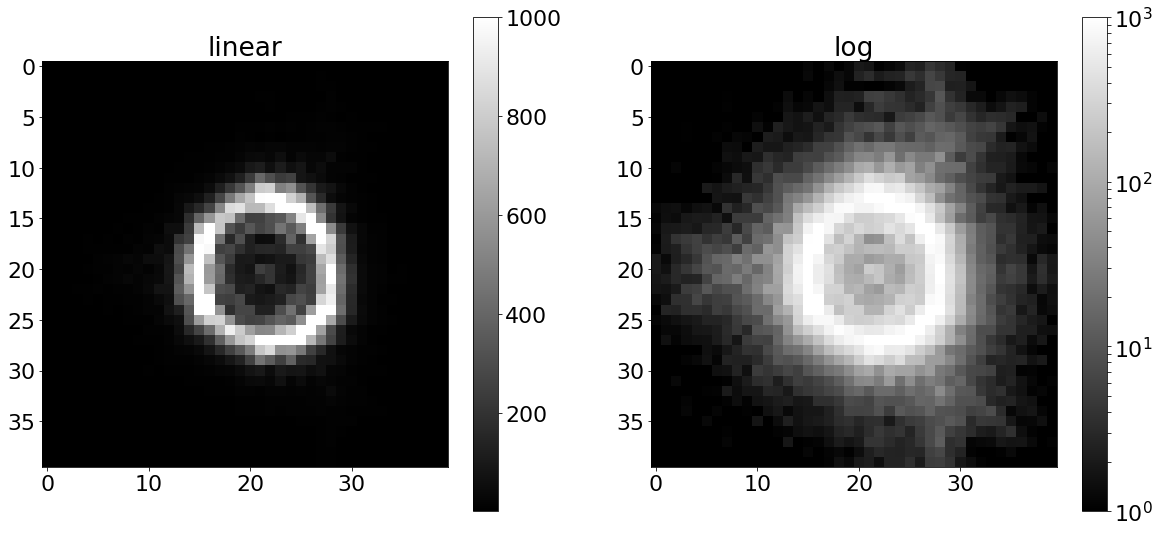

In [186]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

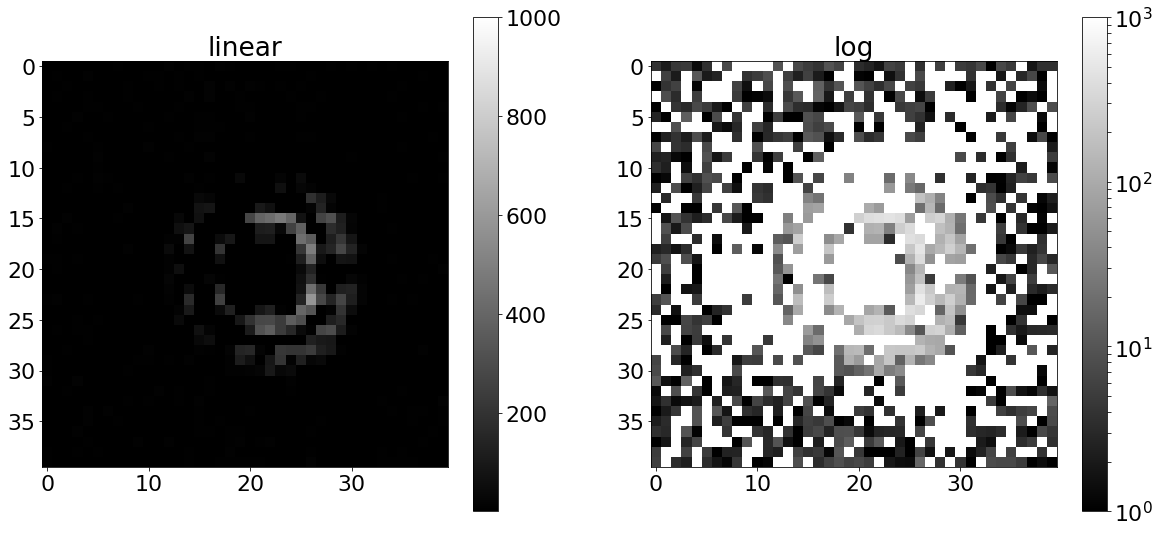

In [187]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

### What does changing each parameter do?

In [ ]:
if not os.path.exists(/home/caplarn/Documents/PFS/Images/dxFocal):
    os.makedirs(/home/caplarn/Documents/PFS/Images/dxFocal)

# Emcee example

## Example from documentation

In [ ]:
>>> import numpy as np
>>> import lmfit
>>> import matplotlib.pyplot as plt
>>> x = np.linspace(1, 10, 250)
>>> np.random.seed(0)
>>> y = 3.0 * np.exp(-x / 2) - 5.0 * np.exp(-(x - 0.1) / 10.) + 0.1 * np.random.randn(len(x))
>>> plt.plot(x, y)
>>> plt.show()

In [ ]:
>>> p = lmfit.Parameters()
>>> p.add_many(('a1', 4.), ('a2', 4.), ('t1', 3.), ('t2', 3., True))

>>> def residual(p):
...     v = p.valuesdict()
...     return v['a1'] * np.exp(-x / v['t1']) + v['a2'] * np.exp(-(x - 0.1) / v['t2']) - y

In [ ]:
>>> mi = lmfit.minimize(residual, p, method='Nelder')
>>> lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
>>> plt.plot(x, y)
>>> plt.plot(x, residual(mi.params) + y, 'r')
>>> plt.show()

In [ ]:
>>> # add a noise parameter
>>> mi.params.add('f', value=1, min=0.001, max=2)

In [ ]:
>>> # This is the log-likelihood probability for the sampling. We're going to estimate the
>>> # size of the uncertainties on the data as well.
>>> def lnprob(p):
...    resid = residual(p)
...    s = p['f']
...    resid *= 1 / s
...    resid *= resid
...    resid += np.log(2 * np.pi * s**2)
...    return -0.5 * np.sum(resid)

In [ ]:
>>> mini = lmfit.Minimizer(lnprob, mi.params)
>>> res = mini.emcee(burn=300, steps=600, thin=10, params=mi.params)

In [ ]:
>>> import corner
>>> corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()))

In [ ]:
>>> print("median of posterior probability distribution")
>>> print('------------------------------------------')
>>> lmfit.report_fit(res.params)

## Understanding what emcee needs

In [ ]:
plt.figure(figsize=(10,10))
# Choose the "true" parameters.
m_true = -1
b_true = 5
f_true =0

# Generate some synthetic data from the model.
N = 50
x=[]
y=[]
x = np.sort(10*np.random.rand(N))
yerr_data = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr_data * np.random.randn(N)
plt.errorbar(x,y,yerr=yerr_data, fmt='o')

In [ ]:
def fcn2min(params, x, y):
    a = params['a']
    b = params['b']
    model = a* x + np.full(len(x),b,dtype='float64')
    return model - y

params = lmfit.Parameters()
params.add('a', value= 10)
params.add('b', value= 0.1)

# do fit, here with leastsq model
minner = lmfit.Minimizer(fcn2min, params, fcn_args=(x, y))
result = minner.minimize()


In [ ]:
final=y+result.residual

In [ ]:
result.params

In [ ]:
plt.errorbar(x,y,yerr=yerr_data, fmt='o')
plt.errorbar(x,final)

In [ ]:
def lnlike(params, x, y,yerr):
    a = params['a']
    b = params['b']
    model = a* x + np.full(len(x),b,dtype='float64')
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

params = lmfit.Parameters()
params.add('a', value= 1)
params.add('b', value= 5)

# do fit, here with leastsq model
minner = lmfit.Minimizer(lnlike, params, fcn_args=(x, y,yerr))
result = minner.emcee(burn=300, steps=6000, thin=10, params=params)

In [ ]:
matplotlib.rcParams.update({'font.size': 10})
corner.corner(result.flatchain, labels=result.var_names, truths=list(result.params.valuesdict().values()))

In [ ]:
def fcn2min(params, x, y, yerr):
    a = params['a']
    b = params['b']
    model = a* x + np.full(len(x),b,dtype='float64')
    return (model - y)/yerr


params = lmfit.Parameters()
params.add('a', value= 1)
params.add('b', value= 5)

# do fit, here with leastsq model
minner = lmfit.Minimizer(fcn2min, params, fcn_args=(x, y,yerr))
result = minner.emcee(nwalkers=20,burn=300, steps=600, thin=1, is_weighted=True,
                      ntemps=1,workers=1, params=params)

In [ ]:
matplotlib.rcParams.update({'font.size': 10})
corner.corner(result.flatchain, labels=result.var_names,
              truths=list(result.params.valuesdict().values()))

In [ ]:
#As class

In [34]:
class ZernikeFitter_Emcee2(object):
    
    """Description comes here
    """
    def __init__(self):
        m_true = -1
        b_true = 60
        f_true =0

        # Generate some synthetic data from the model.
        N = 50
        x=[]
        y=[]
        x = np.sort(10*np.random.rand(N))
        yerr_data = 0.1+0.5*np.random.rand(N)
        y = m_true*x+b_true
        y += np.abs(f_true*y) * np.random.randn(N)
        y += yerr_data * np.random.randn(N)
        self.x=x
        self.y=y
        self.yerr=yerr_data
    
    def initParams(self):
        params = lmfit.Parameters()
        params.add('a', value= 2)
        params.add('b', value= 4)
        self.params = params

    
    def _chi_Neven(self, params):
        a = params['a']
        b = params['b']
        model = a* self.x + np.full(len(self.x),b,dtype='float64')
        print(np.mean(((model - self.y)/self.yerr)**2))
        #return chi_without_nan
        return (model - self.y)/self.yerr

    
    def fit_Neven(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        print(self.params)
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=4,burn=10, steps=1000, thin=1, 
                                 is_weighted=True, ntemps=1,workers=1)
        return self.result

In [35]:
single_image_analysis2=ZernikeFitter_Emcee2()
single_image_analysis2.initParams()
result_fit_single_image2=single_image_analysis2.fit_Neven()

Doing fit using emcee
Parameters([('a', <Parameter 'a', 2, bounds=[-inf:inf]>), ('b', <Parameter 'b', 4, bounds=[-inf:inf]>)])
36396.1012893
36398.0512427
36394.6203852
36394.5805158
36395.1218769
36397.6930092
36394.6042953
36391.7762467
36393.590647
36400.3328615
36394.1152502
36391.2966325
36391.5608308
36397.5439577
36396.4042484
36389.694644
36392.741077
36394.7486664
36396.5338608
36392.0105855
36392.464792
36395.9866887
36395.489444
36387.9832515
36392.6756999
36394.1093437
36393.2532545
36383.4325117
36391.6341868
36404.3275027
36390.368745
36377.3441275
36392.4140879
36391.8093742
36390.5005933
36366.882957
36392.041263
36400.3203009
36389.9211581
36375.182792
36391.5247338
36391.825194
36384.9690952
36351.5818055
36391.610626
36371.9808535
36370.499856
36356.9609576
36405.7475857
36364.6359522
36369.599917
36345.2454323
36382.7829414
36381.6907108
36376.1116061
36340.2851016
36388.7037087
36371.5428667
36375.5126726
36333.4446666
36393.2451995
36375.3803216
36400.8571387
3632

15.5130856927
22.4434131881
25.3447392551
18.0978931297
11.5664666661
23.1832558124
26.3775805588
24.6426234669
14.9141641126
35.5953576023
28.067899462
11.4866217557
11.4977179168
22.2298181821
53.9385770308
13.1062850023
11.8339439684
15.3272620987
40.6563854589
11.6479616202
13.5049345017
15.2558099703
18.8917149254
12.6775981491
12.1397085742
15.1655777413
21.5335696342
11.445905908
12.3338605315
14.6876025117
16.8197431095
11.4817574793
11.3788455841
16.5157693301
19.1425029478
10.2628958592
11.350313002
14.9706296531
21.365176302
10.5288411712
10.8495923011
13.5637072747
16.0073825803
10.3596866577
11.460341657
14.3168394452
29.1599929504
10.2521033583
11.1350199506
12.9494387652
18.1013808393
10.5459757551
11.0387781493
11.760492665
19.71443936
10.304310678
11.4084324166
12.2322415062
13.0792938963
10.2727424595
11.7286007671
11.7548818004
16.2617757173
10.4317980191
11.2152857642
11.8021700492
13.7367432648
10.1778209456
11.844748651
10.9351361936
14.7133686898
9.95867695971
10

6.30370979026
6.18369533657
5.84044767535
6.09327545935
6.32053625555
6.00950080345
5.72798625985
6.22503226376
6.37571346002
6.08065679069
5.59774685924
5.89823447064
7.2385490484
5.85030031078
5.67909225387
5.94367084113
6.2157121988
5.91383509664
5.54697344493
6.34102469105
6.65906252164
5.92819890707
5.73476789798
5.82586312491
6.56396802524
6.02101935064
5.53913270356
5.92897688571
6.50980236289
5.9193522536
5.63857148446
5.75872393254
6.19886442297
5.77484324034
5.60055345354
5.83450869222
6.12286695382
5.53231498562
5.49438559257
6.3529275854
7.06749566588
5.51198852027
5.48280356551
6.06236204575
8.12738539886
5.53498962176
5.479030161
5.78704928966
7.44545702093
5.64745130447
5.61140448952
6.08206911866
5.85356964336
5.73613138374
5.48788748781
7.25681556271
5.96049611968
5.57547306563
5.33209071902
5.71730386809
6.49367053842
5.65121149453
5.94458551579
5.65799746119
5.55837837687
5.94507990021
5.19197858777
6.39595268435
5.61439003444
5.70459961778
5.14831958248
6.6026322311

1.07790980929
1.09219518852
1.08912957852
1.06699991751
1.07771574881
1.12071871279
1.08873625276
1.06835718897
1.07790785483
1.11392833332
1.07994643115
1.08226611581
1.07759885504
1.10178375908
1.08264256316
1.06335897958
1.10468795899
1.15179384406
1.08087806477
1.06326744497
1.06962700285
1.10778333989
1.07166118782
1.06018777366
1.08322966261
1.13341595931
1.06868760525
1.05885854193
1.07487626182
1.25928050158
1.06438675611
1.08213230547
1.07576485272
1.10911787982
1.06945009387
1.08845497605
1.10758590028
1.10677073265
1.06475623021
1.08963750566
1.09347659099
1.10392218724
1.0654286264
1.09744321193
1.06049552622
1.09988160405
1.15085266048
1.10185404217
1.15053805934
1.10638920518
1.09940226568
1.08958916753
1.27124073439
1.10822907224
1.20231092253
1.11116329381
1.04668736516
1.11218949654
1.19323523767
1.10173994093
1.05206472909
1.11400095046
1.05815042367
1.103379294
1.10144942618
1.12415123655
1.09885261682
1.16516572661
1.06399894285
1.11063863863
1.05703510365
1.1034371

0.976220578081
0.896711630493
0.946341415254
0.914997093336
0.949844456191
0.891342901177
0.909750751827
0.914269328164
0.968431797236
0.893161405928
0.912982332548
0.916938854809
1.08111999612
0.89407055991
0.923329985617
0.913867181476
1.04658122152
0.896196034292
0.917821855962
0.921511431787
1.02856393677
0.974090640635
0.92290773291
0.925679822737
0.947285583758
1.30821074774
0.951794160021
0.919225976909
0.976511327617
1.12733691655
1.48242512907
0.913319282895
0.9662328557
0.925554774033
0.951571647673
0.895517074889
0.947022224114
0.970289149071
0.891703766244
0.896283494434
1.06741389742
0.944215071804
0.930257705033
0.960909677629
0.966942826784
1.17591927186
0.933457788593
0.922892226279
0.944880767415
0.927502117297
1.05630732213
1.02798114922
0.940816420055
0.926105906427
1.0262234998
0.922566451267
0.89430102323
0.933585566873
1.04444483078
0.923551167715
0.89919396843
0.971417745331
0.96520205143
0.931598343314
0.896705336283
0.911534973418
0.973494942929
1.08472621777
0

0.900991636624
1.499877834
1.12917705515
0.890325160169
0.901240497402
0.909967433947
1.132594968
0.891639079559
0.902750106528
0.911376603957
0.904713532935
0.890375163679
0.893877328827
0.901363598678
0.927437901748
0.896307238959
0.919126174973
0.895088540229
0.906697542921
0.973151673728
0.897566592924
0.904544338879
0.979021901064
0.906948069247
1.0067198499
0.915220278996
1.00216238624
0.929652797595
0.89840399535
0.909683702222
0.973828637397
0.951010121616
0.900005613049
0.990953871894
1.00214129809
1.09854771805
0.903168798961
0.903177342444
0.950444577048
0.962397304255
0.909082195289
0.922511756189
0.991588229872
1.05423211589
0.913570696166
1.05856877678
0.946955457833
1.34733297537
0.982994804852
0.911429017582
0.98221941861
1.11080836953
0.895457350642
0.938004581497
1.16289810393
0.995361870315
0.905278503875
0.917055705526
1.04266643822
0.995517501848
0.934740863721
0.983067812399
1.24713270326
1.42565269682
0.93096396093
0.930794429101
1.03877897764
0.978345482733
0.89

In [26]:
result_fit_single_image2.init_vals

[2, 4]

In [36]:
result_fit_single_image2.params

Parameters([('a',
             <Parameter 'a', value=-0.99300222980324337 +/- 0.15, bounds=[-inf:inf]>),
            ('b',
             <Parameter 'b', value=59.939860409139257 +/- 1.24, bounds=[-inf:inf]>)])

# Fitting real data on one chip?